# Importing necessary packages

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, add, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.ndimage import median_filter
from skimage import io, color,img_as_float
from skimage.exposure import equalize_adapthist, equalize_hist
import random
from collections import Counter

# Load the dataset

In [ ]:
train_set = r'D:\mir_repository\Datasets with aug images\mir18_v2\train'
valid_set = r'D:\mir_repository\Datasets with aug images\mir18_v2\val'
test_set = r"D:\mir_repository\Datasets with aug images\mir18_v2\test"

# Counting Images in Each Class

In [ ]:
in_dir = r"D:\mir_repository\incorrect_image\common_5"
a = []

for sub_folder in tqdm(os.listdir(in_dir)):
    sub_folder_path = os.path.join(in_dir, sub_folder)

    count = 0

    # Iterating over each image in the directory
    for filename in os.listdir(sub_folder_path):
        if filename.endswith(".jpg"):
            count += 1
        elif filename.endswith(".png"):
            count += 1
        elif filename.endswith(".JPEG"):
            count += 1
        else:
            count+= 1

    a.append(count)

print(a)

100%|██████████| 18/18 [00:00<00:00, 18586.28it/s]

[1, 1, 2, 1, 2, 45, 1, 6, 1, 15, 1, 1, 14, 63, 1, 1, 1, 1]


# Class balance (downsample to minimum)

In [ ]:
def class_balance(directory_path):
    # List of folders in a directory
    folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

    # Counting the number of images in each folder
    folder_image_counts = {}
    for folder in folders:
        folder_path = os.path.join(directory_path, folder)
        image_count = len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
        folder_image_counts[folder] = image_count

    print("Image counts in each folder:")
    for folder, count in folder_image_counts.items():
        print(f"{folder}: {count}")

    # minimum image count
    min_count = min(folder_image_counts.values())

    # Adjust the image counts to be equal to the minimum count
    for folder, count in folder_image_counts.items():
        if count > min_count:
            folder_path = os.path.join(directory_path, folder)
            files = [file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            random.shuffle(files)
            files_to_remove = files[min_count:]
            for file in tqdm(files_to_remove):
                file_path = os.path.join(folder_path, file)
                os.remove(file_path)


    print("\nImage counts after balancing:")
    for folder, count in folder_image_counts.items():
        print(f"{folder}: {count}")

In [ ]:
directory_path = r"D:\mir_repository\mir_Xray_processedbalanced"

In [ ]:
class_balance(directory_path)

Image counts in each folder:
covid: 10848
lung_opacity: 18036
normal_lung: 30576
no_osteoarthritis: 9759
osteoarthritis: 15021
viral_pneumonia: 4035

Image counts after balancing:
covid: 10848
lung_opacity: 18036
normal_lung: 30576
no_osteoarthritis: 9759
osteoarthritis: 15021
viral_pneumonia: 4035


# Split from raw dataset to our dataset

In [ ]:
import splitfolders

In [ ]:
input_folder = r"D:\mir_repository\mir_Xray_processedbalanced"
output_folder = r"D:\mir_repository\mir18_v2+XrayAug"

In [ ]:
splitfolders.ratio(input_folder,
                   output=output_folder,
                   seed =25,
                   ratio=(0.7, 0.15, 0.15), #<----Check Here---!!!
                   group_prefix = None)

Copying files: 24210 files [00:13, 1748.90 files/s]


# Data Processing

### Image Processing Techniques

In [ ]:
from skimage import io, color,img_as_float
from skimage.exposure import equalize_adapthist, equalize_hist

### Apply `CLAHE` , `AHE` , `Histogram Eq.` iteratively

In [ ]:
in_dir = r"D:\mir_repository\incorrect_image\common_5_clahe255"

# Iterate over each sub-folder
for sub_folder in tqdm(os.listdir(in_dir)):
    sub_folder_path = os.path.join(in_dir, sub_folder)

    count = 0
    target = 1000

    # Iterate over each image in the sub-folder
    for filename in os.listdir(sub_folder_path):
        if filename.endswith(".jpg"):
            count += 1
        elif filename.endswith(".png"):
            count += 1
        elif filename.endswith(".JPEG"):
            count += 1
        else:
            count+= 1

    # Check if the item in the main folder is a directory
    if os.path.isdir(sub_folder_path):

        # Iterate over each image in the sub-folder
        for image_file in os.listdir(sub_folder_path):
            image_path = os.path.join(sub_folder_path, image_file)

            # Load the image
            image = cv2.imread(image_path)

            if(count >= target):
                break

            # Apply HISTOGRAM EQUALIZATION and save in the dir
            img_hist = equalize_hist(image)
            imgHist = cv2.normalize(img_hist, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image_path = os.path.join(sub_folder_path, 'hist_' + image_file)
            cv2.imwrite(augmented_image_path, imgHist)
            count+= 1
            if(count >= target):
                break

            # Apply Adaptive Histogram Equalization(AHE)+ Normalized and save in the dir
            img_ahe = equalize_adapthist(image, kernel_size=(36, 36), clip_limit=0)
            imgAHE = cv2.normalize(img_ahe, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image_path = os.path.join(sub_folder_path, 'ahe_' + image_file)
            cv2.imwrite(augmented_image_path, imgAHE)
            count+= 1
            if(count>= target):
                break

            # Apply Cumulative Adaptive Histogram Equalization(CLAHE)+ Normalized and save in the dir
            img_clahe = equalize_adapthist(image, kernel_size=(8, 8), clip_limit=0.01)
            imgCLAHE = cv2.normalize(img_clahe, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image_path = os.path.join(sub_folder_path, 'clahe_' + image_file)
            cv2.imwrite(augmented_image_path, imgCLAHE)

            count+= 1
            if(count>= target):
                break

           # Apply Cumulative Adaptive Histogram Equalization+ Normalized different Parameter and save in the dir
            img_clahe = equalize_adapthist(image, kernel_size=(8, 8), clip_limit=0.01)
            imgCLAHEN = cv2.normalize(img_clahe, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)*255
            augmented_image_path = os.path.join(sub_folder_path, 'clahen_' + image_file)
            cv2.imwrite(augmented_image_path, imgCLAHEN)
            count+= 1
            if(count>= target):
                break



            # Apply Cumulative Adaptive Histogram Equalization and save in the dir
            img_ahen = equalize_adapthist(img, kernel_size = (100,100), nbins = 256)
            imgAHEN = cv2.normalize(img_1, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image_path = os.path.join(sub_folder_path, 'ahen_' + image_file)
            cv2.imwrite(augmented_image_path, imgAHEN)
            count+= 1
            if(count>= target):
                break

100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


# Visualizing Processed Image

In [ ]:
img = cv2.imread("D:\\mir11_v2_bal\\train\\osteoporosis\\1.JPEG")

In [ ]:
# Setting Parameter

k1 = (100, 100)
k2 = (10, 10)
n1 = 256
n2 = 80
c1 = 0.01
c2 = 0.02

#Histogram Equalization

img_hist = equalize_hist(img)

#AHE with different parameters

img_1 = equalize_adapthist(img, kernel_size = k1, nbins = n1)
img_1 = cv2.normalize(img_1, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

img_1 = equalize_adapthist(img, kernel_size = (100,100), nbins = 256)
img_1 = cv2.normalize(img_1, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


img_2 = equalize_adapthist(img, kernel_size = k1, nbins = n1)
img_2 = cv2.normalize(img_1, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)*255

img_2 = equalize_adapthist(img, kernel_size = k1, nbins = n2)
img_2 = cv2.normalize(img_2, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#CLAHE with different parameters

img_3 = equalize_adapthist(img, kernel_size = k1, clip_limit= c1, nbins = n1)
img_3 = cv2.normalize(img_3, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)*255

img_4 = equalize_adapthist(img, kernel_size = k1, clip_limit= c1, nbins = n1)
img_4 = cv2.normalize(img_4, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Normal Image
axes[0, 0].imshow(img, cmap="gray")
axes[0, 0].axis("off")
axes[0, 0].set_title("Normal Image")

# Histogram Equalized Image
axes[0, 1].imshow(img_hist, cmap="gray")
axes[0, 1].axis("off")
axes[0, 1].set_title("Histogram Equalized Image")

# AHE Image
axes[0, 2].imshow(img_1, cmap="gray")
axes[0, 2].axis("off")
axes[0, 2].set_title(f"AHE image1 (k={k1}, n={n1})")

# AHE Image
axes[1, 0].imshow(img_2, cmap="gray")
axes[1, 0].axis("off")
axes[1, 0].set_title(f"AHE image2 (k={k2}, n={n1})")

# CLAHE Image
axes[1, 1].imshow(img_3, cmap="gray")
axes[1, 1].axis("off")
axes[1, 1].set_title(f"CLAHE image1 (k={k1}, c={c1} n={n1})")

# CLAHE Image
axes[1, 2].imshow(img_4, cmap="gray")
axes[1, 2].axis("off")
axes[1, 2].set_title(f"CLAHE image2 (k={k1}, c={c1} n={n1})")


# Specialized Processing for X-raay image

In [ ]:
def median_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Spliting the image into separate color channels (B, G, R)
    b, g, r = cv2.split(image)

    # Apply median filter to each channel
    b_filtered = median_filter(b, size=(3, 3))
    g_filtered = median_filter(g, size=(3, 3))
    r_filtered = median_filter(r, size=(3, 3))

    # Merge the filtered channels back into a single image
    filtered_image = cv2.merge((b_filtered, g_filtered, r_filtered))

    return filtered_image

In [ ]:
def clahe_image(image):
    # Gray Scale Conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE to the grayscale image
    clahe = equalize_adapthist(gray,kernel_size=(100, 100), clip_limit= 0.01, nbins = 256)

    # Convert the CLAHE image to 8-bit depth
    clahe_8bit = cv2.convertScaleAbs(clahe)


    # Convert this image to BGR color space
    clahe_image = cv2.cvtColor(clahe_8bit, cv2.COLOR_GRAY2BGR)

    return clahe_image

In [ ]:
def apply_rotation(image, angle):

    # Image Dimensions
    height, width = image.shape[:2]

    # Middle Point Calculation
    middle_x = width // 2
    middle_y = height // 2

    # Creating the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((middle_x, middle_y), angle, 1.0)

    # Applying the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

In [ ]:
def process_images(directory):
    # Get a list of all image files in the directory
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    for image_file in tqdm(image_files):
        image_path = os.path.join(directory, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)

        # Apply median filter to each channel
        b, g, r = cv2.split(img)
        b_filtered = median_filter(b, size=(3, 3))
        g_filtered = median_filter(g, size=(3, 3))
        r_filtered = median_filter(r, size=(3, 3))

        #Merging the channels
        filtered_image = cv2.merge((b_filtered, g_filtered, r_filtered))

        # Convert the filtered image to grayscale
        gray = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE to the grayscale image
        clahe_img = equalize_adapthist(gray,kernel_size=(100, 100), clip_limit= 0.01, nbins = 256)

        # Multiply by 255 to rescale to 8-bit unsigned integer range
        clahe_img = np.uint8(clahe_img * 255)

        #Applying rotation of 45, 180, 270 degrees
        img_1 = apply_rotation(clahe_img, 45)
        img_2 = apply_rotation(clahe_img, 180)
        img_3 = apply_rotation(clahe_img, 270)

        # Overwrite the original image with the CLAHE processed image
        base_name, ext = os.path.splitext(image_path)

        cv2.imwrite(image_path, img_1)
        cv2.imwrite(base_name + '_rotated_180' + ext, img_2)
        cv2.imwrite(base_name + '_rotated_270' + ext, img_3)

In [ ]:
image_directory = r"D:\mir_repository\mir_Xray_processed\viral_pneumonia"

In [ ]:
process_images(image_directory)

100%|██████████| 1345/1345 [01:18<00:00, 17.17it/s]


# Define `augmentation techniques`

In [ ]:
from skimage.filters import gaussian

#### Gaussian Filter

In [ ]:
def apply_gaussian_blur(image, variance_range=(0.1, 0.9)):
    image = image.astype(np.float32) / 255.0
    # Create a random variance within the specified range
    variance = np.random.uniform(*variance_range)

    # Calculate the radius of the kernel
    radius = int(4 * variance)

    # Apply Gaussian blur to the image
    blurred_image = gaussian(image, sigma=variance, truncate=2.0, preserve_range=True, multichannel=True)
    blurred_image = (blurred_image * 255).astype(np.uint8)
    blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

    return blurred_image

#### Scale

In [ ]:
def apply_scaling(image, scale_factor):

    # Dimensions of Image
    height, width = image.shape[:2]

    # Define the scaling factors

    sx = scale_factor  # scaling factor in the x direction
    sy = scale_factor  # scaling factor in the y direction

    # Define the transformation matrix
    transformation_matrix = np.array([[sx, 0, 0],
                                      [0, sy, 0]])

    # Apply the scaling transformation
    scaled_image = cv2.warpAffine(image, transformation_matrix, (width, height))

    return scaled_image

#### Shear

In [ ]:
def apply_shear(image, shear_factor):

    # Dimensions of Image
    height, width = image.shape[:2]

    #shear factor
    s = shear_factor

    # Defining transformation matrix
    transformation_matrix = np.array([[1, s, 0],
                                      [0, 1, 0]])

    # Apply the shear transformation
    sheared_image = cv2.warpAffine(image, transformation_matrix, (width, height))

    return sheared_image

#### Rotation

In [ ]:
def apply_rotation(image, angle):
    #Dimensions of Image
    height, width = image.shape[:2]

    # Convert the angle from degrees to radians
    theta = math.radians(angle)

    # Calculate the sine and cosine of the angle
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)

    # Transformation matrix
    transformation_matrix = np.array([[cos_theta, -sin_theta, 0],
                                      [sin_theta, cos_theta, 0]])

    # Applying rotation transformation
    rotated_image = cv2.warpAffine(image, transformation_matrix, (width, height))

    return rotated_image

#### Jitter

In [ ]:
def apply_contrast_jitter(image, intensity_range):

  # Applying contrast jittering
  intensity = np.random.randint(intensity_range[0], intensity_range[1] + 1)
  jittered_image = np.clip(image + intensity, 0, 255)

  return jittered_image

# Apply `Augmentation Techniques` iteratively

###### rotation, gaussian filter, scale, shear, jitter, hFlip, vFlip, sharpen

In [ ]:
in_dir = r"D:\mir_repository\incorrect_image\common_5"

In [ ]:
for sub_folder in tqdm(os.listdir(in_dir)):
    sub_folder_path = os.path.join(in_dir, sub_folder)

    count = 1
    target = 5000  #desired sample per class

    for filename in os.listdir(sub_folder_path):
        if filename.endswith(".jpg"):
            count += 1
        elif filename.endswith(".png"):
            count += 1
        elif filename.endswith(".JPEG"):
            count += 1
        else:
            count+= 1

    # Check if the item in the main folder is a directory
    if os.path.isdir(sub_folder_path):

        # Iterate over each image in the sub-folder
        for image_file in os.listdir(sub_folder_path):
            image_path = os.path.join(sub_folder_path, image_file)
            image = cv2.imread(image_path)

            if(count > target):
                break

#             # Apply rotation and save in the dir
#             angle = np.random.uniform(-15, 15)
#             rotated_image = apply_rotation(image, angle)
#             augmented_image_path = os.path.join(sub_folder_path, 'rotated_' + image_file)
#             cv2.imwrite(augmented_image_path, rotated_image)
#             count+= 1
#             if(count > target):
#                 break

            # Apply gaussian filter and save in the dir
            blurred_image = apply_gaussian_blur(image, variance_range=(0.1, 0.9))
            augmented_image_path = os.path.join(sub_folder_path, 'blurred_' + image_file)
            cv2.imwrite(augmented_image_path, blurred_image)
            count+= 1
            if(count> target):
                break

            # Apply scaling and save in the dir
            scaled_image = apply_scaling(image, 0.5)
            augmented_image_path = os.path.join(sub_folder_path, 'scaled_' + image_file)
            cv2.imwrite(augmented_image_path, scaled_image)
            count+= 1
            if(count> target):
                break

            # Apply shear and save in the dir
            shear_factor = np.random.uniform(0.1, 0.35)
            sheared_image = apply_shear(image, shear_factor)
            augmented_image_path = os.path.join(sub_folder_path, 'sheared_' + image_file)
            cv2.imwrite(augmented_image_path, sheared_image)
            count+= 1
            if(count> target):
                break

            # Apply jitter and save in the dir
            intensity_range = (1, 4)
            jittered_image = apply_contrast_jitter(image , intensity_range)
            augmented_image_path = os.path.join(sub_folder_path, 'jittered_' + image_file)
            cv2.imwrite(augmented_image_path, jittered_image)
            count+= 1
            if(count> target):
                break

            # Apply horizontal flip and save in the dir
            horizontal_flipped_image = cv2.flip(image, 1)
            augmented_image_path = os.path.join(sub_folder_path, 'hFlip_' + image_file)
            cv2.imwrite(augmented_image_path, horizontal_flipped_image)
            count+= 1
            if(count> target):
                break

            # Apply vertical flip and save in the dir
            vertical_flipped_image = cv2.flip(image, 0)
            augmented_image_path = os.path.join(sub_folder_path, 'vFlip_' + image_file)
            cv2.imwrite(augmented_image_path, vertical_flipped_image)
            count+= 1
            if(count> target):
                break

            # Apply sharpening and save in the dir
            sharpened_image = cv2.filter2D(image, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
            augmented_image_path = os.path.join(sub_folder_path, 'sharpened_' + image_file)
            cv2.imwrite(augmented_image_path, sharpened_image)
            count+= 1
            if(count> target):
                break

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\88013\AppData\Local\Temp\ipykernel_14136\959566693.py:10: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred_image = gaussian(image, sigma=variance, truncate=2.0, preserve_range=True, multichannel=True)
100%|██████████| 6/6 [00:59<00:00,  9.99s/it]


# Visualize `Augmented Image`

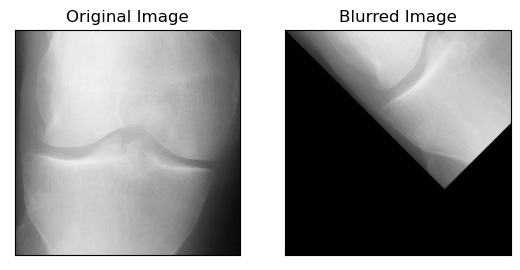

In [ ]:
img= cv2.imread(r"D:\mir_repository\MIR-17\train\grade_2_osteoarthritis\9000099R.png")
gaussian_image = apply_rotation(img, -45)

# Display the original and blurred images
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(gaussian_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Data Augmentation using ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range = 20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        fill_mode = "nearest")

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(299, 299), #<----------
    color_mode ='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=16, #<----------
    shuffle=True,
    seed=25)

train_sub = test_datagen.flow_from_directory(
    train_set,
    target_size=(299, 299), #<----------
    color_mode ='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=16, #<----------
    shuffle=True,
    seed=25)

valid_generator = test_datagen.flow_from_directory(
    valid_set,
    target_size=(299, 299), #<----------
    color_mode ='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=16, #<----------
    shuffle=True,
    seed=25)

test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(299, 299), #<----------
    color_mode ='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=16, #<----------
    shuffle=False,
    seed=25)

### Loding Dataset using Image dataset from directrory

In [ ]:
train_ds = image_dataset_from_directory(
     train_set,
     labels="inferred",
     label_mode="categorical",
     color_mode="rgb",
     batch_size=32, #<----------
     image_size=(224, 224), #<----------
     shuffle=True,
     seed=100
 )

valid_ds = image_dataset_from_directory(
     valid_set,
     labels="inferred",
     label_mode="categorical",
     color_mode="rgb",
     batch_size=32, #<----------
     image_size=(224, 224), #<----------
     shuffle=True,
     seed=100,
 )

test_ds = image_dataset_from_directory(
     test_set,
     labels="inferred",
     label_mode="categorical",
     color_mode="rgb",
     batch_size=32, #<----------
     image_size=(224, 224), #<----------
     shuffle=False,
     seed=100)

# Model

### Basic CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax')) #<----- Check Here ----!!!

# Transfer Learning

##### Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all the layers in the base model

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))  #<----- Check Here ----!!!

##### DenseNet121

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(18, activation = 'softmax'))  #<----- Check Here ----!!!

##### VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
#model.add(GlobalAveragePooling2D())
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5)) #<----- Check Here ----!!!
model.add(Dense(18, activation = 'softmax'))  #<----- Check Here ----!!!

##### VGG19

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential()
model.add(base_model)
#model.add(GlobalAveragePooling2D())
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5)) #<----- Check Here ----!!!
model.add(Dense(18, activation = 'softmax'))  #<----- Check Here ----!!!

##### InceptionResNetV2

In [ ]:
from tensorflow.keras.layers import  BatchNormalization

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #MaxPooling2D(),
    Dense(512, activation = 'relu'),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(18, activation='softmax')]) #<------ Check here---!!!

###### EfficientNetV2S

In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2S

In [ ]:
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation = 'softmax'))  #<----- Check Here ----!!!

##### Xception

In [ ]:
from keras.applications.xception import Xception

In [ ]:
base_model= Xception(include_top=False, weights="imagenet", input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
model.add(Conv2D(32, 3, activation = 'relu'))
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(21, activation = 'softmax'))  #<----- Check Here ----!!!

# Load model

In [ ]:
model = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\100_mir18v2_effnetv2.h5")

# Model architecture

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='mir_effnetv2s_mir18v2_idfd.png',  #<----- Check Here ----!!!
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    layer_range=None,
    show_layer_activations=True
)

# Callbacks

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Compile  model

In [ ]:
model.compile( optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics= ['accuracy']
             )

#### Fitting Model with Image Data Generator Data

In [ ]:
history = model.fit_generator(
          train_sub,
          #steps_per_epoch = len(train_generator),
          epochs = 15,
          validation_data = valid_generator,
          callbacks=[early_stopping, reduce_lr]
)

# Train model using main data

In [ ]:
history = model.fit(
          train_ds,
          epochs = 100,
          validation_data = valid_ds,
          #callbacks=[early_stopping, reduce_lr],
          verbose=1)

# Finding the best epoch

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch_acc = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch (val_acc): %d' % (best_epoch_acc,))

val_loss_per_epoch = history.history['val_loss']
best_epoch_loss = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch (val_loss): %d' % (best_epoch_loss,))

# Evaluation of the trained model

#### Plot the `accuracy and loss curves` for training and validation sets

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
best_epoch_accuracy = np.argmax(history.history['val_accuracy']) + 1
plt.scatter(best_epoch_accuracy - 1, history.history['val_accuracy'][best_epoch_accuracy - 1], color='g', label='Best Epoch')

# Set integer ticks for x-axis
plt.xticks(np.arange(len(history.history['accuracy'])), np.arange(1, len(history.history['accuracy']) + 1))

plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
best_epoch_loss = np.argmin(history.history['val_loss']) + 1
plt.scatter(best_epoch_loss - 1, history.history['val_loss'][best_epoch_loss - 1], color='g', label='Best Epoch')

# Set integer ticks for x-axis
plt.xticks(np.arange(len(history.history['loss'])), np.arange(1, len(history.history['loss']) + 1))

plt.show()


# Save the model

In [ ]:
model.save("100_mir18v2_effnetv2s.h5")

## Predicted Labels

In [ ]:
y_predictions = model.predict(test_ds) #<----Check Here---!!!
print(y_predictions)

In [ ]:
y_predicted_labels = np.argmax(y_predictions, axis=1)
print(y_predicted_labels)

## True labels

#### For test_ds

In [ ]:
true_labels = []
for images, labels in test_ds:
    true_labels.append(labels.numpy())
y_true_labels = np.concatenate(true_labels)

print(y_true_labels)

In [ ]:
y_true_labels = np.argmax(y_true_labels, axis=1)
print(y_true_labels)

####  For test_generator

In [ ]:
y_true_labels = test_generator.classes
print(y_true_labels)

# -----------------------------------------------`METRICS`-----------------------------------------------

In [ ]:
# Accuracy
accuracy = accuracy_score(y_true_labels, y_predicted_labels)

# Precision (micro)
precision_micro = precision_score(y_true_labels, y_predicted_labels, average='micro')

# Recall (micro)
recall_micro = recall_score(y_true_labels, y_predicted_labels, average='micro')

# F1 score (micro)
f1_micro = f1_score(y_true_labels, y_predicted_labels, average='micro')


# Creating a dictionary with the metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 score'],
    'Value (%)': [accuracy*100, precision_micro*100, recall_micro*100, f1_micro*100]
}

# Converting the metrics dictionary to a table
table = tabulate(metrics, headers='keys', tablefmt='fancy_grid')
print(table)

# Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_labels, y_predicted_labels)

In [ ]:
class_labels = ['benign_lung_cancer',
                'brain_tumor',
                'covid',
                'cyst_kidney',
                'glioma_tumor',
                'lung_opacity',
                'malignant_lung_cancer',
                'meningioma_tumor',
                'no_brain_tumor',
                'no_lung_cancer',
                'no_osteoarthritis',
                'normal_kidney',
                'normal_lung',
                'osteoarthritis',
                'pituitary_tumor',
                'stone_kidney',
                'tumor_kidney',
                'viral_pneumonia']

In [ ]:
sns.heatmap(conf_matrix,
            annot=True,
            cmap="ocean_r",
            fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={"fontsize": 7},
            linewidths=0.5
           )


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

# Classification Report

In [ ]:
class_report = classification_report(y_true_labels,
                                     y_predicted_labels,
                                     target_names= class_labels
                                    )

print("\nClassification Report:\n", class_report)

# ------------------------------------------------ Ends ------------------------------------------------

# Storing predictions

#### Set the output directory where the wrong predictions will be moved

In [ ]:
output_dir = r"D:\mir_repository\Datasets with aug images\mir18_v2\wrongs_effnetv2sT_mir18v2"

In [ ]:
count = 0
for images, labels in test_ds:
    # Iterate over the images and compare the true and predicted labels
    for i in range(len(y_true_labels)):
        if y_true_labels[i] != y_pred_labels[i]:
            # Get the file name of the incorrectly predicted image
            file_name = os.path.basename(test_ds.file_paths[i])

            # Copy the image to the output directory
            src_path = test_ds.file_paths[i]
            dst_path = os.path.join(output_dir, file_name)
            shutil.move(src_path, dst_path)

            print(file_name)

print("Printing the file names of incorrectly predicted images completed.")

# Finding the common wrong/right predictions

In [ ]:
def compare_and_copy_files(dir1, dir2, dir3, dir4, dir5, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get the list of files in each directory
    files_dir1 = get_files_list(dir1)
    files_dir2 = get_files_list(dir2)
    files_dir3 = get_files_list(dir3)
    files_dir4 = get_files_list(dir4)
    files_dir5 = get_files_list(dir5)

    # Compare the file names and copy the matching files to the output directory
    for file1 in tqdm(files_dir1):
        if file1 in files_dir2 and file1 in files_dir3 and file1 in files_dir4 and file1 in files_dir5:
            source_path = os.path.join(dir1, file1)
            destination_path = os.path.join(output_dir, file1)
            shutil.copyfile(source_path, destination_path)
            print(f"Copied {file1} to {output_dir}")

def get_files_list(directory):
    # Get the list of files in the directory
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

In [ ]:
# Provide the paths for the two directories and the output directory
dir1 = r"D:\mir_repository\incorrect_image\effnectv2s_t_mir18"
dir2 = r"D:\mir_repository\incorrect_image\effnetv2s_mir18"
dir3 = r"D:\mir_repository\incorrect_image\effnetv2s_t_mir18v2"
dir4 = r"D:\mir_repository\incorrect_image\inception_mir18"
dir5 = r"D:\mir_repository\incorrect_image\inception_mir18v2"

output_dir = r"D:\mir_repository\incorrect_image\common_5"

# Call the function to compare and copy the files
compare_and_copy_files(dir1, dir2, dir3, dir4, dir5, output_dir)

##### Finding right/wrong Predictions among 2 directories

In [ ]:
def compare_and_copy_files(dir1, dir2, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get the list of files in the first directory
    files_dir1 = get_files_list(dir1)

    # Get the list of files in the second directory
    files_dir2 = get_files_list(dir2)

    # Compare the file names and copy the matching files to the output directory
    for file1 in files_dir1:
        if file1 in files_dir2:
            source_path = os.path.join(dir1, file1)
            destination_path = os.path.join(output_dir, file1)
            shutil.copyfile(source_path, destination_path)
            print(f"Copied {file1} to {output_dir}")

def get_files_list(directory):
    # Get the list of files in the directory
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

In [ ]:
# Provide the paths for the two directories and the output directory
dir1 = r"D:\mir_repository\incorrect_image\effnetv2s_t_mir18v2"
dir2 = r"D:\mir_repository\incorrect_image\effnectv2s_t_mir18"
output_dir = r"D:\mir_repository\incorrect_image\common_2_effnetv2sT"

# Call the function to compare and copy the files
compare_and_copy_files(dir1, dir2, output_dir)

# Ensemble Learning

##### Import neecessary libraries

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.utils import image_dataset_from_directory

# Set the directories

In [ ]:
train_set = r'D:\mir_repository\Datasets with aug images\mir18_v2\train'
valid_set = r'D:\mir_repository\Datasets with aug images\mir18_v2\val'
test_set = r'D:\mir_repository\Datasets with aug images\mir18_v2\test'

In [ ]:
train_ds = image_dataset_from_directory(
     train_set,
     labels="inferred",
     label_mode="categorical",
     color_mode="rgb",
     batch_size=32, #<----------
     image_size=(224, 224), #<----------
     shuffle=True,
     seed=100
 )

valid_ds = image_dataset_from_directory(
     valid_set,
     labels="inferred",
     label_mode="categorical",
     color_mode="rgb",
     batch_size=32, #<----------
     image_size=(224, 224), #<----------
     shuffle=True,
     seed=100,
 )

test_ds = image_dataset_from_directory(
     test_set,
     labels="inferred",
     label_mode="categorical",
     color_mode="rgb",
     batch_size=32, #<----------
     image_size=(224, 224), #<----------
     shuffle=False,
     seed=100)

Found 74366 files belonging to 18 classes.
Found 7316 files belonging to 18 classes.
Found 7340 files belonging to 18 classes.


# Load Models

In [ ]:
model1 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18v2_effnetv2s_nf.h5")

In [ ]:
model3 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18v2_inceptionresnetv2.h5")

In [ ]:
model5 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18_effnetv2s_nf.h5")
model6 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18_inceptionresnetv2.h5")
model7 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18_effnetv2s.h5")

In [ ]:
model2 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18XRAYAUG_effnetv2s_nf.h5")
model4 = tf.keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18v2X_inceptionresnetv2.h5")

# True Labels

In [ ]:
true_labels = []
for images, labels in test_ds:
    true_labels.append(labels.numpy())

ground_true_labels = np.concatenate(true_labels)
ground_true_labels = np.argmax(ground_true_labels, axis=1)
print(ground_true_labels)

[ 0  0  0 ... 17 17 17]


# Ensemble: Summed (non-weighted)

In [ ]:
models = [model1, model3,  model5, model6, model7]

In [ ]:
predictions = [model.predict(test_ds) for model in tqdm(models)]

  0%|          | 0/5 [00:00<?, ?it/s]

230/230 [==============================] - 34s 88ms/step


 20%|██        | 1/5 [00:34<02:16, 34.02s/it]

230/230 [==============================] - 34s 131ms/step


 40%|████      | 2/5 [01:08<01:42, 34.02s/it]

230/230 [==============================] - 24s 88ms/step


 60%|██████    | 3/5 [01:31<00:58, 29.29s/it]

230/230 [==============================] - 33s 130ms/step


 80%|████████  | 4/5 [02:05<00:30, 30.92s/it]

230/230 [==============================] - 23s 87ms/step


100%|██████████| 5/5 [02:28<00:00, 29.67s/it]


In [ ]:
predictions = np.array(predictions)

In [ ]:
summed_predictions = np.sum(predictions, axis=0)

In [ ]:
mean_predictions = np.mean(predictions, axis=0)

In [ ]:
ensembled_prediction = np.argmax(summed_predictions, axis=1)

ensemble_acc = accuracy_score(ground_true_labels, ensembled_prediction)
print('Ensembled (summed): ',ensemble_acc*100)

Ensembled (summed):  94.01907356948229


In [ ]:
ensembled_prediction = np.argmax(mean_predictions, axis=1)

ensemble_acc = accuracy_score(ground_true_labels, ensembled_prediction)
print('Ensembled (mean): ',ensemble_acc*100)

Ensembled (mean):  94.01907356948229


In [ ]:
num_correct = np.sum(ensembled_prediction == ground_true_labels)
total_samples = len(ground_true_labels)
overall_accuracy = num_correct / total_samples

print("Overall: ", overall_accuracy)

Overall:  0.9401907356948229


# Predictions of each model

In [ ]:
# Make predictions with each base model
predictions_model1 = model1.predict(test_ds)
predictions_model3 = model3.predict(test_ds)
predictions_model5 = model5.predict(test_ds)
predictions_model6 = model6.predict(test_ds)
predictions_model7 = model7.predict(test_ds)

model1_predicted_labels = np.argmax(predictions_model1, axis=1)
model3_predicted_labels = np.argmax(predictions_model3, axis=1)
model5_predicted_labels = np.argmax(predictions_model5, axis=1)
model6_predicted_labels = np.argmax(predictions_model6, axis=1)
model7_predicted_labels = np.argmax(predictions_model7, axis=1)

10/10 [==============================] - 1s 118ms/step


In [ ]:
predictions_model2 = model2.predict(test_ds)
predictions_model4 = model4.predict(test_ds)

model2_predicted_labels = np.argmax(predictions_model2, axis=1)
model4_predicted_labels = np.argmax(predictions_model4, axis=1)

In [ ]:
acc1 = accuracy_score(ground_true_labels, model1_predicted_labels)
#acc2 = accuracy_score(y_true_labels, model2_predicted_labels)
acc3 = accuracy_score(y_true_labels, model3_predicted_labels)
#acc4 = accuracy_score(y_true_labels, model4_predicted_labels)
#acc5 = accuracy_score(y_true_labels, model5_predicted_labels)
acc6 = accuracy_score(y_true_labels, model6_predicted_labels)
#acc7 = accuracy_score(y_true_labels, model7_predicted_labels)

ensemble_acc = accuracy_score(y_true_labels, ensembled_prediction)

In [ ]:
print('Acuracy of Model 1: ', acc1*100)
#print('Acuracy of Model 2: ', acc2*100)
print('Acuracy of Model 3: ', acc3*100)
print('Acuracy of Model 4: ', acc4*100)
print('Acuracy of Model 5: ', acc5*100)
print('Acuracy of Model 6: ', acc6*100)
print('Acuracy of Model 7: ', acc7*100)

print('Ensembled (summed): ',ensemble_acc*100)

Acuracy of Model 1:  11.708860759493671


## Ensemble : Weighted average

In [ ]:
# Assign distinct class weights for each base model
class_weights_model1 = {0:1 ,1:1, 2:0, 3:1, 4:0, 5:1, 6:1, 7:0, 8:0, 9:0, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1, 16:1, 17:0}
#class_weights_model2 = {0:0 ,1:0, 2:0, 3:0, 4:1, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:1, 15:0, 16:0, 17:0}
class_weights_model3 = {0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:0, 9:0, 10:0, 11:0, 12:1, 13:0, 14:0, 15:0, 16:0, 17:0}
#class_weights_model4 = {0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:1, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:1}
class_weights_model5 = {0:0 ,1:0, 2:1, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:1, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0}
class_weights_model6 = {0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0}
class_weights_model7 = {0:0 ,1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:1, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0}


# Apply class weights to predictions of each model
weighted_predictions_model1 = np.multiply(predictions_model1, list(class_weights_model1.values()))
#weighted_predictions_model2 = np.multiply(predictions_model2, list(class_weights_model2.values()))
weighted_predictions_model3 = np.multiply(predictions_model3, list(class_weights_model3.values()))
#weighted_predictions_model4 = np.multiply(predictions_model4, list(class_weights_model4.values()))
weighted_predictions_model5 = np.multiply(predictions_model5, list(class_weights_model5.values()))
weighted_predictions_model6 = np.multiply(predictions_model6, list(class_weights_model6.values()))
weighted_predictions_model7 = np.multiply(predictions_model7, list(class_weights_model7.values()))

# Combine the weighted predictions using the stacking ensemble approach (e.g., averaging)
ensemble_predictions = (weighted_predictions_model1 +
                        #weighted_predictions_model2 +
                        weighted_predictions_model3 +
                        #weighted_predictions_model4 +
                        weighted_predictions_model5 +
                        weighted_predictions_model6 +
                        weighted_predictions_model7) / 5

# Make the final predictions by selecting the class with the highest probability
final_predictions = np.argmax(ensemble_predictions, axis=1)

print(final_predictions)

In [ ]:
accuracy = accuracy_score(gr, final_predictions)
print("Accuracy:", accuracy)

# Weights Int

In [ ]:
model1_weight = [7,
                 7,
                 5,
                 7,
                 5,
                 5,
                 7,
                 3,
                 3,
                 3,
                 0,
                 7,
                 3,
                 7,
                 5,
                 7,
                 7,
                 0]


#model2_weight = [0.2, 0.7, .5, .3, ]

model3_weight = [2,
                 5,
                 0,
                 2,
                 0,
                 0,
                 2,
                 7,
                 7,
                 0,
                 5,
                 5,
                 7,
                 0,
                 0,
                 3,
                 3,
                 3]

#model4_weight = [0.7, 0.7, .5, .3, ]

model5_weight = [0,
                 3,
                 7,
                 0,
                 3,
                 3,
                 2,
                 0,
                 5,
                 7,
                 0,
                 0,
                 5,
                 3,
                 3,
                 5,
                 7,
                 0]

model6_weight = [2,
                 0,
                 3,
                 2,
                 7,
                 7,
                 0,
                 5,
                 0,
                 5,
                 3,
                 3,
                 0,
                 5,
                 7,
                 0,
                 0,
                 5]

model7_weight = [0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 7,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 7]

# Weights 7/0

In [ ]:
model1_weight = [7,
                 7,
                 0,
                 7,
                 0,
                 0,
                 7,
                 0,
                 0,
                 0,
                 0,
                 7,
                 0,
                 0,
                 0,
                 7,
                 7,
                 0]

In [ ]:
model3_weight = [0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 7,
                 7,
                 0,
                 0,
                 0,
                 7,
                 0,
                 0,
                 0,
                 0,
                 0]

In [ ]:
model5_weight = [0,
                 0,
                 7,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0]

In [ ]:
model6_weight = [0,
                 0,
                 0,
                 0,
                 7,
                 7,
                 0,
                 0,
                 0,
                 7,
                 7,
                 0,
                 0,
                 7,
                 7,
                 0,
                 0,
                 0]

In [ ]:
model7_weight = [0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 7]

# Reducer function

In [ ]:
from collections import OrderedDict

def reducer(prediction):
    sorted_prediction = OrderedDict(sorted(prediction.items(), key=lambda item: item[1][0]))

    # print(sorted_prediction)

    keys_to_delete = list(sorted_prediction.keys())[:2]
    for key in keys_to_delete:
        del sorted_prediction[key]
    print("Sorted: ", sorted_prediction)

    return sorted_prediction

#  Ensemble: Classwise-Weight Conditional

In [ ]:
predictions = []

In [ ]:
for image, _ in tqdm(test_ds):
    model1_predict = np.argmax(model1.predict(image), axis=1)
    #model2_predict = model2.predict(image)
    model3_predict = np.argmax(model3.predict(image), axis=1)
    #model4_predict = model4.predict(image)
    model5_predict = np.argmax(model5.predict(image), axis=1)
    model6_predict = np.argmax(model6.predict(image), axis=1)
    model7_predict = np.argmax(model7.predict(image), axis=1)

    prediction = {
        "model1" : [model1_weight[model1_predict[0]],model1_predict[0]],  # model1 : [weight, prediction]
        #"model2" : [model2_weight[model2_predict], model2_predict],
        "model3" : [model3_weight[model3_predict[0]],model3_predict[0]],
        #"model4" : [model4_weight[model4_predict], model4_predict],
        "model5" : [model5_weight[model5_predict[0]],model5_predict[0]],
        "model6" : [model6_weight[model6_predict[0]],model6_predict[0]],
        "model7" : [model7_weight[model7_predict[0]],model7_predict[0]]
        }


    count = 0
    con = 0


    keys_to_delete = []

    # Keeps 3 model with greater weight removes 0 weight
    for key, value in prediction.items():
        if value[0] == 0:
            keys_to_delete.append(key)
            count += 1

        else:
            con += 1

    if len(keys_to_delete) != 0 :
      ar = {
            keys_to_delete[0] : [0.1 ,prediction[keys_to_delete[0]][1]]
            }
    print(ar)

    # Two value without 0
    if count > 2:
      for key in keys_to_delete:
        del prediction[key]
      prediction.update(ar)

    # 4 or 5 value without 0
    elif con > 3:
      prediction = reducer(prediction)

    else:
      for key in keys_to_delete:
          del prediction[key]

    keys = list(prediction.keys())
    print("Prediction: ", prediction)
    print("Keys: ", keys)

    # if len(prediction) == 1:
    #   predictions.append(solution(prediction[keys[0]][1]))

    if len(prediction) == 1:
        print(prediction[keys[0]][1])
        predictions.append(prediction[keys[0]][1])

    elif len(prediction) == 2:
        if prediction[keys[0]][0] >= prediction[keys[1]][0]:
            print(prediction[keys[0]][1])
            predictions.append(prediction[keys[0]][1])

        elif prediction[keys[0]][0] < prediction[keys[1]][0]:
            print(prediction[keys[1]][1])
            predictions.append(prediction[keys[1]][1])

        else:
            print(prediction[keys[0]][1])
            predictions.append(prediction[keys[0]][1])

    elif prediction[keys[0]][1] == prediction[keys[1]][1]:
        weight = prediction[keys[0]][0] + prediction[keys[1]][0]

        if weight > prediction[keys[2]][0] :
            print(prediction[keys[0]][1])
            predictions.append(prediction[keys[0]][1])

        else :
            print(prediction[keys[2]][1])
            predictions.append(prediction[keys[2]][1])

    elif prediction[keys[0]][1] == prediction[keys[2]][1]:
        weight = prediction[keys[0]][0] + prediction[keys[2]][0]

        if weight > prediction[keys[1]][0] :
            print(prediction[keys[0]][1])
            predictions.append(prediction[keys[0]][1])

        else :
            print(prediction[keys[1]][1])
            predictions.append(prediction[keys[1]][1])

    elif prediction[keys[1]][1] == prediction[keys[2]][1]:
        weight = prediction[keys[1]][0] + prediction[keys[2]][0]

        if weight > prediction[keys[0]][0] :
            print(prediction[keys[1]][1])
            predictions.append(prediction[keys[1]][1])

        else :
            print(prediction[keys[0]][1])
            predictions.append(prediction[keys[0]][1])

    elif prediction[keys[0]][0] > prediction[keys[1]][0] and prediction[keys[0]][0] > prediction[keys[2]][0] :
        print(prediction[keys[0]][1])
        predictions.append(prediction[keys[0]][1])

    elif prediction[keys[1]][0] > prediction[keys[2]][0] and prediction[keys[1]][0] > prediction[keys[0]][0] :
        print(prediction[keys[1]][1])
        predictions.append(prediction[keys[1]][1])

    else :
        print(prediction[keys[2]][1])
        predictions.append(prediction[keys[2]][1])
    #print(predictions)

  0%|          | 0/7344 [00:00<?, ?it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 1/7344 [00:00<1:52:29,  1.09it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 56ms/step


  0%|          | 2/7344 [00:01<1:35:37,  1.28it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 69ms/step


  0%|          | 3/7344 [00:02<1:28:56,  1.38it/s]

{'model3': [0.1, 9]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 9]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 55ms/step


  0%|          | 4/7344 [00:03<1:29:15,  1.37it/s]

{'model3': [0.1, 9]}
Prediction:  {'model1': [7, 0], 'model6': [7, 9], 'model3': [0.1, 9]}
Keys:  ['model1', 'model6', 'model3']
9
1/1 [==============================] - 0s 62ms/step


  0%|          | 5/7344 [00:03<1:25:50,  1.42it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 53ms/step


  0%|          | 6/7344 [00:04<1:24:45,  1.44it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 57ms/step


  0%|          | 7/7344 [00:04<1:21:55,  1.49it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model6': [7, 9], 'model3': [0.1, 0]}
Keys:  ['model1', 'model6', 'model3']
0
1/1 [==============================] - 0s 58ms/step


  0%|          | 8/7344 [00:05<1:20:33,  1.52it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


  0%|          | 9/7344 [00:06<1:19:23,  1.54it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model6': [7, 9], 'model3': [0.1, 0]}
Keys:  ['model1', 'model6', 'model3']
0
1/1 [==============================] - 0s 51ms/step


  0%|          | 10/7344 [00:06<1:17:46,  1.57it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 55ms/step


  0%|          | 11/7344 [00:07<1:17:52,  1.57it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model6': [7, 9], 'model3': [0.1, 0]}
Keys:  ['model1', 'model6', 'model3']
0
1/1 [==============================] - 0s 63ms/step


  0%|          | 12/7344 [00:08<1:18:27,  1.56it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 57ms/step


  0%|          | 13/7344 [00:08<1:18:53,  1.55it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 53ms/step


  0%|          | 14/7344 [00:09<1:18:25,  1.56it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 54ms/step


  0%|          | 15/7344 [00:09<1:16:36,  1.59it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 55ms/step


  0%|          | 16/7344 [00:10<1:17:19,  1.58it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 57ms/step


  0%|          | 17/7344 [00:11<1:16:53,  1.59it/s]

{'model3': [0.1, 9]}
Prediction:  {'model1': [7, 0], 'model6': [7, 9], 'model3': [0.1, 9]}
Keys:  ['model1', 'model6', 'model3']
9
1/1 [==============================] - 0s 58ms/step


  0%|          | 18/7344 [00:11<1:17:54,  1.57it/s]

{'model3': [0.1, 0]}
Prediction:  {'model1': [7, 0], 'model3': [0.1, 0]}
Keys:  ['model1', 'model3']
0
1/1 [==============================] - 0s 54ms/step


  0%|          | 19/7344 [00:12<1:17:53,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  0%|          | 20/7344 [00:13<1:17:12,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  0%|          | 21/7344 [00:13<1:16:09,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  0%|          | 22/7344 [00:14<1:15:35,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  0%|          | 23/7344 [00:15<1:15:40,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  0%|          | 24/7344 [00:15<1:16:36,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 66ms/step


  0%|          | 25/7344 [00:16<1:17:03,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 65ms/step


  0%|          | 26/7344 [00:16<1:16:50,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  0%|          | 27/7344 [00:17<1:17:01,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 67ms/step


  0%|          | 28/7344 [00:18<1:18:22,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  0%|          | 29/7344 [00:18<1:18:07,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 79ms/step


  0%|          | 30/7344 [00:19<1:20:02,  1.52it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  0%|          | 31/7344 [00:20<1:19:04,  1.54it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  0%|          | 32/7344 [00:20<1:19:02,  1.54it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  0%|          | 33/7344 [00:21<1:16:40,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  0%|          | 34/7344 [00:22<1:16:16,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  0%|          | 35/7344 [00:22<1:15:32,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  0%|          | 36/7344 [00:23<1:14:04,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  1%|          | 37/7344 [00:23<1:14:27,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  1%|          | 38/7344 [00:24<1:13:38,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  1%|          | 39/7344 [00:25<1:13:41,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 40/7344 [00:25<1:13:37,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 41/7344 [00:26<1:12:54,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|          | 42/7344 [00:26<1:12:16,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  1%|          | 43/7344 [00:27<1:13:10,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  1%|          | 44/7344 [00:28<1:14:39,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  1%|          | 45/7344 [00:28<1:16:04,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 94ms/step


  1%|          | 46/7344 [00:29<1:17:00,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 47/7344 [00:30<1:18:53,  1.54it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|          | 48/7344 [00:30<1:17:36,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  1%|          | 49/7344 [00:31<1:16:57,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  1%|          | 50/7344 [00:31<1:15:08,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 51/7344 [00:32<1:12:14,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|          | 52/7344 [00:33<1:12:47,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  1%|          | 53/7344 [00:33<1:13:26,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 66ms/step


  1%|          | 54/7344 [00:34<1:16:17,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  1%|          | 55/7344 [00:34<1:16:21,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 65ms/step


  1%|          | 56/7344 [00:35<1:17:18,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  1%|          | 57/7344 [00:36<1:14:51,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  1%|          | 58/7344 [00:36<1:14:17,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  1%|          | 59/7344 [00:37<1:20:41,  1.50it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  1%|          | 60/7344 [00:38<1:19:31,  1.53it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  1%|          | 61/7344 [00:38<1:19:11,  1.53it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  1%|          | 62/7344 [00:39<1:17:42,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 63/7344 [00:40<1:17:13,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|          | 64/7344 [00:40<1:17:08,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 65/7344 [00:41<1:15:56,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 67ms/step


  1%|          | 66/7344 [00:41<1:15:40,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  1%|          | 67/7344 [00:42<1:13:56,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  1%|          | 68/7344 [00:43<1:14:30,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  1%|          | 69/7344 [00:43<1:13:00,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 70/7344 [00:44<1:12:42,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  1%|          | 71/7344 [00:44<1:15:28,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  1%|          | 72/7344 [00:45<1:15:05,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 73/7344 [00:46<1:14:23,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  1%|          | 74/7344 [00:46<1:14:48,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 75/7344 [00:47<1:13:19,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 76/7344 [00:47<1:12:47,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 77/7344 [00:48<1:12:51,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  1%|          | 78/7344 [00:49<1:12:58,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 66ms/step


  1%|          | 79/7344 [00:49<1:13:44,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 80/7344 [00:50<1:13:55,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 81/7344 [00:51<1:15:24,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 82/7344 [00:51<1:15:29,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|          | 83/7344 [00:52<1:14:40,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 84/7344 [00:52<1:13:22,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  1%|          | 85/7344 [00:53<1:12:12,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  1%|          | 86/7344 [00:54<1:13:01,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  1%|          | 87/7344 [00:54<1:12:01,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|          | 88/7344 [00:55<1:12:36,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  1%|          | 89/7344 [00:55<1:12:54,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  1%|          | 90/7344 [00:56<1:12:48,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  1%|          | 91/7344 [00:58<1:50:50,  1.09it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  1%|▏         | 92/7344 [00:58<1:38:48,  1.22it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


  1%|▏         | 93/7344 [00:59<1:30:16,  1.34it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  1%|▏         | 94/7344 [00:59<1:25:09,  1.42it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  1%|▏         | 95/7344 [01:00<1:21:04,  1.49it/s]

{'model5': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [7, 7], 'model5': [0.1, 1]}
Keys:  ['model1', 'model3', 'model5']
1
1/1 [==============================] - 0s 55ms/step


  1%|▏         | 96/7344 [01:01<1:20:50,  1.49it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  1%|▏         | 97/7344 [01:01<1:18:31,  1.54it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|▏         | 98/7344 [01:02<1:15:29,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  1%|▏         | 99/7344 [01:02<1:13:12,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 49ms/step


  1%|▏         | 100/7344 [01:03<1:13:40,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  1%|▏         | 101/7344 [01:04<1:14:02,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|▏         | 102/7344 [01:04<1:13:44,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|▏         | 103/7344 [01:05<1:14:35,  1.62it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


  1%|▏         | 104/7344 [01:06<1:16:19,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|▏         | 105/7344 [01:06<1:16:08,  1.58it/s]

{'model3': [0.1, 14]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 14]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|▏         | 106/7344 [01:07<1:16:25,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  1%|▏         | 107/7344 [01:07<1:14:45,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  1%|▏         | 108/7344 [01:08<1:12:55,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  1%|▏         | 109/7344 [01:09<1:12:34,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  1%|▏         | 110/7344 [01:09<1:11:21,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 111/7344 [01:10<1:11:47,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 112/7344 [01:10<1:12:51,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  2%|▏         | 113/7344 [01:11<1:13:48,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  2%|▏         | 114/7344 [01:12<1:13:25,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  2%|▏         | 115/7344 [01:12<1:13:06,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  2%|▏         | 116/7344 [01:13<1:15:26,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  2%|▏         | 117/7344 [01:13<1:14:01,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 71ms/step


  2%|▏         | 118/7344 [01:14<1:13:46,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  2%|▏         | 119/7344 [01:15<1:13:24,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 120/7344 [01:15<1:14:19,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  2%|▏         | 121/7344 [01:16<1:15:14,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 122/7344 [01:17<1:15:30,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 123/7344 [01:17<1:15:51,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 124/7344 [01:18<1:14:27,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 125/7344 [01:18<1:12:47,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 126/7344 [01:19<1:13:14,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  2%|▏         | 127/7344 [01:20<1:11:57,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 76ms/step


  2%|▏         | 128/7344 [01:20<1:12:42,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  2%|▏         | 129/7344 [01:21<1:15:20,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 130/7344 [01:22<1:15:44,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 131/7344 [01:22<1:14:56,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 132/7344 [01:23<1:13:56,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  2%|▏         | 133/7344 [01:23<1:16:32,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  2%|▏         | 134/7344 [01:24<1:15:14,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 135/7344 [01:25<1:13:46,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 136/7344 [01:25<1:13:04,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  2%|▏         | 137/7344 [01:26<1:11:20,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  2%|▏         | 138/7344 [01:26<1:11:52,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  2%|▏         | 139/7344 [01:27<1:11:58,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 140/7344 [01:28<1:12:48,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 64ms/step


  2%|▏         | 141/7344 [01:28<1:14:00,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  2%|▏         | 142/7344 [01:29<1:14:43,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  2%|▏         | 143/7344 [01:29<1:13:32,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 144/7344 [01:30<1:12:48,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 145/7344 [01:31<1:12:14,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  2%|▏         | 146/7344 [01:31<1:11:51,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 147/7344 [01:32<1:11:49,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 148/7344 [01:32<1:12:26,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 149/7344 [01:33<1:11:59,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 150/7344 [01:34<1:16:00,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  2%|▏         | 151/7344 [01:34<1:14:46,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 72ms/step


  2%|▏         | 152/7344 [01:35<1:16:12,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 153/7344 [01:36<1:14:55,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  2%|▏         | 154/7344 [01:36<1:13:20,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  2%|▏         | 155/7344 [01:37<1:12:07,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  2%|▏         | 156/7344 [01:37<1:13:10,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  2%|▏         | 157/7344 [01:38<1:13:53,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  2%|▏         | 158/7344 [01:39<1:14:28,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 159/7344 [01:39<1:16:32,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  2%|▏         | 160/7344 [01:40<1:17:07,  1.55it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  2%|▏         | 161/7344 [01:41<1:15:00,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 162/7344 [01:41<1:14:09,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  2%|▏         | 163/7344 [01:42<1:14:57,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  2%|▏         | 164/7344 [01:42<1:14:03,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 165/7344 [01:43<1:11:22,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 166/7344 [01:44<1:09:39,  1.72it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  2%|▏         | 167/7344 [01:44<1:11:27,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  2%|▏         | 168/7344 [01:45<1:11:34,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  2%|▏         | 169/7344 [01:45<1:12:16,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 49ms/step


  2%|▏         | 170/7344 [01:46<1:11:40,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  2%|▏         | 171/7344 [01:47<1:11:10,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 172/7344 [01:47<1:11:28,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  2%|▏         | 173/7344 [01:48<1:11:49,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  2%|▏         | 174/7344 [01:48<1:10:53,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  2%|▏         | 175/7344 [01:49<1:10:38,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  2%|▏         | 176/7344 [01:50<1:10:56,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 177/7344 [01:50<1:10:49,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  2%|▏         | 178/7344 [01:51<1:10:43,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  2%|▏         | 179/7344 [01:51<1:09:52,  1.71it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  2%|▏         | 180/7344 [01:52<1:10:54,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  2%|▏         | 181/7344 [01:52<1:10:40,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 72ms/step


  2%|▏         | 182/7344 [01:53<1:11:28,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


  2%|▏         | 183/7344 [01:54<1:12:46,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  3%|▎         | 184/7344 [01:54<1:12:17,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 185/7344 [01:55<1:13:24,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  3%|▎         | 186/7344 [01:56<1:13:21,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 187/7344 [01:56<1:12:35,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  3%|▎         | 188/7344 [01:57<1:11:50,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 189/7344 [01:57<1:10:39,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  3%|▎         | 190/7344 [01:58<1:10:40,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 191/7344 [01:59<1:10:12,  1.70it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 192/7344 [01:59<1:10:00,  1.70it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 193/7344 [02:00<1:10:32,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 69ms/step


  3%|▎         | 194/7344 [02:00<1:13:24,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 195/7344 [02:01<1:13:24,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  3%|▎         | 196/7344 [02:02<1:11:01,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 197/7344 [02:02<1:08:58,  1.73it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  3%|▎         | 198/7344 [02:03<1:08:33,  1.74it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


  3%|▎         | 199/7344 [02:03<1:08:59,  1.73it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  3%|▎         | 200/7344 [02:04<1:11:21,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 201/7344 [02:04<1:10:28,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 202/7344 [02:05<1:10:20,  1.69it/s]

{'model5': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [7, 8], 'model5': [0.1, 1]}
Keys:  ['model1', 'model3', 'model5']
1
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 203/7344 [02:06<1:14:58,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  3%|▎         | 204/7344 [02:06<1:14:23,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  3%|▎         | 205/7344 [02:07<1:12:59,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 57ms/step


  3%|▎         | 206/7344 [02:08<1:12:07,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 207/7344 [02:08<1:11:06,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 208/7344 [02:09<1:16:13,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 67ms/step


  3%|▎         | 209/7344 [02:10<1:16:50,  1.55it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  3%|▎         | 210/7344 [02:10<1:16:27,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 72ms/step


  3%|▎         | 211/7344 [02:11<1:15:30,  1.57it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 61ms/step


  3%|▎         | 212/7344 [02:11<1:16:05,  1.56it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  3%|▎         | 213/7344 [02:12<1:15:24,  1.58it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 214/7344 [02:13<1:13:20,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 215/7344 [02:13<1:13:18,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  3%|▎         | 216/7344 [02:14<1:14:05,  1.60it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 217/7344 [02:15<1:14:28,  1.59it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  3%|▎         | 218/7344 [02:15<1:13:15,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 219/7344 [02:16<1:10:49,  1.68it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 220/7344 [02:16<1:08:49,  1.73it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 221/7344 [02:17<1:08:50,  1.72it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 222/7344 [02:17<1:09:57,  1.70it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 223/7344 [02:18<1:09:31,  1.71it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


  3%|▎         | 224/7344 [02:19<1:09:54,  1.70it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 225/7344 [02:19<1:10:02,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 226/7344 [02:20<1:08:56,  1.72it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 49ms/step


  3%|▎         | 227/7344 [02:20<1:08:56,  1.72it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  3%|▎         | 228/7344 [02:21<1:09:13,  1.71it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  3%|▎         | 229/7344 [02:22<1:11:57,  1.65it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 50ms/step


  3%|▎         | 230/7344 [02:22<1:10:59,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 63ms/step


  3%|▎         | 231/7344 [02:23<1:13:30,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 232/7344 [02:23<1:13:24,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 233/7344 [02:24<1:11:33,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  3%|▎         | 234/7344 [02:25<1:11:33,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  3%|▎         | 235/7344 [02:25<1:12:20,  1.64it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 236/7344 [02:26<1:13:13,  1.62it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 60ms/step


  3%|▎         | 237/7344 [02:26<1:13:38,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  3%|▎         | 238/7344 [02:27<1:13:42,  1.61it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 239/7344 [02:28<1:12:30,  1.63it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 240/7344 [02:28<1:11:26,  1.66it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 59ms/step


  3%|▎         | 241/7344 [02:29<1:11:04,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


  3%|▎         | 242/7344 [02:29<1:10:42,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


  3%|▎         | 243/7344 [02:30<1:09:42,  1.70it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 53ms/step


  3%|▎         | 244/7344 [02:31<1:08:28,  1.73it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  3%|▎         | 245/7344 [02:31<1:08:52,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  3%|▎         | 246/7344 [02:32<1:08:53,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  3%|▎         | 247/7344 [02:32<1:11:11,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  3%|▎         | 248/7344 [02:33<1:09:34,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 249/7344 [02:33<1:07:39,  1.75it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  3%|▎         | 250/7344 [02:34<1:06:46,  1.77it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model7': [7, 17], 'model1': [0.1, 2]}
Keys:  ['model5', 'model7', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  3%|▎         | 251/7344 [02:35<1:06:43,  1.77it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  3%|▎         | 252/7344 [02:35<1:08:31,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  3%|▎         | 253/7344 [02:36<1:08:02,  1.74it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 254/7344 [02:36<1:08:49,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  3%|▎         | 255/7344 [02:37<1:10:58,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  3%|▎         | 256/7344 [02:38<1:10:28,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  3%|▎         | 257/7344 [02:38<1:11:27,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▎         | 258/7344 [02:39<1:10:27,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▎         | 259/7344 [02:39<1:09:39,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  4%|▎         | 260/7344 [02:40<1:09:46,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▎         | 261/7344 [02:41<1:10:28,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▎         | 262/7344 [02:41<1:10:48,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▎         | 263/7344 [02:42<1:11:28,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 70ms/step


  4%|▎         | 264/7344 [02:42<1:11:52,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 68ms/step


  4%|▎         | 265/7344 [02:43<1:12:49,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  4%|▎         | 266/7344 [02:44<1:12:55,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▎         | 267/7344 [02:44<1:11:35,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▎         | 268/7344 [02:45<1:09:56,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  4%|▎         | 269/7344 [02:45<1:09:04,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▎         | 270/7344 [02:46<1:10:27,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▎         | 271/7344 [02:47<1:09:42,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  4%|▎         | 272/7344 [02:47<1:09:03,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▎         | 273/7344 [02:48<1:08:56,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▎         | 274/7344 [02:48<1:09:14,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  4%|▎         | 275/7344 [02:49<1:09:35,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 276/7344 [02:50<1:09:00,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  4%|▍         | 277/7344 [02:50<1:08:53,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  4%|▍         | 278/7344 [02:51<1:08:41,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 279/7344 [02:51<1:08:16,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  4%|▍         | 280/7344 [02:52<1:08:16,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model5': [7, 2], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model5', 'model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 281/7344 [02:52<1:07:52,  1.73it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 282/7344 [02:53<1:08:35,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 283/7344 [02:54<1:09:01,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 284/7344 [02:54<1:09:33,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▍         | 285/7344 [02:55<1:09:53,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  4%|▍         | 286/7344 [02:55<1:09:06,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▍         | 287/7344 [02:56<1:08:29,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 288/7344 [02:57<1:10:33,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 289/7344 [02:57<1:11:04,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  4%|▍         | 290/7344 [02:58<1:12:39,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 291/7344 [02:58<1:12:49,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  4%|▍         | 292/7344 [02:59<1:13:49,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 67ms/step


  4%|▍         | 293/7344 [03:00<1:14:19,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  4%|▍         | 294/7344 [03:00<1:15:38,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  4%|▍         | 295/7344 [03:01<1:13:24,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 296/7344 [03:02<1:11:54,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 297/7344 [03:02<1:12:21,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  4%|▍         | 298/7344 [03:03<1:11:48,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  4%|▍         | 299/7344 [03:03<1:11:04,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 300/7344 [03:04<1:11:21,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 301/7344 [03:05<1:10:30,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  4%|▍         | 302/7344 [03:05<1:11:04,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  4%|▍         | 303/7344 [03:06<1:09:46,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 304/7344 [03:06<1:09:28,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▍         | 305/7344 [03:07<1:10:10,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 66ms/step


  4%|▍         | 306/7344 [03:08<1:10:13,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  4%|▍         | 307/7344 [03:08<1:12:12,  1.62it/s]

{'model1': [0.1, 5]}
Prediction:  {'model5': [7, 2], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model5', 'model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 308/7344 [03:09<1:11:17,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  4%|▍         | 309/7344 [03:09<1:09:06,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▍         | 310/7344 [03:10<1:08:17,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▍         | 311/7344 [03:11<1:08:18,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▍         | 312/7344 [03:11<1:08:46,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  4%|▍         | 313/7344 [03:12<1:08:39,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▍         | 314/7344 [03:12<1:08:34,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  4%|▍         | 315/7344 [03:13<1:10:18,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 316/7344 [03:14<1:10:47,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  4%|▍         | 317/7344 [03:14<1:11:26,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 318/7344 [03:15<1:11:43,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 319/7344 [03:15<1:12:14,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 320/7344 [03:16<1:12:55,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  4%|▍         | 321/7344 [03:17<1:12:48,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 73ms/step


  4%|▍         | 322/7344 [03:17<1:14:43,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 109ms/step


  4%|▍         | 323/7344 [03:18<1:15:07,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  4%|▍         | 324/7344 [03:19<1:13:07,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  4%|▍         | 325/7344 [03:19<1:10:34,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  4%|▍         | 326/7344 [03:20<1:10:24,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  4%|▍         | 327/7344 [03:20<1:10:57,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  4%|▍         | 328/7344 [03:21<1:10:06,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  4%|▍         | 329/7344 [03:22<1:08:57,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  4%|▍         | 330/7344 [03:22<1:09:01,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  5%|▍         | 331/7344 [03:23<1:09:12,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  5%|▍         | 332/7344 [03:23<1:09:36,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  5%|▍         | 333/7344 [03:24<1:11:47,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 334/7344 [03:25<1:11:36,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  5%|▍         | 335/7344 [03:25<1:09:00,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▍         | 336/7344 [03:26<1:06:47,  1.75it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  5%|▍         | 337/7344 [03:26<1:05:48,  1.77it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  5%|▍         | 338/7344 [03:27<1:06:45,  1.75it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  5%|▍         | 339/7344 [03:27<1:07:04,  1.74it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▍         | 340/7344 [03:28<1:08:12,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 341/7344 [03:29<1:10:11,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  5%|▍         | 342/7344 [03:29<1:11:17,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  5%|▍         | 343/7344 [03:30<1:11:49,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 344/7344 [03:30<1:12:09,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  5%|▍         | 345/7344 [03:31<1:12:44,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 346/7344 [03:32<1:12:51,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  5%|▍         | 347/7344 [03:32<1:12:33,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  5%|▍         | 348/7344 [03:33<1:12:21,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  5%|▍         | 349/7344 [03:34<1:10:12,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 350/7344 [03:34<1:09:03,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▍         | 351/7344 [03:35<1:07:50,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  5%|▍         | 352/7344 [03:35<1:09:02,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


  5%|▍         | 353/7344 [03:36<1:09:23,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  5%|▍         | 354/7344 [03:36<1:09:01,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  5%|▍         | 355/7344 [03:37<1:10:48,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 356/7344 [03:38<1:10:50,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  5%|▍         | 357/7344 [03:38<1:10:43,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▍         | 358/7344 [03:39<1:08:56,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  5%|▍         | 359/7344 [03:39<1:07:47,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 360/7344 [03:40<1:08:03,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  5%|▍         | 361/7344 [03:41<1:08:09,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  5%|▍         | 362/7344 [03:41<1:12:01,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▍         | 363/7344 [03:42<1:13:04,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


  5%|▍         | 364/7344 [03:43<1:12:22,  1.61it/s]

{'model1': [0.1, 17]}
Prediction:  {'model1': [0.1, 17]}
Keys:  ['model1']
17
1/1 [==============================] - 0s 64ms/step


  5%|▍         | 365/7344 [03:43<1:13:30,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  5%|▍         | 366/7344 [03:44<1:13:15,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▍         | 367/7344 [03:44<1:13:29,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  5%|▌         | 368/7344 [03:45<1:11:29,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  5%|▌         | 369/7344 [03:46<1:11:35,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▌         | 370/7344 [03:46<1:17:00,  1.51it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  5%|▌         | 371/7344 [03:47<1:16:41,  1.52it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 49ms/step


  5%|▌         | 372/7344 [03:48<1:15:16,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▌         | 373/7344 [03:48<1:13:51,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▌         | 374/7344 [03:49<1:13:02,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▌         | 375/7344 [03:50<1:11:52,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  5%|▌         | 376/7344 [03:50<1:11:45,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  5%|▌         | 377/7344 [03:51<1:10:54,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  5%|▌         | 378/7344 [03:51<1:10:01,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  5%|▌         | 379/7344 [03:52<1:10:18,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▌         | 380/7344 [03:53<1:09:18,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  5%|▌         | 381/7344 [03:53<1:08:47,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▌         | 382/7344 [03:54<1:08:57,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  5%|▌         | 383/7344 [03:54<1:08:47,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  5%|▌         | 384/7344 [03:55<1:08:48,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▌         | 385/7344 [03:55<1:08:37,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  5%|▌         | 386/7344 [03:56<1:09:57,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  5%|▌         | 387/7344 [03:57<1:08:57,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  5%|▌         | 388/7344 [03:57<1:08:54,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 69ms/step


  5%|▌         | 389/7344 [03:58<1:10:39,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  5%|▌         | 390/7344 [03:59<1:11:13,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  5%|▌         | 391/7344 [03:59<1:11:35,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  5%|▌         | 392/7344 [04:00<1:11:36,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  5%|▌         | 393/7344 [04:00<1:11:23,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 72ms/step


  5%|▌         | 394/7344 [04:01<1:12:49,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model6': [7, 5], 'model1': [0.1, 2]}
Keys:  ['model5', 'model6', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  5%|▌         | 395/7344 [04:02<1:13:49,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  5%|▌         | 396/7344 [04:02<1:13:45,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  5%|▌         | 397/7344 [04:03<1:12:14,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  5%|▌         | 398/7344 [04:04<1:14:51,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  5%|▌         | 399/7344 [04:04<1:13:51,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  5%|▌         | 400/7344 [04:05<1:12:19,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  5%|▌         | 401/7344 [04:05<1:12:08,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  5%|▌         | 402/7344 [04:06<1:11:13,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  5%|▌         | 403/7344 [04:07<1:11:27,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  6%|▌         | 404/7344 [04:07<1:10:10,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▌         | 405/7344 [04:08<1:09:29,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  6%|▌         | 406/7344 [04:08<1:08:34,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  6%|▌         | 407/7344 [04:09<1:07:35,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▌         | 408/7344 [04:10<1:07:13,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 409/7344 [04:10<1:08:20,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  6%|▌         | 410/7344 [04:11<1:07:19,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  6%|▌         | 411/7344 [04:11<1:08:06,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 412/7344 [04:12<1:07:56,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  6%|▌         | 413/7344 [04:13<1:08:03,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  6%|▌         | 414/7344 [04:13<1:07:53,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 415/7344 [04:14<1:07:23,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  6%|▌         | 416/7344 [04:14<1:07:21,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  6%|▌         | 417/7344 [04:15<1:07:14,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 418/7344 [04:15<1:07:05,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  6%|▌         | 419/7344 [04:16<1:08:43,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▌         | 420/7344 [04:17<1:10:40,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 70ms/step


  6%|▌         | 421/7344 [04:17<1:12:16,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  6%|▌         | 422/7344 [04:18<1:12:16,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 66ms/step


  6%|▌         | 423/7344 [04:19<1:13:48,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  6%|▌         | 424/7344 [04:19<1:16:52,  1.50it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  6%|▌         | 425/7344 [04:20<1:14:28,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  6%|▌         | 426/7344 [04:21<1:15:00,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  6%|▌         | 427/7344 [04:21<1:15:05,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  6%|▌         | 428/7344 [04:22<1:14:11,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  6%|▌         | 429/7344 [04:23<1:11:36,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  6%|▌         | 430/7344 [04:23<1:13:07,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  6%|▌         | 431/7344 [04:24<1:13:57,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  6%|▌         | 432/7344 [04:24<1:12:38,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  6%|▌         | 433/7344 [04:25<1:12:06,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 434/7344 [04:26<1:11:03,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  6%|▌         | 435/7344 [04:26<1:10:24,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  6%|▌         | 436/7344 [04:27<1:10:14,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  6%|▌         | 437/7344 [04:28<1:11:00,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 49ms/step


  6%|▌         | 438/7344 [04:28<1:09:17,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 439/7344 [04:29<1:09:56,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  6%|▌         | 440/7344 [04:29<1:08:50,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  6%|▌         | 441/7344 [04:30<1:07:58,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  6%|▌         | 442/7344 [04:30<1:08:46,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 443/7344 [04:31<1:08:21,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 444/7344 [04:32<1:08:12,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  6%|▌         | 445/7344 [04:32<1:08:20,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▌         | 446/7344 [04:33<1:09:23,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 447/7344 [04:33<1:10:28,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▌         | 448/7344 [04:34<1:09:51,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  6%|▌         | 449/7344 [04:35<1:10:26,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  6%|▌         | 450/7344 [04:35<1:10:40,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  6%|▌         | 451/7344 [04:36<1:11:16,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  6%|▌         | 452/7344 [04:37<1:11:25,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 49ms/step


  6%|▌         | 453/7344 [04:37<1:10:32,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▌         | 454/7344 [04:38<1:10:01,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  6%|▌         | 455/7344 [04:38<1:09:06,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  6%|▌         | 456/7344 [04:39<1:07:40,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▌         | 457/7344 [04:40<1:08:58,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  6%|▌         | 458/7344 [04:40<1:07:41,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▋         | 459/7344 [04:41<1:07:54,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▋         | 460/7344 [04:41<1:08:37,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model1': [0.1, 2]}
Keys:  ['model1']
2
1/1 [==============================] - 0s 58ms/step


  6%|▋         | 461/7344 [04:42<1:08:46,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▋         | 462/7344 [04:43<1:08:08,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  6%|▋         | 463/7344 [04:43<1:09:00,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▋         | 464/7344 [04:44<1:09:09,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  6%|▋         | 465/7344 [04:44<1:08:16,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  6%|▋         | 466/7344 [04:45<1:08:08,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  6%|▋         | 467/7344 [04:45<1:07:30,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  6%|▋         | 468/7344 [04:46<1:07:00,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  6%|▋         | 469/7344 [04:47<1:09:04,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  6%|▋         | 470/7344 [04:47<1:08:14,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  6%|▋         | 471/7344 [04:48<1:08:52,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  6%|▋         | 472/7344 [04:49<1:09:40,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  6%|▋         | 473/7344 [04:49<1:10:14,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  6%|▋         | 474/7344 [04:50<1:11:40,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  6%|▋         | 475/7344 [04:50<1:10:17,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  6%|▋         | 476/7344 [04:51<1:11:13,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  6%|▋         | 477/7344 [04:52<1:10:41,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 478/7344 [04:52<1:10:45,  1.62it/s]

{'model1': [0.1, 5]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 5]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  7%|▋         | 479/7344 [04:53<1:10:08,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 480/7344 [04:53<1:08:49,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 481/7344 [04:54<1:07:59,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 482/7344 [04:55<1:08:26,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 483/7344 [04:55<1:08:18,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 484/7344 [04:56<1:09:27,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  7%|▋         | 485/7344 [04:56<1:08:21,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 68ms/step


  7%|▋         | 486/7344 [04:57<1:08:56,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 487/7344 [04:58<1:09:27,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 488/7344 [04:58<1:08:53,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 489/7344 [04:59<1:08:52,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  7%|▋         | 490/7344 [04:59<1:07:54,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  7%|▋         | 491/7344 [05:00<1:09:00,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 492/7344 [05:01<1:08:24,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  7%|▋         | 493/7344 [05:01<1:08:09,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  7%|▋         | 494/7344 [05:02<1:08:49,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  7%|▋         | 495/7344 [05:02<1:08:20,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 496/7344 [05:03<1:09:14,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 497/7344 [05:04<1:08:40,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  7%|▋         | 498/7344 [05:04<1:08:10,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  7%|▋         | 499/7344 [05:05<1:09:09,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 500/7344 [05:05<1:09:51,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  7%|▋         | 501/7344 [05:06<1:11:14,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 502/7344 [05:07<1:10:52,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 69ms/step


  7%|▋         | 503/7344 [05:07<1:11:44,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 504/7344 [05:08<1:11:41,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 505/7344 [05:09<1:10:36,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 506/7344 [05:09<1:09:20,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  7%|▋         | 507/7344 [05:10<1:07:55,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 508/7344 [05:10<1:07:11,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  7%|▋         | 509/7344 [05:11<1:07:55,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 510/7344 [05:12<1:07:19,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 511/7344 [05:12<1:07:45,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 512/7344 [05:13<1:07:11,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 513/7344 [05:13<1:07:56,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 514/7344 [05:14<1:07:31,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 515/7344 [05:14<1:06:46,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  7%|▋         | 516/7344 [05:15<1:07:14,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 517/7344 [05:16<1:07:26,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 518/7344 [05:16<1:07:26,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  7%|▋         | 519/7344 [05:17<1:08:48,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  7%|▋         | 520/7344 [05:18<1:08:05,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 521/7344 [05:18<1:07:18,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  7%|▋         | 522/7344 [05:19<1:07:28,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 523/7344 [05:19<1:06:46,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 524/7344 [05:20<1:07:29,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 525/7344 [05:20<1:07:23,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 73ms/step


  7%|▋         | 526/7344 [05:21<1:08:44,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  7%|▋         | 527/7344 [05:22<1:10:17,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  7%|▋         | 528/7344 [05:22<1:11:23,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  7%|▋         | 529/7344 [05:23<1:12:12,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 530/7344 [05:24<1:10:50,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 531/7344 [05:24<1:10:20,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 532/7344 [05:25<1:09:23,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  7%|▋         | 533/7344 [05:25<1:08:47,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  7%|▋         | 534/7344 [05:26<1:09:32,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 535/7344 [05:27<1:09:21,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  7%|▋         | 536/7344 [05:27<1:09:43,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 537/7344 [05:28<1:08:07,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 538/7344 [05:28<1:07:52,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 12]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  7%|▋         | 539/7344 [05:29<1:07:43,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 540/7344 [05:30<1:07:17,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  7%|▋         | 541/7344 [05:30<1:07:13,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 542/7344 [05:31<1:06:19,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 543/7344 [05:31<1:05:43,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  7%|▋         | 544/7344 [05:32<1:05:59,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  7%|▋         | 545/7344 [05:33<1:06:06,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


  7%|▋         | 546/7344 [05:33<1:06:09,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  7%|▋         | 547/7344 [05:34<1:06:51,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  7%|▋         | 548/7344 [05:34<1:07:25,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  7%|▋         | 549/7344 [05:35<1:07:53,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  7%|▋         | 550/7344 [05:36<1:07:33,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 71ms/step


  8%|▊         | 551/7344 [05:36<1:08:08,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 552/7344 [05:37<1:08:40,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 72ms/step


  8%|▊         | 553/7344 [05:37<1:09:28,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  8%|▊         | 554/7344 [05:38<1:12:24,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  8%|▊         | 555/7344 [05:39<1:13:35,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 556/7344 [05:39<1:13:32,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  8%|▊         | 557/7344 [05:40<1:11:22,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  8%|▊         | 558/7344 [05:41<1:10:57,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 559/7344 [05:41<1:09:59,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 560/7344 [05:42<1:08:40,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 561/7344 [05:42<1:08:43,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  8%|▊         | 562/7344 [05:43<1:07:49,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 563/7344 [05:44<1:07:07,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  8%|▊         | 564/7344 [05:44<1:06:38,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  8%|▊         | 565/7344 [05:45<1:07:39,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 566/7344 [05:45<1:08:14,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 567/7344 [05:46<1:07:54,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  8%|▊         | 568/7344 [05:47<1:08:05,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  8%|▊         | 569/7344 [05:47<1:07:54,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 570/7344 [05:48<1:07:30,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 571/7344 [05:48<1:07:57,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 572/7344 [05:49<1:07:08,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  8%|▊         | 573/7344 [05:50<1:10:28,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 574/7344 [05:50<1:09:27,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  8%|▊         | 575/7344 [05:51<1:08:54,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  8%|▊         | 576/7344 [05:51<1:09:05,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  8%|▊         | 577/7344 [05:52<1:07:44,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 578/7344 [05:53<1:08:57,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 69ms/step


  8%|▊         | 579/7344 [05:53<1:09:44,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 580/7344 [05:54<1:09:57,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  8%|▊         | 581/7344 [05:55<1:10:32,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  8%|▊         | 582/7344 [05:55<1:10:10,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 50ms/step


  8%|▊         | 583/7344 [05:56<1:10:09,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  8%|▊         | 584/7344 [05:56<1:09:01,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 585/7344 [05:57<1:08:20,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  8%|▊         | 586/7344 [05:58<1:08:12,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  8%|▊         | 587/7344 [05:58<1:07:57,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  8%|▊         | 588/7344 [05:59<1:07:56,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  8%|▊         | 589/7344 [05:59<1:06:47,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 590/7344 [06:00<1:06:53,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 591/7344 [06:01<1:07:05,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 592/7344 [06:01<1:07:46,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  8%|▊         | 593/7344 [06:02<1:08:12,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 594/7344 [06:02<1:07:08,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  8%|▊         | 595/7344 [06:03<1:06:36,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  8%|▊         | 596/7344 [06:04<1:06:08,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  8%|▊         | 597/7344 [06:04<1:05:56,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 598/7344 [06:05<1:05:44,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 599/7344 [06:05<1:05:29,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  8%|▊         | 600/7344 [06:06<1:05:27,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  8%|▊         | 601/7344 [06:06<1:06:12,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 602/7344 [06:07<1:05:53,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 603/7344 [06:08<1:06:14,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


  8%|▊         | 604/7344 [06:08<1:07:03,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  8%|▊         | 605/7344 [06:09<1:07:20,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 606/7344 [06:10<1:09:02,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  8%|▊         | 607/7344 [06:10<1:09:27,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 608/7344 [06:11<1:10:08,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  8%|▊         | 609/7344 [06:11<1:10:06,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  8%|▊         | 610/7344 [06:12<1:08:39,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 611/7344 [06:13<1:07:45,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  8%|▊         | 612/7344 [06:13<1:07:39,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  8%|▊         | 613/7344 [06:14<1:08:04,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 614/7344 [06:14<1:07:27,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  8%|▊         | 615/7344 [06:15<1:07:10,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 616/7344 [06:16<1:07:32,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 617/7344 [06:16<1:06:48,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 618/7344 [06:17<1:07:15,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  8%|▊         | 619/7344 [06:17<1:06:04,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  8%|▊         | 620/7344 [06:18<1:05:37,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  8%|▊         | 621/7344 [06:19<1:06:04,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 622/7344 [06:19<1:05:41,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  8%|▊         | 623/7344 [06:20<1:05:28,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  8%|▊         | 624/7344 [06:20<1:05:38,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  9%|▊         | 625/7344 [06:21<1:04:33,  1.73it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


  9%|▊         | 626/7344 [06:21<1:05:58,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  9%|▊         | 627/7344 [06:22<1:06:18,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  9%|▊         | 628/7344 [06:23<1:06:11,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  9%|▊         | 629/7344 [06:23<1:06:05,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  9%|▊         | 630/7344 [06:24<1:07:00,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  9%|▊         | 631/7344 [06:24<1:08:53,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 68ms/step


  9%|▊         | 632/7344 [06:25<1:08:35,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 71ms/step


  9%|▊         | 633/7344 [06:26<1:09:56,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  9%|▊         | 634/7344 [06:26<1:11:49,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 75ms/step
{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2


  9%|▊         | 635/7344 [06:27<1:14:45,  1.50it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▊         | 636/7344 [06:28<1:16:19,  1.46it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 63ms/step


  9%|▊         | 637/7344 [06:29<1:15:04,  1.49it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▊         | 638/7344 [06:29<1:12:06,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  9%|▊         | 639/7344 [06:30<1:10:40,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 69ms/step


  9%|▊         | 640/7344 [06:30<1:10:43,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  9%|▊         | 641/7344 [06:31<1:09:14,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▊         | 642/7344 [06:32<1:08:43,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  9%|▉         | 643/7344 [06:32<1:10:08,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 644/7344 [06:33<1:08:33,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  9%|▉         | 645/7344 [06:34<1:38:12,  1.14it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 646/7344 [06:35<1:28:36,  1.26it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  9%|▉         | 647/7344 [06:35<1:22:36,  1.35it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 648/7344 [06:36<1:16:54,  1.45it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 649/7344 [06:37<1:14:04,  1.51it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  9%|▉         | 650/7344 [06:37<1:12:30,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 651/7344 [06:38<1:11:25,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  9%|▉         | 652/7344 [06:38<1:09:02,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 653/7344 [06:39<1:08:01,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  9%|▉         | 654/7344 [06:40<1:07:19,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 655/7344 [06:40<1:06:44,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 656/7344 [06:41<1:07:41,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


  9%|▉         | 657/7344 [06:41<1:09:05,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


  9%|▉         | 658/7344 [06:42<1:09:32,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  9%|▉         | 659/7344 [06:43<1:08:05,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 660/7344 [06:43<1:07:36,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 661/7344 [06:44<1:07:05,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  9%|▉         | 662/7344 [06:45<1:06:58,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 663/7344 [06:45<1:07:06,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  9%|▉         | 664/7344 [06:46<1:06:06,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  9%|▉         | 665/7344 [06:46<1:04:43,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 666/7344 [06:47<1:04:30,  1.73it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  9%|▉         | 667/7344 [06:47<1:04:45,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  9%|▉         | 668/7344 [06:48<1:06:57,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  9%|▉         | 669/7344 [06:49<1:07:03,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  9%|▉         | 670/7344 [06:49<1:07:10,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model1': [0.1, 2]}
Keys:  ['model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 671/7344 [06:50<1:09:26,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


  9%|▉         | 672/7344 [06:51<1:08:10,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 673/7344 [06:51<1:07:57,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


  9%|▉         | 674/7344 [06:52<1:08:17,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  9%|▉         | 675/7344 [06:52<1:07:33,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  9%|▉         | 676/7344 [06:53<1:07:17,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


  9%|▉         | 677/7344 [06:54<1:07:02,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 678/7344 [06:54<1:06:43,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  9%|▉         | 679/7344 [06:55<1:07:22,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


  9%|▉         | 680/7344 [06:55<1:06:46,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 681/7344 [06:56<1:06:56,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 68ms/step


  9%|▉         | 682/7344 [06:57<1:07:31,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  9%|▉         | 683/7344 [06:57<1:07:44,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  9%|▉         | 684/7344 [06:58<1:08:45,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 63ms/step


  9%|▉         | 685/7344 [06:58<1:09:36,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 686/7344 [06:59<1:10:25,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 687/7344 [07:00<1:09:49,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


  9%|▉         | 688/7344 [07:00<1:08:48,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 689/7344 [07:01<1:06:26,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


  9%|▉         | 690/7344 [07:01<1:04:44,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


  9%|▉         | 691/7344 [07:02<1:04:02,  1.73it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 692/7344 [07:03<1:04:37,  1.72it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


  9%|▉         | 693/7344 [07:03<1:05:54,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


  9%|▉         | 694/7344 [07:04<1:05:59,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


  9%|▉         | 695/7344 [07:04<1:06:44,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


  9%|▉         | 696/7344 [07:05<1:06:47,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


  9%|▉         | 697/7344 [07:06<1:07:05,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 10%|▉         | 698/7344 [07:06<1:06:27,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model3', 'model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|▉         | 699/7344 [07:07<1:06:39,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


 10%|▉         | 700/7344 [07:07<1:07:18,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|▉         | 701/7344 [07:08<1:07:16,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|▉         | 702/7344 [07:09<1:07:02,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


 10%|▉         | 703/7344 [07:09<1:06:55,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|▉         | 704/7344 [07:10<1:06:55,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 53ms/step


 10%|▉         | 705/7344 [07:10<1:06:30,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 10%|▉         | 706/7344 [07:11<1:07:23,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|▉         | 707/7344 [07:12<1:07:28,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|▉         | 708/7344 [07:12<1:07:01,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 68ms/step


 10%|▉         | 709/7344 [07:13<1:06:43,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 70ms/step


 10%|▉         | 710/7344 [07:14<1:09:35,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|▉         | 711/7344 [07:14<1:10:22,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 72ms/step


 10%|▉         | 712/7344 [07:15<1:11:11,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 73ms/step


 10%|▉         | 713/7344 [07:16<1:12:44,  1.52it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|▉         | 714/7344 [07:16<1:11:13,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|▉         | 715/7344 [07:17<1:09:49,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 62ms/step


 10%|▉         | 716/7344 [07:17<1:08:14,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 67ms/step


 10%|▉         | 717/7344 [07:18<1:08:41,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 70ms/step


 10%|▉         | 718/7344 [07:19<1:08:26,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|▉         | 719/7344 [07:19<1:08:03,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|▉         | 720/7344 [07:20<1:08:59,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 10%|▉         | 721/7344 [07:21<1:08:21,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|▉         | 722/7344 [07:21<1:08:52,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 10%|▉         | 723/7344 [07:22<1:09:15,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|▉         | 724/7344 [07:22<1:09:20,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|▉         | 725/7344 [07:23<1:09:29,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 10%|▉         | 726/7344 [07:24<1:07:43,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


 10%|▉         | 727/7344 [07:24<1:08:17,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 10%|▉         | 728/7344 [07:25<1:07:27,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|▉         | 729/7344 [07:25<1:07:20,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 74ms/step


 10%|▉         | 730/7344 [07:26<1:07:23,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|▉         | 731/7344 [07:27<1:06:10,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|▉         | 732/7344 [07:27<1:05:00,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|▉         | 733/7344 [07:28<1:05:44,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 64ms/step


 10%|▉         | 734/7344 [07:28<1:08:17,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 70ms/step


 10%|█         | 735/7344 [07:29<1:10:03,  1.57it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 67ms/step


 10%|█         | 736/7344 [07:30<1:10:43,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 66ms/step


 10%|█         | 737/7344 [07:30<1:11:35,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|█         | 738/7344 [07:31<1:11:41,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 66ms/step


 10%|█         | 739/7344 [07:32<1:12:48,  1.51it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 66ms/step


 10%|█         | 740/7344 [07:32<1:11:19,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 76ms/step


 10%|█         | 741/7344 [07:33<1:11:07,  1.55it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|█         | 742/7344 [07:34<1:09:26,  1.58it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


 10%|█         | 743/7344 [07:34<1:08:41,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|█         | 744/7344 [07:35<1:08:51,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 10%|█         | 745/7344 [07:36<1:08:08,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 67ms/step


 10%|█         | 746/7344 [07:36<1:07:26,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


 10%|█         | 747/7344 [07:37<1:06:17,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 77ms/step


 10%|█         | 748/7344 [07:37<1:06:46,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


 10%|█         | 749/7344 [07:38<1:06:49,  1.64it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


 10%|█         | 750/7344 [07:39<1:06:19,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


 10%|█         | 751/7344 [07:39<1:06:33,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|█         | 752/7344 [07:40<1:08:22,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


 10%|█         | 753/7344 [07:40<1:10:17,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|█         | 754/7344 [07:41<1:10:37,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 10%|█         | 755/7344 [07:42<1:09:01,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


 10%|█         | 756/7344 [07:42<1:09:01,  1.59it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 10%|█         | 757/7344 [07:43<1:08:02,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 10%|█         | 758/7344 [07:44<1:08:35,  1.60it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 60ms/step


 10%|█         | 759/7344 [07:44<1:07:53,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 51ms/step


 10%|█         | 760/7344 [07:45<1:07:54,  1.62it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 73ms/step


 10%|█         | 761/7344 [07:45<1:10:09,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|█         | 762/7344 [07:46<1:11:57,  1.52it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 10%|█         | 763/7344 [07:47<1:11:23,  1.54it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 10%|█         | 764/7344 [07:47<1:10:04,  1.56it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 77ms/step


 10%|█         | 765/7344 [07:48<1:08:18,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|█         | 766/7344 [07:49<1:09:07,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 12]}
Keys:  ['model3', 'model5', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 10%|█         | 767/7344 [07:49<1:08:17,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 10%|█         | 768/7344 [07:50<1:07:57,  1.61it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 52ms/step


 10%|█         | 769/7344 [07:50<1:06:12,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 10%|█         | 770/7344 [07:51<1:06:13,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 10%|█         | 771/7344 [07:52<1:06:01,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 11%|█         | 772/7344 [07:52<1:05:31,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 11%|█         | 773/7344 [07:53<1:06:01,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 61ms/step


 11%|█         | 774/7344 [07:53<1:05:40,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 11%|█         | 775/7344 [07:54<1:05:47,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


 11%|█         | 776/7344 [07:55<1:04:10,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


 11%|█         | 777/7344 [07:55<1:02:43,  1.74it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 54ms/step


 11%|█         | 778/7344 [07:56<1:01:59,  1.77it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 11%|█         | 779/7344 [07:56<1:02:41,  1.75it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 69ms/step


 11%|█         | 780/7344 [07:57<1:04:14,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 11%|█         | 781/7344 [07:58<1:05:14,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 55ms/step


 11%|█         | 782/7344 [07:58<1:05:31,  1.67it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 11%|█         | 783/7344 [07:59<1:06:26,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 56ms/step


 11%|█         | 784/7344 [07:59<1:04:23,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 58ms/step


 11%|█         | 785/7344 [08:00<1:04:02,  1.71it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 11%|█         | 786/7344 [08:01<1:05:10,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 68ms/step


 11%|█         | 787/7344 [08:01<1:07:55,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 11%|█         | 788/7344 [08:02<1:10:48,  1.54it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 65ms/step


 11%|█         | 789/7344 [08:03<1:10:35,  1.55it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 66ms/step


 11%|█         | 790/7344 [08:03<1:12:01,  1.52it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 86ms/step


 11%|█         | 791/7344 [08:04<1:16:51,  1.42it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█         | 792/7344 [08:05<1:19:10,  1.38it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 11%|█         | 793/7344 [08:05<1:16:08,  1.43it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 70ms/step


 11%|█         | 794/7344 [08:06<1:13:45,  1.48it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█         | 795/7344 [08:07<1:10:07,  1.56it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 11%|█         | 796/7344 [08:07<1:08:02,  1.60it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 11%|█         | 797/7344 [08:08<1:07:02,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 11%|█         | 798/7344 [08:08<1:06:47,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 11%|█         | 799/7344 [08:09<1:07:27,  1.62it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 11%|█         | 800/7344 [08:10<1:07:19,  1.62it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 11%|█         | 801/7344 [08:10<1:06:43,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 11%|█         | 802/7344 [08:11<1:07:00,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█         | 803/7344 [08:11<1:05:38,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 11%|█         | 804/7344 [08:12<1:06:18,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 11%|█         | 805/7344 [08:13<1:06:37,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 11%|█         | 806/7344 [08:13<1:07:14,  1.62it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█         | 807/7344 [08:14<1:08:23,  1.59it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█         | 808/7344 [08:15<1:07:28,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█         | 809/7344 [08:15<1:08:40,  1.59it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█         | 810/7344 [08:16<1:08:51,  1.58it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 70ms/step


 11%|█         | 811/7344 [08:16<1:08:27,  1.59it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█         | 812/7344 [08:17<1:08:43,  1.58it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 76ms/step


 11%|█         | 813/7344 [08:18<1:10:10,  1.55it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 11%|█         | 814/7344 [08:18<1:10:30,  1.54it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 11%|█         | 815/7344 [08:19<1:10:15,  1.55it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 66ms/step


 11%|█         | 816/7344 [08:20<1:10:22,  1.55it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 11%|█         | 817/7344 [08:20<1:08:44,  1.58it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█         | 818/7344 [08:21<1:08:02,  1.60it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 11%|█         | 819/7344 [08:22<1:07:28,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 11%|█         | 820/7344 [08:22<1:06:41,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 11%|█         | 821/7344 [08:23<1:07:30,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 71ms/step


 11%|█         | 822/7344 [08:23<1:07:33,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 11%|█         | 823/7344 [08:24<1:08:19,  1.59it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█         | 824/7344 [08:25<1:08:07,  1.60it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█         | 825/7344 [08:25<1:07:51,  1.60it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 11%|█         | 826/7344 [08:26<1:08:48,  1.58it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 11%|█▏        | 827/7344 [08:27<1:07:57,  1.60it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█▏        | 828/7344 [08:27<1:06:46,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 11%|█▏        | 829/7344 [08:28<1:06:14,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 11%|█▏        | 830/7344 [08:28<1:05:26,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 11%|█▏        | 831/7344 [08:29<1:04:54,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 832/7344 [08:30<1:04:17,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 11%|█▏        | 833/7344 [08:30<1:05:33,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█▏        | 834/7344 [08:31<1:05:15,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 11%|█▏        | 835/7344 [08:31<1:04:28,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 836/7344 [08:32<1:04:42,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 69ms/step


 11%|█▏        | 837/7344 [08:33<1:06:05,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 11%|█▏        | 838/7344 [08:33<1:09:59,  1.55it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 11%|█▏        | 839/7344 [08:34<1:11:03,  1.53it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 75ms/step


 11%|█▏        | 840/7344 [08:35<1:11:10,  1.52it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 841/7344 [08:35<1:11:31,  1.52it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 11%|█▏        | 842/7344 [08:36<1:10:37,  1.53it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 11%|█▏        | 843/7344 [08:37<1:11:31,  1.51it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 11%|█▏        | 844/7344 [08:37<1:09:42,  1.55it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 845/7344 [08:38<1:08:42,  1.58it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 846/7344 [08:38<1:07:40,  1.60it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 72ms/step


 12%|█▏        | 847/7344 [08:39<1:08:10,  1.59it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 848/7344 [08:40<1:09:02,  1.57it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 849/7344 [08:40<1:10:09,  1.54it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 850/7344 [08:41<1:10:09,  1.54it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 70ms/step


 12%|█▏        | 851/7344 [08:42<1:08:23,  1.58it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 852/7344 [08:42<1:07:18,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 853/7344 [08:43<1:07:10,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 854/7344 [08:43<1:05:13,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 855/7344 [08:44<1:04:30,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 856/7344 [08:45<1:05:24,  1.65it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 857/7344 [08:45<1:05:57,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 858/7344 [08:46<1:06:00,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 859/7344 [08:46<1:04:24,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 860/7344 [08:47<1:04:14,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 861/7344 [08:48<1:02:42,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 862/7344 [08:48<1:02:22,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 863/7344 [08:49<1:06:43,  1.62it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 864/7344 [08:49<1:04:29,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 865/7344 [08:50<1:03:08,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 866/7344 [08:51<1:04:48,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 867/7344 [08:51<1:04:40,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 868/7344 [08:52<1:03:13,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 869/7344 [08:52<1:01:51,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 870/7344 [08:53<1:02:05,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 871/7344 [08:53<1:03:00,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 872/7344 [08:54<1:01:14,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 873/7344 [08:55<59:41,  1.81it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 874/7344 [08:55<58:08,  1.85it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 875/7344 [08:56<59:21,  1.82it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 876/7344 [08:56<1:00:49,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 877/7344 [08:57<1:02:08,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 878/7344 [08:57<1:01:09,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 879/7344 [08:58<1:01:06,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 880/7344 [08:58<1:00:28,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 881/7344 [08:59<1:00:45,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 882/7344 [09:00<1:00:40,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 883/7344 [09:00<1:00:16,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 884/7344 [09:01<1:00:56,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 885/7344 [09:01<1:01:37,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 886/7344 [09:02<1:01:07,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 887/7344 [09:02<1:01:07,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 888/7344 [09:03<1:00:39,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 889/7344 [09:04<1:01:24,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 890/7344 [09:04<1:00:42,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 891/7344 [09:05<1:01:29,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 892/7344 [09:05<1:02:39,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 893/7344 [09:06<1:05:02,  1.65it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 894/7344 [09:07<1:04:58,  1.65it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 895/7344 [09:07<1:04:33,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 896/7344 [09:08<1:03:14,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 897/7344 [09:08<1:02:19,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 898/7344 [09:09<1:01:12,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 899/7344 [09:09<1:00:26,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 900/7344 [09:10<1:00:44,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 901/7344 [09:11<1:00:05,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 902/7344 [09:11<1:00:08,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 903/7344 [09:12<1:01:18,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 904/7344 [09:12<1:01:04,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 905/7344 [09:13<1:02:59,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 906/7344 [09:13<1:02:12,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 907/7344 [09:14<1:02:14,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 908/7344 [09:15<1:00:38,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 909/7344 [09:15<59:19,  1.81it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 910/7344 [09:16<58:12,  1.84it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 911/7344 [09:16<57:59,  1.85it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 912/7344 [09:17<58:47,  1.82it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 913/7344 [09:17<59:24,  1.80it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 914/7344 [09:18<59:45,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 915/7344 [09:18<1:00:02,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 916/7344 [09:19<1:00:13,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 917/7344 [09:19<59:14,  1.81it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 918/7344 [09:20<57:49,  1.85it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 919/7344 [09:21<57:51,  1.85it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 920/7344 [09:21<1:00:02,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 921/7344 [09:22<1:02:02,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 922/7344 [09:22<1:03:35,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 923/7344 [09:23<1:03:37,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 924/7344 [09:24<1:03:22,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 925/7344 [09:24<1:02:54,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 926/7344 [09:25<1:02:41,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 927/7344 [09:25<1:02:11,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 928/7344 [09:26<1:01:18,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 929/7344 [09:26<1:00:43,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 930/7344 [09:27<1:00:37,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 931/7344 [09:28<1:00:46,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 932/7344 [09:28<1:00:08,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 933/7344 [09:29<1:00:16,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 934/7344 [09:29<1:00:34,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 935/7344 [09:30<1:00:21,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 936/7344 [09:30<1:00:32,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 937/7344 [09:31<1:00:25,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 938/7344 [09:31<1:00:11,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 939/7344 [09:32<1:00:05,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 940/7344 [09:33<59:52,  1.78it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 941/7344 [09:33<1:00:06,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 942/7344 [09:34<59:31,  1.79it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 943/7344 [09:34<59:31,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 944/7344 [09:35<1:00:45,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 945/7344 [09:35<1:00:54,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 946/7344 [09:36<1:00:55,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 947/7344 [09:37<1:01:17,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 948/7344 [09:37<1:01:32,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 949/7344 [09:38<1:02:45,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 950/7344 [09:38<1:03:37,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 951/7344 [09:39<1:02:59,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 952/7344 [09:40<1:02:38,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 953/7344 [09:40<1:01:59,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 954/7344 [09:41<1:01:23,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 955/7344 [09:41<1:01:01,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 956/7344 [09:42<1:01:19,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 957/7344 [09:42<1:00:46,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 958/7344 [09:43<1:00:19,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 959/7344 [09:44<1:00:20,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 960/7344 [09:44<1:00:10,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 961/7344 [09:45<1:00:46,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 962/7344 [09:45<1:02:06,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 963/7344 [09:46<1:02:21,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 964/7344 [09:46<1:02:29,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 965/7344 [09:47<1:01:34,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 966/7344 [09:48<1:00:55,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 967/7344 [09:48<1:00:42,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 968/7344 [09:49<1:00:57,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 969/7344 [09:49<1:01:32,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 970/7344 [09:50<1:01:22,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 971/7344 [09:50<1:01:18,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 972/7344 [09:51<1:00:29,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 973/7344 [09:52<1:00:24,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 974/7344 [09:52<1:01:13,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 975/7344 [09:53<1:02:41,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 976/7344 [09:54<1:05:14,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 977/7344 [09:54<1:04:58,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 978/7344 [09:55<1:04:30,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 979/7344 [09:55<1:03:55,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 980/7344 [09:56<1:03:10,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 981/7344 [09:56<1:01:48,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 982/7344 [09:57<1:01:24,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 983/7344 [09:58<1:01:02,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 984/7344 [09:58<1:00:17,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 985/7344 [09:59<59:56,  1.77it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 986/7344 [09:59<59:57,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 987/7344 [10:00<59:41,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 988/7344 [10:00<59:57,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 989/7344 [10:01<1:00:29,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 990/7344 [10:02<1:00:56,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 991/7344 [10:02<1:00:44,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▎        | 992/7344 [10:03<1:00:17,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 14%|█▎        | 993/7344 [10:03<1:00:46,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 994/7344 [10:04<1:01:35,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 995/7344 [10:04<1:00:42,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 996/7344 [10:05<1:00:36,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 997/7344 [10:06<1:00:44,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 998/7344 [10:06<1:00:06,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 999/7344 [10:07<59:56,  1.76it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 1000/7344 [10:07<1:00:02,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 14%|█▎        | 1001/7344 [10:08<59:39,  1.77it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 1002/7344 [10:08<1:00:58,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 1003/7344 [10:09<1:01:55,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▎        | 1004/7344 [10:10<1:02:05,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 14%|█▎        | 1005/7344 [10:10<1:02:03,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▎        | 1006/7344 [10:11<1:03:00,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 14%|█▎        | 1007/7344 [10:11<1:02:44,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 14%|█▎        | 1008/7344 [10:12<1:02:28,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 1009/7344 [10:13<1:01:53,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1010/7344 [10:13<1:01:33,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 1011/7344 [10:14<1:00:54,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1012/7344 [10:14<1:01:21,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1013/7344 [10:15<1:01:43,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 1014/7344 [10:15<1:00:57,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1015/7344 [10:16<1:00:28,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1016/7344 [10:17<1:00:05,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 1017/7344 [10:17<1:00:18,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 1018/7344 [10:18<1:00:02,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1019/7344 [10:18<1:00:05,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1020/7344 [10:19<59:56,  1.76it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 1021/7344 [10:19<59:49,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1022/7344 [10:20<59:42,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1023/7344 [10:21<59:56,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1024/7344 [10:21<59:54,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 1025/7344 [10:22<59:58,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 1026/7344 [10:22<1:00:22,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1027/7344 [10:23<1:00:35,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1028/7344 [10:23<1:00:43,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1029/7344 [10:24<1:01:06,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1030/7344 [10:25<1:01:29,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 1031/7344 [10:25<1:02:15,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 66ms/step


 14%|█▍        | 1032/7344 [10:26<1:02:32,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 1033/7344 [10:26<1:02:16,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1034/7344 [10:27<1:03:25,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 1035/7344 [10:28<1:02:37,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1036/7344 [10:28<1:01:36,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1037/7344 [10:29<1:01:19,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1038/7344 [10:29<1:00:47,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 1039/7344 [10:30<1:00:06,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 14%|█▍        | 1040/7344 [10:30<59:51,  1.76it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 1041/7344 [10:31<59:41,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 1042/7344 [10:32<59:30,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1043/7344 [10:32<58:56,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1044/7344 [10:33<58:59,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1045/7344 [10:33<58:56,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 1046/7344 [10:34<58:53,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1047/7344 [10:34<59:38,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1048/7344 [10:35<59:33,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1049/7344 [10:36<59:20,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1050/7344 [10:36<58:34,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 1051/7344 [10:37<59:05,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 14%|█▍        | 1052/7344 [10:37<59:20,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 1053/7344 [10:38<59:16,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1054/7344 [10:38<59:22,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1055/7344 [10:39<59:14,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 1056/7344 [10:39<59:04,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 1057/7344 [10:40<58:44,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 1058/7344 [10:41<1:00:11,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1059/7344 [10:41<1:00:36,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 14%|█▍        | 1060/7344 [10:42<1:01:35,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 1061/7344 [10:42<1:02:12,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 1062/7344 [10:43<1:02:54,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 1063/7344 [10:44<1:01:19,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 1064/7344 [10:44<1:00:31,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▍        | 1065/7344 [10:45<1:00:28,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1066/7344 [10:45<1:01:26,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1067/7344 [10:46<1:00:36,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 15%|█▍        | 1068/7344 [10:46<1:00:08,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 1069/7344 [10:47<59:24,  1.76it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1070/7344 [10:48<59:09,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1071/7344 [10:48<59:01,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▍        | 1072/7344 [10:49<58:57,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1073/7344 [10:49<58:56,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 1074/7344 [10:50<58:53,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1075/7344 [10:50<59:05,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 1076/7344 [10:51<58:48,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1077/7344 [10:52<58:25,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 15%|█▍        | 1078/7344 [10:52<58:56,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1079/7344 [10:53<58:33,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1080/7344 [10:53<58:45,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1081/7344 [10:54<58:51,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 1082/7344 [10:54<58:27,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 1083/7344 [10:55<58:35,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 1084/7344 [10:55<58:33,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 1085/7344 [10:56<58:21,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▍        | 1086/7344 [10:57<59:00,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▍        | 1087/7344 [10:57<59:20,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 15%|█▍        | 1088/7344 [10:58<1:00:36,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 15%|█▍        | 1089/7344 [10:58<1:00:59,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 1090/7344 [10:59<1:01:33,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1091/7344 [11:00<1:00:32,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1092/7344 [11:00<1:00:17,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1093/7344 [11:01<59:47,  1.74it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1094/7344 [11:01<1:00:56,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 1095/7344 [11:02<1:00:42,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 1096/7344 [11:02<1:00:42,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1097/7344 [11:03<1:00:08,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 1098/7344 [11:04<59:58,  1.74it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 1099/7344 [11:04<59:34,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 1100/7344 [11:05<1:00:01,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 65ms/step


 15%|█▍        | 1101/7344 [11:05<59:40,  1.74it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 1102/7344 [11:06<59:05,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 1103/7344 [11:06<58:51,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 15%|█▌        | 1104/7344 [11:07<58:15,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 1105/7344 [11:08<58:43,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 1106/7344 [11:08<58:55,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 1107/7344 [11:09<59:18,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1108/7344 [11:09<58:57,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 1109/7344 [11:10<59:37,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 1110/7344 [11:10<59:44,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 1111/7344 [11:11<59:13,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1112/7344 [11:12<59:19,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 1113/7344 [11:12<59:10,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 1114/7344 [11:13<59:31,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1115/7344 [11:13<1:00:42,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1116/7344 [11:14<1:01:05,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 1117/7344 [11:14<1:01:15,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 1118/7344 [11:15<1:01:30,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1119/7344 [11:16<1:01:07,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 1120/7344 [11:16<1:01:00,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1121/7344 [11:17<1:00:20,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 65ms/step


 15%|█▌        | 1122/7344 [11:17<1:00:58,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 1123/7344 [11:18<59:56,  1.73it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 1124/7344 [11:19<59:28,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 1125/7344 [11:19<59:05,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 1126/7344 [11:20<59:00,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1127/7344 [11:20<59:19,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1128/7344 [11:21<59:16,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 1129/7344 [11:21<59:19,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 15%|█▌        | 1130/7344 [11:22<58:43,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 1131/7344 [11:23<58:49,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1132/7344 [11:23<58:45,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 1133/7344 [11:24<58:52,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 1134/7344 [11:24<58:30,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1135/7344 [11:25<58:57,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 15%|█▌        | 1136/7344 [11:25<59:12,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1137/7344 [11:26<59:06,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1138/7344 [11:27<59:10,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 1139/7344 [11:27<59:26,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 1140/7344 [11:28<59:35,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1141/7344 [11:28<59:25,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 1142/7344 [11:29<1:00:09,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 16%|█▌        | 1143/7344 [11:29<1:00:41,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1144/7344 [11:30<1:01:09,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1145/7344 [11:31<1:01:25,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1146/7344 [11:31<1:01:45,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1147/7344 [11:32<1:01:43,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 1148/7344 [11:32<1:01:00,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1149/7344 [11:33<1:00:33,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1150/7344 [11:34<1:00:12,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1151/7344 [11:34<59:42,  1.73it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 1152/7344 [11:35<59:28,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1153/7344 [11:35<58:27,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1154/7344 [11:36<58:14,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1155/7344 [11:36<57:48,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1156/7344 [11:37<57:56,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1157/7344 [11:38<58:18,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 1158/7344 [11:38<58:27,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1159/7344 [11:39<58:52,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 1160/7344 [11:39<59:45,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 1161/7344 [11:40<59:55,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 1162/7344 [11:40<1:00:00,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 1163/7344 [11:41<59:43,  1.72it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1164/7344 [11:42<59:42,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1165/7344 [11:42<59:13,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 1166/7344 [11:43<58:58,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 1167/7344 [11:43<58:50,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 1168/7344 [11:44<58:33,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 1169/7344 [11:44<59:31,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 1170/7344 [11:45<1:00:16,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 1171/7344 [11:46<1:01:47,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 1172/7344 [11:46<1:01:43,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 1173/7344 [11:47<1:02:24,  1.65it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 1174/7344 [11:47<1:01:24,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1175/7344 [11:48<1:00:32,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 1176/7344 [11:49<1:00:02,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1177/7344 [11:49<59:14,  1.74it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 1178/7344 [11:50<59:39,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1179/7344 [11:50<1:01:53,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 1180/7344 [11:51<1:01:16,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 1181/7344 [11:52<1:00:08,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1182/7344 [11:52<59:34,  1.72it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 1183/7344 [11:53<59:06,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1184/7344 [11:53<58:52,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 1185/7344 [11:54<59:04,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1186/7344 [11:54<58:37,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 1187/7344 [11:55<58:44,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 1188/7344 [11:56<58:23,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1189/7344 [11:56<57:50,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 1190/7344 [11:57<58:24,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 1191/7344 [11:57<58:14,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1192/7344 [11:58<58:26,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1193/7344 [11:58<58:11,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 16%|█▋        | 1194/7344 [11:59<58:24,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 16%|█▋        | 1195/7344 [12:00<58:24,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 1196/7344 [12:00<59:30,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 16%|█▋        | 1197/7344 [12:01<59:54,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 16%|█▋        | 1198/7344 [12:01<1:00:39,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 1199/7344 [12:02<1:00:45,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 67ms/step


 16%|█▋        | 1200/7344 [12:03<1:02:17,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 16%|█▋        | 1201/7344 [12:03<1:02:30,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 16%|█▋        | 1202/7344 [12:05<1:27:54,  1.16it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 16%|█▋        | 1203/7344 [12:05<1:18:29,  1.30it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 16%|█▋        | 1204/7344 [12:06<1:12:21,  1.41it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 1205/7344 [12:06<1:07:24,  1.52it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 1206/7344 [12:07<1:04:08,  1.59it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 1207/7344 [12:07<1:02:14,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 1208/7344 [12:08<1:00:48,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 1209/7344 [12:09<1:00:23,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 16%|█▋        | 1210/7344 [12:09<58:51,  1.74it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 1211/7344 [12:10<58:04,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1212/7344 [12:10<57:25,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1213/7344 [12:11<57:43,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1214/7344 [12:11<57:39,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1215/7344 [12:12<57:30,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1216/7344 [12:12<56:45,  1.80it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1217/7344 [12:13<56:56,  1.79it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1218/7344 [12:14<56:43,  1.80it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1219/7344 [12:14<56:43,  1.80it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1220/7344 [12:15<57:19,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1221/7344 [12:15<57:11,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1222/7344 [12:16<56:44,  1.80it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1223/7344 [12:16<57:11,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1224/7344 [12:17<57:43,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 1225/7344 [12:18<58:50,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1226/7344 [12:18<59:32,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1227/7344 [12:19<1:00:27,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 1228/7344 [12:19<1:00:11,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1229/7344 [12:20<59:31,  1.71it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1230/7344 [12:20<58:42,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1231/7344 [12:21<58:21,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1232/7344 [12:22<58:23,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1233/7344 [12:22<58:11,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1234/7344 [12:23<58:25,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1235/7344 [12:23<57:42,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1236/7344 [12:24<57:34,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1237/7344 [12:24<57:18,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1238/7344 [12:25<57:22,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1239/7344 [12:26<57:07,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1240/7344 [12:26<58:00,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1241/7344 [12:27<57:38,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1242/7344 [12:27<57:30,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1243/7344 [12:28<57:26,  1.77it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1244/7344 [12:28<57:09,  1.78it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1245/7344 [12:29<57:41,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1246/7344 [12:30<57:36,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1247/7344 [12:30<57:37,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1248/7344 [12:31<57:38,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1249/7344 [12:31<57:40,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 1250/7344 [12:32<58:13,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1251/7344 [12:32<58:49,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 1252/7344 [12:33<59:35,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1253/7344 [12:34<1:00:15,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1254/7344 [12:34<59:49,  1.70it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1255/7344 [12:35<1:00:49,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1256/7344 [12:35<59:28,  1.71it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1257/7344 [12:36<59:12,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1258/7344 [12:37<59:24,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1259/7344 [12:37<59:24,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1260/7344 [12:38<58:39,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1261/7344 [12:38<58:20,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1262/7344 [12:39<58:18,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1263/7344 [12:39<57:50,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 1264/7344 [12:40<57:55,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1265/7344 [12:41<57:48,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 1266/7344 [12:41<58:19,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1267/7344 [12:42<58:01,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1268/7344 [12:42<58:01,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1269/7344 [12:43<58:40,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1270/7344 [12:43<59:10,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1271/7344 [12:44<58:40,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 1272/7344 [12:45<58:30,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 1273/7344 [12:45<58:05,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 1274/7344 [12:46<58:15,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1275/7344 [12:46<57:37,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1276/7344 [12:47<58:08,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1277/7344 [12:47<57:51,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 1278/7344 [12:48<57:49,  1.75it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1279/7344 [12:49<59:07,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1280/7344 [12:49<1:00:45,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 1281/7344 [12:50<1:00:42,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 1282/7344 [12:51<1:02:07,  1.63it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 1283/7344 [12:51<1:02:36,  1.61it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1284/7344 [12:52<1:01:30,  1.64it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 1285/7344 [12:52<1:01:16,  1.65it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1286/7344 [12:53<1:00:57,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1287/7344 [12:54<1:00:06,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1288/7344 [12:54<59:35,  1.69it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 1289/7344 [12:55<59:08,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 1290/7344 [12:55<59:05,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 1291/7344 [12:56<59:01,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1292/7344 [12:56<59:11,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1293/7344 [12:57<59:15,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1294/7344 [12:58<59:28,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 1295/7344 [12:58<58:59,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1296/7344 [12:59<59:05,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1297/7344 [12:59<59:05,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1298/7344 [13:00<59:04,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1299/7344 [13:01<58:49,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 1300/7344 [13:01<58:27,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 68ms/step


 18%|█▊        | 1301/7344 [13:02<58:52,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 1302/7344 [13:02<58:26,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 1303/7344 [13:03<58:17,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 1304/7344 [13:03<57:46,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1305/7344 [13:04<57:49,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1306/7344 [13:05<57:53,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 1307/7344 [13:05<59:12,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1308/7344 [13:06<59:50,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1309/7344 [13:06<1:00:13,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1310/7344 [13:07<1:01:04,  1.65it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1311/7344 [13:08<1:00:34,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1312/7344 [13:08<59:36,  1.69it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1313/7344 [13:09<58:40,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1314/7344 [13:09<58:16,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1315/7344 [13:10<58:04,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 1316/7344 [13:10<58:09,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 1317/7344 [13:11<58:00,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1318/7344 [13:12<58:38,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1319/7344 [13:12<58:42,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 1320/7344 [13:13<59:16,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 1321/7344 [13:13<59:21,  1.69it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1322/7344 [13:14<58:51,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1323/7344 [13:15<58:26,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1324/7344 [13:15<58:12,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1325/7344 [13:16<57:57,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 1326/7344 [13:16<57:33,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1327/7344 [13:17<57:06,  1.76it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 1328/7344 [13:17<58:57,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 1329/7344 [13:18<58:31,  1.71it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1330/7344 [13:19<58:21,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1331/7344 [13:19<57:48,  1.73it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 1332/7344 [13:20<58:12,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 1333/7344 [13:20<1:00:01,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 68ms/step


 18%|█▊        | 1334/7344 [13:21<59:53,  1.67it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 1335/7344 [13:22<1:00:05,  1.67it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1336/7344 [13:22<59:43,  1.68it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 1337/7344 [13:23<1:00:12,  1.66it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1338/7344 [13:23<59:49,  1.67it/s]  

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 1339/7344 [13:24<59:25,  1.68it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 1340/7344 [13:25<58:47,  1.70it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1341/7344 [13:25<58:05,  1.72it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1342/7344 [13:26<57:25,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 1343/7344 [13:26<57:37,  1.74it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 3], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
3
1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 1344/7344 [13:27<58:14,  1.72it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 1345/7344 [13:27<57:25,  1.74it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1346/7344 [13:28<57:17,  1.74it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1347/7344 [13:29<57:04,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 1348/7344 [13:29<57:39,  1.73it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1349/7344 [13:30<57:14,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1350/7344 [13:30<56:35,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1351/7344 [13:31<56:46,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1352/7344 [13:31<56:56,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1353/7344 [13:32<56:50,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1354/7344 [13:33<57:52,  1.73it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 1355/7344 [13:33<57:34,  1.73it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1356/7344 [13:34<57:12,  1.74it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 1357/7344 [13:34<56:41,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1358/7344 [13:35<56:40,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 1359/7344 [13:35<56:26,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 1360/7344 [13:36<56:21,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▊        | 1361/7344 [13:40<2:36:12,  1.57s/it]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▊        | 1362/7344 [13:52<7:52:58,  4.74s/it]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 19%|█▊        | 1363/7344 [13:57<8:12:30,  4.94s/it]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 1364/7344 [13:58<6:00:40,  3.62s/it]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 1365/7344 [13:58<4:27:39,  2.69s/it]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▊        | 1366/7344 [13:59<3:22:39,  2.03s/it]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 1367/7344 [14:00<2:38:16,  1.59s/it]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 19%|█▊        | 1368/7344 [14:00<2:07:06,  1.28s/it]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 4]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 19%|█▊        | 1369/7344 [14:01<1:45:37,  1.06s/it]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 1370/7344 [14:01<1:30:50,  1.10it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 19%|█▊        | 1371/7344 [14:02<1:20:21,  1.24it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 60ms/step


 19%|█▊        | 1372/7344 [14:02<1:13:10,  1.36it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 1373/7344 [14:03<1:08:29,  1.45it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▊        | 1374/7344 [14:03<1:05:22,  1.52it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 19%|█▊        | 1375/7344 [14:04<1:02:20,  1.60it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 66ms/step


 19%|█▊        | 1376/7344 [14:05<1:00:42,  1.64it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1377/7344 [14:05<59:37,  1.67it/s]  

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 1378/7344 [14:06<58:54,  1.69it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 1379/7344 [14:06<57:57,  1.72it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 1380/7344 [14:07<57:19,  1.73it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1381/7344 [14:07<56:32,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1382/7344 [14:08<56:19,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1383/7344 [14:09<57:30,  1.73it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1384/7344 [14:09<58:09,  1.71it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1385/7344 [14:10<58:50,  1.69it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1386/7344 [14:10<58:27,  1.70it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1387/7344 [14:11<59:01,  1.68it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 1388/7344 [14:12<58:21,  1.70it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 1389/7344 [14:12<58:01,  1.71it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1390/7344 [14:13<57:19,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1391/7344 [14:13<56:39,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 4]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 1392/7344 [14:14<56:06,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 1393/7344 [14:14<55:56,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 1394/7344 [14:15<55:57,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 1395/7344 [14:16<55:33,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1396/7344 [14:16<55:47,  1.78it/s]

{'model1': [0.1, 7]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 7]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1397/7344 [14:17<55:51,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 1398/7344 [14:17<55:28,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1399/7344 [14:18<55:58,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1400/7344 [14:18<55:22,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1401/7344 [14:19<55:28,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1402/7344 [14:19<55:03,  1.80it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1403/7344 [14:20<54:56,  1.80it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 1404/7344 [14:21<55:45,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1405/7344 [14:21<55:56,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 4]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 1406/7344 [14:22<56:01,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1407/7344 [14:22<56:06,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1408/7344 [14:23<55:46,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1409/7344 [14:23<55:39,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1410/7344 [14:24<55:23,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1411/7344 [14:25<55:43,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1412/7344 [14:25<56:11,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 1413/7344 [14:26<57:30,  1.72it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 1414/7344 [14:26<57:53,  1.71it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1415/7344 [14:27<1:04:06,  1.54it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1416/7344 [14:28<1:01:39,  1.60it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1417/7344 [14:28<1:00:14,  1.64it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 1418/7344 [14:29<59:03,  1.67it/s]  

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1419/7344 [14:29<57:41,  1.71it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1420/7344 [14:30<56:48,  1.74it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 1421/7344 [14:30<56:01,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1422/7344 [14:31<55:41,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 1423/7344 [14:32<55:31,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 1424/7344 [14:32<55:43,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1425/7344 [14:33<55:29,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1426/7344 [14:33<55:30,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1427/7344 [14:34<55:12,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1428/7344 [14:34<55:20,  1.78it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1429/7344 [14:35<55:28,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 1430/7344 [14:36<55:46,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 1431/7344 [14:36<55:14,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 1432/7344 [14:37<55:38,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 1433/7344 [14:37<55:05,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 1434/7344 [14:38<55:16,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 20%|█▉        | 1435/7344 [14:38<54:42,  1.80it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 1436/7344 [14:39<54:48,  1.80it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 49ms/step


 20%|█▉        | 1437/7344 [14:39<54:26,  1.81it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 1438/7344 [14:40<54:52,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 1439/7344 [14:41<55:32,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 63ms/step


 20%|█▉        | 1440/7344 [14:41<56:19,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 1441/7344 [14:42<57:58,  1.70it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 59ms/step


 20%|█▉        | 1442/7344 [14:42<58:24,  1.68it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 1443/7344 [14:43<58:05,  1.69it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 1444/7344 [14:44<57:23,  1.71it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 1445/7344 [14:44<57:04,  1.72it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 1446/7344 [14:45<56:19,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 1447/7344 [14:45<56:09,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 1448/7344 [14:46<55:41,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 1449/7344 [14:46<55:22,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 62ms/step


 20%|█▉        | 1450/7344 [14:47<55:38,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 1451/7344 [14:47<55:32,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 61ms/step


 20%|█▉        | 1452/7344 [14:48<55:07,  1.78it/s]

{'model1': [0.1, 7]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 7]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 54ms/step


 20%|█▉        | 1453/7344 [14:49<55:36,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 1454/7344 [14:49<55:21,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 1455/7344 [14:50<55:21,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 1456/7344 [14:50<55:26,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 1457/7344 [14:51<55:54,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 73ms/step


 20%|█▉        | 1458/7344 [14:51<56:05,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 1459/7344 [14:52<55:53,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 62ms/step


 20%|█▉        | 1460/7344 [14:53<55:50,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 1461/7344 [14:53<55:38,  1.76it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 20%|█▉        | 1462/7344 [14:54<55:59,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 1463/7344 [14:54<55:25,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 1464/7344 [14:55<55:25,  1.77it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 1465/7344 [14:55<54:56,  1.78it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 59ms/step


 20%|█▉        | 1466/7344 [14:56<54:40,  1.79it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 1467/7344 [14:57<55:48,  1.75it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 66ms/step


 20%|█▉        | 1468/7344 [14:57<56:56,  1.72it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
4
1/1 [==============================] - 0s 57ms/step


 20%|██        | 1469/7344 [14:58<57:32,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 20%|██        | 1470/7344 [14:58<57:38,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 20%|██        | 1471/7344 [14:59<57:43,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 20%|██        | 1472/7344 [15:00<56:58,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 20%|██        | 1473/7344 [15:00<56:14,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 20%|██        | 1474/7344 [15:01<55:38,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1475/7344 [15:01<55:25,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 20%|██        | 1476/7344 [15:02<55:50,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1477/7344 [15:02<55:13,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 20%|██        | 1478/7344 [15:03<55:12,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 20%|██        | 1479/7344 [15:03<55:25,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 20%|██        | 1480/7344 [15:04<55:19,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 20%|██        | 1481/7344 [15:05<54:59,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 20%|██        | 1482/7344 [15:05<54:57,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 53ms/step


 20%|██        | 1483/7344 [15:06<54:39,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 20%|██        | 1484/7344 [15:06<54:39,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 20%|██        | 1485/7344 [15:07<54:48,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 20%|██        | 1486/7344 [15:07<55:04,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 47ms/step


 20%|██        | 1487/7344 [15:08<54:41,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1488/7344 [15:08<54:37,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 20%|██        | 1489/7344 [15:09<54:16,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1490/7344 [15:10<54:28,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 20%|██        | 1491/7344 [15:10<54:14,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 20%|██        | 1492/7344 [15:11<54:50,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 20%|██        | 1493/7344 [15:11<54:30,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 20%|██        | 1494/7344 [15:12<54:25,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 20%|██        | 1495/7344 [15:12<55:16,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 20%|██        | 1496/7344 [15:13<55:34,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 20%|██        | 1497/7344 [15:14<56:26,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1498/7344 [15:14<56:06,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 20%|██        | 1499/7344 [15:15<57:13,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 20%|██        | 1500/7344 [15:15<56:47,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1501/7344 [15:16<56:18,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 20%|██        | 1502/7344 [15:16<55:22,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 20%|██        | 1503/7344 [15:17<55:13,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 20%|██        | 1504/7344 [15:18<54:42,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 20%|██        | 1505/7344 [15:18<54:45,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 21%|██        | 1506/7344 [15:19<54:52,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 21%|██        | 1507/7344 [15:19<54:34,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 21%|██        | 1508/7344 [15:20<54:11,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██        | 1509/7344 [15:20<54:18,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██        | 1510/7344 [15:21<54:12,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1511/7344 [15:21<54:10,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1512/7344 [15:22<54:16,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1513/7344 [15:23<54:03,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 21%|██        | 1514/7344 [15:23<54:14,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 21%|██        | 1515/7344 [15:24<54:26,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 21%|██        | 1516/7344 [15:24<54:39,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 21%|██        | 1517/7344 [15:25<54:51,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██        | 1518/7344 [15:25<54:26,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 21%|██        | 1519/7344 [15:26<54:12,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1520/7344 [15:27<54:11,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 21%|██        | 1521/7344 [15:27<54:20,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 21%|██        | 1522/7344 [15:28<54:45,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 21%|██        | 1523/7344 [15:28<54:09,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 21%|██        | 1524/7344 [15:29<55:00,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 21%|██        | 1525/7344 [15:29<56:05,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 21%|██        | 1526/7344 [15:30<56:37,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 21%|██        | 1527/7344 [15:31<56:51,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1528/7344 [15:31<56:49,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 21%|██        | 1529/7344 [15:32<56:26,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 58ms/step


 21%|██        | 1530/7344 [15:32<56:11,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 21%|██        | 1531/7344 [15:33<55:17,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 21%|██        | 1532/7344 [15:33<55:14,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 21%|██        | 1533/7344 [15:34<54:19,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1534/7344 [15:35<54:13,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 21%|██        | 1535/7344 [15:35<54:22,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██        | 1536/7344 [15:36<54:06,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1537/7344 [15:36<54:02,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 50ms/step


 21%|██        | 1538/7344 [15:37<53:46,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 21%|██        | 1539/7344 [15:37<54:02,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 21%|██        | 1540/7344 [15:38<53:48,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1541/7344 [15:38<54:08,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1542/7344 [15:39<53:42,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██        | 1543/7344 [15:40<54:07,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 21%|██        | 1544/7344 [15:40<54:17,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 21%|██        | 1545/7344 [15:41<53:59,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 21%|██        | 1546/7344 [15:41<53:56,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 21%|██        | 1547/7344 [15:42<53:51,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 21%|██        | 1548/7344 [15:42<54:03,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1549/7344 [15:43<54:06,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1550/7344 [15:43<54:06,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1551/7344 [15:44<54:14,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 21%|██        | 1552/7344 [15:45<55:12,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 21%|██        | 1553/7344 [15:45<55:53,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 21%|██        | 1554/7344 [15:46<56:41,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 21%|██        | 1555/7344 [15:46<56:23,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 93ms/step


 21%|██        | 1556/7344 [15:47<59:15,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1557/7344 [15:48<59:52,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██        | 1558/7344 [15:48<1:00:11,  1.60it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██        | 1559/7344 [15:49<58:39,  1.64it/s]  

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 21%|██        | 1560/7344 [15:50<57:16,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 1561/7344 [15:50<56:22,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 1562/7344 [15:51<55:42,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 1563/7344 [15:51<55:08,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 1564/7344 [15:52<54:18,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 21%|██▏       | 1565/7344 [15:52<54:50,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 1566/7344 [15:53<54:20,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 1567/7344 [15:53<54:11,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 21%|██▏       | 1568/7344 [15:54<54:08,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 48ms/step


 21%|██▏       | 1569/7344 [15:55<53:52,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 1570/7344 [15:55<54:00,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 21%|██▏       | 1571/7344 [15:56<53:47,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 21%|██▏       | 1572/7344 [15:56<54:27,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 1573/7344 [15:57<54:15,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 21%|██▏       | 1574/7344 [15:57<54:19,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 21%|██▏       | 1575/7344 [15:58<54:06,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 1576/7344 [15:58<54:10,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 21%|██▏       | 1577/7344 [15:59<53:56,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 21%|██▏       | 1578/7344 [16:00<53:41,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 22%|██▏       | 1579/7344 [16:00<54:11,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1580/7344 [16:01<54:30,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1581/7344 [16:01<55:20,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 67ms/step


 22%|██▏       | 1582/7344 [16:02<56:20,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 1583/7344 [16:03<56:27,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1584/7344 [16:03<57:19,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1585/7344 [16:04<56:00,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1586/7344 [16:04<55:28,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1587/7344 [16:05<55:13,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1588/7344 [16:05<54:49,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1589/7344 [16:06<54:44,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1590/7344 [16:07<53:55,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1591/7344 [16:07<53:54,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1592/7344 [16:08<53:32,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1593/7344 [16:08<53:37,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1594/7344 [16:09<53:31,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1595/7344 [16:09<53:40,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1596/7344 [16:10<53:23,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1597/7344 [16:10<53:13,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1598/7344 [16:11<52:37,  1.82it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1599/7344 [16:12<52:59,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 1600/7344 [16:12<53:25,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1601/7344 [16:13<53:55,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1602/7344 [16:13<53:50,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1603/7344 [16:14<53:49,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 67ms/step


 22%|██▏       | 1604/7344 [16:14<53:42,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1605/7344 [16:15<53:06,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 1606/7344 [16:15<53:12,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1607/7344 [16:16<53:32,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1608/7344 [16:17<53:58,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1609/7344 [16:17<55:14,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1610/7344 [16:18<55:50,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1611/7344 [16:18<56:00,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1612/7344 [16:19<56:27,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1613/7344 [16:20<55:26,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1614/7344 [16:20<54:54,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1615/7344 [16:21<54:30,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 1616/7344 [16:21<54:45,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1617/7344 [16:22<53:44,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1618/7344 [16:22<53:29,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1619/7344 [16:23<53:14,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1620/7344 [16:23<53:25,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1621/7344 [16:24<53:08,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1622/7344 [16:25<53:23,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1623/7344 [16:25<52:50,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 1624/7344 [16:26<53:02,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1625/7344 [16:26<53:04,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 1626/7344 [16:27<53:07,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1627/7344 [16:27<52:51,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 1628/7344 [16:28<53:37,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1629/7344 [16:28<53:28,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 1630/7344 [16:29<53:13,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 1631/7344 [16:30<52:44,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 1632/7344 [16:30<53:03,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1633/7344 [16:31<52:50,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1634/7344 [16:31<53:13,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1635/7344 [16:32<53:12,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 1636/7344 [16:32<54:11,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1637/7344 [16:33<54:48,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 1638/7344 [16:34<55:27,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1639/7344 [16:34<55:30,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 1640/7344 [16:35<56:10,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1641/7344 [16:35<55:35,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1642/7344 [16:36<55:04,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1643/7344 [16:37<54:40,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1644/7344 [16:37<53:54,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1645/7344 [16:38<53:27,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1646/7344 [16:38<53:25,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1647/7344 [16:39<53:45,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1648/7344 [16:39<53:27,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1649/7344 [16:40<53:20,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1650/7344 [16:40<53:08,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1651/7344 [16:41<53:08,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1652/7344 [16:42<53:22,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1653/7344 [16:42<54:09,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1654/7344 [16:43<53:48,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 1655/7344 [16:43<54:12,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1656/7344 [16:44<53:28,  1.77it/s]

{'model1': [0.1, 2]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 2]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1657/7344 [16:44<53:33,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1658/7344 [16:45<53:11,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1659/7344 [16:46<53:11,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1660/7344 [16:46<52:43,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1661/7344 [16:47<52:50,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1662/7344 [16:47<53:24,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1663/7344 [16:48<53:36,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 1664/7344 [16:48<54:25,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 1665/7344 [16:49<55:08,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 23%|██▎       | 1666/7344 [16:50<55:53,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1667/7344 [16:50<55:53,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 1668/7344 [16:51<56:38,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1669/7344 [16:51<56:32,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1670/7344 [16:52<55:15,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1671/7344 [16:52<54:51,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1672/7344 [16:53<55:10,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 1673/7344 [16:54<54:18,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 1674/7344 [16:54<53:27,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1675/7344 [16:55<52:54,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1676/7344 [16:55<52:16,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1677/7344 [16:56<52:21,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1678/7344 [16:56<53:03,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1679/7344 [16:57<52:55,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1680/7344 [16:58<52:19,  1.80it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1681/7344 [16:58<52:21,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1682/7344 [16:59<52:15,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1683/7344 [16:59<52:17,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1684/7344 [17:00<52:14,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1685/7344 [17:00<52:22,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1686/7344 [17:01<52:34,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1687/7344 [17:01<52:27,  1.80it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1688/7344 [17:02<52:37,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1689/7344 [17:03<52:27,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1690/7344 [17:03<52:59,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1691/7344 [17:04<53:06,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1692/7344 [17:04<53:12,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1693/7344 [17:05<53:48,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1694/7344 [17:05<54:20,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1695/7344 [17:06<54:42,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1696/7344 [17:07<54:55,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1697/7344 [17:07<55:24,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 1698/7344 [17:08<54:59,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 5]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1699/7344 [17:08<54:30,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1700/7344 [17:09<53:52,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1701/7344 [17:09<53:37,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1702/7344 [17:10<53:06,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1703/7344 [17:11<52:42,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 1704/7344 [17:11<53:07,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1705/7344 [17:12<53:17,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1706/7344 [17:12<53:02,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1707/7344 [17:13<53:05,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1708/7344 [17:13<52:52,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1709/7344 [17:14<53:01,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1710/7344 [17:14<52:36,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1711/7344 [17:15<52:12,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1712/7344 [17:16<52:22,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1713/7344 [17:16<52:12,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1714/7344 [17:17<52:29,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1715/7344 [17:17<52:04,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1716/7344 [17:18<52:15,  1.80it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1717/7344 [17:18<52:00,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1718/7344 [17:19<52:13,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1719/7344 [17:19<52:04,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1720/7344 [17:20<52:49,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1721/7344 [17:21<53:38,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 1722/7344 [17:21<54:30,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1723/7344 [17:22<54:58,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 1724/7344 [17:22<54:59,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1725/7344 [17:23<55:16,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 1726/7344 [17:24<54:22,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 24%|██▎       | 1727/7344 [17:24<53:38,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▎       | 1728/7344 [17:25<53:13,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 24%|██▎       | 1729/7344 [17:25<52:57,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 1730/7344 [17:26<53:03,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 1731/7344 [17:26<53:04,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▎       | 1732/7344 [17:27<53:08,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 48ms/step


 24%|██▎       | 1733/7344 [17:28<52:52,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 1734/7344 [17:28<52:19,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 24%|██▎       | 1735/7344 [17:29<51:53,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▎       | 1736/7344 [17:29<51:43,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 1737/7344 [17:30<51:57,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 1738/7344 [17:30<51:37,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▎       | 1739/7344 [17:31<51:41,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▎       | 1740/7344 [17:31<51:35,  1.81it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▎       | 1741/7344 [17:32<51:58,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 1742/7344 [17:33<51:57,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 1743/7344 [17:33<52:26,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 24%|██▎       | 1744/7344 [17:34<52:24,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1745/7344 [17:34<52:46,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1746/7344 [17:35<52:39,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1747/7344 [17:35<52:43,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 1748/7344 [17:36<52:29,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1749/7344 [17:36<52:42,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1750/7344 [17:37<53:14,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1751/7344 [17:38<54:07,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1752/7344 [17:38<54:14,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1753/7344 [17:39<54:59,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1754/7344 [17:39<54:16,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1755/7344 [17:40<53:30,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1756/7344 [17:41<53:08,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 24%|██▍       | 1757/7344 [17:41<53:10,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 1758/7344 [17:42<53:02,  1.76it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1759/7344 [17:43<1:17:31,  1.20it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1760/7344 [17:44<1:10:23,  1.32it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1761/7344 [17:44<1:05:06,  1.43it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1762/7344 [17:45<1:01:03,  1.52it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1763/7344 [17:45<58:15,  1.60it/s]  

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1764/7344 [17:46<56:07,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1765/7344 [17:47<54:52,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1766/7344 [17:47<53:58,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1767/7344 [17:48<52:55,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1768/7344 [17:48<52:37,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1769/7344 [17:49<52:13,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 1770/7344 [17:49<53:19,  1.74it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1771/7344 [17:50<52:29,  1.77it/s]

{'model1': [0.1, 2]}
Prediction:  {'model1': [0.1, 2]}
Keys:  ['model1']
2
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1772/7344 [17:50<52:16,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1773/7344 [17:51<52:10,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 1774/7344 [17:52<52:10,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1775/7344 [17:52<52:12,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1776/7344 [17:53<52:31,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1777/7344 [17:53<54:15,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1778/7344 [17:54<54:25,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1779/7344 [17:54<54:36,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1780/7344 [17:55<54:38,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1781/7344 [17:56<54:00,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1782/7344 [17:56<52:58,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1783/7344 [17:57<52:32,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1784/7344 [17:57<52:16,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1785/7344 [17:58<52:05,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1786/7344 [17:58<51:44,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1787/7344 [17:59<51:44,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1788/7344 [18:00<52:35,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1789/7344 [18:00<52:07,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1790/7344 [18:01<51:52,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1791/7344 [18:01<51:54,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1792/7344 [18:02<51:53,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1793/7344 [18:02<51:47,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1794/7344 [18:03<52:02,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 1795/7344 [18:03<51:55,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1796/7344 [18:04<51:46,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 1797/7344 [18:05<51:46,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 1798/7344 [18:05<52:19,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1799/7344 [18:06<52:25,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1800/7344 [18:06<52:54,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1801/7344 [18:07<52:59,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 1802/7344 [18:07<52:59,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 1803/7344 [18:08<52:49,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 1804/7344 [18:09<53:32,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 1805/7344 [18:09<54:07,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1806/7344 [18:10<54:51,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 25%|██▍       | 1807/7344 [18:10<55:17,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1808/7344 [18:11<55:42,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1809/7344 [18:12<54:55,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1810/7344 [18:12<54:08,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 1811/7344 [18:13<53:53,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1812/7344 [18:13<53:35,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1813/7344 [18:14<52:52,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1814/7344 [18:15<52:41,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 25%|██▍       | 1815/7344 [18:15<52:54,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 1816/7344 [18:16<52:48,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1817/7344 [18:16<52:51,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1818/7344 [18:17<52:29,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 1819/7344 [18:17<52:29,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 1820/7344 [18:18<52:28,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1821/7344 [18:19<52:35,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 1822/7344 [18:19<52:29,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 1823/7344 [18:20<52:48,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 1824/7344 [18:20<52:45,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1825/7344 [18:21<52:38,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 25%|██▍       | 1826/7344 [18:21<52:46,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 1827/7344 [18:22<52:51,  1.74it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 25%|██▍       | 1828/7344 [18:23<52:46,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 25%|██▍       | 1829/7344 [18:23<53:11,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 1830/7344 [18:24<53:24,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 25%|██▍       | 1831/7344 [18:24<54:21,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 72ms/step


 25%|██▍       | 1832/7344 [18:25<54:36,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 25%|██▍       | 1833/7344 [18:26<55:16,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1834/7344 [18:26<55:32,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 25%|██▍       | 1835/7344 [18:27<56:10,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 1836/7344 [18:27<55:32,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 1837/7344 [18:28<54:59,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 1838/7344 [18:29<54:21,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 1839/7344 [18:29<54:14,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 1840/7344 [18:30<53:48,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 25%|██▌       | 1841/7344 [18:30<53:14,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 1842/7344 [18:31<53:13,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 1843/7344 [18:31<53:05,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 25%|██▌       | 1844/7344 [18:32<53:08,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 25%|██▌       | 1845/7344 [18:33<52:38,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1846/7344 [18:33<52:09,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 1847/7344 [18:34<52:18,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1848/7344 [18:34<53:08,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 1849/7344 [18:35<52:50,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 1850/7344 [18:35<52:37,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 1851/7344 [18:36<52:05,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 25%|██▌       | 1852/7344 [18:37<52:37,  1.74it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 1853/7344 [18:37<52:28,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 1854/7344 [18:38<52:47,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 1855/7344 [18:38<52:52,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1856/7344 [18:39<52:53,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1857/7344 [18:39<52:40,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 1858/7344 [18:40<52:47,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 25%|██▌       | 1859/7344 [18:41<54:11,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 1860/7344 [18:41<54:42,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 73ms/step


 25%|██▌       | 1861/7344 [18:42<55:10,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 25%|██▌       | 1862/7344 [18:43<55:06,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 1863/7344 [18:43<55:42,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 1864/7344 [18:44<54:56,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 1865/7344 [18:44<53:58,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 25%|██▌       | 1866/7344 [18:45<53:27,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1867/7344 [18:45<53:20,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 25%|██▌       | 1868/7344 [18:46<53:05,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1869/7344 [18:47<52:46,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1870/7344 [18:47<52:15,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 1871/7344 [18:48<53:12,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 1872/7344 [18:48<53:08,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 1873/7344 [18:49<53:20,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 1874/7344 [18:49<52:57,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1875/7344 [18:50<53:35,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 1876/7344 [18:51<52:50,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 1877/7344 [18:51<53:10,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 1878/7344 [18:52<53:19,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1879/7344 [18:52<53:12,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 1880/7344 [18:53<52:13,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 1881/7344 [18:54<52:17,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 1882/7344 [18:54<52:00,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1883/7344 [18:55<51:50,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1884/7344 [18:55<51:57,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1885/7344 [18:56<51:49,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 1886/7344 [18:56<52:33,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1887/7344 [18:57<52:53,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1888/7344 [18:58<53:33,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1889/7344 [18:58<53:43,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 1890/7344 [18:59<54:16,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 1891/7344 [18:59<53:57,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1892/7344 [19:00<53:20,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1893/7344 [19:01<52:48,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1894/7344 [19:01<52:26,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1895/7344 [19:02<52:02,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1896/7344 [19:02<51:31,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1897/7344 [19:03<51:30,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1898/7344 [19:03<51:26,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1899/7344 [19:04<51:27,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1900/7344 [19:04<51:13,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 1901/7344 [19:05<50:57,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1902/7344 [19:06<51:21,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 1903/7344 [19:06<51:11,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 1904/7344 [19:07<51:08,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 1905/7344 [19:07<51:26,  1.76it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 1906/7344 [19:08<51:33,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 1907/7344 [19:08<51:18,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1908/7344 [19:09<51:42,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 1909/7344 [19:10<51:39,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1910/7344 [19:10<51:27,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1911/7344 [19:11<50:55,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1912/7344 [19:11<51:07,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 1913/7344 [19:12<51:17,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 1914/7344 [19:12<51:38,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 26%|██▌       | 1915/7344 [19:13<52:01,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 1916/7344 [19:14<52:45,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 1917/7344 [19:14<52:45,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1918/7344 [19:15<53:31,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 1919/7344 [19:15<52:56,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 1920/7344 [19:16<52:06,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 1921/7344 [19:17<51:55,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 1922/7344 [19:17<51:47,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1923/7344 [19:18<51:30,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1924/7344 [19:18<50:59,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1925/7344 [19:19<50:56,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 1926/7344 [19:19<50:34,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 1927/7344 [19:20<51:21,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 1928/7344 [19:20<50:52,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 26%|██▋       | 1929/7344 [19:21<51:34,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 26%|██▋       | 1930/7344 [19:22<51:33,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 26%|██▋       | 1931/7344 [19:22<51:32,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 26%|██▋       | 1932/7344 [19:23<50:51,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 26%|██▋       | 1933/7344 [19:23<51:05,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 1934/7344 [19:24<50:52,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 26%|██▋       | 1935/7344 [19:24<51:25,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 1936/7344 [19:25<51:01,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 1937/7344 [19:26<50:50,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 26%|██▋       | 1938/7344 [19:26<50:59,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 26%|██▋       | 1939/7344 [19:27<50:43,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 26%|██▋       | 1940/7344 [19:27<50:59,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 1941/7344 [19:28<50:55,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 26%|██▋       | 1942/7344 [19:28<51:12,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 26%|██▋       | 1943/7344 [19:29<52:06,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 26%|██▋       | 1944/7344 [19:30<52:56,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 26%|██▋       | 1945/7344 [19:30<52:18,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 1946/7344 [19:31<53:11,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 1947/7344 [19:31<52:19,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 1948/7344 [19:32<52:12,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1949/7344 [19:33<51:55,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1950/7344 [19:33<51:43,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1951/7344 [19:34<51:30,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 1952/7344 [19:34<51:40,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1953/7344 [19:35<51:05,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 1954/7344 [19:35<51:30,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1955/7344 [19:36<51:02,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1956/7344 [19:36<51:20,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 1957/7344 [19:37<51:12,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 1958/7344 [19:38<51:25,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 1959/7344 [19:38<50:57,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 1960/7344 [19:39<50:59,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1961/7344 [19:39<50:26,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 1962/7344 [19:40<50:39,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 1963/7344 [19:40<50:54,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 1964/7344 [19:41<50:42,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1965/7344 [19:42<50:55,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1966/7344 [19:42<50:55,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1967/7344 [19:43<51:01,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 1968/7344 [19:43<50:55,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1969/7344 [19:44<50:41,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 1970/7344 [19:44<51:13,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 1971/7344 [19:45<51:37,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 27%|██▋       | 1972/7344 [19:46<52:20,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 1973/7344 [19:46<52:43,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 1974/7344 [19:47<53:09,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 1975/7344 [19:47<53:03,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1976/7344 [19:48<52:16,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 1977/7344 [19:49<51:48,  1.73it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1978/7344 [19:49<51:04,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 1979/7344 [19:50<50:49,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 1980/7344 [19:50<50:41,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1981/7344 [19:51<50:47,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1982/7344 [19:51<50:21,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 1983/7344 [19:52<50:33,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1984/7344 [19:53<50:31,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1985/7344 [19:53<50:27,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1986/7344 [19:54<50:15,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 1987/7344 [19:54<50:41,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 1988/7344 [19:55<50:55,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1989/7344 [19:55<50:57,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 1990/7344 [19:56<50:51,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1991/7344 [19:56<50:57,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1992/7344 [19:57<50:56,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1993/7344 [19:58<50:32,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 1994/7344 [19:58<50:54,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1995/7344 [19:59<50:47,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1996/7344 [19:59<50:41,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1997/7344 [20:00<50:13,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 1998/7344 [20:00<51:07,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 1999/7344 [20:01<51:43,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2000/7344 [20:02<52:09,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 2001/7344 [20:02<52:33,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 27%|██▋       | 2002/7344 [20:03<53:31,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2003/7344 [20:03<52:45,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 2004/7344 [20:04<52:08,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2005/7344 [20:05<51:28,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 2006/7344 [20:05<51:23,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 2007/7344 [20:06<50:45,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 2008/7344 [20:06<50:54,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 2009/7344 [20:07<50:24,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2010/7344 [20:07<50:25,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 2011/7344 [20:08<50:20,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 2012/7344 [20:09<50:09,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 2013/7344 [20:09<49:46,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 71ms/step


 27%|██▋       | 2014/7344 [20:10<50:09,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 2015/7344 [20:10<50:24,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 2016/7344 [20:11<50:20,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 2017/7344 [20:11<50:39,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2018/7344 [20:12<50:38,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 2019/7344 [20:13<50:30,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2020/7344 [20:13<50:13,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2021/7344 [20:14<50:09,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 2022/7344 [20:14<49:44,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 2023/7344 [20:15<49:49,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 2024/7344 [20:15<49:50,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2025/7344 [20:16<50:02,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 2026/7344 [20:17<50:53,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 2027/7344 [20:17<51:44,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 2028/7344 [20:18<51:54,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 71ms/step


 28%|██▊       | 2029/7344 [20:18<52:53,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2030/7344 [20:19<53:20,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2031/7344 [20:20<52:26,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2032/7344 [20:20<51:56,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2033/7344 [20:21<51:09,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 2034/7344 [20:21<51:02,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2035/7344 [20:22<50:41,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 2036/7344 [20:22<50:01,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2037/7344 [20:23<50:00,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 2038/7344 [20:23<49:37,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 2039/7344 [20:24<49:47,  1.78it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2040/7344 [20:25<49:56,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 2041/7344 [20:25<49:35,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2042/7344 [20:26<49:34,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2043/7344 [20:26<49:39,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2044/7344 [20:27<49:33,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2045/7344 [20:27<49:36,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2046/7344 [20:28<49:49,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 2047/7344 [20:29<49:51,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2048/7344 [20:29<49:29,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2049/7344 [20:30<49:41,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2050/7344 [20:30<50:06,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2051/7344 [20:31<50:17,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 2052/7344 [20:31<50:18,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 2053/7344 [20:32<50:06,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2054/7344 [20:33<50:44,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 2055/7344 [20:33<50:49,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2056/7344 [20:34<51:40,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 2057/7344 [20:34<51:32,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 2058/7344 [20:35<52:19,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 2059/7344 [20:35<52:03,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2060/7344 [20:36<52:05,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2061/7344 [20:37<51:31,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 2062/7344 [20:37<51:12,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2063/7344 [20:38<50:59,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 2064/7344 [20:38<50:50,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2065/7344 [20:39<50:52,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 2066/7344 [20:40<50:36,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2067/7344 [20:40<51:03,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2068/7344 [20:41<50:40,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2069/7344 [20:41<50:20,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 2070/7344 [20:42<50:16,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2071/7344 [20:42<50:07,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2072/7344 [20:43<49:45,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2073/7344 [20:44<49:59,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 2074/7344 [20:44<49:56,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2075/7344 [20:45<49:40,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2076/7344 [20:45<49:32,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2077/7344 [20:46<49:41,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 2078/7344 [20:46<49:56,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2079/7344 [20:47<50:01,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 2080/7344 [20:47<50:04,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2081/7344 [20:48<49:48,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2082/7344 [20:49<50:27,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 2083/7344 [20:49<51:20,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 2084/7344 [20:50<51:57,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2085/7344 [20:50<52:16,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2086/7344 [20:51<52:45,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 2087/7344 [20:52<52:03,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2088/7344 [20:52<51:37,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2089/7344 [20:53<50:30,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 2090/7344 [20:53<50:17,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2091/7344 [20:54<49:44,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 2092/7344 [20:54<50:20,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 2093/7344 [20:55<50:06,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 29%|██▊       | 2094/7344 [20:56<49:56,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 2095/7344 [20:56<49:39,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▊       | 2096/7344 [20:57<49:22,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 29%|██▊       | 2097/7344 [20:57<48:59,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 29%|██▊       | 2098/7344 [20:58<48:52,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 48ms/step


 29%|██▊       | 2099/7344 [20:58<48:51,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 29%|██▊       | 2100/7344 [20:59<48:52,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▊       | 2101/7344 [21:00<48:51,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 29%|██▊       | 2102/7344 [21:00<48:57,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 2103/7344 [21:01<48:44,  1.79it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 2104/7344 [21:01<48:56,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 2105/7344 [21:02<49:05,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 2106/7344 [21:02<49:00,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 2107/7344 [21:03<49:14,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 2108/7344 [21:03<49:28,  1.76it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 2109/7344 [21:04<49:31,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 2110/7344 [21:05<50:04,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 2111/7344 [21:05<50:38,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2112/7344 [21:06<51:02,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 2113/7344 [21:06<51:55,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model7': [7, 17], 'model1': [0.1, 5]}
Keys:  ['model6', 'model7', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 2114/7344 [21:07<52:11,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2115/7344 [21:08<51:42,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 2116/7344 [21:08<50:51,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 2117/7344 [21:09<50:41,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2118/7344 [21:09<50:14,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 2119/7344 [21:10<50:10,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 2120/7344 [21:10<49:49,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2121/7344 [21:11<49:45,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2122/7344 [21:12<49:29,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2123/7344 [21:12<49:30,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2124/7344 [21:13<49:15,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2125/7344 [21:13<49:01,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2126/7344 [21:14<48:57,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2127/7344 [21:14<48:52,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2128/7344 [21:15<49:06,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2129/7344 [21:16<49:09,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 2130/7344 [21:16<49:27,  1.76it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2131/7344 [21:17<49:38,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2132/7344 [21:17<49:26,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2133/7344 [21:18<49:06,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 2134/7344 [21:18<49:05,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 2135/7344 [21:19<49:02,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2136/7344 [21:20<49:10,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 2137/7344 [21:20<48:54,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2138/7344 [21:21<49:48,  1.74it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 2139/7344 [21:21<50:43,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 2140/7344 [21:22<51:26,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 2141/7344 [21:22<51:14,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 2142/7344 [21:23<51:44,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2143/7344 [21:24<50:55,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2144/7344 [21:24<50:31,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 2145/7344 [21:25<49:39,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2146/7344 [21:25<49:45,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 2147/7344 [21:26<49:38,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 2148/7344 [21:27<49:42,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2149/7344 [21:27<49:27,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 2150/7344 [21:28<49:39,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2151/7344 [21:28<49:35,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2152/7344 [21:29<48:56,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 2153/7344 [21:29<49:21,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2154/7344 [21:30<49:04,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2155/7344 [21:30<48:58,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2156/7344 [21:31<49:07,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 2157/7344 [21:32<48:58,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 2158/7344 [21:32<48:59,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2159/7344 [21:33<49:28,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2160/7344 [21:33<48:54,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2161/7344 [21:34<48:47,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 2162/7344 [21:34<48:49,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 2163/7344 [21:35<48:37,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 2164/7344 [21:36<48:27,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 70ms/step


 29%|██▉       | 2165/7344 [21:36<48:48,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2166/7344 [21:37<49:10,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 2167/7344 [21:37<49:55,  1.73it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 2168/7344 [21:38<50:32,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 2169/7344 [21:39<50:55,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 2170/7344 [21:39<51:19,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 2171/7344 [21:40<50:37,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 2172/7344 [21:40<50:01,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 2173/7344 [21:41<49:27,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 2174/7344 [21:41<49:11,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 2175/7344 [21:42<49:07,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 2176/7344 [21:43<49:25,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 2177/7344 [21:43<49:00,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 30%|██▉       | 2178/7344 [21:44<49:19,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 2179/7344 [21:44<49:11,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 2180/7344 [21:45<49:58,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 2181/7344 [21:45<50:25,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 30%|██▉       | 2182/7344 [21:46<50:14,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 30%|██▉       | 2183/7344 [21:47<50:13,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 2184/7344 [21:47<49:41,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 2185/7344 [21:48<49:18,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 2186/7344 [21:48<49:18,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 2187/7344 [21:49<49:14,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 2188/7344 [21:49<49:07,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 2189/7344 [21:50<49:35,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 2190/7344 [21:51<49:44,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 2191/7344 [21:51<49:23,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 2192/7344 [21:52<49:27,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 2193/7344 [21:52<49:58,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 79ms/step


 30%|██▉       | 2194/7344 [21:53<51:04,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 2195/7344 [21:54<51:38,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 2196/7344 [21:54<51:37,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 30%|██▉       | 2197/7344 [21:55<51:59,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 2198/7344 [21:55<52:03,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 2199/7344 [21:56<51:32,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 2200/7344 [21:57<51:04,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 2201/7344 [21:57<50:17,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 2202/7344 [21:58<49:47,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 2203/7344 [21:58<49:04,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 30%|███       | 2204/7344 [21:59<49:04,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 30%|███       | 2205/7344 [21:59<48:43,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 30%|███       | 2206/7344 [22:00<48:42,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 30%|███       | 2207/7344 [22:01<48:30,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 48ms/step


 30%|███       | 2208/7344 [22:01<48:23,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 30%|███       | 2209/7344 [22:02<48:39,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 30%|███       | 2210/7344 [22:02<49:03,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 30%|███       | 2211/7344 [22:03<48:41,  1.76it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 48ms/step


 30%|███       | 2212/7344 [22:03<48:39,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 30%|███       | 2213/7344 [22:04<48:31,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 30%|███       | 2214/7344 [22:05<48:32,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 30%|███       | 2215/7344 [22:05<48:48,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 30%|███       | 2216/7344 [22:06<48:40,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|███       | 2217/7344 [22:06<48:41,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 30%|███       | 2218/7344 [22:07<48:52,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 30%|███       | 2219/7344 [22:07<48:52,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 30%|███       | 2220/7344 [22:08<48:31,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 30%|███       | 2221/7344 [22:09<49:29,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 30%|███       | 2222/7344 [22:09<49:41,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 30%|███       | 2223/7344 [22:10<50:45,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 30%|███       | 2224/7344 [22:10<51:06,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|███       | 2225/7344 [22:11<51:31,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 30%|███       | 2226/7344 [22:12<50:35,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 30%|███       | 2227/7344 [22:12<50:15,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 30%|███       | 2228/7344 [22:13<49:52,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 30%|███       | 2229/7344 [22:13<49:19,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 30%|███       | 2230/7344 [22:14<48:51,  1.74it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 30%|███       | 2231/7344 [22:14<49:12,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 30%|███       | 2232/7344 [22:15<48:48,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 30%|███       | 2233/7344 [22:16<48:22,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 30%|███       | 2234/7344 [22:16<48:35,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 30%|███       | 2235/7344 [22:17<48:15,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 30%|███       | 2236/7344 [22:17<48:05,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 30%|███       | 2237/7344 [22:18<48:01,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 30%|███       | 2238/7344 [22:18<48:14,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 30%|███       | 2239/7344 [22:19<48:07,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 31%|███       | 2240/7344 [22:20<48:11,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2241/7344 [22:20<48:00,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 31%|███       | 2242/7344 [22:21<47:58,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 31%|███       | 2243/7344 [22:21<47:56,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 31%|███       | 2244/7344 [22:22<48:14,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 31%|███       | 2245/7344 [22:22<48:31,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 31%|███       | 2246/7344 [22:23<48:37,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███       | 2247/7344 [22:24<48:21,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███       | 2248/7344 [22:24<48:31,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 31%|███       | 2249/7344 [22:25<48:56,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 31%|███       | 2250/7344 [22:25<49:40,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 31%|███       | 2251/7344 [22:26<49:56,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 31%|███       | 2252/7344 [22:26<50:08,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2253/7344 [22:27<50:33,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2254/7344 [22:28<49:45,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███       | 2255/7344 [22:28<49:38,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 31%|███       | 2256/7344 [22:29<48:49,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 31%|███       | 2257/7344 [22:29<48:40,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2258/7344 [22:30<48:29,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2259/7344 [22:30<48:05,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2260/7344 [22:31<47:29,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 31%|███       | 2261/7344 [22:32<47:27,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 31%|███       | 2262/7344 [22:32<47:41,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 31%|███       | 2263/7344 [22:33<48:04,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 31%|███       | 2264/7344 [22:33<47:47,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███       | 2265/7344 [22:34<47:58,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2266/7344 [22:34<47:45,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2267/7344 [22:35<48:14,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 31%|███       | 2268/7344 [22:36<48:14,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2269/7344 [22:36<48:11,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███       | 2270/7344 [22:37<47:59,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 31%|███       | 2271/7344 [22:37<47:57,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 31%|███       | 2272/7344 [22:38<48:23,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 31%|███       | 2273/7344 [22:38<48:11,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███       | 2274/7344 [22:39<48:26,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2275/7344 [22:40<48:35,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 70ms/step


 31%|███       | 2276/7344 [22:40<48:33,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 74ms/step


 31%|███       | 2277/7344 [22:41<49:31,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 31%|███       | 2278/7344 [22:41<50:09,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2279/7344 [22:42<50:25,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 31%|███       | 2280/7344 [22:43<50:50,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███       | 2281/7344 [22:43<50:31,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2282/7344 [22:44<49:50,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███       | 2283/7344 [22:44<49:10,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2284/7344 [22:45<48:49,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 64ms/step


 31%|███       | 2285/7344 [22:45<48:35,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███       | 2286/7344 [22:46<48:18,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 31%|███       | 2287/7344 [22:47<47:49,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███       | 2288/7344 [22:47<48:04,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███       | 2289/7344 [22:48<47:43,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███       | 2290/7344 [22:48<47:34,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 31%|███       | 2291/7344 [22:49<47:36,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 31%|███       | 2292/7344 [22:49<47:35,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 31%|███       | 2293/7344 [22:50<47:33,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 31%|███       | 2294/7344 [22:51<47:44,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 31%|███▏      | 2295/7344 [22:51<47:26,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 2296/7344 [22:52<47:49,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 2297/7344 [22:52<47:20,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 2298/7344 [22:53<48:18,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 2299/7344 [22:53<48:07,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 31%|███▏      | 2300/7344 [22:54<48:15,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 2301/7344 [22:55<48:12,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 31%|███▏      | 2302/7344 [22:55<47:42,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 2303/7344 [22:56<48:13,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 31%|███▏      | 2304/7344 [22:56<48:10,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 31%|███▏      | 2305/7344 [22:57<48:45,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 31%|███▏      | 2306/7344 [22:57<49:56,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 2307/7344 [22:58<50:16,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 2308/7344 [22:59<50:41,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 2309/7344 [22:59<50:20,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 2310/7344 [23:00<49:38,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 31%|███▏      | 2311/7344 [23:01<56:09,  1.49it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 31%|███▏      | 2312/7344 [23:01<53:34,  1.57it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 65ms/step


 31%|███▏      | 2313/7344 [23:02<52:00,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2314/7344 [23:02<50:38,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 2315/7344 [23:04<1:12:36,  1.15it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2316/7344 [23:04<1:05:02,  1.29it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2317/7344 [23:05<59:52,  1.40it/s]  

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2318/7344 [23:06<56:00,  1.50it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2319/7344 [23:06<53:17,  1.57it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 2320/7344 [23:07<51:14,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2321/7344 [23:07<49:47,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2322/7344 [23:08<48:49,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2323/7344 [23:08<48:21,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2324/7344 [23:09<47:49,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 2325/7344 [23:10<47:19,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2326/7344 [23:10<46:58,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2327/7344 [23:11<46:53,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 2328/7344 [23:11<46:39,  1.79it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2329/7344 [23:12<46:25,  1.80it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2330/7344 [23:12<46:53,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 2331/7344 [23:13<47:19,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2332/7344 [23:13<48:01,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2333/7344 [23:14<48:26,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2334/7344 [23:15<48:46,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2335/7344 [23:15<48:44,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2336/7344 [23:16<48:09,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2337/7344 [23:16<47:42,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2338/7344 [23:17<47:31,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2339/7344 [23:17<47:25,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2340/7344 [23:18<48:00,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2341/7344 [23:19<47:47,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2342/7344 [23:19<47:31,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2343/7344 [23:20<47:14,  1.76it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2344/7344 [23:20<47:33,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2345/7344 [23:21<47:53,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2346/7344 [23:21<47:19,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2347/7344 [23:22<47:14,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2348/7344 [23:23<47:17,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2349/7344 [23:23<47:01,  1.77it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 2350/7344 [23:24<46:50,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2351/7344 [23:24<46:37,  1.78it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 2352/7344 [23:25<46:49,  1.78it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 2353/7344 [23:25<47:11,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2354/7344 [23:26<47:17,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2355/7344 [23:27<47:22,  1.75it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2356/7344 [23:27<47:17,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2357/7344 [23:28<47:20,  1.76it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 2358/7344 [23:28<47:51,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 2359/7344 [23:29<48:10,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 2360/7344 [23:30<49:15,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 32%|███▏      | 2361/7344 [23:30<49:25,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 32%|███▏      | 2362/7344 [23:31<50:03,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2363/7344 [23:31<49:45,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2364/7344 [23:32<49:01,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2365/7344 [23:32<48:27,  1.71it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2366/7344 [23:33<48:18,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 2367/7344 [23:34<48:26,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2368/7344 [23:34<47:57,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2369/7344 [23:35<47:55,  1.73it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2370/7344 [23:35<48:05,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2371/7344 [23:36<47:46,  1.74it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2372/7344 [23:37<47:33,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2373/7344 [23:37<47:35,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 2374/7344 [23:38<47:23,  1.75it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 2375/7344 [23:38<47:26,  1.75it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 2376/7344 [23:39<48:03,  1.72it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2377/7344 [23:39<47:51,  1.73it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2378/7344 [23:40<47:58,  1.72it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2379/7344 [23:41<47:32,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2380/7344 [23:41<47:40,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2381/7344 [23:42<47:33,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 2382/7344 [23:42<47:46,  1.73it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2383/7344 [23:43<47:57,  1.72it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2384/7344 [23:43<48:01,  1.72it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2385/7344 [23:44<48:17,  1.71it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2386/7344 [23:45<48:33,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 71ms/step


 33%|███▎      | 2387/7344 [23:45<49:22,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 2388/7344 [23:46<49:55,  1.65it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 2389/7344 [23:47<50:56,  1.62it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 2390/7344 [23:47<50:59,  1.62it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 2391/7344 [23:48<50:14,  1.64it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2392/7344 [23:48<49:51,  1.66it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2393/7344 [23:49<49:13,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2394/7344 [23:49<48:45,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2395/7344 [23:50<48:28,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2396/7344 [23:51<47:56,  1.72it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2397/7344 [23:51<49:03,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2398/7344 [23:52<48:55,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2399/7344 [23:52<48:58,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2400/7344 [23:53<48:50,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2401/7344 [23:54<49:15,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 2402/7344 [23:54<49:15,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2403/7344 [23:55<48:55,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 2404/7344 [23:55<49:12,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2405/7344 [23:56<49:18,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2406/7344 [23:57<48:55,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2407/7344 [23:57<48:31,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2408/7344 [23:58<48:33,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2409/7344 [23:58<48:08,  1.71it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2410/7344 [23:59<48:30,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2411/7344 [24:00<48:47,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 2412/7344 [24:00<48:59,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2413/7344 [24:01<49:02,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 2414/7344 [24:01<50:06,  1.64it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2415/7344 [24:02<50:34,  1.62it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 70ms/step


 33%|███▎      | 2416/7344 [24:03<51:05,  1.61it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2417/7344 [24:03<50:13,  1.64it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2418/7344 [24:04<50:08,  1.64it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 2419/7344 [24:04<49:21,  1.66it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2420/7344 [24:05<49:14,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 2421/7344 [24:06<49:06,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2422/7344 [24:06<49:06,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2423/7344 [24:07<48:56,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2424/7344 [24:07<48:37,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2425/7344 [24:08<48:10,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2426/7344 [24:09<49:07,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 2427/7344 [24:09<48:46,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 2428/7344 [24:10<48:44,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 66ms/step


 33%|███▎      | 2429/7344 [24:10<48:24,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2430/7344 [24:11<48:24,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2431/7344 [24:12<48:29,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 2432/7344 [24:12<48:24,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 2433/7344 [24:13<48:28,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2434/7344 [24:13<48:14,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 2435/7344 [24:14<48:26,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 2436/7344 [24:15<48:32,  1.69it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2437/7344 [24:15<48:11,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 2438/7344 [24:16<47:52,  1.71it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2439/7344 [24:16<47:44,  1.71it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2440/7344 [24:17<47:44,  1.71it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 2441/7344 [24:17<48:47,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2442/7344 [24:18<48:10,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 2443/7344 [24:19<48:55,  1.67it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2444/7344 [24:19<48:39,  1.68it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2445/7344 [24:20<48:00,  1.70it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2446/7344 [24:20<47:08,  1.73it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2447/7344 [24:21<47:19,  1.72it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2448/7344 [24:22<47:12,  1.73it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2449/7344 [24:22<47:07,  1.73it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2450/7344 [24:23<46:53,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2451/7344 [24:23<46:41,  1.75it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2452/7344 [24:24<46:24,  1.76it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2453/7344 [24:24<46:01,  1.77it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 66ms/step


 33%|███▎      | 2454/7344 [24:25<46:45,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2455/7344 [24:26<46:43,  1.74it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2456/7344 [24:26<46:30,  1.75it/s]

{'model3': [0.1, 6]}
Prediction:  {'model1': [7, 6], 'model3': [0.1, 6]}
Keys:  ['model1', 'model3']
6
1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2457/7344 [24:27<46:43,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2458/7344 [24:27<46:32,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2459/7344 [24:28<46:43,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2460/7344 [24:28<46:31,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 2461/7344 [24:29<46:53,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 2462/7344 [24:30<46:35,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 34%|███▎      | 2463/7344 [24:30<46:20,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 64ms/step


 34%|███▎      | 2464/7344 [24:31<46:37,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 34%|███▎      | 2465/7344 [24:31<46:44,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 50ms/step


 34%|███▎      | 2466/7344 [24:32<46:13,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▎      | 2467/7344 [24:32<46:45,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 34%|███▎      | 2468/7344 [24:33<47:22,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 2469/7344 [24:34<48:00,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 2470/7344 [24:34<48:08,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▎      | 2471/7344 [24:35<48:56,  1.66it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 62ms/step


 34%|███▎      | 2472/7344 [24:35<48:56,  1.66it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 2473/7344 [24:36<48:25,  1.68it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▎      | 2474/7344 [24:37<47:53,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 2475/7344 [24:37<46:48,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 53ms/step


 34%|███▎      | 2476/7344 [24:38<46:54,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2477/7344 [24:38<46:45,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▎      | 2478/7344 [24:39<46:53,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 2479/7344 [24:39<46:39,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 2480/7344 [24:40<46:40,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2481/7344 [24:41<46:30,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 2482/7344 [24:41<46:18,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2483/7344 [24:42<46:26,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 2484/7344 [24:42<46:47,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2485/7344 [24:43<46:22,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2486/7344 [24:43<46:25,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 2487/7344 [24:44<46:16,  1.75it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2488/7344 [24:45<46:04,  1.76it/s]

{'model5': [0.1, 14]}
Prediction:  {'model1': [7, 1], 'model3': [7, 7], 'model5': [0.1, 14]}
Keys:  ['model1', 'model3', 'model5']
14
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2489/7344 [24:45<46:10,  1.75it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 2490/7344 [24:46<46:29,  1.74it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2491/7344 [24:46<46:29,  1.74it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 2492/7344 [24:47<46:22,  1.74it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2493/7344 [24:47<46:10,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2494/7344 [24:48<46:03,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 2495/7344 [24:49<46:51,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 67ms/step


 34%|███▍      | 2496/7344 [24:49<47:54,  1.69it/s]

{'model5': [0.1, 6]}
Prediction:  {'model1': [7, 1], 'model3': [7, 7], 'model5': [0.1, 6]}
Keys:  ['model1', 'model3', 'model5']
6
1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 2497/7344 [24:50<48:26,  1.67it/s]

{'model5': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [7, 7], 'model5': [0.1, 1]}
Keys:  ['model1', 'model3', 'model5']
1
1/1 [==============================] - 0s 62ms/step


 34%|███▍      | 2498/7344 [24:50<48:18,  1.67it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2499/7344 [24:51<48:56,  1.65it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 2500/7344 [24:52<48:20,  1.67it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 2501/7344 [24:52<47:43,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 2502/7344 [24:53<47:01,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2503/7344 [24:53<46:40,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 2504/7344 [24:54<46:01,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2505/7344 [24:54<45:56,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2506/7344 [24:55<45:44,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2507/7344 [24:56<45:39,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 2508/7344 [24:56<46:05,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 2509/7344 [24:57<46:32,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2510/7344 [24:57<46:37,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2511/7344 [24:58<46:11,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2512/7344 [24:59<45:55,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 2513/7344 [24:59<45:48,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2514/7344 [25:00<45:43,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2515/7344 [25:00<45:39,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 2516/7344 [25:01<45:45,  1.76it/s]

{'model1': [0.1, 14]}
Prediction:  {'model1': [0.1, 14]}
Keys:  ['model1']
14
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2517/7344 [25:01<45:52,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 2518/7344 [25:02<46:25,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2519/7344 [25:03<46:05,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 2520/7344 [25:03<45:51,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 2521/7344 [25:04<45:55,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2522/7344 [25:04<46:03,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 2523/7344 [25:05<46:53,  1.71it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2524/7344 [25:05<47:44,  1.68it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 2525/7344 [25:06<47:45,  1.68it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2526/7344 [25:07<47:49,  1.68it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2527/7344 [25:07<47:36,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2528/7344 [25:08<46:59,  1.71it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2529/7344 [25:08<46:29,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 2530/7344 [25:09<46:29,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2531/7344 [25:10<46:32,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2532/7344 [25:10<46:19,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 2533/7344 [25:11<46:18,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 61ms/step


 35%|███▍      | 2534/7344 [25:11<46:11,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 2535/7344 [25:12<45:59,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 2536/7344 [25:12<46:14,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 2537/7344 [25:13<45:59,  1.74it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2538/7344 [25:14<45:21,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 2539/7344 [25:14<45:32,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2540/7344 [25:15<45:12,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 2541/7344 [25:15<45:30,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 35%|███▍      | 2542/7344 [25:16<45:11,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 2543/7344 [25:16<45:31,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 66ms/step


 35%|███▍      | 2544/7344 [25:17<45:41,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 2545/7344 [25:18<45:46,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 2546/7344 [25:18<45:26,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 2547/7344 [25:19<45:38,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 67ms/step


 35%|███▍      | 2548/7344 [25:19<45:43,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2549/7344 [25:20<45:29,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 2550/7344 [25:20<46:12,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 2551/7344 [25:21<46:52,  1.70it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 62ms/step


 35%|███▍      | 2552/7344 [25:22<47:19,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 2553/7344 [25:22<47:15,  1.69it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 62ms/step


 35%|███▍      | 2554/7344 [25:23<47:52,  1.67it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 2555/7344 [25:23<47:22,  1.68it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 2556/7344 [25:24<47:13,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 2557/7344 [25:25<46:50,  1.70it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 2558/7344 [25:25<46:35,  1.71it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 2559/7344 [25:26<46:20,  1.72it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model6': [7, 4], 'model1': [0.1, 4]}
Keys:  ['model3', 'model6', 'model1']
4
1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 2560/7344 [25:26<46:24,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 2561/7344 [25:27<46:28,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 2562/7344 [25:27<45:59,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 2563/7344 [25:28<45:13,  1.76it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 2564/7344 [25:29<44:58,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 63ms/step


 35%|███▍      | 2565/7344 [25:29<45:35,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2566/7344 [25:30<45:48,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 2567/7344 [25:30<45:38,  1.74it/s]

{'model1': [0.1, 4]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 4]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 2568/7344 [25:31<45:26,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 2569/7344 [25:31<45:03,  1.77it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 2570/7344 [25:32<45:20,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 2571/7344 [25:33<45:20,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 2572/7344 [25:33<45:57,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 2573/7344 [25:34<45:54,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 2574/7344 [25:34<46:07,  1.72it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 2575/7344 [25:35<45:50,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 2576/7344 [25:35<45:41,  1.74it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 2577/7344 [25:36<45:29,  1.75it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 2578/7344 [25:37<45:58,  1.73it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 70ms/step


 35%|███▌      | 2579/7344 [25:37<47:02,  1.69it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 2580/7344 [25:38<48:15,  1.65it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2581/7344 [25:38<47:29,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 35%|███▌      | 2582/7344 [25:39<47:29,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 2583/7344 [25:40<46:27,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2584/7344 [25:40<46:02,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 2585/7344 [25:41<45:54,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2586/7344 [25:41<45:29,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2587/7344 [25:42<45:17,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 2588/7344 [25:42<45:22,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2589/7344 [25:43<45:43,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 2590/7344 [25:44<45:17,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 2591/7344 [25:44<45:13,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2592/7344 [25:45<45:05,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 2593/7344 [25:45<45:38,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 35%|███▌      | 2594/7344 [25:46<45:25,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2595/7344 [25:46<45:25,  1.74it/s]

{'model3': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [0.1, 1]}
Keys:  ['model1', 'model3']
1
1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 2596/7344 [25:47<44:52,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 2597/7344 [25:48<45:07,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 2598/7344 [25:48<45:17,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2599/7344 [25:49<45:13,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 2600/7344 [25:49<45:09,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 2601/7344 [25:50<45:08,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2602/7344 [25:50<45:03,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2603/7344 [25:51<44:57,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 2604/7344 [25:52<45:04,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 2605/7344 [25:52<44:57,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 68ms/step


 35%|███▌      | 2606/7344 [25:53<45:32,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2607/7344 [25:53<46:10,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2608/7344 [25:54<46:32,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 2609/7344 [25:55<46:54,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 2610/7344 [25:55<47:15,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 2611/7344 [25:56<46:31,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 2612/7344 [25:56<46:00,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2613/7344 [25:57<46:25,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2614/7344 [25:57<45:35,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2615/7344 [25:58<45:10,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2616/7344 [25:59<45:25,  1.74it/s]

{'model5': [0.1, 7]}
Prediction:  {'model1': [7, 1], 'model3': [7, 8], 'model6': [7, 14]}
Keys:  ['model1', 'model3', 'model6']
14
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2617/7344 [25:59<45:20,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2618/7344 [26:00<45:51,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2619/7344 [26:00<45:45,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2620/7344 [26:01<45:43,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 2621/7344 [26:02<45:53,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2622/7344 [26:02<45:45,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 2623/7344 [26:03<45:26,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2624/7344 [26:03<45:15,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 2625/7344 [26:04<45:06,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 2626/7344 [26:04<44:56,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2627/7344 [26:05<44:59,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2628/7344 [26:06<44:49,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2629/7344 [26:06<44:44,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 2630/7344 [26:07<45:05,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2631/7344 [26:07<45:12,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 2632/7344 [26:08<44:54,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2633/7344 [26:08<45:25,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 2634/7344 [26:09<45:27,  1.73it/s]

{'model5': [0.1, 1]}
Prediction:  {'model1': [7, 1], 'model3': [7, 8], 'model5': [0.1, 1]}
Keys:  ['model1', 'model3', 'model5']
1
1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 2635/7344 [26:10<46:13,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 2636/7344 [26:10<46:10,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 2637/7344 [26:11<47:10,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2638/7344 [26:11<46:54,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2639/7344 [26:12<46:21,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2640/7344 [26:13<45:38,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2641/7344 [26:13<45:26,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2642/7344 [26:14<45:09,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 2643/7344 [26:14<45:03,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 2644/7344 [26:15<45:08,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 2645/7344 [26:15<45:00,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2646/7344 [26:16<44:49,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2647/7344 [26:17<44:25,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 2648/7344 [26:17<44:07,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2649/7344 [26:18<43:54,  1.78it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 2650/7344 [26:18<44:05,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 2651/7344 [26:19<44:11,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2652/7344 [26:19<44:18,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 2653/7344 [26:20<44:33,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 2654/7344 [26:20<44:44,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2655/7344 [26:21<44:43,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2656/7344 [26:22<44:31,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 2657/7344 [26:22<44:46,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2658/7344 [26:23<45:03,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2659/7344 [26:23<44:40,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2660/7344 [26:24<44:27,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 2661/7344 [26:25<45:02,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 2662/7344 [26:25<45:23,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 36%|███▋      | 2663/7344 [26:26<45:56,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 68ms/step


 36%|███▋      | 2664/7344 [26:26<46:24,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 2665/7344 [26:27<47:02,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 2666/7344 [26:28<46:13,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 2667/7344 [26:28<45:55,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 36%|███▋      | 2668/7344 [26:29<45:28,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 36%|███▋      | 2669/7344 [26:29<44:56,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 36%|███▋      | 2670/7344 [26:30<44:46,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 2671/7344 [26:30<44:24,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 2672/7344 [26:31<44:21,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 2673/7344 [26:31<44:20,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 36%|███▋      | 2674/7344 [26:32<44:11,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 2675/7344 [26:33<44:03,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 36%|███▋      | 2676/7344 [26:33<44:09,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 2677/7344 [26:34<43:48,  1.78it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 36%|███▋      | 2678/7344 [26:34<43:56,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 2679/7344 [26:35<44:21,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 2680/7344 [26:35<43:56,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2681/7344 [26:36<43:54,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2682/7344 [26:37<43:47,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2683/7344 [26:37<44:02,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 2684/7344 [26:38<43:54,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2685/7344 [26:38<44:00,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2686/7344 [26:39<44:26,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2687/7344 [26:39<44:03,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2688/7344 [26:40<43:27,  1.79it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2689/7344 [26:41<44:07,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2690/7344 [26:41<44:24,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2691/7344 [26:42<45:39,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2692/7344 [26:42<45:55,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2693/7344 [26:43<46:37,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2694/7344 [26:44<45:59,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2695/7344 [26:44<45:17,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2696/7344 [26:45<44:37,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2697/7344 [26:45<44:10,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2698/7344 [26:46<44:25,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2699/7344 [26:46<44:23,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2700/7344 [26:47<44:10,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2701/7344 [26:48<45:11,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2702/7344 [26:48<44:37,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 69ms/step


 37%|███▋      | 2703/7344 [26:49<44:40,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 2704/7344 [26:49<44:13,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2705/7344 [26:50<44:16,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2706/7344 [26:50<44:33,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2707/7344 [26:51<44:32,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2708/7344 [26:52<44:38,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 2709/7344 [26:52<44:34,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2710/7344 [26:53<44:40,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2711/7344 [26:53<44:19,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2712/7344 [26:54<44:08,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2713/7344 [26:54<43:55,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2714/7344 [26:55<43:59,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2715/7344 [26:56<43:45,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 2716/7344 [26:56<44:40,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2717/7344 [26:57<44:56,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2718/7344 [26:57<46:22,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2719/7344 [26:58<46:42,  1.65it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2720/7344 [26:59<46:53,  1.64it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2721/7344 [26:59<46:25,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 2722/7344 [27:00<45:30,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2723/7344 [27:00<44:57,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2724/7344 [27:01<44:37,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2725/7344 [27:01<44:07,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 2726/7344 [27:02<44:09,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2727/7344 [27:03<44:04,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 2728/7344 [27:03<44:13,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2729/7344 [27:04<44:18,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2730/7344 [27:04<44:04,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2731/7344 [27:05<43:52,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2732/7344 [27:06<44:05,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2733/7344 [27:06<44:29,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2734/7344 [27:07<44:32,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2735/7344 [27:07<44:09,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2736/7344 [27:08<43:51,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2737/7344 [27:08<43:56,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 2738/7344 [27:09<44:08,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2739/7344 [27:10<44:26,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2740/7344 [27:10<44:09,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2741/7344 [27:11<43:53,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2742/7344 [27:11<44:04,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2743/7344 [27:12<43:51,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2744/7344 [27:12<44:22,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 2745/7344 [27:13<44:47,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2746/7344 [27:14<45:37,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2747/7344 [27:14<45:42,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 2748/7344 [27:15<46:18,  1.65it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2749/7344 [27:15<45:36,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2750/7344 [27:16<45:04,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 2751/7344 [27:17<44:46,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2752/7344 [27:17<44:21,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2753/7344 [27:18<44:19,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 2754/7344 [27:18<44:10,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 2755/7344 [27:19<43:59,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 2756/7344 [27:19<44:12,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 2757/7344 [27:20<44:16,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2758/7344 [27:21<44:26,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 2759/7344 [27:21<43:54,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2760/7344 [27:22<43:59,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 2761/7344 [27:22<43:58,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 2762/7344 [27:23<43:51,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2763/7344 [27:23<43:49,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 2764/7344 [27:24<43:47,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 2765/7344 [27:25<43:40,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2766/7344 [27:25<43:38,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2767/7344 [27:26<43:51,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2768/7344 [27:26<44:01,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 2769/7344 [27:27<43:54,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 2770/7344 [27:28<43:49,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2771/7344 [27:28<43:53,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 2772/7344 [27:29<44:31,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 2773/7344 [27:29<44:59,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2774/7344 [27:30<45:19,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 2775/7344 [27:31<45:37,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2776/7344 [27:31<46:20,  1.64it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2777/7344 [27:32<46:24,  1.64it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 2778/7344 [27:32<45:36,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2779/7344 [27:33<45:12,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 2780/7344 [27:33<44:14,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2781/7344 [27:34<44:30,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 2782/7344 [27:35<44:12,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2783/7344 [27:35<44:09,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 2784/7344 [27:36<44:07,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2785/7344 [27:36<44:36,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2786/7344 [27:37<44:15,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 2787/7344 [27:38<44:02,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 2788/7344 [27:38<44:08,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2789/7344 [27:39<43:50,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 2790/7344 [27:39<43:18,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 2791/7344 [27:40<43:09,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2792/7344 [27:40<43:04,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2793/7344 [27:41<43:09,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2794/7344 [27:42<43:21,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 2795/7344 [27:42<43:30,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2796/7344 [27:43<43:23,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2797/7344 [27:43<43:27,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2798/7344 [27:44<43:11,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 68ms/step


 38%|███▊      | 2799/7344 [27:44<43:52,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 77ms/step


 38%|███▊      | 2800/7344 [27:45<44:21,  1.71it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2801/7344 [27:46<45:10,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 2802/7344 [27:46<45:12,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 2803/7344 [27:47<45:39,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2804/7344 [27:47<45:13,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 2805/7344 [27:48<44:06,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2806/7344 [27:49<44:00,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 2807/7344 [27:49<43:59,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2808/7344 [27:50<43:57,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2809/7344 [27:50<43:52,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2810/7344 [27:51<43:55,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2811/7344 [27:51<43:35,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2812/7344 [27:52<43:45,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2813/7344 [27:53<43:53,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2814/7344 [27:53<43:40,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2815/7344 [27:54<43:14,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 2816/7344 [27:54<43:26,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 2817/7344 [27:55<43:22,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 2818/7344 [27:55<43:14,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2819/7344 [27:56<42:53,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2820/7344 [27:57<42:56,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2821/7344 [27:57<43:36,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2822/7344 [27:58<43:56,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2823/7344 [27:58<43:42,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2824/7344 [27:59<43:20,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 2825/7344 [28:00<43:05,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 2826/7344 [28:00<42:40,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 2827/7344 [28:01<43:44,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 39%|███▊      | 2828/7344 [28:01<44:27,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 2829/7344 [28:02<44:40,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 2830/7344 [28:02<44:47,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 2831/7344 [28:03<45:22,  1.66it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 2832/7344 [28:04<45:01,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 2833/7344 [28:04<44:50,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 2834/7344 [28:05<44:17,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 39%|███▊      | 2835/7344 [28:05<43:39,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 2836/7344 [28:06<43:25,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 39%|███▊      | 2837/7344 [28:07<43:35,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 52ms/step


 39%|███▊      | 2838/7344 [28:07<43:31,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 39%|███▊      | 2839/7344 [28:08<42:42,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 2840/7344 [28:08<42:39,  1.76it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 2841/7344 [28:09<42:23,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 2842/7344 [28:09<42:18,  1.77it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 39%|███▊      | 2843/7344 [28:10<42:46,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 71ms/step


 39%|███▊      | 2844/7344 [28:11<43:12,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 2845/7344 [28:11<43:33,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 2846/7344 [28:12<43:07,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2847/7344 [28:12<43:02,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 2848/7344 [28:13<42:48,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 64ms/step


 39%|███▉      | 2849/7344 [28:13<43:17,  1.73it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 2850/7344 [28:14<43:00,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2851/7344 [28:15<42:42,  1.75it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 2852/7344 [28:15<42:59,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2853/7344 [28:16<42:55,  1.74it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 2854/7344 [28:16<43:29,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 2855/7344 [28:17<43:25,  1.72it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 2856/7344 [28:18<44:26,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 2857/7344 [28:18<46:03,  1.62it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 2858/7344 [28:19<46:24,  1.61it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 2859/7344 [28:19<46:05,  1.62it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 2860/7344 [28:20<45:16,  1.65it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 2861/7344 [28:21<44:27,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 64ms/step


 39%|███▉      | 2862/7344 [28:21<44:06,  1.69it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2863/7344 [28:22<44:27,  1.68it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 2864/7344 [28:22<44:46,  1.67it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2865/7344 [28:23<43:54,  1.70it/s]

{'model1': [0.1, 8]}
Prediction:  {'model3': [7, 8], 'model1': [0.1, 8]}
Keys:  ['model3', 'model1']
8
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2866/7344 [28:24<43:56,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 2867/7344 [28:24<43:42,  1.71it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2868/7344 [28:25<43:16,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2869/7344 [28:25<43:23,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2870/7344 [28:26<43:17,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2871/7344 [28:26<42:41,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2872/7344 [28:28<1:04:08,  1.16it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2873/7344 [28:29<57:46,  1.29it/s]  

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2874/7344 [28:29<53:08,  1.40it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2875/7344 [28:30<49:41,  1.50it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2876/7344 [28:30<47:18,  1.57it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2877/7344 [28:31<45:39,  1.63it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2878/7344 [28:31<44:26,  1.68it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2879/7344 [28:32<43:56,  1.69it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2880/7344 [28:32<43:45,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2881/7344 [28:33<43:45,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 2882/7344 [28:34<43:43,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2883/7344 [28:34<43:48,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 2884/7344 [28:35<44:00,  1.69it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2885/7344 [28:35<43:35,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2886/7344 [28:36<43:25,  1.71it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2887/7344 [28:37<43:01,  1.73it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 2888/7344 [28:37<42:59,  1.73it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2889/7344 [28:38<42:47,  1.74it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2890/7344 [28:38<42:29,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2891/7344 [28:39<42:21,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 2892/7344 [28:39<42:20,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2893/7344 [28:40<42:14,  1.76it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2894/7344 [28:41<42:16,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 2895/7344 [28:41<42:39,  1.74it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2896/7344 [28:42<42:44,  1.73it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2897/7344 [28:42<42:23,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2898/7344 [28:43<42:15,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 2899/7344 [28:43<42:07,  1.76it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2900/7344 [28:44<42:13,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 2901/7344 [28:45<42:13,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 2902/7344 [28:45<42:27,  1.74it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 2903/7344 [28:46<42:20,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2904/7344 [28:46<42:32,  1.74it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2905/7344 [28:47<42:22,  1.75it/s]

{'model3': [0.1, 9]}
Prediction:  {'model1': [7, 6], 'model6': [7, 9], 'model3': [0.1, 9]}
Keys:  ['model1', 'model6', 'model3']
9
1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 2906/7344 [28:47<42:21,  1.75it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2907/7344 [28:48<42:29,  1.74it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 2908/7344 [28:49<43:13,  1.71it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 2909/7344 [28:49<43:44,  1.69it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 70ms/step


 40%|███▉      | 2910/7344 [28:50<44:45,  1.65it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 67ms/step


 40%|███▉      | 2911/7344 [28:50<44:32,  1.66it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 2912/7344 [28:51<44:44,  1.65it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 2913/7344 [28:52<44:13,  1.67it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 2914/7344 [28:52<43:40,  1.69it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 2915/7344 [28:53<43:37,  1.69it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 2916/7344 [28:53<43:20,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 2917/7344 [28:54<43:18,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2918/7344 [28:55<42:49,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2919/7344 [28:55<42:49,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 2920/7344 [28:56<42:54,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 2921/7344 [28:56<42:57,  1.72it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 2922/7344 [28:57<43:22,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 2923/7344 [28:57<43:04,  1.71it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 67ms/step


 40%|███▉      | 2924/7344 [28:58<43:09,  1.71it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2925/7344 [28:59<43:24,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 68ms/step


 40%|███▉      | 2926/7344 [28:59<43:30,  1.69it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 2927/7344 [29:00<43:14,  1.70it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 2928/7344 [29:00<43:04,  1.71it/s]

{'model1': [0.1, 9]}
Prediction:  {'model6': [7, 9], 'model1': [0.1, 9]}
Keys:  ['model6', 'model1']
9
1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 2929/7344 [29:01<42:56,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 40%|███▉      | 2930/7344 [29:02<42:55,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 2931/7344 [29:02<42:46,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 2932/7344 [29:03<43:13,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 2933/7344 [29:03<42:57,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 40%|███▉      | 2934/7344 [29:04<42:59,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 40%|███▉      | 2935/7344 [29:05<43:26,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 40%|███▉      | 2936/7344 [29:05<44:06,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 2937/7344 [29:06<44:33,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 40%|████      | 2938/7344 [29:06<45:01,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 40%|████      | 2939/7344 [29:07<45:26,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 40%|████      | 2940/7344 [29:08<44:57,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 70ms/step


 40%|████      | 2941/7344 [29:08<44:49,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 40%|████      | 2942/7344 [29:09<44:16,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 40%|████      | 2943/7344 [29:09<43:32,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 40%|████      | 2944/7344 [29:10<43:26,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 40%|████      | 2945/7344 [29:11<43:29,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 40%|████      | 2946/7344 [29:11<43:33,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 40%|████      | 2947/7344 [29:12<43:25,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 40%|████      | 2948/7344 [29:12<43:35,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 40%|████      | 2949/7344 [29:13<44:04,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 40%|████      | 2950/7344 [29:14<44:01,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 40%|████      | 2951/7344 [29:14<43:44,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 40%|████      | 2952/7344 [29:15<43:38,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 40%|████      | 2953/7344 [29:15<43:40,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 40%|████      | 2954/7344 [29:16<43:41,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 40%|████      | 2955/7344 [29:17<44:08,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 40%|████      | 2956/7344 [29:17<43:32,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 40%|████      | 2957/7344 [29:18<43:44,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 40%|████      | 2958/7344 [29:18<43:28,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 40%|████      | 2959/7344 [29:19<43:17,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 40%|████      | 2960/7344 [29:20<43:10,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 40%|████      | 2961/7344 [29:20<43:37,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 40%|████      | 2962/7344 [29:21<44:18,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 40%|████      | 2963/7344 [29:21<45:16,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 40%|████      | 2964/7344 [29:22<45:21,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 40%|████      | 2965/7344 [29:23<45:38,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 40%|████      | 2966/7344 [29:23<45:08,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 40%|████      | 2967/7344 [29:24<44:32,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 40%|████      | 2968/7344 [29:24<43:54,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 40%|████      | 2969/7344 [29:25<43:52,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 40%|████      | 2970/7344 [29:26<43:11,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 40%|████      | 2971/7344 [29:26<43:15,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 40%|████      | 2972/7344 [29:27<43:54,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 40%|████      | 2973/7344 [29:27<43:40,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 40%|████      | 2974/7344 [29:28<44:24,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 41%|████      | 2975/7344 [29:29<43:14,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 41%|████      | 2976/7344 [29:29<42:42,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 41%|████      | 2977/7344 [29:30<42:36,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 74ms/step


 41%|████      | 2978/7344 [29:30<43:15,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 41%|████      | 2979/7344 [29:31<42:34,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 41%|████      | 2980/7344 [29:32<43:04,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 41%|████      | 2981/7344 [29:32<43:05,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 70ms/step


 41%|████      | 2982/7344 [29:33<43:40,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 41%|████      | 2983/7344 [29:33<43:05,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 41%|████      | 2984/7344 [29:34<43:21,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 41%|████      | 2985/7344 [29:35<43:11,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 41%|████      | 2986/7344 [29:35<43:19,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████      | 2987/7344 [29:36<43:07,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 41%|████      | 2988/7344 [29:36<43:42,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 41%|████      | 2989/7344 [29:37<43:52,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 41%|████      | 2990/7344 [29:38<44:55,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 41%|████      | 2991/7344 [29:38<45:26,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 41%|████      | 2992/7344 [29:39<46:04,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 41%|████      | 2993/7344 [29:39<44:49,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 41%|████      | 2994/7344 [29:40<44:08,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████      | 2995/7344 [29:41<44:12,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 41%|████      | 2996/7344 [29:41<43:18,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 41%|████      | 2997/7344 [29:42<42:10,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 41%|████      | 2998/7344 [29:42<41:26,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 41%|████      | 2999/7344 [29:43<41:36,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3000/7344 [29:44<41:29,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 41%|████      | 3001/7344 [29:44<41:49,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3002/7344 [29:45<41:52,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3003/7344 [29:45<41:42,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 41%|████      | 3004/7344 [29:46<42:07,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 41%|████      | 3005/7344 [29:46<42:07,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 41%|████      | 3006/7344 [29:47<42:01,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 41%|████      | 3007/7344 [29:48<41:56,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 41%|████      | 3008/7344 [29:48<42:08,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3009/7344 [29:49<42:00,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 41%|████      | 3010/7344 [29:49<41:36,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3011/7344 [29:50<41:40,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 41%|████      | 3012/7344 [29:50<41:28,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3013/7344 [29:51<41:17,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3014/7344 [29:52<41:17,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 41%|████      | 3015/7344 [29:52<41:51,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 41%|████      | 3016/7344 [29:53<42:18,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 41%|████      | 3017/7344 [29:53<42:55,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 41%|████      | 3018/7344 [29:54<43:02,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 41%|████      | 3019/7344 [29:55<43:08,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 41%|████      | 3020/7344 [29:55<43:05,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 41%|████      | 3021/7344 [29:56<42:38,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 41%|████      | 3022/7344 [29:56<42:10,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 41%|████      | 3023/7344 [29:57<41:48,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 41%|████      | 3024/7344 [29:57<41:24,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 41%|████      | 3025/7344 [29:58<41:15,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 41%|████      | 3026/7344 [29:59<41:49,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 41%|████      | 3027/7344 [29:59<41:52,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 50ms/step


 41%|████      | 3028/7344 [30:00<41:38,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 41%|████      | 3029/7344 [30:00<41:36,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 41%|████▏     | 3030/7344 [30:01<41:52,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 41%|████▏     | 3031/7344 [30:02<41:48,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 41%|████▏     | 3032/7344 [30:02<41:44,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 41%|████▏     | 3033/7344 [30:03<41:41,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 41%|████▏     | 3034/7344 [30:03<41:27,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 3035/7344 [30:04<41:26,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 3036/7344 [30:04<41:36,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 3037/7344 [30:05<41:28,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 3038/7344 [30:06<41:31,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 3039/7344 [30:06<41:27,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 41%|████▏     | 3040/7344 [30:07<41:40,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 41%|████▏     | 3041/7344 [30:07<41:26,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 41%|████▏     | 3042/7344 [30:08<41:26,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 41%|████▏     | 3043/7344 [30:09<41:57,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 41%|████▏     | 3044/7344 [30:09<42:36,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 41%|████▏     | 3045/7344 [30:10<43:10,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 41%|████▏     | 3046/7344 [30:10<43:14,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 41%|████▏     | 3047/7344 [30:11<43:41,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3048/7344 [30:12<43:15,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3049/7344 [30:12<42:25,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 3050/7344 [30:13<41:59,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3051/7344 [30:13<41:48,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3052/7344 [30:14<41:12,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3053/7344 [30:14<41:19,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3054/7344 [30:15<41:18,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3055/7344 [30:16<41:00,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3056/7344 [30:16<41:03,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3057/7344 [30:17<41:10,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3058/7344 [30:17<40:56,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3059/7344 [30:18<41:11,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 3060/7344 [30:18<41:13,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3061/7344 [30:19<41:09,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3062/7344 [30:20<41:07,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3063/7344 [30:20<40:53,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3064/7344 [30:21<40:51,  1.75it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 3065/7344 [30:21<40:58,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3066/7344 [30:22<40:45,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3067/7344 [30:22<41:01,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3068/7344 [30:23<40:52,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3069/7344 [30:24<40:37,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 3070/7344 [30:24<41:08,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3071/7344 [30:25<41:18,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 3072/7344 [30:25<42:37,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3073/7344 [30:26<42:45,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3074/7344 [30:27<43:00,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 3075/7344 [30:27<43:09,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 3076/7344 [30:28<42:31,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 3077/7344 [30:28<41:54,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 3078/7344 [30:29<41:40,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3079/7344 [30:30<41:27,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3080/7344 [30:30<41:19,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3081/7344 [30:31<41:07,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 3082/7344 [30:31<41:10,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 3083/7344 [30:32<40:51,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3084/7344 [30:32<40:42,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3085/7344 [30:33<40:23,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3086/7344 [30:34<40:15,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 3087/7344 [30:34<40:33,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3088/7344 [30:35<40:29,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3089/7344 [30:35<40:46,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 3090/7344 [30:36<40:34,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3091/7344 [30:36<40:26,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 3092/7344 [30:37<40:33,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 3093/7344 [30:38<40:49,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3094/7344 [30:38<40:49,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 3095/7344 [30:39<40:35,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3096/7344 [30:39<40:40,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 3097/7344 [30:40<40:26,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3098/7344 [30:40<41:08,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 3099/7344 [30:41<41:52,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3100/7344 [30:42<42:42,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3101/7344 [30:42<42:14,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 3102/7344 [30:43<42:58,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3103/7344 [30:44<42:17,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3104/7344 [30:44<42:01,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 3105/7344 [30:45<41:40,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3106/7344 [30:45<41:00,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 3107/7344 [30:46<40:56,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 3108/7344 [30:46<40:35,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3109/7344 [30:47<40:11,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 3110/7344 [30:48<40:20,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 3111/7344 [30:48<41:23,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 3112/7344 [30:49<40:24,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3113/7344 [30:49<40:06,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 3114/7344 [30:50<40:01,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3115/7344 [30:50<39:59,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 3116/7344 [30:51<40:24,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 3117/7344 [30:52<40:42,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 3118/7344 [30:52<41:00,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 3119/7344 [30:53<41:30,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 3120/7344 [30:53<40:49,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 3121/7344 [30:54<40:09,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3122/7344 [30:54<39:51,  1.77it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3123/7344 [30:55<40:10,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3124/7344 [30:56<40:24,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3125/7344 [30:56<40:44,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3126/7344 [30:57<41:14,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 73ms/step


 43%|████▎     | 3127/7344 [30:57<42:00,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3128/7344 [30:58<42:35,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3129/7344 [30:59<42:41,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3130/7344 [30:59<43:13,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3131/7344 [31:00<42:26,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3132/7344 [31:00<41:44,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3133/7344 [31:01<41:20,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 3134/7344 [31:02<41:13,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3135/7344 [31:02<40:53,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3136/7344 [31:03<40:28,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3137/7344 [31:03<40:17,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3138/7344 [31:04<40:22,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3139/7344 [31:04<40:22,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3140/7344 [31:05<40:39,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 3141/7344 [31:06<40:11,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3142/7344 [31:06<40:07,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3143/7344 [31:07<40:00,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3144/7344 [31:07<40:01,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3145/7344 [31:08<39:41,  1.76it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3146/7344 [31:08<39:52,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 3147/7344 [31:09<40:07,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3148/7344 [31:10<40:09,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3149/7344 [31:10<40:07,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3150/7344 [31:11<40:14,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 3151/7344 [31:11<40:40,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3152/7344 [31:12<40:37,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3153/7344 [31:13<40:59,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 3154/7344 [31:13<41:17,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 3155/7344 [31:14<42:11,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 3156/7344 [31:14<42:06,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3157/7344 [31:15<42:24,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3158/7344 [31:16<41:47,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3159/7344 [31:16<41:30,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3160/7344 [31:17<40:55,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3161/7344 [31:17<40:22,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3162/7344 [31:18<40:18,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3163/7344 [31:18<40:23,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3164/7344 [31:19<40:12,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3165/7344 [31:20<39:58,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3166/7344 [31:20<39:49,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3167/7344 [31:21<39:44,  1.75it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3168/7344 [31:21<40:05,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3169/7344 [31:22<39:55,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3170/7344 [31:22<39:53,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3171/7344 [31:23<39:52,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3172/7344 [31:24<39:56,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3173/7344 [31:24<40:02,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3174/7344 [31:25<39:55,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3175/7344 [31:25<40:09,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3176/7344 [31:26<40:07,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 3177/7344 [31:26<40:12,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3178/7344 [31:27<40:02,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3179/7344 [31:28<39:43,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3180/7344 [31:28<40:07,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3181/7344 [31:29<41:02,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3182/7344 [31:29<41:56,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3183/7344 [31:30<41:47,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3184/7344 [31:31<42:04,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3185/7344 [31:31<41:57,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3186/7344 [31:32<41:21,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3187/7344 [31:32<40:48,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3188/7344 [31:33<40:49,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 3189/7344 [31:34<40:37,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3190/7344 [31:34<40:21,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3191/7344 [31:35<40:09,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3192/7344 [31:35<40:15,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3193/7344 [31:36<39:56,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3194/7344 [31:36<39:46,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 3195/7344 [31:37<39:47,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 44%|████▎     | 3196/7344 [31:38<40:02,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 44%|████▎     | 3197/7344 [31:38<39:48,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 44%|████▎     | 3198/7344 [31:39<39:41,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 3199/7344 [31:39<39:34,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 3200/7344 [31:40<39:46,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 3201/7344 [31:40<39:58,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 44%|████▎     | 3202/7344 [31:41<39:44,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 44%|████▎     | 3203/7344 [31:42<39:54,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 44%|████▎     | 3204/7344 [31:42<39:54,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 44%|████▎     | 3205/7344 [31:43<39:42,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 44%|████▎     | 3206/7344 [31:43<39:34,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 44%|████▎     | 3207/7344 [31:44<39:21,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 44%|████▎     | 3208/7344 [31:45<39:46,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 44%|████▎     | 3209/7344 [31:45<40:16,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 44%|████▎     | 3210/7344 [31:46<41:33,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 44%|████▎     | 3211/7344 [31:46<41:58,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 44%|████▎     | 3212/7344 [31:47<42:38,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 3213/7344 [31:48<41:53,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 3214/7344 [31:48<41:21,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3215/7344 [31:49<40:55,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 3216/7344 [31:49<40:22,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3217/7344 [31:50<40:22,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3218/7344 [31:51<40:08,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 3219/7344 [31:51<39:53,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 3220/7344 [31:52<39:42,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 3221/7344 [31:52<39:43,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 3222/7344 [31:53<39:25,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 77ms/step


 44%|████▍     | 3223/7344 [31:53<39:59,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 3224/7344 [31:54<40:07,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 3225/7344 [31:55<40:15,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3226/7344 [31:55<40:05,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3227/7344 [31:56<39:43,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3228/7344 [31:56<40:14,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3229/7344 [31:57<39:44,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 3230/7344 [31:57<39:49,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 3231/7344 [31:58<39:48,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 3232/7344 [31:59<39:50,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 3233/7344 [31:59<39:32,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 3234/7344 [32:00<40:06,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 3235/7344 [32:00<40:30,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 44%|████▍     | 3236/7344 [32:01<41:22,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3237/7344 [32:02<41:33,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 3238/7344 [32:02<41:44,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 3239/7344 [32:03<42:14,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 3240/7344 [32:04<41:34,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 3241/7344 [32:04<40:57,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 3242/7344 [32:05<40:43,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3243/7344 [32:05<40:28,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 3244/7344 [32:06<40:27,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3245/7344 [32:06<40:14,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 3246/7344 [32:07<40:11,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3247/7344 [32:08<39:49,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 3248/7344 [32:08<39:46,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 3249/7344 [32:09<39:59,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 3250/7344 [32:09<39:45,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 3251/7344 [32:10<40:04,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 3252/7344 [32:11<39:54,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3253/7344 [32:11<39:53,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 44%|████▍     | 3254/7344 [32:12<39:44,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3255/7344 [32:12<39:43,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 3256/7344 [32:13<39:31,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3257/7344 [32:13<39:18,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3258/7344 [32:14<38:52,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 3259/7344 [32:15<39:20,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 3260/7344 [32:15<39:14,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 3261/7344 [32:16<39:16,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 3262/7344 [32:16<39:14,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 3263/7344 [32:17<39:42,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 3264/7344 [32:18<40:30,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 84ms/step


 44%|████▍     | 3265/7344 [32:18<41:17,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 3266/7344 [32:19<41:27,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 3267/7344 [32:19<41:23,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 44%|████▍     | 3268/7344 [32:20<40:50,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 45%|████▍     | 3269/7344 [32:21<40:41,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 3270/7344 [32:21<40:03,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 3271/7344 [32:22<40:00,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 3272/7344 [32:22<39:50,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 3273/7344 [32:23<39:39,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 3274/7344 [32:23<39:11,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 3275/7344 [32:24<39:05,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 45%|████▍     | 3276/7344 [32:25<39:30,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 3277/7344 [32:25<39:14,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 3278/7344 [32:26<39:11,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 3279/7344 [32:26<39:30,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 3280/7344 [32:27<39:18,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 45%|████▍     | 3281/7344 [32:27<39:12,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 3282/7344 [32:28<38:44,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 45%|████▍     | 3283/7344 [32:29<38:43,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 3284/7344 [32:29<38:49,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 3285/7344 [32:30<39:07,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 3286/7344 [32:30<39:11,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 3287/7344 [32:31<39:22,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 45%|████▍     | 3288/7344 [32:32<39:30,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 3289/7344 [32:32<39:27,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 45%|████▍     | 3290/7344 [32:33<40:16,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 45%|████▍     | 3291/7344 [32:33<40:10,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 3292/7344 [32:34<40:18,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 45%|████▍     | 3293/7344 [32:35<40:37,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 45%|████▍     | 3294/7344 [32:35<41:29,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 3295/7344 [32:36<40:59,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 3296/7344 [32:36<40:18,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 3297/7344 [32:37<40:10,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 45%|████▍     | 3298/7344 [32:38<39:30,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 3299/7344 [32:38<39:02,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 3300/7344 [32:39<38:45,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 3301/7344 [32:39<38:32,  1.75it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 45%|████▍     | 3302/7344 [32:40<38:26,  1.75it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 3303/7344 [32:40<38:40,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 45%|████▍     | 3304/7344 [32:41<38:55,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3305/7344 [32:42<39:06,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 3306/7344 [32:42<39:12,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 3307/7344 [32:43<39:10,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 3308/7344 [32:43<39:07,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 3309/7344 [32:44<38:54,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3310/7344 [32:44<38:37,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3311/7344 [32:45<38:52,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3312/7344 [32:46<38:57,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 3313/7344 [32:46<39:10,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 3314/7344 [32:47<39:29,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3315/7344 [32:47<39:12,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 3316/7344 [32:48<38:53,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3317/7344 [32:49<39:28,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 3318/7344 [32:49<39:48,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 3319/7344 [32:50<39:56,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 3320/7344 [32:50<40:02,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3321/7344 [32:51<40:13,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 3322/7344 [32:52<39:40,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3323/7344 [32:52<39:08,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3324/7344 [32:53<39:08,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 3325/7344 [32:53<38:55,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3326/7344 [32:54<38:53,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 3327/7344 [32:54<38:41,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3328/7344 [32:55<38:38,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 3329/7344 [32:56<38:34,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 45%|████▌     | 3330/7344 [32:56<39:01,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3331/7344 [32:57<39:24,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 3332/7344 [32:57<39:44,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 3333/7344 [32:58<40:12,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3334/7344 [32:59<39:36,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 3335/7344 [32:59<39:10,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3336/7344 [33:00<38:55,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 3337/7344 [33:00<39:31,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 3338/7344 [33:01<39:15,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3339/7344 [33:01<39:02,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 3340/7344 [33:02<39:11,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3341/7344 [33:03<39:04,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 3342/7344 [33:03<38:52,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 3343/7344 [33:04<38:58,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 3344/7344 [33:04<39:53,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 46%|████▌     | 3345/7344 [33:05<40:26,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3346/7344 [33:06<40:16,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 3347/7344 [33:06<40:18,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 3348/7344 [33:07<40:40,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 3349/7344 [33:07<40:18,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3350/7344 [33:08<39:30,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 3351/7344 [33:09<39:31,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 3352/7344 [33:09<39:10,  1.70it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3353/7344 [33:10<39:11,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 3354/7344 [33:10<38:25,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3355/7344 [33:11<38:24,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 3356/7344 [33:12<38:36,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 3357/7344 [33:12<38:21,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3358/7344 [33:13<37:54,  1.75it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3359/7344 [33:13<38:11,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3360/7344 [33:14<38:22,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3361/7344 [33:14<38:19,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3362/7344 [33:15<38:23,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3363/7344 [33:16<38:37,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3364/7344 [33:16<38:35,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3365/7344 [33:17<38:28,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 46%|████▌     | 3366/7344 [33:17<38:36,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3367/7344 [33:18<38:40,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 3368/7344 [33:18<38:41,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3369/7344 [33:19<38:55,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 3370/7344 [33:20<38:43,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 46%|████▌     | 3371/7344 [33:20<39:36,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 3372/7344 [33:21<40:27,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 3373/7344 [33:22<41:12,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 3374/7344 [33:22<41:12,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3375/7344 [33:23<40:57,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3376/7344 [33:23<41:03,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3377/7344 [33:24<39:50,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 3378/7344 [33:25<39:24,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 3379/7344 [33:25<39:06,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 3380/7344 [33:26<38:44,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3381/7344 [33:26<38:37,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 3382/7344 [33:27<38:57,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 3383/7344 [33:27<38:30,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3384/7344 [33:28<38:32,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3385/7344 [33:29<38:15,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 3386/7344 [33:29<38:36,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3387/7344 [33:30<38:23,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3388/7344 [33:30<38:11,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3389/7344 [33:31<38:11,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3390/7344 [33:32<38:27,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3391/7344 [33:32<38:09,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3392/7344 [33:33<38:20,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 3393/7344 [33:33<38:06,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 3394/7344 [33:34<37:47,  1.74it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3395/7344 [33:34<37:57,  1.73it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3396/7344 [33:35<37:56,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 3397/7344 [33:36<38:06,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 46%|████▋     | 3398/7344 [33:36<38:21,  1.71it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 3399/7344 [33:37<38:58,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 3400/7344 [33:37<39:32,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 3401/7344 [33:38<39:50,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 3402/7344 [33:39<39:51,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 3403/7344 [33:39<39:49,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 3404/7344 [33:40<39:27,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 3405/7344 [33:40<39:03,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 3406/7344 [33:41<38:58,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 3407/7344 [33:42<38:51,  1.69it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 3408/7344 [33:42<38:34,  1.70it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 3409/7344 [33:43<38:18,  1.71it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 3410/7344 [33:43<38:11,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 3411/7344 [33:44<38:05,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 3412/7344 [33:44<37:57,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 46%|████▋     | 3413/7344 [33:45<37:55,  1.73it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 3414/7344 [33:46<37:43,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3415/7344 [33:46<37:43,  1.74it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 3416/7344 [33:47<38:04,  1.72it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3417/7344 [33:47<38:08,  1.72it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3418/7344 [33:48<38:03,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3419/7344 [33:49<37:33,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3420/7344 [33:49<37:36,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3421/7344 [33:50<37:39,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3422/7344 [33:50<37:52,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3423/7344 [33:51<37:40,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3424/7344 [33:51<38:15,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3425/7344 [33:52<38:08,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3426/7344 [33:53<39:01,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 3427/7344 [33:53<39:45,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3428/7344 [33:55<1:01:39,  1.06it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3429/7344 [33:56<54:30,  1.20it/s]  

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3430/7344 [33:56<49:25,  1.32it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3431/7344 [33:57<45:49,  1.42it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3432/7344 [33:57<43:10,  1.51it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3433/7344 [33:58<41:15,  1.58it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3434/7344 [33:58<40:16,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3435/7344 [33:59<39:02,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3436/7344 [34:00<38:37,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3437/7344 [34:00<38:04,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3438/7344 [34:01<38:04,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3439/7344 [34:01<37:38,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3440/7344 [34:02<37:30,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3441/7344 [34:02<37:46,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 3442/7344 [34:03<37:54,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3443/7344 [34:04<37:39,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3444/7344 [34:04<37:37,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 3445/7344 [34:05<37:38,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3446/7344 [34:05<37:16,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3447/7344 [34:06<37:19,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3448/7344 [34:06<37:09,  1.75it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3449/7344 [34:07<37:06,  1.75it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3450/7344 [34:08<36:41,  1.77it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3451/7344 [34:08<36:55,  1.76it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3452/7344 [34:09<37:35,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3453/7344 [34:09<38:17,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3454/7344 [34:10<38:32,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3455/7344 [34:11<38:35,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3456/7344 [34:11<38:59,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3457/7344 [34:12<38:25,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3458/7344 [34:12<37:56,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3459/7344 [34:13<37:48,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3460/7344 [34:14<37:47,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3461/7344 [34:14<37:37,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3462/7344 [34:15<37:22,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3463/7344 [34:15<37:10,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3464/7344 [34:16<37:18,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 3465/7344 [34:16<37:21,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3466/7344 [34:17<37:16,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3467/7344 [34:18<37:15,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3468/7344 [34:18<37:17,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3469/7344 [34:19<37:13,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3470/7344 [34:19<37:31,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3471/7344 [34:20<37:32,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3472/7344 [34:20<37:47,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3473/7344 [34:21<37:26,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3474/7344 [34:22<37:42,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3475/7344 [34:22<37:39,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3476/7344 [34:23<37:41,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3477/7344 [34:23<37:34,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3478/7344 [34:24<37:40,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 3479/7344 [34:25<38:10,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3480/7344 [34:25<38:35,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3481/7344 [34:26<38:53,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3482/7344 [34:26<39:06,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3483/7344 [34:27<39:26,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3484/7344 [34:28<38:48,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3485/7344 [34:28<38:23,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3486/7344 [34:29<37:48,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3487/7344 [34:29<38:04,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3488/7344 [34:30<37:47,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3489/7344 [34:31<37:40,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 3490/7344 [34:31<37:48,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3491/7344 [34:32<38:10,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 3492/7344 [34:32<38:06,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 3493/7344 [34:33<38:10,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3494/7344 [34:34<38:36,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3495/7344 [34:34<39:02,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 3496/7344 [34:35<38:48,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 3497/7344 [34:35<38:21,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 3498/7344 [34:36<38:32,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3499/7344 [34:37<38:29,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3500/7344 [34:37<38:34,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3501/7344 [34:38<38:06,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 80ms/step


 48%|████▊     | 3502/7344 [34:38<38:48,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 3503/7344 [34:39<38:28,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 3504/7344 [34:40<38:24,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 3505/7344 [34:40<38:13,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3506/7344 [34:41<39:01,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 3507/7344 [34:41<39:34,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3508/7344 [34:42<39:33,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 71ms/step


 48%|████▊     | 3509/7344 [34:43<39:46,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3510/7344 [34:43<40:04,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 3511/7344 [34:44<39:22,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3512/7344 [34:45<39:38,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 3513/7344 [34:45<39:19,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 3514/7344 [34:46<39:08,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3515/7344 [34:46<38:37,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 3516/7344 [34:47<38:28,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 77ms/step


 48%|████▊     | 3517/7344 [34:48<38:22,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 3518/7344 [34:48<38:41,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 3519/7344 [34:49<38:26,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3520/7344 [34:49<38:30,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3521/7344 [34:50<38:19,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3522/7344 [34:51<38:08,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 3523/7344 [34:51<38:31,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3524/7344 [34:52<38:38,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3525/7344 [34:52<38:23,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3526/7344 [34:53<37:58,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 70ms/step


 48%|████▊     | 3527/7344 [34:54<38:43,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 3528/7344 [34:54<38:37,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3529/7344 [34:55<38:20,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3530/7344 [34:55<38:11,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3531/7344 [34:56<38:27,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 3532/7344 [34:57<38:18,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 3533/7344 [34:57<39:15,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 3534/7344 [34:58<39:53,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3535/7344 [34:59<40:13,  1.58it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 3536/7344 [34:59<39:51,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3537/7344 [35:00<39:36,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 3538/7344 [35:00<39:20,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 3539/7344 [35:01<39:59,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3540/7344 [35:02<39:12,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3541/7344 [35:02<38:47,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 3542/7344 [35:03<38:37,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3543/7344 [35:03<38:25,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3544/7344 [35:04<37:58,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3545/7344 [35:05<37:48,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3546/7344 [35:05<38:11,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3547/7344 [35:06<38:03,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 3548/7344 [35:06<38:30,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3549/7344 [35:07<38:14,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3550/7344 [35:08<37:54,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 3551/7344 [35:08<37:34,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 3552/7344 [35:09<37:12,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3553/7344 [35:09<37:09,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3554/7344 [35:10<37:05,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3555/7344 [35:11<36:48,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3556/7344 [35:11<36:45,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3557/7344 [35:12<37:11,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3558/7344 [35:12<37:47,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 73ms/step


 48%|████▊     | 3559/7344 [35:13<38:21,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3560/7344 [35:14<39:01,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 3561/7344 [35:14<39:09,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 3562/7344 [35:15<39:33,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 3563/7344 [35:15<38:52,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 49%|████▊     | 3564/7344 [35:16<37:59,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 49%|████▊     | 3565/7344 [35:17<37:48,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 3566/7344 [35:17<37:25,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 3567/7344 [35:18<37:14,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 3568/7344 [35:18<37:12,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 49%|████▊     | 3569/7344 [35:19<37:04,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 3570/7344 [35:20<37:03,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▊     | 3571/7344 [35:20<36:50,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▊     | 3572/7344 [35:21<36:55,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▊     | 3573/7344 [35:21<36:32,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 3574/7344 [35:22<36:30,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▊     | 3575/7344 [35:22<36:41,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▊     | 3576/7344 [35:23<36:28,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▊     | 3577/7344 [35:24<36:13,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 3578/7344 [35:24<36:11,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 3579/7344 [35:25<36:25,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 49%|████▊     | 3580/7344 [35:25<36:29,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3581/7344 [35:26<36:26,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3582/7344 [35:27<36:42,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3583/7344 [35:27<36:36,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3584/7344 [35:28<36:36,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3585/7344 [35:28<36:49,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3586/7344 [35:29<37:22,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3587/7344 [35:30<37:53,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 49%|████▉     | 3588/7344 [35:30<38:00,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3589/7344 [35:31<38:49,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3590/7344 [35:31<38:22,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3591/7344 [35:32<38:08,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 3592/7344 [35:33<37:39,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3593/7344 [35:33<37:17,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 3594/7344 [35:34<37:15,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 3595/7344 [35:34<36:58,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3596/7344 [35:35<36:44,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3597/7344 [35:36<36:21,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3598/7344 [35:36<36:13,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 3599/7344 [35:37<36:19,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3600/7344 [35:37<36:26,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3601/7344 [35:38<36:40,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 3602/7344 [35:38<36:21,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 3603/7344 [35:39<36:33,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3604/7344 [35:40<36:19,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3605/7344 [35:40<36:24,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 3606/7344 [35:41<36:19,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3607/7344 [35:41<36:25,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3608/7344 [35:42<36:20,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3609/7344 [35:43<36:33,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 3610/7344 [35:43<36:37,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3611/7344 [35:44<36:23,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3612/7344 [35:44<36:57,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3613/7344 [35:45<37:18,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3614/7344 [35:46<37:55,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3615/7344 [35:46<37:43,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 3616/7344 [35:47<38:17,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3617/7344 [35:47<38:07,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3618/7344 [35:48<37:30,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3619/7344 [35:49<37:01,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3620/7344 [35:49<37:02,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 3621/7344 [35:50<36:57,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3622/7344 [35:50<36:31,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 3623/7344 [35:51<36:09,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 3624/7344 [35:51<36:09,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3625/7344 [35:52<36:25,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3626/7344 [35:53<36:34,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 3627/7344 [35:53<36:16,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3628/7344 [35:54<36:20,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3629/7344 [35:54<36:36,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3630/7344 [35:55<36:06,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3631/7344 [35:56<36:08,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3632/7344 [35:56<36:02,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 49%|████▉     | 3633/7344 [35:57<36:26,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3634/7344 [35:57<36:22,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3635/7344 [35:58<36:15,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 50%|████▉     | 3636/7344 [35:59<36:17,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 3637/7344 [35:59<35:59,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 3638/7344 [36:00<35:45,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 50%|████▉     | 3639/7344 [36:00<36:02,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 3640/7344 [36:01<36:41,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 3641/7344 [36:02<38:16,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 3642/7344 [36:02<37:41,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 3643/7344 [36:03<38:04,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 3644/7344 [36:03<38:29,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 3645/7344 [36:04<37:41,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 3646/7344 [36:05<37:18,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 3647/7344 [36:05<36:49,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 3648/7344 [36:06<36:25,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 3649/7344 [36:06<36:06,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 3650/7344 [36:07<36:09,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 3651/7344 [36:08<36:06,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 3652/7344 [36:08<36:05,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 3653/7344 [36:09<36:15,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 3654/7344 [36:09<36:33,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 3655/7344 [36:10<36:21,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 3656/7344 [36:11<36:43,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 50%|████▉     | 3657/7344 [36:11<36:53,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 3658/7344 [36:12<36:55,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 3659/7344 [36:12<36:26,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 50%|████▉     | 3660/7344 [36:13<36:52,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 3661/7344 [36:13<36:19,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|████▉     | 3662/7344 [36:14<36:17,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 50%|████▉     | 3663/7344 [36:15<36:06,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 50%|████▉     | 3664/7344 [36:15<36:19,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 3665/7344 [36:16<36:14,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 3666/7344 [36:16<36:14,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 3667/7344 [36:17<37:00,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 3668/7344 [36:18<37:11,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 3669/7344 [36:18<37:06,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 50%|████▉     | 3670/7344 [36:19<37:39,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 3671/7344 [36:20<37:24,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|█████     | 3672/7344 [36:20<36:55,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 50%|█████     | 3673/7344 [36:21<36:29,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 50%|█████     | 3674/7344 [36:21<36:12,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3675/7344 [36:22<36:03,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3676/7344 [36:22<35:38,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 50%|█████     | 3677/7344 [36:23<35:46,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 50%|█████     | 3678/7344 [36:24<35:50,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 50%|█████     | 3679/7344 [36:24<36:00,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 50%|█████     | 3680/7344 [36:25<35:41,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 50%|█████     | 3681/7344 [36:25<35:38,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3682/7344 [36:26<35:22,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 50%|█████     | 3683/7344 [36:27<35:32,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 50%|█████     | 3684/7344 [36:27<35:28,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 50%|█████     | 3685/7344 [36:28<35:33,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 50%|█████     | 3686/7344 [36:28<35:41,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 50%|█████     | 3687/7344 [36:29<35:56,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 50%|█████     | 3688/7344 [36:29<35:53,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3689/7344 [36:30<35:52,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 50%|█████     | 3690/7344 [36:31<35:55,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 50%|█████     | 3691/7344 [36:31<35:38,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 50%|█████     | 3692/7344 [36:32<35:42,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|█████     | 3693/7344 [36:32<36:03,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 50%|█████     | 3694/7344 [36:33<36:34,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 50%|█████     | 3695/7344 [36:34<37:09,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 50%|█████     | 3696/7344 [36:34<37:10,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 70ms/step


 50%|█████     | 3697/7344 [36:35<38:13,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 50%|█████     | 3698/7344 [36:36<37:25,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 50%|█████     | 3699/7344 [36:36<36:42,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 50%|█████     | 3700/7344 [36:37<36:33,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3701/7344 [36:37<36:16,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3702/7344 [36:38<36:09,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 50%|█████     | 3703/7344 [36:38<36:00,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 50%|█████     | 3704/7344 [36:39<35:42,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 50%|█████     | 3705/7344 [36:40<35:39,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 50%|█████     | 3706/7344 [36:40<35:47,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 50%|█████     | 3707/7344 [36:41<35:25,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 50%|█████     | 3708/7344 [36:41<35:21,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 51%|█████     | 3709/7344 [36:42<35:42,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3710/7344 [36:43<35:37,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 51%|█████     | 3711/7344 [36:43<35:23,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 51%|█████     | 3712/7344 [36:44<35:22,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 50ms/step


 51%|█████     | 3713/7344 [36:44<34:58,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3714/7344 [36:45<34:52,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3715/7344 [36:45<35:00,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 51%|█████     | 3716/7344 [36:46<35:21,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 51%|█████     | 3717/7344 [36:47<35:22,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3718/7344 [36:47<35:19,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 51%|█████     | 3719/7344 [36:48<35:05,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3720/7344 [36:48<35:35,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 51%|█████     | 3721/7344 [36:49<35:56,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 51%|█████     | 3722/7344 [36:50<37:00,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3723/7344 [36:50<37:10,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 51%|█████     | 3724/7344 [36:51<37:17,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3725/7344 [36:52<36:47,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 51%|█████     | 3726/7344 [36:52<36:07,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 51%|█████     | 3727/7344 [36:53<36:15,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 51%|█████     | 3728/7344 [36:53<35:57,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3729/7344 [36:54<35:40,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3730/7344 [36:54<35:18,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3731/7344 [36:55<35:02,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 51%|█████     | 3732/7344 [36:56<34:57,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3733/7344 [36:56<35:02,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3734/7344 [36:57<35:13,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3735/7344 [36:57<35:10,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3736/7344 [36:58<35:06,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 51%|█████     | 3737/7344 [36:58<34:59,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 51%|█████     | 3738/7344 [36:59<34:57,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3739/7344 [37:00<34:49,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3740/7344 [37:00<34:36,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3741/7344 [37:01<34:55,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 51%|█████     | 3742/7344 [37:01<35:19,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 51%|█████     | 3743/7344 [37:02<35:32,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3744/7344 [37:03<35:30,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 51%|█████     | 3745/7344 [37:03<35:29,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 51%|█████     | 3746/7344 [37:04<35:32,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 51%|█████     | 3747/7344 [37:04<35:48,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 70ms/step


 51%|█████     | 3748/7344 [37:05<35:55,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 51%|█████     | 3749/7344 [37:06<36:22,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 51%|█████     | 3750/7344 [37:06<36:54,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 51%|█████     | 3751/7344 [37:07<37:20,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3752/7344 [37:08<37:15,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3753/7344 [37:08<36:26,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 51%|█████     | 3754/7344 [37:09<35:51,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3755/7344 [37:09<35:35,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 51%|█████     | 3756/7344 [37:10<35:27,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3757/7344 [37:10<35:20,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 51%|█████     | 3758/7344 [37:11<35:33,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████     | 3759/7344 [37:12<35:08,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3760/7344 [37:12<35:09,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 51%|█████     | 3761/7344 [37:13<34:53,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3762/7344 [37:13<34:51,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 51%|█████     | 3763/7344 [37:14<34:53,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 3764/7344 [37:15<35:07,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 3765/7344 [37:15<34:52,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 51%|█████▏    | 3766/7344 [37:16<34:55,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 51%|█████▏    | 3767/7344 [37:16<34:51,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 3768/7344 [37:17<34:55,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 51%|█████▏    | 3769/7344 [37:17<34:41,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 3770/7344 [37:18<34:50,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 50ms/step


 51%|█████▏    | 3771/7344 [37:19<35:06,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 51%|█████▏    | 3772/7344 [37:19<34:34,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 51%|█████▏    | 3773/7344 [37:20<35:07,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 51%|█████▏    | 3774/7344 [37:20<35:28,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 3775/7344 [37:21<35:52,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 51%|█████▏    | 3776/7344 [37:22<36:28,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 51%|█████▏    | 3777/7344 [37:22<36:35,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 51%|█████▏    | 3778/7344 [37:23<36:53,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 51%|█████▏    | 3779/7344 [37:24<36:29,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 51%|█████▏    | 3780/7344 [37:24<35:49,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 3781/7344 [37:25<35:35,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 51%|█████▏    | 3782/7344 [37:25<35:12,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3783/7344 [37:26<35:18,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3784/7344 [37:26<35:20,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 3785/7344 [37:27<35:19,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3786/7344 [37:28<35:04,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 3787/7344 [37:28<35:11,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3788/7344 [37:29<35:05,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 3789/7344 [37:29<35:13,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 3790/7344 [37:30<35:08,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 3791/7344 [37:31<34:58,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 3792/7344 [37:31<35:07,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 3793/7344 [37:32<34:56,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 3794/7344 [37:32<34:56,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 3795/7344 [37:33<34:22,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3796/7344 [37:34<34:39,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3797/7344 [37:34<34:41,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3798/7344 [37:35<34:52,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3799/7344 [37:35<34:26,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3800/7344 [37:36<34:43,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 3801/7344 [37:37<35:31,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 82ms/step


 52%|█████▏    | 3802/7344 [37:37<36:15,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3803/7344 [37:38<36:11,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 3804/7344 [37:38<36:15,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3805/7344 [37:39<36:32,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3806/7344 [37:40<36:06,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3807/7344 [37:40<35:30,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 3808/7344 [37:41<35:12,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3809/7344 [37:41<34:49,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 3810/7344 [37:42<34:43,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 3811/7344 [37:43<34:58,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 3812/7344 [37:43<35:16,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 3813/7344 [37:44<35:16,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3814/7344 [37:44<35:13,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3815/7344 [37:45<35:02,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3816/7344 [37:46<34:59,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 3817/7344 [37:46<34:40,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 3818/7344 [37:47<34:33,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3819/7344 [37:47<34:24,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 3820/7344 [37:48<34:05,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3821/7344 [37:48<34:27,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 3822/7344 [37:49<34:21,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3823/7344 [37:50<34:22,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3824/7344 [37:50<34:10,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3825/7344 [37:51<34:17,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3826/7344 [37:51<34:15,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3827/7344 [37:52<34:21,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3828/7344 [37:53<34:36,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 3829/7344 [37:53<35:10,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 3830/7344 [37:54<35:27,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3831/7344 [37:54<35:39,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 3832/7344 [37:55<35:56,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 3833/7344 [37:56<35:10,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 3834/7344 [37:56<35:02,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3835/7344 [37:57<34:49,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 3836/7344 [37:57<34:32,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 3837/7344 [37:58<34:19,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 3838/7344 [37:59<34:13,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3839/7344 [37:59<33:56,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 3840/7344 [38:00<34:09,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3841/7344 [38:00<34:23,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 3842/7344 [38:01<34:23,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3843/7344 [38:01<34:10,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3844/7344 [38:02<34:02,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 3845/7344 [38:03<34:05,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 3846/7344 [38:03<34:31,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 3847/7344 [38:04<34:19,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3848/7344 [38:04<34:10,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 3849/7344 [38:05<34:05,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 3850/7344 [38:06<34:04,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 3851/7344 [38:06<33:53,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3852/7344 [38:07<34:05,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 3853/7344 [38:07<34:08,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3854/7344 [38:08<34:22,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 3855/7344 [38:09<34:56,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 3856/7344 [38:09<35:25,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 3857/7344 [38:10<35:53,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3858/7344 [38:10<35:42,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3859/7344 [38:11<36:05,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3860/7344 [38:12<35:29,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 3861/7344 [38:12<35:07,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3862/7344 [38:13<34:58,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 3863/7344 [38:13<34:38,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3864/7344 [38:14<34:43,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3865/7344 [38:15<34:25,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3866/7344 [38:15<34:14,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3867/7344 [38:16<34:08,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 3868/7344 [38:16<33:42,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 3869/7344 [38:17<34:08,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 3870/7344 [38:18<33:48,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 3871/7344 [38:18<33:51,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 3872/7344 [38:19<33:40,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3873/7344 [38:19<33:42,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 3874/7344 [38:20<34:22,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3875/7344 [38:21<34:42,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 3876/7344 [38:21<34:32,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3877/7344 [38:22<34:11,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3878/7344 [38:22<34:24,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3879/7344 [38:23<34:09,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 3880/7344 [38:23<34:03,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 3881/7344 [38:24<34:01,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3882/7344 [38:25<34:13,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3883/7344 [38:25<35:06,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3884/7344 [38:26<35:32,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3885/7344 [38:27<35:28,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3886/7344 [38:27<35:49,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 3887/7344 [38:28<35:43,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 3888/7344 [38:28<35:18,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3889/7344 [38:29<34:50,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 3890/7344 [38:30<34:25,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 3891/7344 [38:30<33:53,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3892/7344 [38:31<33:48,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3893/7344 [38:31<34:12,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3894/7344 [38:32<33:58,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 3895/7344 [38:32<33:43,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 3896/7344 [38:33<34:08,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3897/7344 [38:34<33:59,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3898/7344 [38:34<34:05,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3899/7344 [38:35<33:52,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3900/7344 [38:35<33:43,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3901/7344 [38:36<33:44,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 3902/7344 [38:37<33:47,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 3903/7344 [38:37<33:44,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 3904/7344 [38:38<34:14,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3905/7344 [38:38<34:00,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3906/7344 [38:39<33:56,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3907/7344 [38:40<33:45,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3908/7344 [38:40<33:32,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3909/7344 [38:41<34:00,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 3910/7344 [38:41<34:31,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 3911/7344 [38:42<34:43,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3912/7344 [38:43<34:44,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3913/7344 [38:43<34:52,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3914/7344 [38:44<34:29,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3915/7344 [38:44<33:51,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3916/7344 [38:45<33:56,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 3917/7344 [38:46<33:56,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3918/7344 [38:46<33:35,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3919/7344 [38:47<33:38,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 53%|█████▎    | 3920/7344 [38:47<33:49,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3921/7344 [38:48<33:46,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 3922/7344 [38:49<33:45,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3923/7344 [38:49<34:00,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 3924/7344 [38:50<34:13,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 3925/7344 [38:50<34:21,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3926/7344 [38:51<34:32,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3927/7344 [38:52<34:50,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 3928/7344 [38:52<34:31,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3929/7344 [38:53<34:07,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 3930/7344 [38:53<34:00,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 3931/7344 [38:54<33:51,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 54%|█████▎    | 3932/7344 [38:55<34:08,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 54%|█████▎    | 3933/7344 [38:55<33:55,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 3934/7344 [38:56<33:42,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▎    | 3935/7344 [38:56<33:50,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 72ms/step


 54%|█████▎    | 3936/7344 [38:57<34:12,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 54%|█████▎    | 3937/7344 [38:58<34:45,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 3938/7344 [38:58<34:56,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 3939/7344 [38:59<34:48,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 3940/7344 [38:59<34:27,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 3941/7344 [39:00<33:41,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 54%|█████▎    | 3942/7344 [39:01<33:31,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▎    | 3943/7344 [39:01<33:10,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 54%|█████▎    | 3944/7344 [39:02<33:07,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▎    | 3945/7344 [39:02<33:06,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 54%|█████▎    | 3946/7344 [39:03<33:39,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 3947/7344 [39:04<33:32,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 3948/7344 [39:04<33:30,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 54%|█████▍    | 3949/7344 [39:05<33:23,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 3950/7344 [39:05<33:27,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 3951/7344 [39:06<33:25,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 3952/7344 [39:06<33:31,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3953/7344 [39:07<33:07,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 3954/7344 [39:08<33:09,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 3955/7344 [39:08<33:02,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3956/7344 [39:09<33:10,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 3957/7344 [39:09<33:10,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 3958/7344 [39:10<33:23,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 3959/7344 [39:11<33:37,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 3960/7344 [39:11<33:24,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 3961/7344 [39:12<33:17,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 3962/7344 [39:12<33:49,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 3963/7344 [39:13<33:58,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 3964/7344 [39:14<34:14,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3965/7344 [39:14<34:24,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 74ms/step


 54%|█████▍    | 3966/7344 [39:15<34:54,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3967/7344 [39:15<34:32,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 3968/7344 [39:16<34:12,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3969/7344 [39:17<33:54,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 3970/7344 [39:17<33:33,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 3971/7344 [39:18<33:28,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 3972/7344 [39:18<33:28,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3973/7344 [39:19<33:35,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3974/7344 [39:20<33:32,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 3975/7344 [39:20<33:38,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 3976/7344 [39:21<33:35,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 3977/7344 [39:21<33:25,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 3978/7344 [39:22<33:25,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3979/7344 [39:23<33:00,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 3980/7344 [39:23<32:40,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 3981/7344 [39:24<32:59,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 3982/7344 [39:24<32:54,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3983/7344 [39:25<33:03,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 3984/7344 [39:26<33:10,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3985/7344 [39:27<48:29,  1.15it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3986/7344 [39:28<43:43,  1.28it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 3987/7344 [39:28<40:31,  1.38it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 3988/7344 [39:29<38:27,  1.45it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 3989/7344 [39:29<37:28,  1.49it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3990/7344 [39:30<36:15,  1.54it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3991/7344 [39:31<35:48,  1.56it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 3992/7344 [39:31<35:32,  1.57it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 3993/7344 [39:32<34:29,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 3994/7344 [39:32<33:52,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 3995/7344 [39:33<33:17,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3996/7344 [39:34<32:48,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3997/7344 [39:34<32:34,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3998/7344 [39:35<32:30,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3999/7344 [39:35<32:07,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 4000/7344 [39:36<32:00,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 4001/7344 [39:36<32:01,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 4002/7344 [39:37<32:09,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 4003/7344 [39:38<32:09,  1.73it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4004/7344 [39:38<32:02,  1.74it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 4005/7344 [39:39<32:15,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4006/7344 [39:39<32:21,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 55%|█████▍    | 4007/7344 [39:40<32:28,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4008/7344 [39:41<32:14,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 4009/7344 [39:41<32:16,  1.72it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 55%|█████▍    | 4010/7344 [39:42<32:36,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 4011/7344 [39:42<32:49,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 4012/7344 [39:43<32:43,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 4013/7344 [39:44<32:46,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 4014/7344 [39:44<32:35,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 4015/7344 [39:45<33:17,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4016/7344 [39:45<33:41,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 4017/7344 [39:46<34:05,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 4018/7344 [39:47<34:08,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 4019/7344 [39:47<33:54,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 4020/7344 [39:48<33:25,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4021/7344 [39:48<33:20,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 4022/7344 [39:49<33:07,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 4023/7344 [39:50<33:04,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 4024/7344 [39:50<32:46,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 4025/7344 [39:51<32:43,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 4026/7344 [39:51<32:38,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4027/7344 [39:52<32:28,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4028/7344 [39:53<33:15,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 4029/7344 [39:53<32:51,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4030/7344 [39:54<32:18,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 4031/7344 [39:54<32:19,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4032/7344 [39:55<32:13,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4033/7344 [39:55<32:19,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 4034/7344 [39:56<32:37,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 4035/7344 [39:57<32:41,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 4036/7344 [39:57<32:48,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 4037/7344 [39:58<33:00,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 4038/7344 [39:58<33:01,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 4039/7344 [39:59<33:01,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4040/7344 [40:00<32:50,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 55%|█████▌    | 4041/7344 [40:00<33:10,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 55%|█████▌    | 4042/7344 [40:01<33:33,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 80ms/step


 55%|█████▌    | 4043/7344 [40:02<35:26,  1.55it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 4044/7344 [40:02<35:25,  1.55it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 87ms/step


 55%|█████▌    | 4045/7344 [40:03<35:37,  1.54it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 4046/7344 [40:04<35:25,  1.55it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 4047/7344 [40:04<34:39,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 68ms/step


 55%|█████▌    | 4048/7344 [40:05<34:58,  1.57it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 55%|█████▌    | 4049/7344 [40:05<34:22,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 4050/7344 [40:06<33:40,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 4051/7344 [40:07<33:24,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 55%|█████▌    | 4052/7344 [40:07<32:48,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 55%|█████▌    | 4053/7344 [40:08<33:00,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 55%|█████▌    | 4054/7344 [40:08<33:05,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 55%|█████▌    | 4055/7344 [40:09<33:08,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4056/7344 [40:10<32:44,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 4057/7344 [40:10<32:25,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 4058/7344 [40:11<32:30,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4059/7344 [40:11<33:01,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 70ms/step


 55%|█████▌    | 4060/7344 [40:12<32:50,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 4061/7344 [40:13<33:04,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 73ms/step


 55%|█████▌    | 4062/7344 [40:13<33:05,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 4063/7344 [40:14<32:54,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 55%|█████▌    | 4064/7344 [40:14<32:40,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4065/7344 [40:15<32:41,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 55%|█████▌    | 4066/7344 [40:16<32:44,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 73ms/step


 55%|█████▌    | 4067/7344 [40:16<32:44,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 71ms/step


 55%|█████▌    | 4068/7344 [40:17<33:11,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 4069/7344 [40:17<33:50,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 75ms/step


 55%|█████▌    | 4070/7344 [40:18<34:25,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 55%|█████▌    | 4071/7344 [40:19<34:48,  1.57it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 4072/7344 [40:19<34:29,  1.58it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 4073/7344 [40:20<34:21,  1.59it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4074/7344 [40:21<34:02,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 4075/7344 [40:21<33:39,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4076/7344 [40:22<33:37,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 4077/7344 [40:22<32:54,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4078/7344 [40:23<32:55,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 4079/7344 [40:24<32:59,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 4080/7344 [40:24<33:04,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4081/7344 [40:25<32:52,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 4082/7344 [40:25<33:14,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 4083/7344 [40:26<33:12,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 4084/7344 [40:27<33:18,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 4085/7344 [40:27<33:14,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4086/7344 [40:28<33:17,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 4087/7344 [40:28<32:54,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4088/7344 [40:29<33:08,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4089/7344 [40:30<33:08,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4090/7344 [40:30<33:13,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 4091/7344 [40:31<33:17,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 72ms/step


 56%|█████▌    | 4092/7344 [40:32<33:25,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 4093/7344 [40:32<33:06,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 4094/7344 [40:33<33:24,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 4095/7344 [40:33<34:12,  1.58it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 4096/7344 [40:34<34:17,  1.58it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 4097/7344 [40:35<35:28,  1.53it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4098/7344 [40:35<34:57,  1.55it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 4099/7344 [40:36<34:36,  1.56it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 4100/7344 [40:37<34:08,  1.58it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4101/7344 [40:37<33:52,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 89ms/step


 56%|█████▌    | 4102/7344 [40:38<33:33,  1.61it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4103/7344 [40:38<33:18,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4104/7344 [40:39<33:09,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 4105/7344 [40:40<33:08,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 4106/7344 [40:40<32:51,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4107/7344 [40:41<32:55,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4108/7344 [40:42<32:41,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 4109/7344 [40:42<32:28,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 4110/7344 [40:43<32:30,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4111/7344 [40:43<32:07,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4112/7344 [40:44<31:42,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 4113/7344 [40:44<31:53,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4114/7344 [40:45<31:44,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 4115/7344 [40:46<32:02,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4116/7344 [40:46<32:06,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4117/7344 [40:47<32:08,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4118/7344 [40:47<32:01,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 4119/7344 [40:48<31:56,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4120/7344 [40:49<32:11,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4121/7344 [40:49<32:42,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4122/7344 [40:50<32:58,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4123/7344 [40:51<32:37,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4124/7344 [40:51<33:02,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 4125/7344 [40:52<32:22,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 4126/7344 [40:52<32:07,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4127/7344 [40:53<31:46,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 4128/7344 [40:53<31:39,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 4129/7344 [40:54<31:28,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4130/7344 [40:55<31:37,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 4131/7344 [40:55<31:31,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 4132/7344 [40:56<31:21,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▋    | 4133/7344 [40:56<31:27,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 56%|█████▋    | 4134/7344 [40:57<31:36,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 56%|█████▋    | 4135/7344 [40:58<31:30,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▋    | 4136/7344 [40:58<31:21,  1.71it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▋    | 4137/7344 [40:59<31:25,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 4138/7344 [40:59<31:26,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 4139/7344 [41:00<31:25,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 62ms/step


 56%|█████▋    | 4140/7344 [41:01<31:30,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 56%|█████▋    | 4141/7344 [41:01<31:21,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 4142/7344 [41:02<31:31,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 4143/7344 [41:02<31:35,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 4144/7344 [41:03<31:59,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 4145/7344 [41:04<32:01,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 70ms/step


 56%|█████▋    | 4146/7344 [41:04<32:35,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 4147/7344 [41:05<32:27,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 56%|█████▋    | 4148/7344 [41:05<32:39,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 4149/7344 [41:06<32:37,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4150/7344 [41:07<32:42,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4151/7344 [41:07<32:44,  1.63it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4152/7344 [41:08<32:24,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4153/7344 [41:08<32:19,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4154/7344 [41:09<31:52,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4155/7344 [41:10<31:36,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4156/7344 [41:10<31:20,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4157/7344 [41:11<31:17,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4158/7344 [41:11<31:16,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4159/7344 [41:12<31:18,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 4160/7344 [41:13<31:41,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 4161/7344 [41:13<31:32,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 4162/7344 [41:14<31:21,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4163/7344 [41:14<31:15,  1.70it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4164/7344 [41:15<31:26,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4165/7344 [41:16<31:25,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4166/7344 [41:16<31:17,  1.69it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4167/7344 [41:17<31:32,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4168/7344 [41:17<31:50,  1.66it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4169/7344 [41:18<31:42,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4170/7344 [41:19<31:42,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4171/7344 [41:19<31:31,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4172/7344 [41:20<31:28,  1.68it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4173/7344 [41:20<31:37,  1.67it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4174/7344 [41:21<32:00,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4175/7344 [41:22<32:31,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4176/7344 [41:22<32:39,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 4177/7344 [41:23<33:02,  1.60it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4178/7344 [41:23<32:37,  1.62it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4179/7344 [41:24<32:10,  1.64it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4180/7344 [41:25<32:01,  1.65it/s]

{'model3': [0.1, 11]}
Prediction:  {'model1': [7, 11], 'model3': [0.1, 11]}
Keys:  ['model1', 'model3']
11
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4181/7344 [41:25<31:41,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4182/7344 [41:26<31:45,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 4183/7344 [41:26<31:29,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4184/7344 [41:27<31:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4185/7344 [41:28<31:19,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4186/7344 [41:28<31:20,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4187/7344 [41:29<31:12,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4188/7344 [41:29<31:16,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4189/7344 [41:30<31:09,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4190/7344 [41:31<31:20,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4191/7344 [41:31<31:08,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4192/7344 [41:32<31:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4193/7344 [41:32<31:01,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4194/7344 [41:33<31:10,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4195/7344 [41:34<31:02,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4196/7344 [41:34<31:05,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4197/7344 [41:35<31:20,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4198/7344 [41:35<31:28,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4199/7344 [41:36<31:22,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4200/7344 [41:37<31:37,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 4201/7344 [41:37<31:54,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 4202/7344 [41:38<32:23,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4203/7344 [41:38<32:25,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 4204/7344 [41:39<32:36,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4205/7344 [41:40<32:14,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4206/7344 [41:40<31:45,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4207/7344 [41:41<31:29,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4208/7344 [41:41<31:18,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4209/7344 [41:42<30:57,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 4210/7344 [41:43<30:39,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 4211/7344 [41:43<30:50,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 4212/7344 [41:44<30:58,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4213/7344 [41:44<30:58,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 12]}
Keys:  ['model3', 'model5', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 4214/7344 [41:45<31:04,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4215/7344 [41:46<30:50,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4216/7344 [41:46<30:52,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 4217/7344 [41:47<30:35,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 4218/7344 [41:47<30:34,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 4219/7344 [41:48<30:43,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 4220/7344 [41:48<30:43,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 4221/7344 [41:49<30:49,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 4222/7344 [41:50<31:05,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4223/7344 [41:50<30:55,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4224/7344 [41:51<30:55,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4225/7344 [41:51<30:51,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4226/7344 [41:52<30:44,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4227/7344 [41:53<31:07,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 4228/7344 [41:53<31:25,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 4229/7344 [41:54<31:44,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 4230/7344 [41:55<32:02,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 4231/7344 [41:55<32:37,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 4232/7344 [41:56<32:11,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4233/7344 [41:56<31:54,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 4234/7344 [41:57<31:29,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4235/7344 [41:58<31:24,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4236/7344 [41:58<31:25,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4237/7344 [41:59<31:21,  1.65it/s]

{'model1': [0.1, 17]}
Prediction:  {'model1': [0.1, 17]}
Keys:  ['model1']
17
1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4238/7344 [41:59<31:10,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4239/7344 [42:00<30:49,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 4240/7344 [42:01<30:51,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4241/7344 [42:01<30:40,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 4242/7344 [42:02<30:58,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4243/7344 [42:02<30:50,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4244/7344 [42:03<30:41,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 4245/7344 [42:04<30:40,  1.68it/s]

{'model1': [0.1, 17]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 17]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4246/7344 [42:04<30:37,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4247/7344 [42:05<31:01,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 4248/7344 [42:05<30:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4249/7344 [42:06<30:32,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4250/7344 [42:07<30:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4251/7344 [42:07<30:46,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4252/7344 [42:08<30:22,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4253/7344 [42:08<30:58,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4254/7344 [42:09<31:04,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 4255/7344 [42:10<31:31,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4256/7344 [42:10<31:32,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4257/7344 [42:11<31:39,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4258/7344 [42:11<31:46,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4259/7344 [42:12<31:24,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4260/7344 [42:13<31:07,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4261/7344 [42:13<30:51,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4262/7344 [42:14<30:49,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4263/7344 [42:14<30:46,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4264/7344 [42:15<30:52,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4265/7344 [42:16<30:51,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4266/7344 [42:16<30:43,  1.67it/s]

{'model1': [0.1, 17]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model3', 'model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4267/7344 [42:17<30:18,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4268/7344 [42:17<30:33,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4269/7344 [42:18<30:24,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 4270/7344 [42:19<30:33,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 4271/7344 [42:19<30:26,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4272/7344 [42:20<30:15,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 4273/7344 [42:20<30:15,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 4274/7344 [42:21<30:16,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4275/7344 [42:22<30:18,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 4276/7344 [42:22<30:17,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 4277/7344 [42:23<30:09,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4278/7344 [42:23<29:55,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 4279/7344 [42:24<29:45,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 4280/7344 [42:24<30:13,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4281/7344 [42:25<30:42,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4282/7344 [42:26<31:20,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 4283/7344 [42:26<31:22,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4284/7344 [42:27<31:33,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4285/7344 [42:28<31:03,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4286/7344 [42:28<30:58,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 4287/7344 [42:29<30:51,  1.65it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model1': [0.1, 2]}
Keys:  ['model5', 'model1']
2
1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 4288/7344 [42:29<30:41,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4289/7344 [42:30<30:20,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 4290/7344 [42:31<30:07,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4291/7344 [42:31<29:57,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 4292/7344 [42:32<29:37,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4293/7344 [42:32<30:04,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 4294/7344 [42:33<29:59,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4295/7344 [42:33<29:41,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4296/7344 [42:34<29:51,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 4297/7344 [42:35<29:58,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 4298/7344 [42:35<29:50,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 4299/7344 [42:36<30:05,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 59%|█████▊    | 4300/7344 [42:36<29:53,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▊    | 4301/7344 [42:37<30:04,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 59%|█████▊    | 4302/7344 [42:38<30:15,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 59%|█████▊    | 4303/7344 [42:38<30:26,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 59%|█████▊    | 4304/7344 [42:39<30:12,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 4305/7344 [42:39<29:56,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 59%|█████▊    | 4306/7344 [42:40<29:46,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 4307/7344 [42:41<30:49,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 59%|█████▊    | 4308/7344 [42:41<31:51,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 59%|█████▊    | 4309/7344 [42:42<31:56,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 59%|█████▊    | 4310/7344 [42:43<31:45,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 59%|█████▊    | 4311/7344 [42:43<31:44,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 59%|█████▊    | 4312/7344 [42:44<31:06,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 59%|█████▊    | 4313/7344 [42:44<31:07,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 59%|█████▊    | 4314/7344 [42:45<30:52,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 4315/7344 [42:46<30:16,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4316/7344 [42:46<30:25,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4317/7344 [42:47<30:37,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4318/7344 [42:47<30:40,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4319/7344 [42:48<30:29,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4320/7344 [42:49<30:22,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4321/7344 [42:49<30:13,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4322/7344 [42:50<30:23,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 4323/7344 [42:50<30:10,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4324/7344 [42:51<30:14,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4325/7344 [42:52<30:06,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 78ms/step


 59%|█████▉    | 4326/7344 [42:52<30:24,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4327/7344 [42:53<30:38,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4328/7344 [42:53<30:27,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4329/7344 [42:54<30:46,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4330/7344 [42:55<30:38,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 4331/7344 [42:55<30:32,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4332/7344 [42:56<30:06,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4333/7344 [42:56<30:13,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 4334/7344 [42:57<30:27,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 4335/7344 [42:58<31:04,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 4336/7344 [42:58<31:24,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4337/7344 [42:59<31:13,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4338/7344 [43:00<30:42,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4339/7344 [43:00<31:09,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4340/7344 [43:01<30:31,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 4341/7344 [43:01<30:19,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4342/7344 [43:02<30:10,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4343/7344 [43:03<30:06,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 4344/7344 [43:03<29:52,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4345/7344 [43:04<29:53,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4346/7344 [43:04<29:57,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4347/7344 [43:05<31:08,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4348/7344 [43:06<30:42,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 4349/7344 [43:06<30:25,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 4350/7344 [43:07<30:17,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4351/7344 [43:07<30:05,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 4352/7344 [43:08<30:10,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4353/7344 [43:09<29:59,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4354/7344 [43:09<29:50,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4355/7344 [43:10<29:44,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4356/7344 [43:10<29:26,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4357/7344 [43:11<29:28,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 4358/7344 [43:12<29:35,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 4359/7344 [43:12<29:41,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 4360/7344 [43:13<30:03,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4361/7344 [43:13<30:35,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 4362/7344 [43:14<30:33,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4363/7344 [43:15<30:33,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4364/7344 [43:15<30:26,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 4365/7344 [43:16<30:17,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4366/7344 [43:16<29:57,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4367/7344 [43:17<29:26,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4368/7344 [43:18<29:23,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4369/7344 [43:18<29:23,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4370/7344 [43:19<29:24,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4371/7344 [43:19<29:12,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4372/7344 [43:20<29:19,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 4373/7344 [43:21<29:25,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 60%|█████▉    | 4374/7344 [43:21<29:35,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 4375/7344 [43:22<29:46,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4376/7344 [43:22<29:55,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 4377/7344 [43:23<30:07,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 4378/7344 [43:24<30:14,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 4379/7344 [43:24<30:24,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 4380/7344 [43:25<30:26,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 4381/7344 [43:26<30:08,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 60%|█████▉    | 4382/7344 [43:26<30:22,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 4383/7344 [43:27<30:10,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 4384/7344 [43:27<30:02,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 4385/7344 [43:28<29:46,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 60%|█████▉    | 4386/7344 [43:29<30:35,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4387/7344 [43:29<30:27,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 60%|█████▉    | 4388/7344 [43:30<30:30,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 4389/7344 [43:30<30:37,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 4390/7344 [43:31<30:15,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4391/7344 [43:32<30:05,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 4392/7344 [43:32<29:51,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 4393/7344 [43:33<29:32,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 4394/7344 [43:33<29:30,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4395/7344 [43:34<29:22,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 60%|█████▉    | 4396/7344 [43:35<29:26,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 4397/7344 [43:35<29:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 60%|█████▉    | 4398/7344 [43:36<29:14,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4399/7344 [43:36<29:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 60%|█████▉    | 4400/7344 [43:37<29:16,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 4401/7344 [43:38<29:10,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 60%|█████▉    | 4402/7344 [43:38<29:17,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4403/7344 [43:39<29:05,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 60%|█████▉    | 4404/7344 [43:39<29:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 4405/7344 [43:40<28:48,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4406/7344 [43:41<28:49,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 60%|██████    | 4407/7344 [43:41<28:43,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 60%|██████    | 4408/7344 [43:42<28:46,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 60%|██████    | 4409/7344 [43:42<29:00,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 60%|██████    | 4410/7344 [43:43<29:03,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4411/7344 [43:44<28:49,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 60%|██████    | 4412/7344 [43:44<29:01,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 60%|██████    | 4413/7344 [43:45<29:10,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 60%|██████    | 4414/7344 [43:45<29:54,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 60%|██████    | 4415/7344 [43:46<30:13,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4416/7344 [43:47<30:41,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4417/7344 [43:47<30:43,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 60%|██████    | 4418/7344 [43:48<30:05,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 60%|██████    | 4419/7344 [43:48<29:57,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4420/7344 [43:49<29:44,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4421/7344 [43:50<29:42,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 60%|██████    | 4422/7344 [43:50<29:36,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4423/7344 [43:51<29:16,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4424/7344 [43:51<29:14,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 60%|██████    | 4425/7344 [43:52<29:10,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4426/7344 [43:53<29:01,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 60%|██████    | 4427/7344 [43:53<28:52,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4428/7344 [43:54<28:49,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4429/7344 [43:54<28:47,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 60%|██████    | 4430/7344 [43:55<28:48,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 60%|██████    | 4431/7344 [43:56<28:42,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 60%|██████    | 4432/7344 [43:56<28:54,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 60%|██████    | 4433/7344 [43:57<28:42,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4434/7344 [43:57<28:39,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4435/7344 [43:58<28:36,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 60%|██████    | 4436/7344 [43:59<28:26,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 57ms/step


 60%|██████    | 4437/7344 [43:59<28:30,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4438/7344 [44:00<28:35,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 60%|██████    | 4439/7344 [44:00<28:58,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 60%|██████    | 4440/7344 [44:01<29:03,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4441/7344 [44:02<29:37,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 60%|██████    | 4442/7344 [44:02<30:03,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 60%|██████    | 4443/7344 [44:03<30:38,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4444/7344 [44:04<29:53,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 61%|██████    | 4445/7344 [44:04<29:31,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 61%|██████    | 4446/7344 [44:05<29:15,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 4447/7344 [44:05<29:19,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4448/7344 [44:06<28:55,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4449/7344 [44:06<28:37,  1.69it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4450/7344 [44:07<28:34,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 4451/7344 [44:08<28:33,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4452/7344 [44:08<28:34,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 61%|██████    | 4453/7344 [44:09<28:25,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4454/7344 [44:09<28:22,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 61%|██████    | 4455/7344 [44:10<28:23,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 61%|██████    | 4456/7344 [44:11<28:21,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4457/7344 [44:11<28:18,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4458/7344 [44:12<28:22,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4459/7344 [44:12<28:10,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 61%|██████    | 4460/7344 [44:13<28:11,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 4461/7344 [44:14<28:02,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4462/7344 [44:14<28:03,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4463/7344 [44:15<28:11,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4464/7344 [44:15<28:19,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4465/7344 [44:16<28:04,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4466/7344 [44:16<28:37,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 61%|██████    | 4467/7344 [44:17<29:13,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 61%|██████    | 4468/7344 [44:18<29:43,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 61%|██████    | 4469/7344 [44:18<29:52,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4470/7344 [44:19<30:01,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4471/7344 [44:20<29:25,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 61%|██████    | 4472/7344 [44:20<29:12,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4473/7344 [44:21<28:46,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4474/7344 [44:21<28:32,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4475/7344 [44:22<28:35,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 61%|██████    | 4476/7344 [44:23<28:47,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4477/7344 [44:23<28:39,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4478/7344 [44:24<28:33,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 61%|██████    | 4479/7344 [44:24<28:31,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4480/7344 [44:25<28:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4481/7344 [44:26<29:02,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 4482/7344 [44:26<28:49,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4483/7344 [44:27<28:34,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4484/7344 [44:27<28:12,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4485/7344 [44:28<28:04,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4486/7344 [44:29<27:59,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 4487/7344 [44:29<28:04,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4488/7344 [44:30<28:20,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4489/7344 [44:30<28:26,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 61%|██████    | 4490/7344 [44:31<28:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 61%|██████    | 4491/7344 [44:32<28:18,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4492/7344 [44:32<28:29,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 61%|██████    | 4493/7344 [44:33<28:55,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4494/7344 [44:33<29:28,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 61%|██████    | 4495/7344 [44:34<29:28,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 61%|██████    | 4496/7344 [44:35<29:51,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4497/7344 [44:35<29:41,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4498/7344 [44:36<29:06,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 4499/7344 [44:36<28:40,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 61%|██████▏   | 4500/7344 [44:37<28:29,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 4501/7344 [44:38<28:33,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 4502/7344 [44:38<28:15,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 4503/7344 [44:39<28:02,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 61%|██████▏   | 4504/7344 [44:39<28:03,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 61%|██████▏   | 4505/7344 [44:40<28:07,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 4506/7344 [44:41<27:54,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 61%|██████▏   | 4507/7344 [44:41<27:50,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 61%|██████▏   | 4508/7344 [44:42<28:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 4509/7344 [44:42<28:03,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 61%|██████▏   | 4510/7344 [44:43<28:06,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 61%|██████▏   | 4511/7344 [44:44<27:46,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 4512/7344 [44:44<27:57,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 61%|██████▏   | 4513/7344 [44:45<27:34,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 61%|██████▏   | 4514/7344 [44:45<27:58,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 4515/7344 [44:46<27:50,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 4516/7344 [44:47<27:53,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 4517/7344 [44:47<28:20,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 4518/7344 [44:48<28:32,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 4519/7344 [44:48<29:52,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 4520/7344 [44:49<29:27,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 4521/7344 [44:50<29:07,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 4522/7344 [44:50<28:48,  1.63it/s]

{'model1': [0.1, 2]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 2]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 87ms/step


 62%|██████▏   | 4523/7344 [44:51<29:30,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 4524/7344 [44:53<43:47,  1.07it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4525/7344 [44:53<39:18,  1.20it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4526/7344 [44:54<35:49,  1.31it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 4527/7344 [44:54<33:29,  1.40it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 4528/7344 [44:55<31:56,  1.47it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 4529/7344 [44:56<30:21,  1.55it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 4530/7344 [44:56<29:10,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4531/7344 [44:57<28:07,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4532/7344 [44:57<27:16,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 4533/7344 [44:58<27:14,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 4534/7344 [44:58<26:43,  1.75it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 4535/7344 [44:59<27:01,  1.73it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 4536/7344 [44:59<26:22,  1.77it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4537/7344 [45:00<27:05,  1.73it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4538/7344 [45:01<27:08,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 4539/7344 [45:01<27:48,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 62%|██████▏   | 4540/7344 [45:02<28:04,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4541/7344 [45:04<42:26,  1.10it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 4542/7344 [45:04<38:08,  1.22it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 4543/7344 [45:05<35:30,  1.31it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4544/7344 [45:05<33:32,  1.39it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 4545/7344 [45:06<32:37,  1.43it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4546/7344 [45:07<31:14,  1.49it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4547/7344 [45:07<30:18,  1.54it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 4548/7344 [45:08<29:29,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 4549/7344 [45:08<28:37,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 4550/7344 [45:09<28:07,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4551/7344 [45:10<27:33,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 4552/7344 [45:10<27:36,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4553/7344 [45:11<27:15,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4554/7344 [45:11<27:18,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 4555/7344 [45:12<27:13,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4556/7344 [45:12<27:06,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4557/7344 [45:13<26:56,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4558/7344 [45:14<26:54,  1.73it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 4559/7344 [45:14<27:09,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 4560/7344 [45:15<26:57,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4561/7344 [45:15<26:56,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4562/7344 [45:16<26:57,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 4563/7344 [45:17<27:01,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4564/7344 [45:17<27:03,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4565/7344 [45:18<26:58,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 4566/7344 [45:18<27:10,  1.70it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4567/7344 [45:19<26:56,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4568/7344 [45:19<27:11,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4569/7344 [45:20<27:07,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4570/7344 [45:21<27:23,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 4571/7344 [45:21<27:47,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4572/7344 [45:22<27:54,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4573/7344 [45:23<28:10,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4574/7344 [45:23<28:06,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 4575/7344 [45:24<27:58,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 4576/7344 [45:24<27:40,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 4577/7344 [45:25<27:40,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 4578/7344 [45:25<27:29,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4579/7344 [45:26<27:30,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 4580/7344 [45:27<27:26,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4581/7344 [45:27<27:14,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 4582/7344 [45:28<27:19,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 4583/7344 [45:28<27:13,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4584/7344 [45:29<27:08,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 4585/7344 [45:30<26:53,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4586/7344 [45:30<26:54,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4587/7344 [45:31<26:56,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4588/7344 [45:31<27:09,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 4589/7344 [45:32<27:07,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 62%|██████▎   | 4590/7344 [45:33<27:18,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 4591/7344 [45:33<27:36,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 4592/7344 [45:34<27:15,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 4593/7344 [45:34<27:07,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 4594/7344 [45:35<27:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4595/7344 [45:36<27:04,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 4596/7344 [45:36<27:21,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4597/7344 [45:37<27:46,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4598/7344 [45:37<28:12,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4599/7344 [45:38<28:09,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4600/7344 [45:39<28:29,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4601/7344 [45:39<28:09,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4602/7344 [45:40<28:28,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 4603/7344 [45:41<27:54,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4604/7344 [45:41<27:48,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4605/7344 [45:42<27:46,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 4606/7344 [45:42<27:47,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4607/7344 [45:43<27:45,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 4608/7344 [45:44<27:38,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 4609/7344 [45:44<27:36,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 4610/7344 [45:45<27:27,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 4611/7344 [45:45<27:28,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 4612/7344 [45:46<27:24,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 4613/7344 [45:47<27:17,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 4614/7344 [45:47<27:00,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4615/7344 [45:48<27:09,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 4616/7344 [45:48<27:32,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4617/7344 [45:49<27:58,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4618/7344 [45:50<27:54,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4619/7344 [45:50<28:00,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 4620/7344 [45:51<27:36,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4621/7344 [45:51<27:52,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 4622/7344 [45:52<27:54,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4623/7344 [45:53<28:23,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 4624/7344 [45:53<28:36,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 4625/7344 [45:54<28:38,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 4626/7344 [45:55<28:52,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4627/7344 [45:55<28:41,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 4628/7344 [45:56<28:21,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 4629/7344 [45:56<28:15,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 4630/7344 [45:57<27:58,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 4631/7344 [45:58<27:48,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 4632/7344 [45:58<27:51,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4633/7344 [45:59<27:46,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4634/7344 [46:00<27:38,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 4635/7344 [46:00<27:37,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4636/7344 [46:01<27:29,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4637/7344 [46:01<27:10,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 4638/7344 [46:02<27:18,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4639/7344 [46:03<27:22,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4640/7344 [46:03<27:29,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 4641/7344 [46:04<27:11,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 79ms/step


 63%|██████▎   | 4642/7344 [46:04<27:17,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 4643/7344 [46:05<27:12,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4644/7344 [46:06<27:14,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 63%|██████▎   | 4645/7344 [46:06<27:29,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4646/7344 [46:07<27:28,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4647/7344 [46:07<27:13,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 4648/7344 [46:08<27:14,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 4649/7344 [46:09<27:26,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 4650/7344 [46:09<28:03,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 4651/7344 [46:10<28:20,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 4652/7344 [46:11<28:33,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 4653/7344 [46:11<28:31,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 4654/7344 [46:12<28:12,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 4655/7344 [46:12<28:01,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4656/7344 [46:13<27:46,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 4657/7344 [46:14<27:31,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 4658/7344 [46:14<27:17,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4659/7344 [46:15<27:22,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 4660/7344 [46:16<27:35,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4661/7344 [46:16<27:42,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 4662/7344 [46:17<27:24,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 4663/7344 [46:17<26:56,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 4664/7344 [46:18<26:36,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 4665/7344 [46:19<26:50,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▎   | 4666/7344 [46:19<26:49,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 4667/7344 [46:20<26:50,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 4668/7344 [46:20<26:23,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 64%|██████▎   | 4669/7344 [46:21<26:24,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 4670/7344 [46:21<26:23,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 4671/7344 [46:22<26:33,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 64%|██████▎   | 4672/7344 [46:23<26:06,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 64%|██████▎   | 4673/7344 [46:23<26:22,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 64%|██████▎   | 4674/7344 [46:24<26:13,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 4675/7344 [46:24<26:24,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 77ms/step


 64%|██████▎   | 4676/7344 [46:25<26:43,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 4677/7344 [46:26<27:19,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 64%|██████▎   | 4678/7344 [46:26<27:39,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 64%|██████▎   | 4679/7344 [46:27<28:02,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 4680/7344 [46:28<27:24,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 4681/7344 [46:28<27:03,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 4682/7344 [46:29<26:50,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 4683/7344 [46:29<26:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 4684/7344 [46:30<26:14,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 4685/7344 [46:31<26:12,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4686/7344 [46:31<26:01,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4687/7344 [46:32<26:04,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 4688/7344 [46:32<26:05,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 4689/7344 [46:33<26:02,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 4690/7344 [46:33<26:03,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4691/7344 [46:34<26:10,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4692/7344 [46:35<26:08,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4693/7344 [46:35<26:06,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4694/7344 [46:36<25:58,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 4695/7344 [46:36<25:59,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 4696/7344 [46:37<26:02,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 4697/7344 [46:38<25:53,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4698/7344 [46:38<25:56,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4699/7344 [46:39<25:50,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4700/7344 [46:39<25:46,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 4701/7344 [46:40<25:32,  1.72it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 67ms/step


 64%|██████▍   | 4702/7344 [46:40<25:49,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 64%|██████▍   | 4703/7344 [46:41<26:19,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 4704/7344 [46:42<26:38,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4705/7344 [46:42<26:47,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 4706/7344 [46:43<27:21,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 4707/7344 [46:44<27:05,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 4708/7344 [46:44<26:28,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4709/7344 [46:45<26:19,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 4710/7344 [46:45<26:12,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 4711/7344 [46:46<26:12,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 4712/7344 [46:47<26:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 4713/7344 [46:47<25:54,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 64%|██████▍   | 4714/7344 [46:48<26:00,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4715/7344 [46:48<25:46,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 4716/7344 [46:49<25:43,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 4717/7344 [46:49<25:40,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 4718/7344 [46:50<26:00,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 4719/7344 [46:51<26:01,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4720/7344 [46:51<25:52,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 4721/7344 [46:52<25:50,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 64%|██████▍   | 4722/7344 [46:52<26:02,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 4723/7344 [46:53<26:09,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 4724/7344 [46:54<26:06,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 4725/7344 [46:54<25:56,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 4726/7344 [46:55<25:43,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4727/7344 [46:55<25:46,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4728/7344 [46:56<25:37,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 4729/7344 [46:57<26:04,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 4730/7344 [46:57<26:30,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4731/7344 [46:58<26:45,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 4732/7344 [46:59<26:49,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4733/7344 [46:59<26:56,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 4734/7344 [47:00<26:34,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4735/7344 [47:00<26:20,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 4736/7344 [47:01<26:15,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 4737/7344 [47:02<26:14,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 4738/7344 [47:02<26:02,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 4739/7344 [47:03<25:49,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 4740/7344 [47:03<25:47,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 4741/7344 [47:04<25:22,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 4742/7344 [47:04<25:49,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 65%|██████▍   | 4743/7344 [47:05<25:47,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 4744/7344 [47:06<25:37,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 4745/7344 [47:06<25:28,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 4746/7344 [47:07<25:42,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 4747/7344 [47:07<25:28,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 4748/7344 [47:08<25:39,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 4749/7344 [47:09<25:33,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 4750/7344 [47:09<25:28,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 4751/7344 [47:10<25:11,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 4752/7344 [47:10<25:08,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 4753/7344 [47:11<25:02,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 65%|██████▍   | 4754/7344 [47:12<25:14,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 4755/7344 [47:12<25:17,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 4756/7344 [47:13<25:43,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 4757/7344 [47:13<25:59,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 4758/7344 [47:14<26:28,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 77ms/step


 65%|██████▍   | 4759/7344 [47:15<26:42,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 4760/7344 [47:15<26:57,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 4761/7344 [47:16<26:27,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 4762/7344 [47:16<26:15,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 4763/7344 [47:17<25:59,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 4764/7344 [47:18<25:35,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 4765/7344 [47:18<25:23,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 4766/7344 [47:19<25:18,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 4767/7344 [47:19<25:24,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 4768/7344 [47:20<25:11,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 4769/7344 [47:21<25:07,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 4770/7344 [47:21<24:54,  1.72it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 4771/7344 [47:22<25:01,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 4772/7344 [47:22<25:05,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 4773/7344 [47:23<25:14,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 4774/7344 [47:23<25:20,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 4775/7344 [47:24<25:08,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 4776/7344 [47:25<25:09,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 65%|██████▌   | 4777/7344 [47:25<25:17,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 4778/7344 [47:26<25:22,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 4779/7344 [47:26<25:25,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 4780/7344 [47:27<25:28,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 79ms/step


 65%|██████▌   | 4781/7344 [47:28<25:38,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 4782/7344 [47:28<25:34,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 4783/7344 [47:29<25:49,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 4784/7344 [47:29<26:17,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 4785/7344 [47:30<26:09,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 4786/7344 [47:31<26:28,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 4787/7344 [47:31<26:16,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 4788/7344 [47:32<26:15,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 4789/7344 [47:33<25:48,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 4790/7344 [47:33<25:36,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 4791/7344 [47:34<25:42,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 4792/7344 [47:34<25:45,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 4793/7344 [47:35<25:31,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 4794/7344 [47:36<25:20,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 4795/7344 [47:36<25:19,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 4796/7344 [47:37<25:16,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 65%|██████▌   | 4797/7344 [47:37<25:21,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 4798/7344 [47:38<25:22,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 4799/7344 [47:39<25:12,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 4800/7344 [47:39<25:13,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 4801/7344 [47:40<25:03,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 4802/7344 [47:40<25:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 4803/7344 [47:41<24:56,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 4804/7344 [47:41<25:11,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 4805/7344 [47:42<24:58,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 4806/7344 [47:43<25:06,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 4807/7344 [47:43<25:21,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 4808/7344 [47:44<25:19,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 65%|██████▌   | 4809/7344 [47:44<25:19,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 65%|██████▌   | 4810/7344 [47:45<25:40,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 4811/7344 [47:46<25:57,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 66%|██████▌   | 4812/7344 [47:46<25:54,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 4813/7344 [47:47<26:09,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 4814/7344 [47:48<25:45,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 4815/7344 [47:48<25:32,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 4816/7344 [47:49<25:13,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 4817/7344 [47:49<25:17,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 4818/7344 [47:50<25:12,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4819/7344 [47:51<25:05,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 4820/7344 [47:51<25:01,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 66%|██████▌   | 4821/7344 [47:52<25:02,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 4822/7344 [47:52<24:55,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 4823/7344 [47:53<24:51,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 4824/7344 [47:53<24:42,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4825/7344 [47:54<24:47,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 4826/7344 [47:55<24:55,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 4827/7344 [47:55<24:54,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 4828/7344 [47:56<24:58,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 4829/7344 [47:56<24:59,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 4830/7344 [47:57<24:44,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 4831/7344 [47:58<24:42,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 4832/7344 [47:58<24:28,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 4833/7344 [47:59<24:37,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 4834/7344 [47:59<24:45,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 4835/7344 [48:00<24:40,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 4836/7344 [48:01<24:54,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 4837/7344 [48:01<25:02,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 4838/7344 [48:02<25:33,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 4839/7344 [48:02<25:36,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 4840/7344 [48:03<25:45,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4841/7344 [48:04<25:24,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 4842/7344 [48:04<25:05,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 4843/7344 [48:05<25:02,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 4844/7344 [48:05<24:56,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 4845/7344 [48:06<24:34,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 4846/7344 [48:07<24:33,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 4847/7344 [48:07<24:46,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4848/7344 [48:08<24:45,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 4849/7344 [48:08<24:32,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4850/7344 [48:09<24:39,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 4851/7344 [48:10<24:28,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 66%|██████▌   | 4852/7344 [48:10<24:44,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 4853/7344 [48:11<24:43,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 4854/7344 [48:11<24:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 4855/7344 [48:12<24:27,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 4856/7344 [48:13<24:32,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4857/7344 [48:13<24:32,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4858/7344 [48:14<24:36,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 4859/7344 [48:14<24:44,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 4860/7344 [48:15<24:42,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4861/7344 [48:16<24:29,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 4862/7344 [48:16<24:22,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 4863/7344 [48:17<24:44,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 4864/7344 [48:17<25:17,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 66%|██████▌   | 4865/7344 [48:18<25:36,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 66%|██████▋   | 4866/7344 [48:19<25:44,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 66%|██████▋   | 4867/7344 [48:19<25:40,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 66%|██████▋   | 4868/7344 [48:20<25:13,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 66%|██████▋   | 4869/7344 [48:20<25:18,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 66%|██████▋   | 4870/7344 [48:21<25:08,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 66%|██████▋   | 4871/7344 [48:22<25:12,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 66%|██████▋   | 4872/7344 [48:22<25:22,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 66%|██████▋   | 4873/7344 [48:23<25:16,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 4874/7344 [48:24<25:29,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 66%|██████▋   | 4875/7344 [48:24<25:33,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 66%|██████▋   | 4876/7344 [48:25<25:22,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 66%|██████▋   | 4877/7344 [48:25<25:11,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 66%|██████▋   | 4878/7344 [48:26<25:18,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 66%|██████▋   | 4879/7344 [48:27<25:13,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 66%|██████▋   | 4880/7344 [48:27<25:15,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 66%|██████▋   | 4881/7344 [48:28<25:14,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 66%|██████▋   | 4882/7344 [48:28<25:00,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 66%|██████▋   | 4883/7344 [48:29<24:39,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4884/7344 [48:30<24:18,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4885/7344 [48:30<23:54,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 67%|██████▋   | 4886/7344 [48:31<24:11,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 4887/7344 [48:31<23:59,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4888/7344 [48:32<23:56,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 4889/7344 [48:33<24:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4890/7344 [48:33<24:37,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 4891/7344 [48:34<24:55,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4892/7344 [48:34<25:01,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4893/7344 [48:35<25:07,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4894/7344 [48:36<24:50,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 4895/7344 [48:36<24:24,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 4896/7344 [48:37<24:14,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4897/7344 [48:37<24:00,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4898/7344 [48:38<24:06,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4899/7344 [48:39<23:53,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 67%|██████▋   | 4900/7344 [48:39<24:07,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4901/7344 [48:40<24:01,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4902/7344 [48:40<24:00,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 4903/7344 [48:41<23:45,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 4904/7344 [48:41<24:02,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 4905/7344 [48:42<24:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4906/7344 [48:43<24:05,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4907/7344 [48:43<24:02,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 4908/7344 [48:44<24:06,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4909/7344 [48:44<24:08,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4910/7344 [48:45<23:56,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 4911/7344 [48:46<24:03,  1.69it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 4912/7344 [48:46<23:56,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 4913/7344 [48:47<23:52,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 4914/7344 [48:47<24:05,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 4915/7344 [48:48<24:23,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 4916/7344 [48:49<24:37,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 4917/7344 [48:49<24:56,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 4918/7344 [48:50<25:07,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4919/7344 [48:51<25:03,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4920/7344 [48:51<24:55,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4921/7344 [48:52<24:36,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4922/7344 [48:52<24:18,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4923/7344 [48:53<24:05,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4924/7344 [48:53<23:50,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 4925/7344 [48:54<24:00,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4926/7344 [48:55<23:52,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 4927/7344 [48:55<24:10,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 4928/7344 [48:56<24:05,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4929/7344 [48:56<24:02,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4930/7344 [48:57<23:48,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4931/7344 [48:58<23:42,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4932/7344 [48:58<23:49,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4933/7344 [48:59<23:44,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 4934/7344 [48:59<23:42,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4935/7344 [49:00<23:30,  1.71it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4936/7344 [49:01<23:40,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 4937/7344 [49:01<23:41,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4938/7344 [49:02<23:49,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 4939/7344 [49:02<23:44,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4940/7344 [49:03<23:49,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 4941/7344 [49:04<23:51,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4942/7344 [49:04<23:56,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 4943/7344 [49:05<24:28,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 4944/7344 [49:05<24:54,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 4945/7344 [49:06<24:56,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 4946/7344 [49:07<25:20,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 67%|██████▋   | 4947/7344 [49:07<25:27,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4948/7344 [49:08<25:02,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4949/7344 [49:09<24:41,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 4950/7344 [49:09<24:19,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 4951/7344 [49:10<23:58,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4952/7344 [49:10<23:57,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4953/7344 [49:11<23:59,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 4954/7344 [49:12<23:52,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 4955/7344 [49:12<23:54,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 4956/7344 [49:13<23:44,  1.68it/s]

{'model1': [0.1, 2]}
Prediction:  {'model1': [0.1, 2]}
Keys:  ['model1']
2
1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 4957/7344 [49:13<23:39,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4958/7344 [49:14<23:40,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4959/7344 [49:15<23:51,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 4960/7344 [49:15<23:56,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 4961/7344 [49:16<23:47,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 4962/7344 [49:16<24:20,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 4963/7344 [49:17<23:58,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 68%|██████▊   | 4964/7344 [49:18<23:48,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 4965/7344 [49:18<23:54,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 71ms/step


 68%|██████▊   | 4966/7344 [49:19<23:59,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 4967/7344 [49:19<23:50,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 4968/7344 [49:20<23:37,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 4969/7344 [49:21<23:48,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 4970/7344 [49:21<24:02,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 4971/7344 [49:22<24:20,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4972/7344 [49:22<24:32,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 4973/7344 [49:23<24:44,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 4974/7344 [49:24<24:15,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 4975/7344 [49:24<23:56,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 4976/7344 [49:25<23:53,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4977/7344 [49:25<23:48,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 4978/7344 [49:26<23:36,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 4979/7344 [49:27<23:23,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4980/7344 [49:27<23:14,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 4981/7344 [49:28<23:10,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 4982/7344 [49:28<23:22,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 4983/7344 [49:29<23:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 4984/7344 [49:30<23:43,  1.66it/s]

{'model1': [0.1, 17]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 17]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 4985/7344 [49:30<23:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 4986/7344 [49:31<23:23,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 4987/7344 [49:31<23:09,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4988/7344 [49:32<23:13,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 4989/7344 [49:33<23:09,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 4990/7344 [49:33<23:07,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 4991/7344 [49:34<23:18,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 68%|██████▊   | 4992/7344 [49:34<23:30,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4993/7344 [49:35<23:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 4994/7344 [49:36<23:18,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 82ms/step


 68%|██████▊   | 4995/7344 [49:36<23:31,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 4996/7344 [49:37<23:38,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 4997/7344 [49:37<24:10,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 68%|██████▊   | 4998/7344 [49:38<24:25,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 4999/7344 [49:39<24:34,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 5000/7344 [49:39<24:29,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 5001/7344 [49:40<24:09,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 5002/7344 [49:41<23:56,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5003/7344 [49:41<23:45,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 5004/7344 [49:42<23:32,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5005/7344 [49:42<23:26,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 5006/7344 [49:43<23:20,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 5007/7344 [49:44<23:36,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5008/7344 [49:44<23:07,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 5009/7344 [49:45<23:10,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 5010/7344 [49:45<23:07,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5011/7344 [49:46<23:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 5012/7344 [49:46<22:59,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 5013/7344 [49:47<22:59,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5014/7344 [49:48<23:10,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 5015/7344 [49:48<23:00,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 12]}
Keys:  ['model3', 'model5', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 5016/7344 [49:49<22:59,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5017/7344 [49:49<23:04,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5018/7344 [49:50<23:08,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5019/7344 [49:51<23:03,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5020/7344 [49:51<23:03,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 68%|██████▊   | 5021/7344 [49:52<23:25,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 5022/7344 [49:53<23:41,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 68%|██████▊   | 5023/7344 [49:53<23:56,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5024/7344 [49:54<23:59,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 5025/7344 [49:54<23:54,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5026/7344 [49:55<23:58,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 5027/7344 [49:56<23:30,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 5028/7344 [49:56<23:23,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5029/7344 [49:57<23:12,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5030/7344 [49:57<23:30,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 5031/7344 [49:58<23:15,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 69%|██████▊   | 5032/7344 [49:59<23:32,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 69%|██████▊   | 5033/7344 [49:59<23:36,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 69%|██████▊   | 5034/7344 [50:00<23:32,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 69%|██████▊   | 5035/7344 [50:00<23:23,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 69%|██████▊   | 5036/7344 [50:01<23:13,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 5037/7344 [50:02<22:58,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 5038/7344 [50:02<22:44,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 5039/7344 [50:03<22:39,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 5040/7344 [50:03<22:40,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 5041/7344 [50:04<22:32,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 5042/7344 [50:05<22:48,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 69%|██████▊   | 5043/7344 [50:05<22:33,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 69%|██████▊   | 5044/7344 [50:06<22:44,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 69%|██████▊   | 5045/7344 [50:06<22:48,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 69%|██████▊   | 5046/7344 [50:07<22:49,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 69%|██████▊   | 5047/7344 [50:08<22:54,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 5048/7344 [50:08<23:01,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 5049/7344 [50:09<23:16,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 5050/7344 [50:09<23:29,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5051/7344 [50:10<23:33,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 69%|██████▉   | 5052/7344 [50:11<23:40,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5053/7344 [50:11<23:47,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 5054/7344 [50:12<23:14,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5055/7344 [50:12<23:06,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 5056/7344 [50:13<22:47,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5057/7344 [50:14<22:47,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5058/7344 [50:14<22:39,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5059/7344 [50:15<22:42,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 5060/7344 [50:15<22:28,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5061/7344 [50:16<22:46,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5062/7344 [50:17<22:51,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 5063/7344 [50:17<22:43,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 69%|██████▉   | 5064/7344 [50:18<22:34,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5065/7344 [50:18<22:26,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 5066/7344 [50:19<22:35,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 5067/7344 [50:20<22:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 5068/7344 [50:20<22:41,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5069/7344 [50:21<22:32,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 5070/7344 [50:21<22:42,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5071/7344 [50:22<22:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 5072/7344 [50:23<22:42,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 5073/7344 [50:23<22:36,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 5074/7344 [50:24<22:59,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 5075/7344 [50:24<23:05,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5076/7344 [50:25<23:13,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 5077/7344 [50:26<23:19,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5078/7344 [50:26<23:12,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5079/7344 [50:27<23:17,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 5080/7344 [50:28<22:57,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5081/7344 [50:28<22:47,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 5082/7344 [50:29<22:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 5083/7344 [50:29<22:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 5084/7344 [50:30<22:31,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 5085/7344 [50:30<22:33,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 5086/7344 [50:31<22:30,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5087/7344 [50:32<22:26,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5088/7344 [50:32<22:23,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5089/7344 [50:33<22:14,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 5090/7344 [50:33<22:14,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5091/7344 [50:34<22:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 5092/7344 [50:35<22:19,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 5093/7344 [50:35<22:30,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5094/7344 [50:36<22:21,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5095/7344 [50:36<22:14,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5096/7344 [50:37<22:24,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 5097/7344 [50:38<22:20,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 5098/7344 [50:39<33:08,  1.13it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5099/7344 [50:40<29:46,  1.26it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 69%|██████▉   | 5100/7344 [50:40<27:33,  1.36it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 5101/7344 [50:41<26:17,  1.42it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 5102/7344 [50:42<25:20,  1.47it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 5103/7344 [50:42<24:38,  1.52it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 5104/7344 [50:43<24:14,  1.54it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5105/7344 [50:43<23:38,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5106/7344 [50:44<22:58,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5107/7344 [50:45<22:34,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5108/7344 [50:45<22:11,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5109/7344 [50:46<22:09,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5110/7344 [50:46<21:56,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5111/7344 [50:47<21:56,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5112/7344 [50:48<21:50,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 5113/7344 [50:48<21:56,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 70%|██████▉   | 5114/7344 [50:49<21:59,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5115/7344 [50:49<21:50,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5116/7344 [50:50<21:50,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5117/7344 [50:50<21:49,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 5118/7344 [50:51<21:56,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5119/7344 [50:52<21:55,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 5120/7344 [50:52<22:02,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 5121/7344 [50:53<21:53,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5122/7344 [50:53<21:51,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5123/7344 [50:54<21:48,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 5124/7344 [50:55<21:50,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5125/7344 [50:55<21:49,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 5126/7344 [50:56<21:46,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 70%|██████▉   | 5127/7344 [50:56<22:04,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 79ms/step


 70%|██████▉   | 5128/7344 [50:57<22:37,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 5129/7344 [50:58<22:53,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 70%|██████▉   | 5130/7344 [50:58<22:54,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5131/7344 [50:59<23:01,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5132/7344 [51:00<23:04,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5133/7344 [51:00<22:37,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5134/7344 [51:01<22:32,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 70%|██████▉   | 5135/7344 [51:01<22:15,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 5136/7344 [51:02<22:17,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 78ms/step


 70%|██████▉   | 5137/7344 [51:03<22:12,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 5138/7344 [51:03<22:10,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 5139/7344 [51:04<22:00,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 5140/7344 [51:04<22:01,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5141/7344 [51:05<22:01,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 70%|███████   | 5142/7344 [51:06<21:59,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5143/7344 [51:06<21:55,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 70%|███████   | 5144/7344 [51:07<21:51,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 70%|███████   | 5145/7344 [51:07<21:59,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 70%|███████   | 5146/7344 [51:08<21:58,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5147/7344 [51:09<22:22,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5148/7344 [51:09<22:08,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 70%|███████   | 5149/7344 [51:10<22:10,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 70%|███████   | 5150/7344 [51:10<22:13,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5151/7344 [51:11<22:29,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 70%|███████   | 5152/7344 [51:12<22:24,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5153/7344 [51:12<22:24,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 70%|███████   | 5154/7344 [51:13<22:34,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 70%|███████   | 5155/7344 [51:14<22:50,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 70%|███████   | 5156/7344 [51:14<22:54,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5157/7344 [51:15<23:03,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 70%|███████   | 5158/7344 [51:15<22:37,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5159/7344 [51:16<22:30,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|███████   | 5160/7344 [51:17<22:12,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 70%|███████   | 5161/7344 [51:17<22:12,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 70%|███████   | 5162/7344 [51:18<22:13,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 70%|███████   | 5163/7344 [51:18<22:04,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5164/7344 [51:19<22:17,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 70%|███████   | 5165/7344 [51:20<22:06,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5166/7344 [51:20<22:12,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 70%|███████   | 5167/7344 [51:21<21:56,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 70%|███████   | 5168/7344 [51:22<22:17,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 66ms/step


 70%|███████   | 5169/7344 [51:22<22:09,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 70%|███████   | 5170/7344 [51:23<22:21,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 70%|███████   | 5171/7344 [51:23<22:13,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5172/7344 [51:24<22:20,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 70%|███████   | 5173/7344 [51:25<22:15,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 70%|███████   | 5174/7344 [51:25<22:13,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5175/7344 [51:26<22:17,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 70%|███████   | 5176/7344 [51:26<22:06,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 70%|███████   | 5177/7344 [51:27<22:17,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 71%|███████   | 5178/7344 [51:28<22:07,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 79ms/step


 71%|███████   | 5179/7344 [51:28<22:32,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 71%|███████   | 5180/7344 [51:29<22:30,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 71%|███████   | 5181/7344 [51:30<22:56,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 71%|███████   | 5182/7344 [51:30<23:05,  1.56it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5183/7344 [51:31<23:20,  1.54it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 71%|███████   | 5184/7344 [51:31<22:34,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 71%|███████   | 5185/7344 [51:32<22:33,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5186/7344 [51:33<22:19,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5187/7344 [51:33<22:13,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 71%|███████   | 5188/7344 [51:34<22:17,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5189/7344 [51:35<22:06,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 71%|███████   | 5190/7344 [51:35<21:59,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5191/7344 [51:36<22:00,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 71%|███████   | 5192/7344 [51:36<21:54,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5193/7344 [51:37<21:49,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 71%|███████   | 5194/7344 [51:38<21:55,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████   | 5195/7344 [51:38<21:44,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 71%|███████   | 5196/7344 [51:39<21:48,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5197/7344 [51:39<21:52,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 71%|███████   | 5198/7344 [51:40<21:50,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 71%|███████   | 5199/7344 [51:41<21:52,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 71%|███████   | 5200/7344 [51:41<21:59,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5201/7344 [51:42<21:55,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 71%|███████   | 5202/7344 [51:42<21:52,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 71%|███████   | 5203/7344 [51:43<21:40,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5204/7344 [51:44<21:38,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 71%|███████   | 5205/7344 [51:44<21:57,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 81ms/step


 71%|███████   | 5206/7344 [51:45<22:34,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 71%|███████   | 5207/7344 [51:46<22:39,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 71%|███████   | 5208/7344 [51:46<22:44,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 71%|███████   | 5209/7344 [51:47<23:00,  1.55it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 71%|███████   | 5210/7344 [51:48<22:55,  1.55it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5211/7344 [51:48<22:35,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████   | 5212/7344 [51:49<22:35,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5213/7344 [51:49<22:13,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 71%|███████   | 5214/7344 [51:50<22:20,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 71%|███████   | 5215/7344 [51:51<22:07,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 71%|███████   | 5216/7344 [51:51<22:02,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 71%|███████   | 5217/7344 [51:52<22:11,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5218/7344 [51:53<22:15,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 71%|███████   | 5219/7344 [51:53<21:49,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5220/7344 [51:54<21:30,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 71%|███████   | 5221/7344 [51:54<21:26,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 71%|███████   | 5222/7344 [51:55<21:26,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5223/7344 [51:56<21:12,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████   | 5224/7344 [51:56<21:10,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 71%|███████   | 5225/7344 [51:57<21:01,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 71%|███████   | 5226/7344 [51:57<20:59,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5227/7344 [51:58<21:00,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 71%|███████   | 5228/7344 [51:59<21:20,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████   | 5229/7344 [51:59<21:15,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 71%|███████   | 5230/7344 [52:00<21:09,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 71%|███████   | 5231/7344 [52:00<21:14,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 71%|███████   | 5232/7344 [52:01<21:23,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 71%|███████▏  | 5233/7344 [52:02<21:49,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 73ms/step


 71%|███████▏  | 5234/7344 [52:02<22:46,  1.54it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 71%|███████▏  | 5235/7344 [52:03<22:49,  1.54it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 71%|███████▏  | 5236/7344 [52:04<22:14,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 71%|███████▏  | 5237/7344 [52:04<21:48,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 71%|███████▏  | 5238/7344 [52:05<21:34,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 71%|███████▏  | 5239/7344 [52:05<21:35,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 71%|███████▏  | 5240/7344 [52:06<21:25,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 5241/7344 [52:07<21:22,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 71%|███████▏  | 5242/7344 [52:07<21:12,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 71%|███████▏  | 5243/7344 [52:08<20:58,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 71%|███████▏  | 5244/7344 [52:08<21:02,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 5245/7344 [52:09<21:14,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 5246/7344 [52:10<21:00,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 5247/7344 [52:10<20:57,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 5248/7344 [52:11<20:45,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 5249/7344 [52:11<20:50,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 71%|███████▏  | 5250/7344 [52:12<20:56,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5251/7344 [52:13<20:47,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5252/7344 [52:13<20:56,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5253/7344 [52:14<20:49,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 5254/7344 [52:14<20:50,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5255/7344 [52:15<20:44,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 5256/7344 [52:16<20:38,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 5257/7344 [52:16<21:00,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 5258/7344 [52:17<21:06,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5259/7344 [52:17<21:30,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 5260/7344 [52:18<21:32,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 5261/7344 [52:19<21:31,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5262/7344 [52:19<21:36,  1.61it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5263/7344 [52:20<21:13,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 5264/7344 [52:21<21:03,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 5265/7344 [52:21<20:47,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5266/7344 [52:22<20:51,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5267/7344 [52:22<20:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5268/7344 [52:23<20:37,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 5269/7344 [52:23<20:30,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5270/7344 [52:24<20:28,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 5271/7344 [52:25<20:41,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5272/7344 [52:25<20:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5273/7344 [52:26<20:58,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5274/7344 [52:26<20:45,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5275/7344 [52:27<20:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 5276/7344 [52:28<20:43,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5277/7344 [52:28<20:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 5278/7344 [52:29<20:40,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5279/7344 [52:29<20:42,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 5280/7344 [52:30<20:43,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 5281/7344 [52:31<20:43,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5282/7344 [52:31<20:37,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 5283/7344 [52:32<20:34,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 5284/7344 [52:32<20:43,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 5285/7344 [52:33<21:07,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 5286/7344 [52:34<21:20,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5287/7344 [52:34<21:27,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 5288/7344 [52:35<21:48,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 5289/7344 [52:36<21:34,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5290/7344 [52:36<21:14,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 5291/7344 [52:37<21:03,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5292/7344 [52:37<20:37,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5293/7344 [52:38<20:32,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5294/7344 [52:39<20:31,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 5295/7344 [52:39<20:30,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5296/7344 [52:40<20:26,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 5297/7344 [52:40<20:21,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5298/7344 [52:41<20:17,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 5299/7344 [52:42<20:34,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5300/7344 [52:42<20:34,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5301/7344 [52:43<20:27,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5302/7344 [52:43<20:38,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5303/7344 [52:44<20:36,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5304/7344 [52:45<20:33,  1.65it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5305/7344 [52:45<20:34,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 72%|███████▏  | 5306/7344 [52:46<20:30,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 5307/7344 [52:46<20:21,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5308/7344 [52:47<20:21,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5309/7344 [52:48<20:07,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 5310/7344 [52:48<20:12,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5311/7344 [52:49<20:25,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 5312/7344 [52:50<21:04,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5313/7344 [52:50<21:11,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 5314/7344 [52:51<21:31,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5315/7344 [52:51<21:12,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 5316/7344 [52:52<21:01,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5317/7344 [52:53<20:39,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5318/7344 [52:53<20:35,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5319/7344 [52:54<20:26,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 5320/7344 [52:54<20:13,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5321/7344 [52:55<20:05,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5322/7344 [52:56<19:58,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5323/7344 [52:56<20:06,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5324/7344 [52:57<20:21,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5325/7344 [52:57<20:19,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 5326/7344 [52:58<20:16,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5327/7344 [52:59<20:04,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 5328/7344 [52:59<20:05,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5329/7344 [53:00<19:54,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5330/7344 [53:00<19:53,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5331/7344 [53:01<19:56,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 5332/7344 [53:02<19:47,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5333/7344 [53:02<19:53,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5334/7344 [53:03<19:49,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5335/7344 [53:03<19:58,  1.68it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5336/7344 [53:04<20:04,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5337/7344 [53:05<20:21,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 5338/7344 [53:05<20:27,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5339/7344 [53:06<20:55,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 5340/7344 [53:07<20:56,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 5341/7344 [53:07<21:09,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5342/7344 [53:08<20:46,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 5343/7344 [53:08<20:37,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 5344/7344 [53:09<20:32,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 5345/7344 [53:10<20:44,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5346/7344 [53:10<20:22,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5347/7344 [53:11<20:13,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 73%|███████▎  | 5348/7344 [53:11<20:17,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 5349/7344 [53:12<20:16,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5350/7344 [53:13<20:10,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5351/7344 [53:13<20:08,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5352/7344 [53:14<20:10,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5353/7344 [53:14<20:22,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5354/7344 [53:15<20:12,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5355/7344 [53:16<20:07,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5356/7344 [53:16<20:06,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5357/7344 [53:17<19:51,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 5358/7344 [53:17<19:57,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5359/7344 [53:18<19:47,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5360/7344 [53:19<19:46,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5361/7344 [53:19<19:43,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5362/7344 [53:20<19:50,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5363/7344 [53:20<19:56,  1.66it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5364/7344 [53:21<20:22,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5365/7344 [53:22<20:34,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5366/7344 [53:22<20:47,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5367/7344 [53:23<20:55,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 5368/7344 [53:24<20:41,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5369/7344 [53:24<20:20,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5370/7344 [53:25<20:22,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 5371/7344 [53:25<20:20,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5372/7344 [53:26<20:24,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5373/7344 [53:27<20:27,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5374/7344 [53:27<20:10,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 73%|███████▎  | 5375/7344 [53:28<20:13,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5376/7344 [53:29<20:05,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 5377/7344 [53:29<19:55,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 5378/7344 [53:30<19:59,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 5379/7344 [53:30<19:44,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 5380/7344 [53:31<19:36,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 5381/7344 [53:32<19:41,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 73%|███████▎  | 5382/7344 [53:32<19:45,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5383/7344 [53:33<19:38,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5384/7344 [53:33<19:45,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5385/7344 [53:34<19:43,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5386/7344 [53:35<19:37,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 5387/7344 [53:35<19:47,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5388/7344 [53:36<19:55,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 5389/7344 [53:36<20:08,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 73%|███████▎  | 5390/7344 [53:37<20:19,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 5391/7344 [53:38<20:37,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 5392/7344 [53:38<20:31,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5393/7344 [53:39<20:32,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5394/7344 [53:40<20:05,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 5395/7344 [53:40<19:53,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5396/7344 [53:41<19:46,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5397/7344 [53:41<19:47,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▎  | 5398/7344 [53:42<19:41,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▎  | 5399/7344 [53:43<19:41,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 74%|███████▎  | 5400/7344 [53:43<19:41,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 5401/7344 [53:44<19:26,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 74%|███████▎  | 5402/7344 [53:44<19:40,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 5403/7344 [53:45<19:29,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 74%|███████▎  | 5404/7344 [53:46<19:24,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 5405/7344 [53:46<19:13,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 5406/7344 [53:47<19:27,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 5407/7344 [53:47<19:20,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▎  | 5408/7344 [53:48<19:21,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 74%|███████▎  | 5409/7344 [53:49<19:38,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 74%|███████▎  | 5410/7344 [53:49<19:35,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 5411/7344 [53:50<19:28,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 5412/7344 [53:50<19:26,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▎  | 5413/7344 [53:51<19:33,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 5414/7344 [53:52<19:31,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 74%|███████▎  | 5415/7344 [53:52<19:31,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 74%|███████▎  | 5416/7344 [53:53<19:36,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 5417/7344 [53:54<19:53,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5418/7344 [53:54<19:47,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 5419/7344 [53:55<20:03,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 5420/7344 [53:55<20:01,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5421/7344 [53:56<19:39,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 5422/7344 [53:57<19:29,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 5423/7344 [53:57<19:10,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5424/7344 [53:58<19:09,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 5425/7344 [53:58<18:56,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 5426/7344 [53:59<19:01,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 5427/7344 [54:00<19:02,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5428/7344 [54:00<18:57,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 5429/7344 [54:01<19:03,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5430/7344 [54:01<19:04,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 5431/7344 [54:02<19:17,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 5432/7344 [54:03<19:19,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5433/7344 [54:03<19:14,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 5434/7344 [54:04<19:22,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 5435/7344 [54:04<19:28,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5436/7344 [54:05<19:14,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5437/7344 [54:06<19:12,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 5438/7344 [54:06<19:50,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5439/7344 [54:07<19:37,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5440/7344 [54:07<19:18,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 5441/7344 [54:08<19:31,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 5442/7344 [54:09<19:36,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 5443/7344 [54:09<19:54,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 5444/7344 [54:10<20:11,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5445/7344 [54:11<20:11,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5446/7344 [54:11<19:57,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 5447/7344 [54:12<19:39,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 5448/7344 [54:12<19:17,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5449/7344 [54:13<19:12,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5450/7344 [54:14<19:10,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5451/7344 [54:14<18:52,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5452/7344 [54:15<18:47,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5453/7344 [54:15<18:44,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5454/7344 [54:16<18:49,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model5': [7, 2], 'model1': [0.1, 12]}
Keys:  ['model3', 'model5', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5455/7344 [54:17<18:50,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 5456/7344 [54:17<18:46,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5457/7344 [54:18<18:38,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 5458/7344 [54:18<18:47,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5459/7344 [54:19<18:45,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5460/7344 [54:20<18:42,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5461/7344 [54:20<18:48,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 5462/7344 [54:21<18:46,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 5463/7344 [54:21<18:59,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5464/7344 [54:22<19:03,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 5465/7344 [54:23<18:57,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 5466/7344 [54:23<18:58,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5467/7344 [54:24<18:56,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5468/7344 [54:24<19:01,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 5469/7344 [54:25<19:07,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 5470/7344 [54:26<19:17,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 5471/7344 [54:26<19:19,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 5472/7344 [54:27<19:30,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 75%|███████▍  | 5473/7344 [54:28<19:25,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 5474/7344 [54:28<19:19,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 5475/7344 [54:29<19:16,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 5476/7344 [54:29<18:56,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 5477/7344 [54:30<18:52,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 5478/7344 [54:31<18:36,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 5479/7344 [54:31<18:36,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 5480/7344 [54:32<18:34,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 5481/7344 [54:32<18:35,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 5482/7344 [54:33<18:34,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 5483/7344 [54:34<18:22,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 75%|███████▍  | 5484/7344 [54:34<18:35,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 5485/7344 [54:35<18:31,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 5486/7344 [54:35<18:23,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 75%|███████▍  | 5487/7344 [54:36<18:30,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 72ms/step


 75%|███████▍  | 5488/7344 [54:37<18:27,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 5489/7344 [54:37<18:28,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 5490/7344 [54:38<18:36,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 5491/7344 [54:38<18:33,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 75%|███████▍  | 5492/7344 [54:39<18:34,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 5493/7344 [54:40<18:20,  1.68it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 75%|███████▍  | 5494/7344 [54:40<18:33,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 5495/7344 [54:41<18:48,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 75%|███████▍  | 5496/7344 [54:41<18:59,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 5497/7344 [54:42<19:15,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 75%|███████▍  | 5498/7344 [54:43<19:19,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 75%|███████▍  | 5499/7344 [54:43<19:13,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 5500/7344 [54:44<18:58,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 5501/7344 [54:45<18:44,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 75%|███████▍  | 5502/7344 [54:45<18:38,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 5503/7344 [54:46<18:19,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 5504/7344 [54:46<18:16,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 5505/7344 [54:47<18:23,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 5506/7344 [54:48<18:26,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 5507/7344 [54:48<18:30,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 69ms/step


 75%|███████▌  | 5508/7344 [54:49<18:39,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5509/7344 [54:49<18:27,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 75%|███████▌  | 5510/7344 [54:50<18:31,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 5511/7344 [54:51<18:28,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 5512/7344 [54:51<18:20,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 75%|███████▌  | 5513/7344 [54:52<18:23,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5514/7344 [54:52<18:17,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 5515/7344 [54:53<18:12,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 5516/7344 [54:54<18:13,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 5517/7344 [54:54<18:08,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5518/7344 [54:55<18:02,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5519/7344 [54:55<18:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5520/7344 [54:56<18:01,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 75%|███████▌  | 5521/7344 [54:57<18:17,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 5522/7344 [54:57<18:36,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 5523/7344 [54:58<18:47,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 75%|███████▌  | 5524/7344 [54:58<18:46,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 5525/7344 [54:59<18:55,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 5526/7344 [55:00<18:41,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5527/7344 [55:00<18:22,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 5528/7344 [55:01<18:13,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 75%|███████▌  | 5529/7344 [55:01<18:29,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 5530/7344 [55:02<18:13,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 5531/7344 [55:03<18:10,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 5532/7344 [55:03<18:16,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 5533/7344 [55:04<18:06,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5534/7344 [55:04<17:57,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 5535/7344 [55:05<18:02,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 5536/7344 [55:06<17:56,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 5537/7344 [55:06<17:51,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5538/7344 [55:07<17:49,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5539/7344 [55:07<17:45,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 5540/7344 [55:08<17:47,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 5541/7344 [55:09<17:54,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 5542/7344 [55:09<17:51,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 5543/7344 [55:10<17:48,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 5544/7344 [55:10<18:01,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 5545/7344 [55:11<18:07,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 5546/7344 [55:12<18:15,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 5547/7344 [55:12<18:16,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5548/7344 [55:13<18:21,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 5549/7344 [55:13<18:19,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 5550/7344 [55:14<18:36,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 76%|███████▌  | 5551/7344 [55:15<19:00,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5552/7344 [55:15<18:39,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5553/7344 [55:16<18:30,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 5554/7344 [55:17<18:15,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5555/7344 [55:17<18:02,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5556/7344 [55:18<17:59,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5557/7344 [55:18<18:04,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5558/7344 [55:19<17:50,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 5559/7344 [55:20<18:00,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5560/7344 [55:20<17:59,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5561/7344 [55:21<17:48,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5562/7344 [55:21<17:51,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 5563/7344 [55:22<17:41,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5564/7344 [55:23<17:42,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 5565/7344 [55:23<17:36,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5566/7344 [55:24<17:30,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 5567/7344 [55:24<17:29,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5568/7344 [55:25<17:39,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5569/7344 [55:26<17:39,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5570/7344 [55:26<17:39,  1.67it/s]

{'model1': [0.1, 5]}
Prediction:  {'model1': [0.1, 5]}
Keys:  ['model1']
5
1/1 [==============================] - 0s 67ms/step


 76%|███████▌  | 5571/7344 [55:27<17:54,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 5572/7344 [55:27<17:45,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5573/7344 [55:28<17:44,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 5574/7344 [55:29<17:45,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 5575/7344 [55:29<18:08,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 5576/7344 [55:30<18:05,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 76%|███████▌  | 5577/7344 [55:30<18:37,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 5578/7344 [55:31<18:45,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 5579/7344 [55:32<18:32,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 5580/7344 [55:32<18:16,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 5581/7344 [55:33<17:57,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 5582/7344 [55:34<17:50,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 5583/7344 [55:34<17:48,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 5584/7344 [55:35<17:46,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 5585/7344 [55:35<17:29,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5586/7344 [55:36<17:26,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5587/7344 [55:36<17:24,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5588/7344 [55:37<17:41,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 5589/7344 [55:38<17:36,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5590/7344 [55:38<17:42,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 5591/7344 [55:39<17:51,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 5592/7344 [55:40<17:49,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 5593/7344 [55:40<17:43,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5594/7344 [55:41<17:38,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 5595/7344 [55:41<17:35,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 5596/7344 [55:42<17:31,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 5597/7344 [55:43<17:31,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 5598/7344 [55:43<17:23,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5599/7344 [55:44<17:29,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 76%|███████▋  | 5600/7344 [55:44<17:39,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 5601/7344 [55:45<17:47,  1.63it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 5602/7344 [55:46<18:04,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 76%|███████▋  | 5603/7344 [55:46<18:04,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 12]}
Keys:  ['model3', 'model6', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 5604/7344 [55:47<18:19,  1.58it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 5605/7344 [55:48<17:59,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 76%|███████▋  | 5606/7344 [55:48<17:33,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 5607/7344 [55:49<17:27,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 5608/7344 [55:49<17:23,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 5609/7344 [55:50<17:22,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 5610/7344 [55:51<17:29,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 76%|███████▋  | 5611/7344 [55:51<17:32,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 70ms/step


 76%|███████▋  | 5612/7344 [55:52<17:32,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 5613/7344 [55:52<17:21,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 76%|███████▋  | 5614/7344 [55:53<17:19,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 5615/7344 [55:54<17:17,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 76%|███████▋  | 5616/7344 [55:54<17:16,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 5617/7344 [55:55<17:09,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 5618/7344 [55:55<17:20,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5619/7344 [55:56<17:20,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5620/7344 [55:57<17:18,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5621/7344 [55:57<17:18,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 5622/7344 [55:58<17:09,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 5623/7344 [55:58<17:07,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 5624/7344 [55:59<17:19,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5625/7344 [56:00<17:20,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 5626/7344 [56:00<17:21,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 5627/7344 [56:01<17:32,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 5628/7344 [56:01<17:43,  1.61it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 5629/7344 [56:02<17:53,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 5630/7344 [56:03<18:13,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 5631/7344 [56:03<17:58,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5632/7344 [56:04<17:47,  1.60it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5633/7344 [56:05<17:38,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model1': [0.1, 12]}
Keys:  ['model1']
12
1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 5634/7344 [56:05<17:38,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5635/7344 [56:06<17:27,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 79ms/step


 77%|███████▋  | 5636/7344 [56:06<17:28,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5637/7344 [56:07<17:17,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 5638/7344 [56:08<17:09,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 5639/7344 [56:08<17:09,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 5640/7344 [56:09<17:03,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5641/7344 [56:09<17:06,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5642/7344 [56:10<17:00,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 5643/7344 [56:11<17:10,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 5644/7344 [56:11<17:22,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 5645/7344 [56:12<17:18,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 5646/7344 [56:12<17:19,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5647/7344 [56:13<17:11,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 5648/7344 [56:14<17:11,  1.64it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 5]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5649/7344 [56:14<17:08,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5650/7344 [56:15<16:57,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 5651/7344 [56:15<17:07,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5652/7344 [56:16<16:56,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 5653/7344 [56:17<17:08,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5654/7344 [56:18<26:35,  1.06it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5655/7344 [56:19<24:17,  1.16it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5656/7344 [56:20<21:54,  1.28it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 5657/7344 [56:20<20:11,  1.39it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 5658/7344 [56:21<19:03,  1.47it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5659/7344 [56:21<18:19,  1.53it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 5660/7344 [56:22<17:47,  1.58it/s]

{'model1': [0.1, 5]}
Prediction:  {'model3': [7, 12], 'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model3', 'model6', 'model1']
5
1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 5661/7344 [56:23<17:17,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5662/7344 [56:23<17:00,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5663/7344 [56:24<16:49,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5664/7344 [56:24<16:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 5665/7344 [56:25<16:34,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 5666/7344 [56:26<16:36,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 5667/7344 [56:26<16:38,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 5668/7344 [56:27<16:39,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 5669/7344 [56:27<16:34,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 5670/7344 [56:28<16:33,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5671/7344 [56:28<16:29,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5672/7344 [56:29<16:25,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 5673/7344 [56:30<16:30,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 5674/7344 [56:30<16:22,  1.70it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5675/7344 [56:31<16:29,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 5676/7344 [56:31<16:20,  1.70it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 5677/7344 [56:32<16:26,  1.69it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5678/7344 [56:33<16:29,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5679/7344 [56:33<16:44,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5680/7344 [56:34<16:49,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 5681/7344 [56:34<16:51,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5682/7344 [56:35<16:56,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 5683/7344 [56:36<17:04,  1.62it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5684/7344 [56:36<16:54,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5685/7344 [56:37<16:47,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5686/7344 [56:38<16:42,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5687/7344 [56:38<16:35,  1.66it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5688/7344 [56:39<16:30,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 5689/7344 [56:39<16:32,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5690/7344 [56:40<16:23,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5691/7344 [56:40<16:22,  1.68it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 5692/7344 [56:41<16:37,  1.66it/s]

{'model1': [0.1, 2]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 2]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5693/7344 [56:42<16:43,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5694/7344 [56:42<16:43,  1.64it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 5695/7344 [56:43<16:37,  1.65it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5696/7344 [56:44<16:29,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5697/7344 [56:44<16:26,  1.67it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 5698/7344 [56:45<16:49,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 5699/7344 [56:45<16:50,  1.63it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 5700/7344 [56:46<17:10,  1.59it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5701/7344 [56:47<17:25,  1.57it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 5702/7344 [56:47<17:38,  1.55it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 5703/7344 [56:48<17:44,  1.54it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 5704/7344 [56:49<18:19,  1.49it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 81ms/step


 78%|███████▊  | 5705/7344 [56:49<18:21,  1.49it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 5706/7344 [56:50<18:23,  1.49it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5707/7344 [56:51<18:10,  1.50it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 5708/7344 [56:51<18:36,  1.47it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5709/7344 [56:52<19:24,  1.40it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model1': [0.1, 12]}
Keys:  ['model3', 'model1']
12
1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5710/7344 [56:53<18:45,  1.45it/s]

{'model1': [0.1, 5]}
Prediction:  {'model6': [7, 5], 'model1': [0.1, 5]}
Keys:  ['model6', 'model1']
5
1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 5711/7344 [56:54<18:19,  1.49it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5712/7344 [56:54<17:55,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 5713/7344 [56:55<17:49,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 5714/7344 [56:55<17:22,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5715/7344 [56:56<17:15,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 5716/7344 [56:57<17:15,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 5717/7344 [56:57<17:08,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 5718/7344 [56:58<16:59,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 5719/7344 [56:58<16:52,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 78%|███████▊  | 5720/7344 [56:59<16:55,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 5721/7344 [57:00<17:12,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 5722/7344 [57:00<17:23,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5723/7344 [57:01<17:24,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 5724/7344 [57:02<17:37,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 5725/7344 [57:02<17:26,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5726/7344 [57:03<17:14,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 114ms/step


 78%|███████▊  | 5727/7344 [57:04<17:40,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 5728/7344 [57:05<19:03,  1.41it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step
{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13


 78%|███████▊  | 5729/7344 [57:05<19:46,  1.36it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 5730/7344 [57:06<21:00,  1.28it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 5731/7344 [57:07<20:48,  1.29it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 5732/7344 [57:08<20:51,  1.29it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 5733/7344 [57:09<20:31,  1.31it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5734/7344 [57:09<19:43,  1.36it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 5735/7344 [57:10<18:47,  1.43it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 5736/7344 [57:10<18:23,  1.46it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 84ms/step


 78%|███████▊  | 5737/7344 [57:11<18:10,  1.47it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5738/7344 [57:12<17:58,  1.49it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 5739/7344 [57:12<17:51,  1.50it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 103ms/step


 78%|███████▊  | 5740/7344 [57:13<20:02,  1.33it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step


 78%|███████▊  | 5741/7344 [57:14<20:20,  1.31it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5742/7344 [57:15<19:30,  1.37it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 5743/7344 [57:15<19:10,  1.39it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 5744/7344 [57:16<18:21,  1.45it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 5745/7344 [57:17<17:53,  1.49it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 5746/7344 [57:17<17:31,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5747/7344 [57:18<17:01,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 5748/7344 [57:19<16:56,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5749/7344 [57:19<16:54,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 5750/7344 [57:20<16:41,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 5751/7344 [57:21<16:53,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 5752/7344 [57:21<16:55,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 89ms/step


 78%|███████▊  | 5753/7344 [57:22<17:25,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5754/7344 [57:22<17:07,  1.55it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 5755/7344 [57:23<17:23,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5756/7344 [57:24<17:03,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 5757/7344 [57:24<17:05,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 5758/7344 [57:25<16:56,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 5759/7344 [57:26<16:52,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 5760/7344 [57:26<16:43,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 5761/7344 [57:27<16:43,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 78%|███████▊  | 5762/7344 [57:28<16:31,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5763/7344 [57:28<16:32,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 5764/7344 [57:29<16:25,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 5765/7344 [57:29<16:24,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 79%|███████▊  | 5766/7344 [57:30<16:20,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 79%|███████▊  | 5767/7344 [57:31<16:24,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 79%|███████▊  | 5768/7344 [57:31<16:32,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 79%|███████▊  | 5769/7344 [57:32<16:20,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 77ms/step


 79%|███████▊  | 5770/7344 [57:33<16:32,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 79%|███████▊  | 5771/7344 [57:33<16:29,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 76ms/step


 79%|███████▊  | 5772/7344 [57:34<16:42,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 79%|███████▊  | 5773/7344 [57:34<16:44,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 5774/7344 [57:35<16:36,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 5775/7344 [57:36<16:21,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 79%|███████▊  | 5776/7344 [57:36<16:18,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 79ms/step


 79%|███████▊  | 5777/7344 [57:37<16:32,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 79%|███████▊  | 5778/7344 [57:38<16:38,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 5779/7344 [57:38<16:35,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 79%|███████▊  | 5780/7344 [57:39<16:37,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 5781/7344 [57:40<16:22,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 5782/7344 [57:40<16:00,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 79%|███████▊  | 5783/7344 [57:41<15:46,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5784/7344 [57:41<15:38,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 5785/7344 [57:42<15:34,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 5786/7344 [57:42<15:31,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 5787/7344 [57:43<15:43,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 5788/7344 [57:44<15:36,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 5789/7344 [57:44<15:34,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 5790/7344 [57:45<15:46,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 5791/7344 [57:45<15:36,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5792/7344 [57:46<15:26,  1.68it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5793/7344 [57:47<15:24,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 5794/7344 [57:47<15:29,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 5795/7344 [57:48<15:21,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 79%|███████▉  | 5796/7344 [57:48<15:27,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5797/7344 [57:49<15:29,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 79%|███████▉  | 5798/7344 [57:50<15:37,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 77ms/step


 79%|███████▉  | 5799/7344 [57:50<15:34,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 5800/7344 [57:51<15:34,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 5801/7344 [57:52<15:37,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 5802/7344 [57:52<15:47,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 5803/7344 [57:53<15:55,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 78ms/step


 79%|███████▉  | 5804/7344 [57:53<16:13,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 5805/7344 [57:54<16:23,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 5806/7344 [57:55<16:19,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5807/7344 [57:55<16:09,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 5808/7344 [57:56<15:58,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 5809/7344 [57:57<15:56,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 5810/7344 [57:57<15:38,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 5811/7344 [57:58<15:49,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 79%|███████▉  | 5812/7344 [57:58<15:51,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 5813/7344 [57:59<15:47,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5814/7344 [58:00<15:36,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 5815/7344 [58:00<15:27,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 5816/7344 [58:01<15:24,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5817/7344 [58:01<15:19,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 5818/7344 [58:02<15:28,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 5819/7344 [58:03<15:26,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 5820/7344 [58:03<15:18,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 5821/7344 [58:04<15:28,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 5822/7344 [58:04<15:21,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 79%|███████▉  | 5823/7344 [58:05<15:19,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5824/7344 [58:06<15:15,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 79%|███████▉  | 5825/7344 [58:06<15:13,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 79%|███████▉  | 5826/7344 [58:07<15:12,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 5827/7344 [58:07<15:05,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5828/7344 [58:08<15:03,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5829/7344 [58:09<15:12,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 79%|███████▉  | 5830/7344 [58:09<15:31,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 5831/7344 [58:10<15:33,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 5832/7344 [58:11<15:41,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5833/7344 [58:11<15:39,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 5834/7344 [58:12<15:44,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5835/7344 [58:12<15:30,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 5836/7344 [58:13<15:16,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 5837/7344 [58:14<15:09,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 5838/7344 [58:14<15:12,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 5839/7344 [58:15<15:09,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 5840/7344 [58:15<15:10,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 5841/7344 [58:16<15:03,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 5842/7344 [58:17<14:58,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 5843/7344 [58:17<14:58,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 5844/7344 [58:18<14:58,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 5845/7344 [58:18<14:53,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 5846/7344 [58:19<14:54,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 5847/7344 [58:20<14:45,  1.69it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 5848/7344 [58:20<14:54,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 5849/7344 [58:21<14:57,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 80%|███████▉  | 5850/7344 [58:21<14:55,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 5851/7344 [58:22<14:52,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 5852/7344 [58:23<14:58,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 5853/7344 [58:23<14:51,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 80%|███████▉  | 5854/7344 [58:24<14:46,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 80%|███████▉  | 5855/7344 [58:24<15:00,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 80%|███████▉  | 5856/7344 [58:25<15:18,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 85ms/step


 80%|███████▉  | 5857/7344 [58:26<15:47,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 80%|███████▉  | 5858/7344 [58:26<16:06,  1.54it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 5859/7344 [58:27<16:24,  1.51it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 5860/7344 [58:28<16:00,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 5861/7344 [58:28<15:36,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 75ms/step


 80%|███████▉  | 5862/7344 [58:29<15:28,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 5863/7344 [58:30<15:14,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 5864/7344 [58:30<15:05,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 5865/7344 [58:31<15:02,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 71ms/step


 80%|███████▉  | 5866/7344 [58:31<15:03,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 5867/7344 [58:32<15:05,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 80%|███████▉  | 5868/7344 [58:33<15:06,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 5869/7344 [58:33<14:58,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 5870/7344 [58:34<14:48,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 5871/7344 [58:34<14:48,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 5872/7344 [58:35<14:52,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 5873/7344 [58:36<14:54,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 5874/7344 [58:36<14:51,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 5875/7344 [58:37<14:47,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|████████  | 5876/7344 [58:37<14:43,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|████████  | 5877/7344 [58:38<14:40,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 80%|████████  | 5878/7344 [58:39<14:40,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 80%|████████  | 5879/7344 [58:39<14:32,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 80%|████████  | 5880/7344 [58:40<14:39,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 80%|████████  | 5881/7344 [58:40<14:44,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 80%|████████  | 5882/7344 [58:41<14:52,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 80%|████████  | 5883/7344 [58:42<15:04,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|████████  | 5884/7344 [58:42<15:24,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 80%|████████  | 5885/7344 [58:43<15:37,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 80%|████████  | 5886/7344 [58:44<15:32,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 80%|████████  | 5887/7344 [58:44<15:14,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 80%|████████  | 5888/7344 [58:45<15:07,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 80%|████████  | 5889/7344 [58:45<14:51,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 80%|████████  | 5890/7344 [58:46<14:48,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 80%|████████  | 5891/7344 [58:47<14:46,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 80%|████████  | 5892/7344 [58:47<14:40,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|████████  | 5893/7344 [58:48<14:36,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 73ms/step


 80%|████████  | 5894/7344 [58:48<14:47,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 80%|████████  | 5895/7344 [58:49<14:47,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 80%|████████  | 5896/7344 [58:50<14:48,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 80%|████████  | 5897/7344 [58:50<14:52,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 80%|████████  | 5898/7344 [58:51<14:41,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 80%|████████  | 5899/7344 [58:52<14:47,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 80%|████████  | 5900/7344 [58:52<14:46,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 80%|████████  | 5901/7344 [58:53<14:43,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 80%|████████  | 5902/7344 [58:53<14:34,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 80%|████████  | 5903/7344 [58:54<14:26,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 80%|████████  | 5904/7344 [58:55<14:21,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 80%|████████  | 5905/7344 [58:55<14:21,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|████████  | 5906/7344 [58:56<14:17,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 80%|████████  | 5907/7344 [58:56<14:30,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 80%|████████  | 5908/7344 [58:57<14:35,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 80%|████████  | 5909/7344 [58:58<14:47,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 80%|████████  | 5910/7344 [58:58<14:49,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 80%|████████  | 5911/7344 [58:59<15:09,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 81%|████████  | 5912/7344 [58:59<14:57,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 81%|████████  | 5913/7344 [59:00<14:53,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 5914/7344 [59:01<14:39,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 81%|████████  | 5915/7344 [59:01<14:30,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 81%|████████  | 5916/7344 [59:02<14:23,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 81%|████████  | 5917/7344 [59:03<14:22,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████  | 5918/7344 [59:03<14:21,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 5919/7344 [59:04<14:18,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 81%|████████  | 5920/7344 [59:04<14:26,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 81%|████████  | 5921/7344 [59:05<14:26,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 81%|████████  | 5922/7344 [59:06<14:20,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 81%|████████  | 5923/7344 [59:06<14:14,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 81%|████████  | 5924/7344 [59:07<14:20,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 81%|████████  | 5925/7344 [59:07<14:26,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 81%|████████  | 5926/7344 [59:08<14:25,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 5927/7344 [59:09<14:19,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 81%|████████  | 5928/7344 [59:09<14:19,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 81%|████████  | 5929/7344 [59:10<14:16,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 81%|████████  | 5930/7344 [59:10<14:11,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 81%|████████  | 5931/7344 [59:11<14:13,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 81%|████████  | 5932/7344 [59:12<14:13,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 81%|████████  | 5933/7344 [59:12<14:28,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 81%|████████  | 5934/7344 [59:13<14:39,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 81%|████████  | 5935/7344 [59:14<14:49,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████  | 5936/7344 [59:14<14:56,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 81%|████████  | 5937/7344 [59:15<15:07,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 81%|████████  | 5938/7344 [59:15<14:53,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 81%|████████  | 5939/7344 [59:16<14:43,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 81%|████████  | 5940/7344 [59:17<14:34,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 81%|████████  | 5941/7344 [59:17<14:22,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 81%|████████  | 5942/7344 [59:18<14:22,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 81%|████████  | 5943/7344 [59:18<14:12,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 81%|████████  | 5944/7344 [59:19<14:08,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████  | 5945/7344 [59:20<14:04,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 5946/7344 [59:20<14:06,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 81%|████████  | 5947/7344 [59:21<14:00,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 81%|████████  | 5948/7344 [59:21<14:04,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 81%|████████  | 5949/7344 [59:22<14:08,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 81%|████████  | 5950/7344 [59:23<14:07,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 5951/7344 [59:23<14:06,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 81%|████████  | 5952/7344 [59:24<13:52,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 81%|████████  | 5953/7344 [59:25<14:02,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 81%|████████  | 5954/7344 [59:25<14:00,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 81%|████████  | 5955/7344 [59:26<14:00,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 81%|████████  | 5956/7344 [59:26<13:58,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 81%|████████  | 5957/7344 [59:27<14:08,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 81%|████████  | 5958/7344 [59:28<14:00,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 81%|████████  | 5959/7344 [59:28<14:07,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 81%|████████  | 5960/7344 [59:29<14:20,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 81%|████████  | 5961/7344 [59:29<14:29,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 81%|████████  | 5962/7344 [59:30<14:31,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 81%|████████  | 5963/7344 [59:31<14:41,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step


 81%|████████  | 5964/7344 [59:31<14:41,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 81%|████████  | 5965/7344 [59:32<14:27,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████  | 5966/7344 [59:33<14:15,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 5967/7344 [59:33<14:07,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 5968/7344 [59:34<13:58,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 81%|████████▏ | 5969/7344 [59:34<14:04,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 5970/7344 [59:35<13:56,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 5971/7344 [59:36<13:58,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 81%|████████▏ | 5972/7344 [59:36<13:55,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 5973/7344 [59:37<13:54,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 5974/7344 [59:37<13:56,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 5975/7344 [59:38<13:42,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 5976/7344 [59:39<13:38,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 81%|████████▏ | 5977/7344 [59:39<13:45,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 5978/7344 [59:40<13:42,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 5979/7344 [59:40<13:41,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 5980/7344 [59:41<13:44,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 5981/7344 [59:42<13:42,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 5982/7344 [59:42<13:40,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 81%|████████▏ | 5983/7344 [59:43<13:47,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 5984/7344 [59:43<13:41,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 5985/7344 [59:44<13:44,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 5986/7344 [59:45<13:53,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 5987/7344 [59:45<14:04,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 5988/7344 [59:46<14:14,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 5989/7344 [59:47<14:17,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 5990/7344 [59:47<14:19,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 5991/7344 [59:48<14:05,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 5992/7344 [59:49<14:02,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 5993/7344 [59:49<13:52,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 5994/7344 [59:50<13:48,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 5995/7344 [59:50<13:52,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 5996/7344 [59:51<13:47,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 5997/7344 [59:52<13:51,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 5998/7344 [59:52<13:39,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 5999/7344 [59:53<13:35,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6000/7344 [59:53<13:25,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6001/7344 [59:54<13:36,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6002/7344 [59:55<13:39,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6003/7344 [59:55<13:36,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6004/7344 [59:56<13:36,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6005/7344 [59:56<13:34,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6006/7344 [59:57<13:35,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6007/7344 [59:58<13:39,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6008/7344 [59:58<13:28,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 6009/7344 [59:59<13:28,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 6010/7344 [59:59<13:30,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6011/7344 [1:00:00<13:32,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6012/7344 [1:00:01<13:35,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6013/7344 [1:00:01<13:47,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 6014/7344 [1:00:02<13:56,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 6015/7344 [1:00:03<14:47,  1.50it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6016/7344 [1:00:03<14:27,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 6017/7344 [1:00:04<14:11,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6018/7344 [1:00:05<14:00,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6019/7344 [1:00:05<13:53,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6020/7344 [1:00:06<13:37,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6021/7344 [1:00:06<13:23,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6022/7344 [1:00:07<13:18,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6023/7344 [1:00:08<13:16,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 6024/7344 [1:00:08<13:17,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6025/7344 [1:00:09<13:13,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6026/7344 [1:00:09<13:12,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6027/7344 [1:00:10<13:05,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 6028/7344 [1:00:11<13:07,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6029/7344 [1:00:11<13:04,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 6030/7344 [1:00:12<13:08,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6031/7344 [1:00:12<13:09,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 6032/7344 [1:00:13<13:22,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 6033/7344 [1:00:14<13:25,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 6034/7344 [1:00:14<13:26,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 6035/7344 [1:00:15<13:15,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 6036/7344 [1:00:15<13:19,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6037/7344 [1:00:16<13:16,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 6038/7344 [1:00:17<13:30,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 6039/7344 [1:00:17<13:41,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6040/7344 [1:00:18<13:42,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 6041/7344 [1:00:19<13:56,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 78ms/step


 82%|████████▏ | 6042/7344 [1:00:19<13:58,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6043/7344 [1:00:20<13:43,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6044/7344 [1:00:21<13:36,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 6045/7344 [1:00:21<13:30,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6046/7344 [1:00:22<13:21,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6047/7344 [1:00:22<13:28,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6048/7344 [1:00:23<13:17,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6049/7344 [1:00:24<13:15,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6050/7344 [1:00:24<13:15,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6051/7344 [1:00:25<13:12,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6052/7344 [1:00:25<13:04,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6053/7344 [1:00:26<13:04,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6054/7344 [1:00:27<12:58,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6055/7344 [1:00:27<13:01,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6056/7344 [1:00:28<13:06,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 6057/7344 [1:00:28<13:09,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6058/7344 [1:00:29<13:13,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6059/7344 [1:00:30<13:08,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6060/7344 [1:00:30<13:11,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 6061/7344 [1:00:31<13:12,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6062/7344 [1:00:32<13:05,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 6063/7344 [1:00:32<12:58,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 6064/7344 [1:00:33<13:09,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 6065/7344 [1:00:33<13:15,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6066/7344 [1:00:34<13:14,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 6067/7344 [1:00:35<13:24,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6068/7344 [1:00:35<13:33,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6069/7344 [1:00:36<13:13,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6070/7344 [1:00:37<13:03,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 6071/7344 [1:00:37<12:49,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6072/7344 [1:00:38<12:46,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6073/7344 [1:00:38<12:44,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6074/7344 [1:00:39<12:45,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6075/7344 [1:00:40<12:52,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 6076/7344 [1:00:40<12:53,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 6077/7344 [1:00:41<12:52,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6078/7344 [1:00:41<12:45,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6079/7344 [1:00:42<12:45,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6080/7344 [1:00:43<12:42,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6081/7344 [1:00:43<12:38,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6082/7344 [1:00:44<12:36,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 6083/7344 [1:00:44<12:37,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6084/7344 [1:00:45<12:28,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 6085/7344 [1:00:46<12:31,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6086/7344 [1:00:46<12:32,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6087/7344 [1:00:47<12:31,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6088/7344 [1:00:47<12:34,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6089/7344 [1:00:48<12:33,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6090/7344 [1:00:49<12:42,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6091/7344 [1:00:49<12:47,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6092/7344 [1:00:50<12:57,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 6093/7344 [1:00:50<13:06,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6094/7344 [1:00:51<13:12,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6095/7344 [1:00:52<13:07,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6096/7344 [1:00:52<12:51,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 6097/7344 [1:00:53<12:54,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6098/7344 [1:00:54<12:50,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6099/7344 [1:00:54<12:46,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6100/7344 [1:00:55<12:40,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 83%|████████▎ | 6101/7344 [1:00:55<12:39,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6102/7344 [1:00:56<12:47,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6103/7344 [1:00:57<12:49,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6104/7344 [1:00:57<12:42,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6105/7344 [1:00:58<12:31,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6106/7344 [1:00:58<12:33,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 78ms/step


 83%|████████▎ | 6107/7344 [1:00:59<12:45,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 6108/7344 [1:01:00<12:44,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 6109/7344 [1:01:00<12:38,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6110/7344 [1:01:01<12:34,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6111/7344 [1:01:02<12:31,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 6112/7344 [1:01:02<12:38,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6113/7344 [1:01:03<12:32,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 6114/7344 [1:01:03<12:31,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 6115/7344 [1:01:04<12:20,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6116/7344 [1:01:05<12:24,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 6117/7344 [1:01:05<12:43,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6118/7344 [1:01:06<12:46,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 6119/7344 [1:01:06<12:49,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6120/7344 [1:01:07<12:49,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6121/7344 [1:01:08<12:42,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 6122/7344 [1:01:08<12:30,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6123/7344 [1:01:09<12:25,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 6124/7344 [1:01:10<12:21,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6125/7344 [1:01:10<12:21,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 6126/7344 [1:01:11<12:22,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 6127/7344 [1:01:11<12:12,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 6128/7344 [1:01:12<12:15,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 6129/7344 [1:01:13<12:14,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6130/7344 [1:01:13<12:18,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6131/7344 [1:01:14<12:11,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6132/7344 [1:01:14<12:07,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 6133/7344 [1:01:15<12:11,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 84%|████████▎ | 6134/7344 [1:01:16<12:11,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 84%|████████▎ | 6135/7344 [1:01:16<12:08,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 84%|████████▎ | 6136/7344 [1:01:17<12:09,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6137/7344 [1:01:17<12:04,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6138/7344 [1:01:18<12:10,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 6139/7344 [1:01:19<12:06,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 6140/7344 [1:01:19<12:05,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 6141/7344 [1:01:20<12:12,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6142/7344 [1:01:20<12:10,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 84%|████████▎ | 6143/7344 [1:01:21<12:21,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 84%|████████▎ | 6144/7344 [1:01:22<12:29,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 84%|████████▎ | 6145/7344 [1:01:22<12:41,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 6146/7344 [1:01:23<12:41,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 6147/7344 [1:01:24<12:29,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 6148/7344 [1:01:24<12:16,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 84%|████████▎ | 6149/7344 [1:01:25<12:08,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 84%|████████▎ | 6150/7344 [1:01:25<12:09,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6151/7344 [1:01:26<12:02,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6152/7344 [1:01:27<11:56,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6153/7344 [1:01:27<11:54,  1.67it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 6154/7344 [1:01:28<11:55,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6155/7344 [1:01:28<11:53,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 6156/7344 [1:01:29<11:59,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 6157/7344 [1:01:30<11:58,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 6158/7344 [1:01:30<11:55,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 6159/7344 [1:01:31<12:00,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6160/7344 [1:01:31<11:51,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 6161/7344 [1:01:32<11:50,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 84%|████████▍ | 6162/7344 [1:01:33<11:51,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 6163/7344 [1:01:33<11:45,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 6164/7344 [1:01:34<11:50,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 6165/7344 [1:01:34<11:42,  1.68it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6166/7344 [1:01:35<11:46,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 6167/7344 [1:01:36<11:47,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 84%|████████▍ | 6168/7344 [1:01:36<11:53,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 6169/7344 [1:01:37<11:59,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6170/7344 [1:01:37<12:08,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6171/7344 [1:01:38<12:06,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 6172/7344 [1:01:39<12:09,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 6173/7344 [1:01:39<12:15,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 6174/7344 [1:01:40<12:05,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 6175/7344 [1:01:41<12:01,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 6176/7344 [1:01:41<12:00,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 6177/7344 [1:01:42<11:52,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 6178/7344 [1:01:42<11:53,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6179/7344 [1:01:43<11:46,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 6180/7344 [1:01:44<11:39,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 6181/7344 [1:01:44<11:45,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6182/7344 [1:01:45<11:48,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 6183/7344 [1:01:45<11:53,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 6184/7344 [1:01:46<11:46,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 6185/7344 [1:01:47<11:40,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 6186/7344 [1:01:47<11:40,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6187/7344 [1:01:48<11:40,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 6188/7344 [1:01:48<11:44,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6189/7344 [1:01:49<11:39,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6190/7344 [1:01:50<11:34,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6191/7344 [1:01:50<11:39,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 6192/7344 [1:01:51<11:36,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6193/7344 [1:01:51<11:33,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 6194/7344 [1:01:52<11:33,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 6195/7344 [1:01:53<11:41,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 84%|████████▍ | 6196/7344 [1:01:53<11:50,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 6197/7344 [1:01:54<11:58,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 6198/7344 [1:01:55<12:03,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 84%|████████▍ | 6199/7344 [1:01:55<12:18,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6200/7344 [1:01:56<12:05,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 79ms/step


 84%|████████▍ | 6201/7344 [1:01:57<12:04,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 76ms/step


 84%|████████▍ | 6202/7344 [1:01:57<12:00,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6203/7344 [1:01:58<11:50,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 6204/7344 [1:01:58<11:47,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 6205/7344 [1:01:59<11:43,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 6206/7344 [1:02:00<11:41,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6207/7344 [1:02:00<11:34,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6208/7344 [1:02:01<11:30,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6209/7344 [1:02:01<11:20,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6210/7344 [1:02:02<11:17,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6211/7344 [1:02:04<16:57,  1.11it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6212/7344 [1:02:04<15:17,  1.23it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6213/7344 [1:02:05<14:01,  1.34it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 6214/7344 [1:02:05<13:12,  1.43it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6215/7344 [1:02:06<12:31,  1.50it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6216/7344 [1:02:07<12:05,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 6217/7344 [1:02:07<11:45,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6218/7344 [1:02:08<11:37,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6219/7344 [1:02:08<11:33,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 6220/7344 [1:02:09<11:38,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 6221/7344 [1:02:10<11:40,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 85%|████████▍ | 6222/7344 [1:02:10<11:43,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 85%|████████▍ | 6223/7344 [1:02:11<11:45,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 74ms/step


 85%|████████▍ | 6224/7344 [1:02:12<11:40,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6225/7344 [1:02:12<11:28,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 6226/7344 [1:02:13<11:23,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 85%|████████▍ | 6227/7344 [1:02:13<11:24,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6228/7344 [1:02:14<11:35,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 6229/7344 [1:02:15<11:31,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 75ms/step


 85%|████████▍ | 6230/7344 [1:02:15<11:26,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 6231/7344 [1:02:16<11:27,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6232/7344 [1:02:16<11:17,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 6233/7344 [1:02:17<11:10,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 6234/7344 [1:02:18<11:04,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 6235/7344 [1:02:18<11:10,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 6236/7344 [1:02:19<11:15,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6237/7344 [1:02:19<11:12,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 6238/7344 [1:02:20<11:05,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 6239/7344 [1:02:21<11:01,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 6240/7344 [1:02:21<11:07,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6241/7344 [1:02:22<11:05,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 6242/7344 [1:02:22<11:00,  1.67it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 6243/7344 [1:02:23<11:12,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 6244/7344 [1:02:24<11:10,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 85%|████████▌ | 6245/7344 [1:02:24<11:21,  1.61it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 6246/7344 [1:02:25<11:25,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 6247/7344 [1:02:26<11:34,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 6248/7344 [1:02:26<11:33,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 6249/7344 [1:02:27<11:43,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 6250/7344 [1:02:27<11:27,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 6251/7344 [1:02:28<11:16,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 6252/7344 [1:02:29<11:14,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 6253/7344 [1:02:29<11:07,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 6254/7344 [1:02:30<11:09,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 6255/7344 [1:02:31<11:01,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 6256/7344 [1:02:31<10:58,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 6257/7344 [1:02:32<11:05,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 6258/7344 [1:02:32<11:07,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 6259/7344 [1:02:33<11:07,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6260/7344 [1:02:34<11:02,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6261/7344 [1:02:34<11:01,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 6262/7344 [1:02:35<10:59,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 6263/7344 [1:02:35<11:05,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 6264/7344 [1:02:36<11:02,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 6265/7344 [1:02:37<11:01,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 6266/7344 [1:02:37<11:08,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 6267/7344 [1:02:38<11:05,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 6268/7344 [1:02:38<11:01,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 6269/7344 [1:02:39<11:01,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 6270/7344 [1:02:40<11:02,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 6271/7344 [1:02:40<11:12,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 6272/7344 [1:02:41<11:18,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 6273/7344 [1:02:42<11:28,  1.56it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 77ms/step


 85%|████████▌ | 6274/7344 [1:02:42<11:37,  1.54it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 6275/7344 [1:02:43<11:39,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 6276/7344 [1:02:44<11:28,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 6277/7344 [1:02:44<11:25,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 85%|████████▌ | 6278/7344 [1:02:45<11:17,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 6279/7344 [1:02:46<11:11,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 6280/7344 [1:02:46<11:01,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 6281/7344 [1:02:47<11:05,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 73ms/step


 86%|████████▌ | 6282/7344 [1:02:47<11:02,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 6283/7344 [1:02:48<11:11,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 6284/7344 [1:02:49<11:12,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 6285/7344 [1:02:49<11:11,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 6286/7344 [1:02:50<11:12,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6287/7344 [1:02:51<11:14,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 6288/7344 [1:02:51<11:11,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 6289/7344 [1:02:52<11:14,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6290/7344 [1:02:53<11:14,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6291/7344 [1:02:53<11:07,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6292/7344 [1:02:54<11:05,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6293/7344 [1:02:54<11:01,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 6294/7344 [1:02:55<11:06,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 6295/7344 [1:02:56<10:56,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 6296/7344 [1:02:56<11:05,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 102ms/step


 86%|████████▌ | 6297/7344 [1:02:57<11:19,  1.54it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 6298/7344 [1:02:58<11:25,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6299/7344 [1:02:58<11:24,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6300/7344 [1:02:59<11:33,  1.51it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6301/7344 [1:03:00<11:18,  1.54it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 6302/7344 [1:03:00<11:22,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6303/7344 [1:03:01<11:09,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6304/7344 [1:03:02<11:14,  1.54it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 6305/7344 [1:03:02<11:01,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6306/7344 [1:03:03<11:02,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 6307/7344 [1:03:03<10:56,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6308/7344 [1:03:04<11:07,  1.55it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6309/7344 [1:03:05<10:55,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 6310/7344 [1:03:05<10:49,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6311/7344 [1:03:06<11:00,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 6312/7344 [1:03:07<10:59,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6313/7344 [1:03:07<10:52,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6314/7344 [1:03:08<10:55,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 6315/7344 [1:03:09<10:57,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 6316/7344 [1:03:09<10:52,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6317/7344 [1:03:10<10:52,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6318/7344 [1:03:10<10:49,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 6319/7344 [1:03:11<10:49,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 79ms/step


 86%|████████▌ | 6320/7344 [1:03:12<10:46,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6321/7344 [1:03:12<10:56,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 6322/7344 [1:03:13<10:53,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 83ms/step


 86%|████████▌ | 6323/7344 [1:03:14<11:12,  1.52it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 81ms/step


 86%|████████▌ | 6324/7344 [1:03:14<11:22,  1.49it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 6325/7344 [1:03:15<11:27,  1.48it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 6326/7344 [1:03:16<11:17,  1.50it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 6327/7344 [1:03:16<11:11,  1.51it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6328/7344 [1:03:17<11:03,  1.53it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 6329/7344 [1:03:18<10:56,  1.55it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6330/7344 [1:03:18<10:45,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 6331/7344 [1:03:19<10:34,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 6332/7344 [1:03:19<10:30,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 6333/7344 [1:03:20<10:26,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 83ms/step


 86%|████████▌ | 6334/7344 [1:03:21<10:26,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 86%|████████▋ | 6335/7344 [1:03:21<10:28,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6336/7344 [1:03:22<10:20,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 6337/7344 [1:03:23<10:16,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 86%|████████▋ | 6338/7344 [1:03:23<10:14,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 86%|████████▋ | 6339/7344 [1:03:24<10:17,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 86%|████████▋ | 6340/7344 [1:03:24<10:15,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6341/7344 [1:03:25<10:11,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 6342/7344 [1:03:26<10:11,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6343/7344 [1:03:26<10:07,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 86%|████████▋ | 6344/7344 [1:03:27<10:05,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6345/7344 [1:03:27<10:02,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6346/7344 [1:03:28<10:05,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 86%|████████▋ | 6347/7344 [1:03:29<10:13,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 86%|████████▋ | 6348/7344 [1:03:29<10:24,  1.59it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 6349/7344 [1:03:30<10:26,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 86%|████████▋ | 6350/7344 [1:03:31<10:28,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 6351/7344 [1:03:31<10:23,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 86%|████████▋ | 6352/7344 [1:03:32<10:19,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 6353/7344 [1:03:32<10:15,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 6354/7344 [1:03:33<10:17,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 6355/7344 [1:03:34<10:13,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 6356/7344 [1:03:34<10:11,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 6357/7344 [1:03:35<10:07,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 6358/7344 [1:03:35<10:00,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 6359/7344 [1:03:36<09:56,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 6360/7344 [1:03:37<10:04,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 6361/7344 [1:03:37<10:01,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 6362/7344 [1:03:38<09:59,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 6363/7344 [1:03:39<10:03,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 6364/7344 [1:03:39<10:06,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 6365/7344 [1:03:40<10:03,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 6366/7344 [1:03:40<10:05,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 6367/7344 [1:03:41<10:00,  1.63it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 6368/7344 [1:03:42<10:03,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 6369/7344 [1:03:42<10:08,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 6370/7344 [1:03:43<10:07,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 6371/7344 [1:03:44<10:08,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 6372/7344 [1:03:44<10:06,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 6373/7344 [1:03:45<10:04,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 6374/7344 [1:03:45<10:05,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 6375/7344 [1:03:46<10:10,  1.59it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 87%|████████▋ | 6376/7344 [1:03:47<10:13,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 6377/7344 [1:03:47<10:12,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 6378/7344 [1:03:48<10:02,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 6379/7344 [1:03:49<09:57,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 6380/7344 [1:03:49<09:48,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 6381/7344 [1:03:50<09:49,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 6382/7344 [1:03:50<09:45,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 6383/7344 [1:03:51<09:42,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 6384/7344 [1:03:52<09:43,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 6385/7344 [1:03:52<09:45,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 6386/7344 [1:03:53<09:44,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 6387/7344 [1:03:53<09:42,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 6388/7344 [1:03:54<09:39,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 6389/7344 [1:03:55<09:47,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 6390/7344 [1:03:55<09:46,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 6391/7344 [1:03:56<09:48,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 6392/7344 [1:03:56<09:44,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 6393/7344 [1:03:57<09:44,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 6394/7344 [1:03:58<09:39,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 6395/7344 [1:03:58<09:36,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 87%|████████▋ | 6396/7344 [1:03:59<09:38,  1.64it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 6397/7344 [1:03:59<09:33,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 70ms/step


 87%|████████▋ | 6398/7344 [1:04:00<09:37,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 6399/7344 [1:04:01<09:41,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 6400/7344 [1:04:01<09:51,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 6401/7344 [1:04:02<09:55,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 6402/7344 [1:04:03<10:00,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 6403/7344 [1:04:03<09:59,  1.57it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 6404/7344 [1:04:04<09:55,  1.58it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 6405/7344 [1:04:05<09:54,  1.58it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 6406/7344 [1:04:05<09:46,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 6407/7344 [1:04:06<09:43,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 6408/7344 [1:04:06<09:41,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 6409/7344 [1:04:07<09:40,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 6410/7344 [1:04:08<09:39,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 6411/7344 [1:04:08<09:42,  1.60it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 6412/7344 [1:04:09<09:43,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 6413/7344 [1:04:10<09:36,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 6414/7344 [1:04:10<09:32,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 6415/7344 [1:04:11<09:32,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 6416/7344 [1:04:11<09:33,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 6417/7344 [1:04:12<09:35,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 6418/7344 [1:04:13<09:33,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 6419/7344 [1:04:13<09:31,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 6420/7344 [1:04:14<09:25,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 6421/7344 [1:04:14<09:36,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 6422/7344 [1:04:15<09:33,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 6423/7344 [1:04:16<09:32,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 6424/7344 [1:04:16<09:29,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 6425/7344 [1:04:17<09:29,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 6426/7344 [1:04:18<09:46,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 6427/7344 [1:04:18<09:55,  1.54it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 6428/7344 [1:04:19<10:07,  1.51it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 6429/7344 [1:04:20<09:53,  1.54it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6430/7344 [1:04:20<09:41,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6431/7344 [1:04:21<09:30,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 6432/7344 [1:04:21<09:29,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6433/7344 [1:04:22<09:21,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 6434/7344 [1:04:23<09:16,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 6435/7344 [1:04:23<09:17,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 6436/7344 [1:04:24<09:14,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 6437/7344 [1:04:24<09:12,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 6438/7344 [1:04:25<09:10,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 6439/7344 [1:04:26<09:11,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6440/7344 [1:04:26<09:09,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6441/7344 [1:04:27<09:08,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 6442/7344 [1:04:27<09:03,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6443/7344 [1:04:28<09:04,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 6444/7344 [1:04:29<09:05,  1.65it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 6445/7344 [1:04:29<09:01,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6446/7344 [1:04:30<09:02,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 6447/7344 [1:04:30<08:59,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 6448/7344 [1:04:31<09:01,  1.66it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 6449/7344 [1:04:32<08:58,  1.66it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 6450/7344 [1:04:32<09:06,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 6451/7344 [1:04:33<09:14,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6452/7344 [1:04:34<09:30,  1.56it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 6453/7344 [1:04:34<09:31,  1.56it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6454/7344 [1:04:35<09:30,  1.56it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 6455/7344 [1:04:36<09:24,  1.57it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 6456/7344 [1:04:36<09:14,  1.60it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 6457/7344 [1:04:37<09:09,  1.61it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 6458/7344 [1:04:37<09:05,  1.62it/s]

{'model1': [0.1, 10]}
Prediction:  {'model6': [7, 10], 'model1': [0.1, 10]}
Keys:  ['model6', 'model1']
10
1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 6459/7344 [1:04:38<09:04,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 6460/7344 [1:04:39<09:07,  1.62it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6461/7344 [1:04:39<09:02,  1.63it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 6462/7344 [1:04:40<08:58,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 6463/7344 [1:04:40<08:55,  1.65it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 6464/7344 [1:04:41<08:55,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 6465/7344 [1:04:42<08:56,  1.64it/s]

{'model1': [0.1, 13]}
Prediction:  {'model6': [7, 13], 'model1': [0.1, 13]}
Keys:  ['model6', 'model1']
13
1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6466/7344 [1:04:42<08:52,  1.65it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 6467/7344 [1:04:43<09:00,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 6468/7344 [1:04:44<09:06,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 6469/7344 [1:04:44<09:12,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6470/7344 [1:04:45<09:00,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6471/7344 [1:04:45<08:59,  1.62it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 6472/7344 [1:04:46<08:55,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 6473/7344 [1:04:47<08:58,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6474/7344 [1:04:47<08:51,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 6475/7344 [1:04:48<08:52,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 6476/7344 [1:04:48<08:53,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6477/7344 [1:04:49<09:03,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6478/7344 [1:04:50<09:02,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 6479/7344 [1:04:50<09:03,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 6480/7344 [1:04:51<09:10,  1.57it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6481/7344 [1:04:52<09:11,  1.57it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 6482/7344 [1:04:52<09:05,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 6483/7344 [1:04:53<08:58,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 6484/7344 [1:04:54<08:56,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6485/7344 [1:04:54<08:53,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 6486/7344 [1:04:55<08:54,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 6487/7344 [1:04:55<08:49,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 6488/7344 [1:04:56<08:43,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 6489/7344 [1:04:57<08:41,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 6490/7344 [1:04:57<08:45,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 6491/7344 [1:04:58<08:45,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 6492/7344 [1:04:58<08:49,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 6493/7344 [1:04:59<08:44,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 6494/7344 [1:05:00<08:46,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 6495/7344 [1:05:00<08:42,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6496/7344 [1:05:01<08:40,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 6497/7344 [1:05:01<08:35,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 6498/7344 [1:05:02<08:35,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 6499/7344 [1:05:03<08:32,  1.65it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 6500/7344 [1:05:03<08:31,  1.65it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 6501/7344 [1:05:04<08:27,  1.66it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 75ms/step


 89%|████████▊ | 6502/7344 [1:05:05<08:38,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 6503/7344 [1:05:05<08:43,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 72ms/step


 89%|████████▊ | 6504/7344 [1:05:06<08:49,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 73ms/step


 89%|████████▊ | 6505/7344 [1:05:06<08:51,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 6506/7344 [1:05:07<09:00,  1.55it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▊ | 6507/7344 [1:05:08<08:55,  1.56it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 6508/7344 [1:05:08<08:48,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 66ms/step


 89%|████████▊ | 6509/7344 [1:05:09<08:43,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 6510/7344 [1:05:10<08:37,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 64ms/step


 89%|████████▊ | 6511/7344 [1:05:10<08:33,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 89%|████████▊ | 6512/7344 [1:05:11<08:29,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 89%|████████▊ | 6513/7344 [1:05:11<08:35,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 8], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 72ms/step


 89%|████████▊ | 6514/7344 [1:05:12<08:30,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 71ms/step


 89%|████████▊ | 6515/7344 [1:05:13<08:32,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 6516/7344 [1:05:13<08:28,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 6517/7344 [1:05:14<08:24,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 74ms/step


 89%|████████▉ | 6518/7344 [1:05:14<08:22,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 6519/7344 [1:05:15<08:30,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 6520/7344 [1:05:16<08:31,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 6521/7344 [1:05:16<08:32,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 6522/7344 [1:05:17<08:30,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 6523/7344 [1:05:18<08:27,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 6524/7344 [1:05:18<08:24,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 6525/7344 [1:05:19<08:25,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 6526/7344 [1:05:19<08:26,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 6527/7344 [1:05:20<08:20,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 6528/7344 [1:05:21<08:33,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 6529/7344 [1:05:21<08:42,  1.56it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 6530/7344 [1:05:22<08:40,  1.56it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 6531/7344 [1:05:23<08:48,  1.54it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 81ms/step


 89%|████████▉ | 6532/7344 [1:05:23<08:44,  1.55it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 6533/7344 [1:05:24<08:38,  1.56it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 6534/7344 [1:05:25<08:30,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 6535/7344 [1:05:25<08:30,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 68ms/step


 89%|████████▉ | 6536/7344 [1:05:26<08:26,  1.59it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 6537/7344 [1:05:26<08:19,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 6538/7344 [1:05:27<08:20,  1.61it/s]

{'model1': [0.1, 4]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 4]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 6539/7344 [1:05:28<08:18,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 6540/7344 [1:05:28<08:10,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 6541/7344 [1:05:29<08:07,  1.65it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 6542/7344 [1:05:29<08:12,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 6543/7344 [1:05:30<08:08,  1.64it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 6544/7344 [1:05:31<08:09,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 6545/7344 [1:05:31<08:09,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 6546/7344 [1:05:32<08:11,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 6547/7344 [1:05:33<08:07,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 6548/7344 [1:05:33<08:11,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 6549/7344 [1:05:34<08:12,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 6550/7344 [1:05:34<08:07,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 6551/7344 [1:05:35<08:07,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 6552/7344 [1:05:36<08:10,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 6553/7344 [1:05:36<08:08,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 6554/7344 [1:05:37<08:16,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 6555/7344 [1:05:38<08:21,  1.57it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 6556/7344 [1:05:38<08:25,  1.56it/s]

{'model1': [0.1, 14]}
Prediction:  {'model1': [0.1, 14]}
Keys:  ['model1']
14
1/1 [==============================] - 0s 84ms/step


 89%|████████▉ | 6557/7344 [1:05:39<08:31,  1.54it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 6558/7344 [1:05:40<08:24,  1.56it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 6559/7344 [1:05:40<08:18,  1.57it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 6560/7344 [1:05:41<08:18,  1.57it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 6561/7344 [1:05:41<08:15,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 74ms/step


 89%|████████▉ | 6562/7344 [1:05:42<08:13,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 6563/7344 [1:05:43<08:10,  1.59it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 7]}
Keys:  ['model3', 'model6', 'model1']
7
1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 6564/7344 [1:05:43<08:05,  1.61it/s]

{'model1': [0.1, 7]}
Prediction:  {'model3': [7, 7], 'model1': [0.1, 7]}
Keys:  ['model3', 'model1']
7
1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 6565/7344 [1:05:44<07:59,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 6566/7344 [1:05:44<07:59,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 6567/7344 [1:05:45<08:02,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 6568/7344 [1:05:46<08:05,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model3': [7, 7], 'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model3', 'model6', 'model1']
14
1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 6569/7344 [1:05:46<07:59,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 6570/7344 [1:05:47<07:53,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 6571/7344 [1:05:48<07:56,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 6572/7344 [1:05:48<07:51,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 67ms/step


 90%|████████▉ | 6573/7344 [1:05:49<07:51,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 6574/7344 [1:05:49<07:52,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 6575/7344 [1:05:50<07:46,  1.65it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 74ms/step


 90%|████████▉ | 6576/7344 [1:05:51<07:47,  1.64it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 6577/7344 [1:05:51<07:49,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 65ms/step


 90%|████████▉ | 6578/7344 [1:05:52<07:45,  1.65it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 6579/7344 [1:05:52<07:48,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 6580/7344 [1:05:53<07:54,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 6581/7344 [1:05:54<07:57,  1.60it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 6582/7344 [1:05:54<08:04,  1.57it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 6583/7344 [1:05:55<08:09,  1.55it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 6584/7344 [1:05:56<08:01,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 6585/7344 [1:05:56<08:01,  1.58it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 6586/7344 [1:05:57<07:57,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 6587/7344 [1:05:58<07:54,  1.59it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 6588/7344 [1:05:58<07:50,  1.61it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 6589/7344 [1:05:59<07:46,  1.62it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 6590/7344 [1:05:59<07:43,  1.63it/s]

{'model1': [0.1, 14]}
Prediction:  {'model6': [7, 14], 'model1': [0.1, 14]}
Keys:  ['model6', 'model1']
14
1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 6591/7344 [1:06:00<07:41,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 6592/7344 [1:06:01<07:43,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 6593/7344 [1:06:01<07:35,  1.65it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6594/7344 [1:06:02<07:37,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 6595/7344 [1:06:02<07:38,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6596/7344 [1:06:03<07:41,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 6597/7344 [1:06:04<07:37,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 6598/7344 [1:06:04<07:36,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 90%|████████▉ | 6599/7344 [1:06:05<07:35,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 6600/7344 [1:06:05<07:39,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 6601/7344 [1:06:06<07:39,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 6602/7344 [1:06:07<07:33,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 6603/7344 [1:06:07<07:34,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6604/7344 [1:06:08<07:31,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6605/7344 [1:06:09<07:36,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 81ms/step


 90%|████████▉ | 6606/7344 [1:06:09<07:50,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 6607/7344 [1:06:10<07:59,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6608/7344 [1:06:11<08:00,  1.53it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 6609/7344 [1:06:11<07:58,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 6610/7344 [1:06:12<07:48,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 6611/7344 [1:06:12<07:45,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 64ms/step


 90%|█████████ | 6612/7344 [1:06:13<07:40,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 6613/7344 [1:06:14<07:37,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 6614/7344 [1:06:14<07:32,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 6615/7344 [1:06:15<07:29,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 6616/7344 [1:06:16<07:28,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6617/7344 [1:06:16<07:26,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 6618/7344 [1:06:17<07:27,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 6619/7344 [1:06:17<07:24,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 6620/7344 [1:06:18<07:25,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 6621/7344 [1:06:19<07:25,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 6622/7344 [1:06:19<07:24,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 90%|█████████ | 6623/7344 [1:06:20<07:23,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6624/7344 [1:06:20<07:17,  1.65it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6625/7344 [1:06:21<07:18,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6626/7344 [1:06:22<07:15,  1.65it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 6627/7344 [1:06:22<07:14,  1.65it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 6628/7344 [1:06:23<07:15,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 6629/7344 [1:06:23<07:19,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6630/7344 [1:06:24<07:17,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 6631/7344 [1:06:25<07:24,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 6632/7344 [1:06:25<07:30,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 6633/7344 [1:06:26<07:30,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6634/7344 [1:06:27<07:30,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6635/7344 [1:06:27<08:11,  1.44it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 6636/7344 [1:06:28<07:59,  1.48it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 6637/7344 [1:06:29<07:49,  1.51it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6638/7344 [1:06:29<07:47,  1.51it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 6639/7344 [1:06:30<07:45,  1.51it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 90%|█████████ | 6640/7344 [1:06:31<07:44,  1.52it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 6641/7344 [1:06:31<07:34,  1.55it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 6642/7344 [1:06:32<07:22,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 6643/7344 [1:06:33<07:24,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6644/7344 [1:06:33<07:25,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 6645/7344 [1:06:34<07:20,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 6646/7344 [1:06:34<07:20,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6647/7344 [1:06:35<07:15,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 6648/7344 [1:06:36<07:13,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 6649/7344 [1:06:36<07:10,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 6650/7344 [1:06:37<07:05,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 6651/7344 [1:06:38<07:02,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 6652/7344 [1:06:38<07:09,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 6653/7344 [1:06:39<07:15,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 6654/7344 [1:06:39<07:09,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 6655/7344 [1:06:40<07:09,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 6656/7344 [1:06:41<07:15,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 6657/7344 [1:06:41<07:17,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 6658/7344 [1:06:42<07:22,  1.55it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 6659/7344 [1:06:43<07:34,  1.51it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6660/7344 [1:06:43<07:28,  1.52it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6661/7344 [1:06:44<07:20,  1.55it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 6662/7344 [1:06:45<07:14,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 6663/7344 [1:06:45<07:08,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 6664/7344 [1:06:46<07:06,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 79ms/step


 91%|█████████ | 6665/7344 [1:06:46<07:06,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 6666/7344 [1:06:47<07:02,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 91%|█████████ | 6667/7344 [1:06:48<07:01,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6668/7344 [1:06:48<07:01,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6669/7344 [1:06:49<07:01,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 6670/7344 [1:06:50<06:57,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 6671/7344 [1:06:50<07:05,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 6672/7344 [1:06:51<07:03,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6673/7344 [1:06:51<07:00,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 6674/7344 [1:06:52<06:56,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 70ms/step


 91%|█████████ | 6675/7344 [1:06:53<06:53,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 6676/7344 [1:06:53<06:49,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 6677/7344 [1:06:54<06:52,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 6678/7344 [1:06:55<06:52,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 73ms/step


 91%|█████████ | 6679/7344 [1:06:55<06:52,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6680/7344 [1:06:56<06:50,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 6681/7344 [1:06:56<06:57,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 6682/7344 [1:06:57<06:58,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6683/7344 [1:06:58<07:03,  1.56it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 6684/7344 [1:06:58<07:20,  1.50it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 6685/7344 [1:06:59<07:22,  1.49it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6686/7344 [1:07:00<07:22,  1.49it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 6687/7344 [1:07:00<07:11,  1.52it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 6688/7344 [1:07:01<07:05,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 6689/7344 [1:07:02<06:57,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6690/7344 [1:07:02<06:54,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 6691/7344 [1:07:03<06:51,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 6692/7344 [1:07:04<06:51,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 6693/7344 [1:07:04<06:46,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 6694/7344 [1:07:05<06:45,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 6695/7344 [1:07:05<06:44,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 6696/7344 [1:07:06<06:44,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6697/7344 [1:07:07<06:44,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6698/7344 [1:07:07<06:42,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 6699/7344 [1:07:08<06:39,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6700/7344 [1:07:09<06:42,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6701/7344 [1:07:09<06:40,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 6702/7344 [1:07:10<06:39,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 6703/7344 [1:07:10<06:34,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 6704/7344 [1:07:11<06:36,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 6705/7344 [1:07:12<06:37,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 91%|█████████▏| 6706/7344 [1:07:12<06:40,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 6707/7344 [1:07:13<06:42,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 6708/7344 [1:07:14<06:45,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 91%|█████████▏| 6709/7344 [1:07:14<06:45,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 91%|█████████▏| 6710/7344 [1:07:15<06:46,  1.56it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 91%|█████████▏| 6711/7344 [1:07:15<06:42,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 6712/7344 [1:07:16<06:41,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 75ms/step


 91%|█████████▏| 6713/7344 [1:07:17<06:40,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 6714/7344 [1:07:17<06:40,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 91%|█████████▏| 6715/7344 [1:07:18<06:36,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 91%|█████████▏| 6716/7344 [1:07:19<06:33,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 91%|█████████▏| 6717/7344 [1:07:19<06:27,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 91%|█████████▏| 6718/7344 [1:07:20<06:23,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 6719/7344 [1:07:20<06:21,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 6720/7344 [1:07:21<06:20,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6721/7344 [1:07:22<06:23,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 6722/7344 [1:07:22<06:27,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 6723/7344 [1:07:23<06:24,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 6724/7344 [1:07:24<06:24,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 6725/7344 [1:07:24<06:24,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 6726/7344 [1:07:25<06:20,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 6727/7344 [1:07:25<06:19,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 6728/7344 [1:07:26<06:19,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 6729/7344 [1:07:27<06:19,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6730/7344 [1:07:27<06:17,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6731/7344 [1:07:28<06:17,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 6732/7344 [1:07:28<06:21,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 6733/7344 [1:07:29<06:22,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6734/7344 [1:07:30<06:25,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 6735/7344 [1:07:30<06:22,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 6736/7344 [1:07:31<06:34,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 6737/7344 [1:07:32<06:34,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6738/7344 [1:07:32<06:32,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 6739/7344 [1:07:33<06:27,  1.56it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6740/7344 [1:07:34<06:20,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6741/7344 [1:07:34<06:13,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6742/7344 [1:07:35<06:09,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 6743/7344 [1:07:35<06:07,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6744/7344 [1:07:36<06:07,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 6745/7344 [1:07:37<06:05,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 6746/7344 [1:07:37<06:05,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6747/7344 [1:07:38<06:04,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6748/7344 [1:07:38<06:04,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 6749/7344 [1:07:39<06:07,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 6750/7344 [1:07:40<06:07,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6751/7344 [1:07:40<06:05,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 6752/7344 [1:07:41<06:08,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 6753/7344 [1:07:42<06:08,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 6754/7344 [1:07:42<06:07,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 6755/7344 [1:07:43<06:04,  1.62it/s]

{'model3': [0.1, 3]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 3]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6756/7344 [1:07:43<06:03,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 6757/7344 [1:07:44<06:06,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 6758/7344 [1:07:45<06:07,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6759/7344 [1:07:45<06:10,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6760/7344 [1:07:46<06:09,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 6761/7344 [1:07:47<06:12,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 6762/7344 [1:07:47<06:08,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6763/7344 [1:07:48<06:07,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 6764/7344 [1:07:49<06:06,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 6765/7344 [1:07:49<05:59,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 6766/7344 [1:07:50<05:58,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6767/7344 [1:07:51<08:37,  1.11it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 6768/7344 [1:07:52<07:42,  1.25it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6769/7344 [1:07:52<07:04,  1.35it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 6770/7344 [1:07:53<06:37,  1.44it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 6771/7344 [1:07:54<06:22,  1.50it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 6772/7344 [1:07:54<06:10,  1.54it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 6773/7344 [1:07:55<06:03,  1.57it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6774/7344 [1:07:55<05:57,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 6775/7344 [1:07:56<05:52,  1.61it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6776/7344 [1:07:57<05:50,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6777/7344 [1:07:57<05:45,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6778/7344 [1:07:58<05:45,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6779/7344 [1:07:58<05:41,  1.65it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 6780/7344 [1:07:59<05:43,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 6781/7344 [1:08:00<05:39,  1.66it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6782/7344 [1:08:00<05:40,  1.65it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 6783/7344 [1:08:01<05:44,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 6784/7344 [1:08:02<05:52,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 6785/7344 [1:08:02<05:52,  1.59it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 6786/7344 [1:08:03<05:56,  1.56it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 6787/7344 [1:08:03<05:53,  1.58it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6788/7344 [1:08:04<05:46,  1.60it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 6789/7344 [1:08:05<05:42,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 6790/7344 [1:08:05<05:41,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 6791/7344 [1:08:06<05:38,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6792/7344 [1:08:07<05:38,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 6793/7344 [1:08:07<05:39,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 6794/7344 [1:08:08<05:39,  1.62it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6795/7344 [1:08:08<05:37,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 6796/7344 [1:08:09<05:35,  1.63it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 6797/7344 [1:08:10<05:33,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 6798/7344 [1:08:10<05:32,  1.64it/s]

{'model3': [0.1, 15]}
Prediction:  {'model1': [7, 15], 'model3': [0.1, 15]}
Keys:  ['model1', 'model3']
15
1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 6799/7344 [1:08:11<05:32,  1.64it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 6800/7344 [1:08:11<05:33,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 6801/7344 [1:08:12<05:35,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 6802/7344 [1:08:13<05:37,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6803/7344 [1:08:13<05:36,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 6804/7344 [1:08:14<05:32,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 6805/7344 [1:08:15<05:33,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6806/7344 [1:08:15<05:29,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6807/7344 [1:08:16<05:32,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6808/7344 [1:08:16<05:40,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 6809/7344 [1:08:17<05:42,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 6810/7344 [1:08:18<05:42,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 6811/7344 [1:08:18<05:42,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 6812/7344 [1:08:19<05:41,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 6813/7344 [1:08:20<05:35,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 6814/7344 [1:08:20<05:35,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 93%|█████████▎| 6815/7344 [1:08:21<05:35,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6816/7344 [1:08:22<05:33,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6817/7344 [1:08:22<05:32,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6818/7344 [1:08:23<05:33,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 6819/7344 [1:08:23<05:33,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6820/7344 [1:08:24<05:29,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 6821/7344 [1:08:25<05:28,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6822/7344 [1:08:25<05:26,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 6823/7344 [1:08:26<05:27,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 6824/7344 [1:08:27<05:27,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 6825/7344 [1:08:27<05:26,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6826/7344 [1:08:28<05:23,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 6827/7344 [1:08:28<05:21,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 6828/7344 [1:08:29<05:20,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 6829/7344 [1:08:30<05:22,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 6830/7344 [1:08:30<05:26,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 6831/7344 [1:08:31<05:23,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 6832/7344 [1:08:32<05:22,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6833/7344 [1:08:32<05:25,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 6834/7344 [1:08:33<05:31,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 81ms/step


 93%|█████████▎| 6835/7344 [1:08:34<05:38,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 6836/7344 [1:08:34<05:38,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 6837/7344 [1:08:35<05:41,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6838/7344 [1:08:36<05:35,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 93%|█████████▎| 6839/7344 [1:08:36<05:30,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6840/7344 [1:08:37<05:26,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 6841/7344 [1:08:38<05:25,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 6842/7344 [1:08:38<05:23,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 6843/7344 [1:08:39<05:21,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6844/7344 [1:08:39<05:14,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 6845/7344 [1:08:40<05:16,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6846/7344 [1:08:41<05:15,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6847/7344 [1:08:41<05:16,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 6848/7344 [1:08:42<05:13,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6849/7344 [1:08:43<05:20,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 6850/7344 [1:08:43<05:13,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6851/7344 [1:08:44<05:19,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 6852/7344 [1:08:45<05:18,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 6853/7344 [1:08:45<05:16,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 6854/7344 [1:08:46<05:13,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 6855/7344 [1:08:46<05:12,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 6856/7344 [1:08:47<05:15,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 6857/7344 [1:08:48<05:12,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 6858/7344 [1:08:48<05:11,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 6859/7344 [1:08:49<05:19,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 6860/7344 [1:08:50<05:34,  1.45it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6861/7344 [1:08:51<05:39,  1.42it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6862/7344 [1:08:51<05:38,  1.42it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 6863/7344 [1:08:52<05:29,  1.46it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 6864/7344 [1:08:53<05:21,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 6865/7344 [1:08:53<05:17,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6866/7344 [1:08:54<05:13,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 94%|█████████▎| 6867/7344 [1:08:54<05:09,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 89ms/step


 94%|█████████▎| 6868/7344 [1:08:55<05:09,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 94%|█████████▎| 6869/7344 [1:08:56<05:09,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 77ms/step


 94%|█████████▎| 6870/7344 [1:08:56<05:10,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 94%|█████████▎| 6871/7344 [1:08:57<05:06,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 94%|█████████▎| 6872/7344 [1:08:58<05:03,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 6873/7344 [1:08:58<05:00,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 94%|█████████▎| 6874/7344 [1:08:59<05:01,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 6875/7344 [1:09:00<05:02,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 6876/7344 [1:09:00<05:01,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 94%|█████████▎| 6877/7344 [1:09:01<04:57,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 94%|█████████▎| 6878/7344 [1:09:02<05:04,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 94%|█████████▎| 6879/7344 [1:09:02<05:02,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 94%|█████████▎| 6880/7344 [1:09:03<05:08,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 6881/7344 [1:09:04<05:03,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 72ms/step


 94%|█████████▎| 6882/7344 [1:09:04<05:00,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 80ms/step


 94%|█████████▎| 6883/7344 [1:09:05<05:06,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 94%|█████████▎| 6884/7344 [1:09:06<05:14,  1.46it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 6885/7344 [1:09:06<05:20,  1.43it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 79ms/step


 94%|█████████▍| 6886/7344 [1:09:07<05:27,  1.40it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 6887/7344 [1:09:08<05:21,  1.42it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 6888/7344 [1:09:08<05:11,  1.46it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 6889/7344 [1:09:09<05:02,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 6890/7344 [1:09:10<04:55,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 6891/7344 [1:09:10<04:52,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 6892/7344 [1:09:11<04:48,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 6893/7344 [1:09:12<04:42,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 6894/7344 [1:09:12<04:36,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 6895/7344 [1:09:13<04:35,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 6896/7344 [1:09:13<04:32,  1.64it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 6897/7344 [1:09:14<04:32,  1.64it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6898/7344 [1:09:15<04:31,  1.64it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 6899/7344 [1:09:15<04:34,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 6900/7344 [1:09:16<04:32,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 6901/7344 [1:09:16<04:39,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 6902/7344 [1:09:17<04:42,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 6903/7344 [1:09:18<04:41,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 6904/7344 [1:09:18<04:35,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 6905/7344 [1:09:19<04:34,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 6906/7344 [1:09:20<04:33,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6907/7344 [1:09:20<04:34,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 6908/7344 [1:09:21<04:37,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6909/7344 [1:09:22<04:41,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 6910/7344 [1:09:22<04:44,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 72ms/step


 94%|█████████▍| 6911/7344 [1:09:23<04:45,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6912/7344 [1:09:24<04:39,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6913/7344 [1:09:24<04:35,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 6914/7344 [1:09:25<04:32,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 6915/7344 [1:09:25<04:29,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 6916/7344 [1:09:26<04:28,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 6917/7344 [1:09:27<04:25,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 6918/7344 [1:09:27<04:25,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 6919/7344 [1:09:28<04:21,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 6920/7344 [1:09:28<04:23,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 6921/7344 [1:09:29<04:21,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6922/7344 [1:09:30<04:19,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 6923/7344 [1:09:30<04:19,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 6924/7344 [1:09:31<04:18,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 76ms/step


 94%|█████████▍| 6925/7344 [1:09:32<04:17,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 6926/7344 [1:09:32<04:20,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 6927/7344 [1:09:33<04:18,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 6928/7344 [1:09:33<04:21,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 6929/7344 [1:09:34<04:19,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6930/7344 [1:09:35<04:18,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 76ms/step


 94%|█████████▍| 6931/7344 [1:09:35<04:18,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 6932/7344 [1:09:36<04:41,  1.46it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 6933/7344 [1:09:37<04:35,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 6934/7344 [1:09:37<04:32,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 6935/7344 [1:09:38<04:29,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 6936/7344 [1:09:39<04:31,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 6937/7344 [1:09:39<04:26,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 6938/7344 [1:09:40<04:19,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 6939/7344 [1:09:41<04:20,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 79ms/step


 94%|█████████▍| 6940/7344 [1:09:41<04:17,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 6941/7344 [1:09:42<04:12,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 6942/7344 [1:09:42<04:11,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 6943/7344 [1:09:43<04:10,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 6944/7344 [1:09:44<04:05,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 6945/7344 [1:09:44<04:04,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 6946/7344 [1:09:45<04:01,  1.65it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 6947/7344 [1:09:46<04:01,  1.64it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 95%|█████████▍| 6948/7344 [1:09:46<04:02,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 6949/7344 [1:09:47<04:04,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 6950/7344 [1:09:47<04:05,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 6951/7344 [1:09:48<04:05,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 95%|█████████▍| 6952/7344 [1:09:49<04:03,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 6953/7344 [1:09:49<04:03,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 95%|█████████▍| 6954/7344 [1:09:50<04:24,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 6955/7344 [1:09:51<04:16,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 6956/7344 [1:09:51<04:08,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 6957/7344 [1:09:52<04:03,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 95%|█████████▍| 6958/7344 [1:09:53<04:02,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 6959/7344 [1:09:53<04:03,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 6960/7344 [1:09:54<04:05,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 95%|█████████▍| 6961/7344 [1:09:54<04:04,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 6962/7344 [1:09:55<04:05,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 95%|█████████▍| 6963/7344 [1:09:56<04:04,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 95%|█████████▍| 6964/7344 [1:09:56<04:04,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 6965/7344 [1:09:57<04:05,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 6966/7344 [1:09:58<04:01,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 95%|█████████▍| 6967/7344 [1:09:58<03:59,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 6968/7344 [1:09:59<04:00,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 6969/7344 [1:10:00<03:54,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 6970/7344 [1:10:00<03:55,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 6971/7344 [1:10:01<03:51,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 95%|█████████▍| 6972/7344 [1:10:01<03:51,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 6973/7344 [1:10:02<03:49,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 6974/7344 [1:10:03<03:49,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 6975/7344 [1:10:03<03:48,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 6976/7344 [1:10:04<03:50,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 6977/7344 [1:10:05<03:50,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 6978/7344 [1:10:05<03:49,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 6979/7344 [1:10:06<03:47,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 6980/7344 [1:10:06<03:49,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 6981/7344 [1:10:07<03:46,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 6982/7344 [1:10:08<03:45,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 6983/7344 [1:10:08<03:43,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 6984/7344 [1:10:09<03:46,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 95%|█████████▌| 6985/7344 [1:10:10<03:49,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 72ms/step


 95%|█████████▌| 6986/7344 [1:10:10<03:48,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 6987/7344 [1:10:11<03:49,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 6988/7344 [1:10:11<03:46,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 6989/7344 [1:10:12<03:44,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 6990/7344 [1:10:13<03:40,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 6991/7344 [1:10:13<03:39,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 6992/7344 [1:10:14<03:37,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 6993/7344 [1:10:15<03:37,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 6994/7344 [1:10:15<03:35,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 6995/7344 [1:10:16<03:37,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 95%|█████████▌| 6996/7344 [1:10:16<03:38,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 78ms/step


 95%|█████████▌| 6997/7344 [1:10:17<03:41,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 6998/7344 [1:10:18<03:40,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 95%|█████████▌| 6999/7344 [1:10:18<03:40,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 7000/7344 [1:10:19<03:36,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 7001/7344 [1:10:20<03:32,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 7002/7344 [1:10:20<03:36,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 7003/7344 [1:10:21<03:36,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 7004/7344 [1:10:22<03:34,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 7005/7344 [1:10:22<03:32,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 7006/7344 [1:10:23<03:28,  1.62it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 7007/7344 [1:10:23<03:28,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 7008/7344 [1:10:24<03:26,  1.63it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 7009/7344 [1:10:25<03:29,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 95%|█████████▌| 7010/7344 [1:10:25<03:33,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 95%|█████████▌| 7011/7344 [1:10:26<03:34,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 7012/7344 [1:10:27<03:34,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 7013/7344 [1:10:27<03:34,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7014/7344 [1:10:28<03:29,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7015/7344 [1:10:28<03:27,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 7016/7344 [1:10:29<03:28,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7017/7344 [1:10:30<03:27,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 7018/7344 [1:10:30<03:25,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7019/7344 [1:10:31<03:24,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 7020/7344 [1:10:32<03:23,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7021/7344 [1:10:32<03:21,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7022/7344 [1:10:33<03:20,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7023/7344 [1:10:33<03:19,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 7024/7344 [1:10:34<03:21,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7025/7344 [1:10:35<03:18,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 80ms/step


 96%|█████████▌| 7026/7344 [1:10:35<03:17,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7027/7344 [1:10:36<03:19,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7028/7344 [1:10:37<03:20,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7029/7344 [1:10:37<03:20,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7030/7344 [1:10:38<03:18,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7031/7344 [1:10:39<03:18,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7032/7344 [1:10:39<03:15,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7033/7344 [1:10:40<03:13,  1.61it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7034/7344 [1:10:40<03:15,  1.59it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 7035/7344 [1:10:41<03:16,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 7036/7344 [1:10:42<03:17,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 7037/7344 [1:10:42<03:18,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 7038/7344 [1:10:43<03:17,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7039/7344 [1:10:44<03:17,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7040/7344 [1:10:44<03:15,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7041/7344 [1:10:45<03:15,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 7042/7344 [1:10:46<03:14,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 7043/7344 [1:10:46<03:15,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 7044/7344 [1:10:47<03:18,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7045/7344 [1:10:48<03:17,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7046/7344 [1:10:48<03:15,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7047/7344 [1:10:49<03:17,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7048/7344 [1:10:50<03:13,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 7049/7344 [1:10:50<03:12,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 7050/7344 [1:10:51<03:08,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7051/7344 [1:10:51<03:09,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7052/7344 [1:10:52<03:07,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7053/7344 [1:10:53<03:05,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 82ms/step


 96%|█████████▌| 7054/7344 [1:10:53<03:04,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7055/7344 [1:10:54<03:04,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7056/7344 [1:10:55<03:03,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 7057/7344 [1:10:55<03:02,  1.58it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 7058/7344 [1:10:56<02:59,  1.60it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 96%|█████████▌| 7059/7344 [1:10:57<03:02,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 7060/7344 [1:10:57<03:07,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7061/7344 [1:10:58<03:09,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 7062/7344 [1:10:59<03:09,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7063/7344 [1:10:59<03:07,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 7064/7344 [1:11:00<03:08,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7065/7344 [1:11:01<03:03,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 7066/7344 [1:11:01<03:03,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 7067/7344 [1:11:02<03:00,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7068/7344 [1:11:02<02:55,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 96%|█████████▋| 7069/7344 [1:11:03<03:01,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 7070/7344 [1:11:04<02:58,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 7071/7344 [1:11:05<02:59,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 96%|█████████▋| 7072/7344 [1:11:05<02:55,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 7073/7344 [1:11:06<02:57,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 96%|█████████▋| 7074/7344 [1:11:06<02:55,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 7075/7344 [1:11:07<02:55,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 96%|█████████▋| 7076/7344 [1:11:08<02:55,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 7077/7344 [1:11:08<02:53,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 7078/7344 [1:11:09<02:53,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 96%|█████████▋| 7079/7344 [1:11:10<03:06,  1.42it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 7080/7344 [1:11:11<03:02,  1.45it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 96%|█████████▋| 7081/7344 [1:11:11<02:59,  1.47it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 96%|█████████▋| 7082/7344 [1:11:12<02:58,  1.47it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 96%|█████████▋| 7083/7344 [1:11:13<02:58,  1.46it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 96%|█████████▋| 7084/7344 [1:11:13<02:59,  1.44it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 7085/7344 [1:11:14<02:58,  1.45it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 76ms/step


 96%|█████████▋| 7086/7344 [1:11:15<02:58,  1.45it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7087/7344 [1:11:15<02:55,  1.47it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 7088/7344 [1:11:16<02:50,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7089/7344 [1:11:17<02:49,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 7090/7344 [1:11:17<02:45,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7091/7344 [1:11:18<02:47,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7092/7344 [1:11:19<02:46,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 7093/7344 [1:11:19<02:48,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7094/7344 [1:11:20<02:47,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7095/7344 [1:11:21<02:42,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 7096/7344 [1:11:21<02:39,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7097/7344 [1:11:22<02:41,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7098/7344 [1:11:23<02:41,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7099/7344 [1:11:23<02:39,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 7100/7344 [1:11:24<02:38,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 7101/7344 [1:11:24<02:36,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 80ms/step


 97%|█████████▋| 7102/7344 [1:11:25<02:34,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7103/7344 [1:11:26<02:33,  1.57it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 7104/7344 [1:11:26<02:35,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7105/7344 [1:11:27<02:33,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7106/7344 [1:11:28<02:32,  1.56it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 7107/7344 [1:11:28<02:33,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 7108/7344 [1:11:29<02:34,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7109/7344 [1:11:30<02:37,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7110/7344 [1:11:30<02:37,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7111/7344 [1:11:31<02:36,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 7112/7344 [1:11:32<02:34,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7113/7344 [1:11:32<02:34,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7114/7344 [1:11:33<02:34,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7115/7344 [1:11:34<02:34,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 7116/7344 [1:11:34<02:37,  1.45it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7117/7344 [1:11:35<02:36,  1.45it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 7118/7344 [1:11:36<02:33,  1.47it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7119/7344 [1:11:36<02:31,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 7120/7344 [1:11:37<02:30,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7121/7344 [1:11:38<02:28,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 7122/7344 [1:11:38<02:26,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7123/7344 [1:11:39<02:26,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7124/7344 [1:11:40<02:24,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 7125/7344 [1:11:40<02:25,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7126/7344 [1:11:41<02:22,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7127/7344 [1:11:42<02:21,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 7128/7344 [1:11:42<02:20,  1.53it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7129/7344 [1:11:43<02:19,  1.55it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7130/7344 [1:11:44<02:18,  1.54it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 7131/7344 [1:11:44<02:20,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 7132/7344 [1:11:45<02:21,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 7133/7344 [1:11:46<02:21,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7134/7344 [1:11:46<02:21,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 7135/7344 [1:11:47<02:23,  1.46it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 7136/7344 [1:11:48<02:21,  1.47it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 7137/7344 [1:11:48<02:20,  1.48it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7138/7344 [1:11:49<02:15,  1.52it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7139/7344 [1:11:50<02:17,  1.50it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7140/7344 [1:11:50<02:15,  1.51it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7141/7344 [1:11:51<02:16,  1.49it/s]

{'model3': [0.1, 16]}
Prediction:  {'model1': [7, 16], 'model3': [0.1, 16]}
Keys:  ['model1', 'model3']
16
1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7142/7344 [1:11:52<02:14,  1.51it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7143/7344 [1:11:52<02:11,  1.53it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 7144/7344 [1:11:53<02:10,  1.53it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7145/7344 [1:11:54<02:10,  1.52it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 7146/7344 [1:11:54<02:09,  1.53it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7147/7344 [1:11:55<02:08,  1.54it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7148/7344 [1:11:56<02:06,  1.55it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7149/7344 [1:11:56<02:04,  1.57it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 7150/7344 [1:11:57<02:03,  1.58it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 7151/7344 [1:11:58<02:13,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7152/7344 [1:11:58<02:20,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 7153/7344 [1:11:59<02:35,  1.23it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 7154/7344 [1:12:00<02:45,  1.14it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7155/7344 [1:12:01<02:33,  1.23it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7156/7344 [1:12:02<02:25,  1.29it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 76ms/step


 97%|█████████▋| 7157/7344 [1:12:03<02:22,  1.31it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7158/7344 [1:12:03<02:23,  1.30it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7159/7344 [1:12:04<02:18,  1.34it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 7160/7344 [1:12:05<02:13,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7161/7344 [1:12:05<02:10,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 7162/7344 [1:12:06<02:06,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7163/7344 [1:12:07<02:05,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 7164/7344 [1:12:08<02:10,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step
{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17


 98%|█████████▊| 7165/7344 [1:12:08<02:08,  1.39it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 7166/7344 [1:12:09<02:05,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7167/7344 [1:12:10<02:03,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7168/7344 [1:12:10<02:03,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 7169/7344 [1:12:11<02:01,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7170/7344 [1:12:12<01:57,  1.48it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 7171/7344 [1:12:12<01:56,  1.49it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 7172/7344 [1:12:13<01:56,  1.48it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7173/7344 [1:12:14<01:57,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7174/7344 [1:12:14<01:58,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7175/7344 [1:12:15<01:54,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 7176/7344 [1:12:16<01:54,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 81ms/step


 98%|█████████▊| 7177/7344 [1:12:16<01:55,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7178/7344 [1:12:17<01:54,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 7179/7344 [1:12:18<01:55,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 7180/7344 [1:12:19<01:56,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 7181/7344 [1:12:19<01:53,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7182/7344 [1:12:20<01:50,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7183/7344 [1:12:21<01:48,  1.48it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 7184/7344 [1:12:21<01:46,  1.50it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 7185/7344 [1:12:22<01:53,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model3', 'model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7186/7344 [1:12:23<01:51,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7187/7344 [1:12:23<01:49,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 7188/7344 [1:12:24<01:48,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7189/7344 [1:12:25<01:47,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7190/7344 [1:12:25<01:45,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7191/7344 [1:12:26<01:46,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 7192/7344 [1:12:27<01:44,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model3', 'model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7193/7344 [1:12:27<01:42,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 7194/7344 [1:12:28<01:41,  1.47it/s]

{'model1': [0.1, 12]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7195/7344 [1:12:29<01:40,  1.48it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 7196/7344 [1:12:29<01:37,  1.52it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7197/7344 [1:12:30<01:38,  1.49it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 7198/7344 [1:12:31<01:39,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 7199/7344 [1:12:32<01:36,  1.49it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 79ms/step


 98%|█████████▊| 7200/7344 [1:12:32<01:36,  1.49it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 7201/7344 [1:12:33<01:37,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 7202/7344 [1:12:34<01:40,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7203/7344 [1:12:34<01:38,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7204/7344 [1:12:35<01:38,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 7205/7344 [1:12:36<01:38,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 7206/7344 [1:12:36<01:35,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 7207/7344 [1:12:37<01:34,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 7208/7344 [1:12:38<01:35,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7209/7344 [1:12:38<01:32,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7210/7344 [1:12:39<01:32,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 7211/7344 [1:12:40<01:32,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7212/7344 [1:12:41<01:30,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7213/7344 [1:12:41<01:30,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 7214/7344 [1:12:42<01:29,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7215/7344 [1:12:43<01:28,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 7216/7344 [1:12:43<01:27,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7217/7344 [1:12:44<01:26,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7218/7344 [1:12:45<01:27,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7219/7344 [1:12:45<01:26,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7220/7344 [1:12:46<01:24,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 7221/7344 [1:12:47<01:23,  1.48it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 7222/7344 [1:12:48<01:34,  1.30it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 72ms/step


 98%|█████████▊| 7223/7344 [1:12:48<01:32,  1.31it/s]

{'model1': [0.1, 17]}
Prediction:  {'model5': [7, 2], 'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model5', 'model7', 'model1']
17
1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 7224/7344 [1:12:49<01:32,  1.30it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 7225/7344 [1:12:50<01:29,  1.33it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7226/7344 [1:12:51<01:26,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 7227/7344 [1:12:51<01:26,  1.35it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 7228/7344 [1:12:52<01:25,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7229/7344 [1:12:53<01:24,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 7230/7344 [1:12:54<01:21,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7231/7344 [1:12:54<01:21,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7232/7344 [1:12:55<01:19,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 7233/7344 [1:12:56<01:19,  1.40it/s]

{'model1': [0.1, 2]}
Prediction:  {'model5': [7, 2], 'model7': [7, 17], 'model1': [0.1, 2]}
Keys:  ['model5', 'model7', 'model1']
2
1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 7234/7344 [1:12:56<01:15,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▊| 7235/7344 [1:12:57<01:16,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model1': [0.1, 17]}
Keys:  ['model1']
17
1/1 [==============================] - 0s 68ms/step


 99%|█████████▊| 7236/7344 [1:12:58<01:15,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 7237/7344 [1:12:59<01:21,  1.31it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 77ms/step


 99%|█████████▊| 7238/7344 [1:13:00<01:33,  1.13it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 99%|█████████▊| 7239/7344 [1:13:00<01:25,  1.23it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 7240/7344 [1:13:01<01:21,  1.28it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 7241/7344 [1:13:02<01:16,  1.35it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 99%|█████████▊| 7242/7344 [1:13:03<01:15,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 99%|█████████▊| 7243/7344 [1:13:03<01:15,  1.34it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 7244/7344 [1:13:04<01:12,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 79ms/step


 99%|█████████▊| 7245/7344 [1:13:05<01:12,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 7246/7344 [1:13:05<01:11,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 72ms/step


 99%|█████████▊| 7247/7344 [1:13:06<01:10,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 99%|█████████▊| 7248/7344 [1:13:07<01:09,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▊| 7249/7344 [1:13:08<01:08,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 73ms/step


 99%|█████████▊| 7250/7344 [1:13:08<01:07,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


 99%|█████████▊| 7251/7344 [1:13:09<01:05,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 7252/7344 [1:13:10<01:03,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7253/7344 [1:13:10<01:03,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 7254/7344 [1:13:11<01:02,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7255/7344 [1:13:12<01:00,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 7256/7344 [1:13:12<01:00,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 7257/7344 [1:13:13<00:59,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 7258/7344 [1:13:14<00:59,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 7259/7344 [1:13:14<00:58,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 7260/7344 [1:13:15<00:57,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 7261/7344 [1:13:16<00:56,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 7262/7344 [1:13:17<00:58,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7263/7344 [1:13:17<00:57,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 7264/7344 [1:13:18<00:57,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 77ms/step


 99%|█████████▉| 7265/7344 [1:13:19<00:56,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 7266/7344 [1:13:19<00:56,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 7267/7344 [1:13:20<00:53,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7268/7344 [1:13:21<00:52,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 7269/7344 [1:13:21<00:52,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 7270/7344 [1:13:22<00:52,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 7271/7344 [1:13:23<00:52,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 7272/7344 [1:13:24<00:51,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 7273/7344 [1:13:24<00:48,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 7274/7344 [1:13:25<00:47,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 7275/7344 [1:13:26<00:46,  1.47it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7276/7344 [1:13:26<00:46,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 7277/7344 [1:13:27<00:47,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 7278/7344 [1:13:28<00:45,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 7279/7344 [1:13:28<00:45,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 7280/7344 [1:13:29<00:44,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 7281/7344 [1:13:30<00:44,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model3', 'model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 7282/7344 [1:13:31<00:43,  1.41it/s]

{'model1': [0.1, 12]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7283/7344 [1:13:31<00:42,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 7284/7344 [1:13:32<00:41,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 7285/7344 [1:13:33<00:40,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 7286/7344 [1:13:33<00:40,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 7287/7344 [1:13:34<00:40,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 7288/7344 [1:13:35<00:38,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 7289/7344 [1:13:35<00:37,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7290/7344 [1:13:36<00:37,  1.45it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 7291/7344 [1:13:37<00:36,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 80ms/step


 99%|█████████▉| 7292/7344 [1:13:38<00:36,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 7293/7344 [1:13:38<00:36,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 80ms/step


 99%|█████████▉| 7294/7344 [1:13:39<00:36,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 7295/7344 [1:13:40<00:35,  1.39it/s]

{'model1': [0.1, 12]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7296/7344 [1:13:40<00:34,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 7297/7344 [1:13:41<00:33,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 7298/7344 [1:13:42<00:32,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 7299/7344 [1:13:43<00:31,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 7300/7344 [1:13:43<00:31,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 7301/7344 [1:13:44<00:30,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 7302/7344 [1:13:45<00:29,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 7303/7344 [1:13:45<00:29,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7304/7344 [1:13:46<00:29,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 7305/7344 [1:13:47<00:28,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 7306/7344 [1:13:48<00:27,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 7307/7344 [1:13:48<00:26,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 7308/7344 [1:13:49<00:25,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 7309/7344 [1:13:50<00:24,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 7310/7344 [1:13:50<00:24,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7311/7344 [1:13:51<00:23,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model1': [0.1, 17]}
Keys:  ['model1']
17
1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 7312/7344 [1:13:52<00:22,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 7313/7344 [1:13:53<00:22,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 7314/7344 [1:13:53<00:21,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


100%|█████████▉| 7315/7344 [1:13:54<00:20,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 79ms/step


100%|█████████▉| 7316/7344 [1:13:55<00:19,  1.43it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 7317/7344 [1:13:55<00:19,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7318/7344 [1:13:56<00:18,  1.42it/s]

{'model1': [0.1, 12]}
Prediction:  {'model3': [7, 12], 'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model3', 'model7', 'model1']
12
1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 7319/7344 [1:13:57<00:17,  1.41it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 73ms/step


100%|█████████▉| 7320/7344 [1:13:57<00:16,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 7321/7344 [1:13:58<00:17,  1.34it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 7322/7344 [1:13:59<00:15,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 69ms/step


100%|█████████▉| 7323/7344 [1:14:00<00:15,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 7324/7344 [1:14:01<00:20,  1.01s/it]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7325/7344 [1:14:02<00:17,  1.08it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7326/7344 [1:14:03<00:15,  1.17it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 7327/7344 [1:14:04<00:13,  1.24it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 7328/7344 [1:14:04<00:12,  1.29it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 7329/7344 [1:14:05<00:11,  1.36it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 7330/7344 [1:14:06<00:10,  1.32it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7331/7344 [1:14:06<00:09,  1.33it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 71ms/step


100%|█████████▉| 7332/7344 [1:14:07<00:08,  1.34it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 7333/7344 [1:14:08<00:08,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 7334/7344 [1:14:09<00:07,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 61ms/step


100%|█████████▉| 7335/7344 [1:14:09<00:06,  1.39it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 7336/7344 [1:14:10<00:05,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 7337/7344 [1:14:11<00:05,  1.35it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 7338/7344 [1:14:11<00:04,  1.37it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 7339/7344 [1:14:12<00:03,  1.40it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


100%|█████████▉| 7340/7344 [1:14:13<00:02,  1.44it/s]

{'model1': [0.1, 12]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 12]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 66ms/step


100%|█████████▉| 7341/7344 [1:14:13<00:02,  1.44it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 7342/7344 [1:14:14<00:01,  1.46it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 64ms/step


100%|█████████▉| 7343/7344 [1:14:15<00:00,  1.42it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17
1/1 [==============================] - 0s 60ms/step


100%|██████████| 7344/7344 [1:14:16<00:00,  1.38it/s]

{'model1': [0.1, 17]}
Prediction:  {'model7': [7, 17], 'model1': [0.1, 17]}
Keys:  ['model7', 'model1']
17


100%|██████████| 7344/7344 [1:14:17<00:00,  1.65it/s]


# Ensemble: Classwise Model Set

In [ ]:
# Create a list to store all the predicted labels
y_true_labels = model6_predicted_labels
predicted_labels = []


# Iterate through each true label
for i in tqdm(range((len(y_true_labels)))):
    # Select the model's prediction for the current true label
    if y_true_labels[i] in [0,1,3,6,11,13,15,16]:
        prediction = model1_predicted_labels[i]

    elif y_true_labels[i] in [7,8,12]:
        prediction = model3_predicted_labels[i]

    elif y_true_labels[i] in [2,9]:
        prediction = model5_predicted_labels[i]

    elif y_true_labels[i] in [4,5,14]:
        prediction = model6_predicted_labels[i]

    elif y_true_labels[i] in [10,17]:
        prediction = model7_predicted_labels[i]

    else:
        raise ValueError(f"No model defined for true label {true_label}")


    # Store the predicted labels
    predicted_labels.append(prediction)

100%|██████████| 7344/7344 [00:00<00:00, 417582.44it/s]


# Ensemble: Majority Voting

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def majority_voting_prediction(models, test_ds):
    # Initialize an array to store the predictions of each model
    predictions = []

    # Get predictions from each model
    for model in models:
        prediction = model.predict(test_ds)
        prediction = np.argmax(prediction, axis=-1)
        predictions.append(prediction)

    # Stack predictions as rows for each model
    stacked_predictions = np.vstack(predictions)

    stacked_predictions = np.array(stacked_predictions, dtype=np.int64)

    # Compute the mode (most frequent) prediction for each sample
    # along axis 0 (i.e., across all models)
    majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=stacked_predictions)

    # Return the majority vote predictions as a list
    return majority_vote.tolist()

# Assuming you have the input image stored in a variable called 'input_img'
# and the list of 5 pretrained models in a variable called 'pretrained_models'
# You can call the function as follows:

predicted_classes = majority_voting_prediction(models, test_ds)
print("Majority Vote Predictions:", predicted_classes)


# Accuracy check

In [ ]:
# Concatenate all the predicted labels
predicted_labels = np.array(model1_predicted_labels)
print(predicted_labels)

[ 9  0  9  0  7  7  7  7 17 12 17  2 17 12 17  2  7  4  7  4  7  7  7  4
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12  2 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  2  2  2
 12  5  5  2  2  2  5  5  2  5  2  2  2 12  5  2 17  5  5  2  2  2  2  2
 12  2  2  5  2  2  2  2 17  5 12  2  5  2  2  2  5 12 12  5  5 12  5  5
 12 12 12 12  5 12  5  5  5 12 12 12  5  5 12 12 12 12  5  5  6  5  5 12
 12  5  5 12 12 12  5 12  5 12 12  5 12 12 12 12 12  2 12  5 12 12 12 12
 12 12 12  5 12 12 12 12 12 12 12 12 12  5 12 12 12  2 12 12  5 12 12 12
 12 12 12 12 12 12 12 12  5 12 12 12 14  8  1 14  7  1  1  1  1 14  1  1
  1  1  1 14  7  1  1  1  1 14  1  1 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 10 10 10 13 10 13 10 10 10 10 13 13 13 13 13 13 13 13 13 10 13
 13 10 13 13 13 13 10 13 13 13 13 13 13 13 13 10 13 13 13 13  2  5  2  5
  5  5  5  5  5  5  5  5  5  5  5  2  2  8  2  5  2  2  2  5  5  5  2  2
  2  5  2  5  6  5  5  2  5  5  5  5  5  5  5  5  5

In [ ]:
# Get the final predicted labels by selecting the class with the highest probability
y_pred_labels = np.argmax(predicted_labels, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(ground_true_labels, model1_predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.16611842105263158


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
conf_matrix = confusion_matrix(ground_true_labels, model1_predicted_labels)

In [ ]:
class_labels = ['benign_lung_cancer',
                'brain_tumor',
                'covid',
                'cyst_kidney',
                'glioma_tumor',
                'lung_opacity',
                'malignant_lung_cancer',
                'meningioma_tumor',
                'no_brain_tumor',
                'no_lung_cancer',
                'no_osteoarthritis',
                'normal_kidney',
                'normal_lung',
                'osteoarthritis',
                'pituitary_tumor',
                'stone_kidney',
                'tumor_kidney',
                'viral_pneumonia']

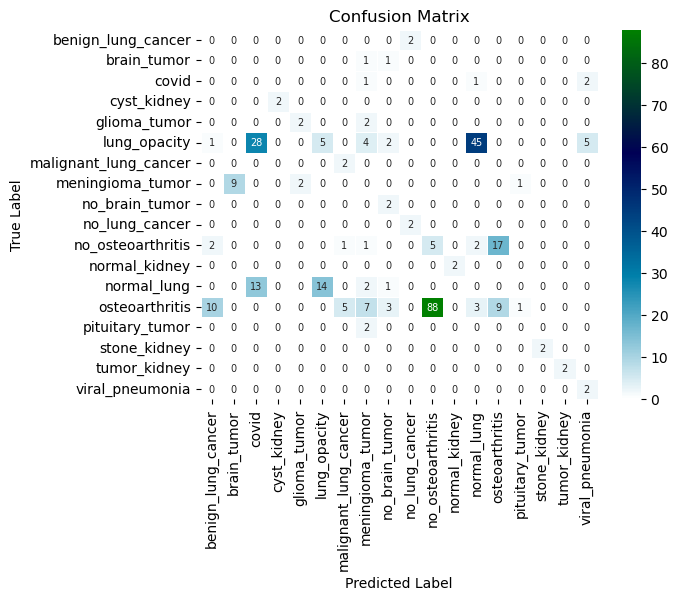

In [ ]:
sns.heatmap(conf_matrix,
            annot=True,
            cmap="ocean_r",
            fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={"fontsize": 7},
            linewidths=0.5
           )


# Add axis labels and a title to the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# ----------------------------------------------------------------------------------------------------------

# Grad Cam Visualization

In [ ]:
!pip install tensorflow keras opencv-python

# Find the last layer

In [ ]:
# Getting the last convolutional layer of the base model
last_conv_layer = None
for layer in model.layers[::-1]:
    if isinstance(layer, Conv2D):
        last_conv_layer = layer
        break

# If the last convolutional layer is not found directly, checking for nested layers
if last_conv_layer is None:
    for layer in model.layers[::-1]:
        for sub_layer in layer.layers[::-1]:
            if isinstance(sub_layer, Conv2D):
                last_conv_layer = sub_layer
                break
        if last_conv_layer is not None:
            break

if last_conv_layer is None:
    raise ValueError("Could not find the last convolutional layer. Grad-CAM cannot be applied.")
else:
    print("Last Convolutional Layer Name:", last_conv_layer.name)


Last Convolutional Layer Name: conv2d_1


# Start from here

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2S
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/models/mir18_effnetv2s_nf.h5")

In [ ]:
model = keras.models.load_model(r"D:\jupyter_space\Medical Image Reader\mir18v2_effnetv2s_nf.h5")

# Processing of the Image

In [ ]:
image_path = r"D:\mir_repository\Datasets with aug images\mir18_v2\test\covid\COVID-1195.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))  # Resize the image to the input size of your CNN
img = np.expand_dims(img, axis=0)

# Necessary functions

In [ ]:
#Grad Cam function
def grad_cam(model, img, class_index, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(conv_outputs[0], axis=-1)

    for i in range(pooled_grads.shape[0]):
        heatmap += (pooled_grads[i] * conv_outputs[0][:, :, i])

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


#Function for gudied backpropagation
def guided_backpropagation(image, model, layer_name):
    layer = model.get_layer(layer_name)
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[layer.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        outputs = grad_model(inputs)

    grads = tape.gradient(outputs, inputs)
    guided_grads = tf.cast(grads > 0, "float32") * grads

    return guided_grads.numpy()

# Predict and Generate heatmaps

In [ ]:
# Get the class index with highest confidence for the input image
predicted_class_index = np.argmax(model.predict(img)[0])
print(predicted_class_index)

# Compute Grad-CAM and Guided Backpropagation
heatmap = grad_cam(model, img, predicted_class_index, layer_name= 'conv2d_1')
guided_grads = guided_backpropagation(img, model, layer_name= 'conv2d_1')

# Normalize the heatmap and guided gradients
heatmap_normalized = heatmap - np.min(heatmap)
heatmap_normalized /= np.max(heatmap_normalized)

guided_grads = guided_grads.squeeze()
guided_grads /= np.max(guided_grads)
guided_grads = np.uint8(guided_grads * 255)

# Resize the heatmap to match the shape of guided_grads_normalized
heatmap_normalized_resized = cv2.resize(heatmap_normalized, (img.shape[2], img.shape[1]))

1/1 [==============================] - 0s 40ms/step
2


# Plot the visualizations

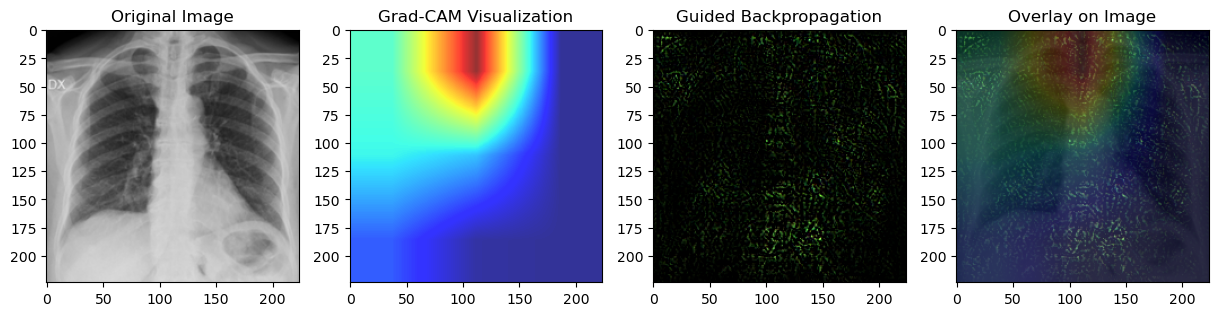

In [ ]:
# Plot the original image, Grad-CAM visualization, Guided Backpropagation, and Guided Grad-CAM visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

plt.subplot(1, 4, 1)
plt.imshow(img.squeeze() / 255.0, alpha=1)
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(heatmap_normalized_resized, cmap='jet', alpha=0.8)
plt.title("Grad-CAM Visualization")

plt.subplot(1, 4, 3)
plt.imshow(guided_grads, cmap='jet', alpha=1.0)
plt.title("Guided Backpropagation")

plt.subplot(1, 4, 4)


plt.imshow(img.squeeze() / 255.0, cmap='jet', alpha=1.0)
plt.imshow(heatmap_normalized_resized, cmap='jet', alpha=0.5)
plt.imshow(guided_grads, cmap='viridis', alpha=0.6)

plt.title("Overlay on Image")

plt.show()


# Hyperparameter Tuning (ResNet Architecture)

In [ ]:
def build_model(hp):
  model = Sequential()
  count = 0

  for i in range(hp.Int('num_layers', min_value = 2, max_value = 50)):

    if count ==0:
      model.add(
          Conv2D(
              hp.Int('filters'+str(i), min_value = 8, max_value = 256, step = 16),
              hp.Int('kernel_size'+ str(i), min_value =1, max_value= 10, step= 2),
              strides = hp.Int('strides'+str(i), min_value = 1, max_value = 10, step = 2),
              activation = hp.Choice('activation'+str(i), values =['relu','sigmoid','tanh','softmax']),
              input_shape = (224, 224, 3),
              padding = 'same'
          )
      )

      model.add(
          MaxPooling2D(
              pool_size = hp.Int('pool_size'+str(i), min_value =1, max_value = 10, step=2),
              strides = hp.Int('strides'+str(i), min_value = 1, max_value = 10, step = 2),
              padding = 'same'
          )
      )

    else:
      model.add(
          Conv2D(
              hp.Int('filters'+str(i), min_value = 8, max_value = 256, step = 16),
              hp.Int('kernel_size'+ str(i), min_value =1, max_value= 10, step= 2),
              strides = hp.Int('strides'+str(i), min_value = 1, max_value = 10, step = 2),
              activation = hp.Choice('activation'+str(i), values =['relu','sigmoid','tanh','softmax']),
              padding = 'same'
          )
      )

      model.add(
          MaxPooling2D(
              pool_size = hp.Int('pool_size'+str(i), min_value =1, max_value = 10, step=2),
              strides = hp.Int('strides'+str(i), min_value = 1, max_value = 10, step = 2),
              padding = 'same'
          )
      )
    count+=1


  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  model.compile(
        optimizer = hp.Choice('optimizer', values =['rmsprop', 'adam', 'sgd','nadam','adadelta']),
        loss='binary_crossentropy',
        metrics =['accuracy']
    )

  return model

# Custom EarlyStopping

In [ ]:
class MyEarlyStop(EarlyStopping):
    def __init__(self, min_val_acc, **kwargs):
        super().__init__(**kwargs)
        self.min_val_acc = min_val_acc

    def on_epoch_end(self, epoch, logs=None):

        # Check if it's the first epoch
        if epoch == 0:
            val_acc = logs.get('val_accuracy')
            if val_acc is not None and val_acc < self.min_val_acc:
                self.stopped_epoch = epoch
                self.model.stop_training = True

# Hyperparameter Tuning (Pre-trained Model)

In [ ]:
def build_model(hp):
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)

    for i in range(hp.Int('num_layers', min_value=0, max_value=10)):
        model.add(
            Conv2D(
                hp.Int('filters' + str(i), min_value=8, max_value=256, step=16),
                hp.Int('kernel_size' + str(i), min_value=1, max_value=10, step=1),
                strides=hp.Int('strides' + str(i), min_value=1, max_value=5, step=1),
                activation=hp.Choice('activation' + str(i), values=['relu', 'sigmoid', 'softmax']),
                padding='same'
            )
        )

        model.add(
            MaxPooling2D(
                pool_size=hp.Int('pool_size' + str(i), min_value=1, max_value=10, step=1),
                strides=hp.Int('strides' + str(i), min_value=1, max_value=10, step=1),
                padding='same'
            )
        )

    model.add(Flatten())

    for i in range(hp.Int('dense_layers', min_value=0, max_value=5)):
        model.add(
            Dense(
                hp.Int('units' + str(i), min_value=20, max_value=500, step=20),
                activation=hp.Choice('activation' + str(i), values=['relu', 'sigmoid', 'tanh']),
            )
        )

    model.add(Dense(18, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    try:
        es = MyEarlyStop(min_val_acc=0.5, patience=0)

    except Exception as e:
        print("Skipping hyperparameters due to an error:", e)
        return None

    return model

In [ ]:
#Using Random Search

tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=200, directory=r"D:\jupyter_space\Medical Image Reader\bestmodel")
tuner.search(train_ds , validation_data=valid_ds)